In [12]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxportfolio as cp

plotdir='../../portfolio/plots/'
datadir='../data/' 

sigmas=pd.read_csv(datadir+'sigmas.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]
returns=pd.read_csv(datadir+'returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]

#, 'NKE', 'IBM', 'BAC', 'C'
subset_tickers = ['AMZN', 'GOOGL', 'BAC', 'USDOLLAR']
sigmas = sigmas.ix[:, sigmas.columns.isin(subset_tickers)]
returns = returns.ix[:, returns.columns.isin(subset_tickers)]
volumes = volumes.ix[:, volumes.columns.isin(subset_tickers)]

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

start_t="2012-02-01"
end_t="2016-12-31"

simulated_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., sigma=sigmas, volume=volumes)
simulated_hcost = cp.HcostModel(borrow_costs=0.0001)
simulator = cp.MarketSimulator(returns, costs=[simulated_tcost, simulated_hcost],
                               market_volumes=volumes, cash_key='USDOLLAR')


return_estimate=pd.read_csv(datadir+'return_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()
volume_estimate=pd.read_csv(datadir+'volume_estimate.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1].dropna()
sigma_estimate=pd.read_csv(datadir+'sigma_estimate.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1].dropna()


return_estimate = return_estimate.ix[:, return_estimate.columns.isin(subset_tickers)]
volume_estimate = volume_estimate.ix[:, volume_estimate.columns.isin(subset_tickers)]
sigma_estimate = sigma_estimate.ix[:, sigma_estimate.columns.isin(subset_tickers)]


optimization_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., 
                                sigma=sigma_estimate, volume=volume_estimate)
optimization_hcost=cp.HcostModel(borrow_costs=0.0001)

risk_data = pd.HDFStore(datadir+'risk_model.h5')
risk_model = cp.FactorModelSigma(risk_data.exposures, risk_data.factor_sigma, risk_data.idyos)

results={}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
volumes["2012-02":].head()

,GOOGL,AMZN,BAC
Date,,,
2012-02-01,1350736825,3829066236,2223782521
2012-02-02,1415802042,1587560436,1641047154
2012-02-03,1893408118,1524055440,2706026698
2012-02-06,2245886768,972473399,1784977100
2012-02-07,1272076076,940087341,1887388896


# SPO coarse search

In [14]:
(returns.shape, return_estimate.shape)

((2517, 4), (2517, 4))

In [15]:
#risk_model = cp.FactorModelSigma(risk_data.exposures, risk_data.factor_sigma, risk_data.idyos)
# cvxportfolio equivalent
Sigma_hat = returns.rolling(window=250, min_periods=250).cov().unstack().shift(1).stack().dropna()

#risk_data = pd.HDFStore(datadir+'risk_model.h5')
#risk_model = cp.FactorModelSigma(risk_data.exposures, risk_data.factor_sigma, risk_data.idyos)
risk_model = cp.FullSigma(Sigma_hat)
results={}

In [16]:
policies={}
gamma_risks_coarse=[.1,.3]#,1,3,10,30,100,300,1000]
gamma_tcosts_coarse=[1,2]#,3,10,20]
for gamma_risk in gamma_risks_coarse:
    for gamma_tcost in gamma_tcosts_coarse : 
        policies[(gamma_risk, gamma_tcost)] = cp.SinglePeriodOpt(return_estimate, [gamma_risk*risk_model,gamma_tcost*optimization_tcost,optimization_hcost], 
                                [cp.LeverageLimit(3)])

import warnings
warnings.filterwarnings('ignore')
results.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,end_time=end_t,
                                              policies=policies.values(), parallel=True))))

******
h:GOOGL       3.333333e+07
AMZN        3.333333e+07
BAC         3.333333e+07
USDOLLAR    0.000000e+00
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.726e-03]
 [-3.777e-03]
 [ 1.420e-03]
 [ 2.400e-06]], [[0.33333333]
 [0.33333333]
 [0.33333333]
 [0.        ]] + var0)) + -0 + 0.1 * 0 + 0.0016093123671364908 * quad_over_lin([[ 3.60031787e-10 -1.45288212e-10 -5.03191338e-11  3.67177513e-05]
 [ 3.16817925e-01 -1.72687172e-01 -3.79982048e-02 -3.84190114e-06]
 [ 2.14864591e-01  4.49891585e-01 -2.53105417e-01 -6.73521197e-07]
 [-2.99721815e-01 -3.55033085e-01 -8.85504569e-01  3.20538017e-07]] * [[0.33333333]
 [0.33333333]
 [0.33333333]
 [0.        ]] + var0 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var0[:-1, 0])) + mul_elemwise([[0.00139481]
 [0.00354857]
 [0.00400635]], power(abs(var0[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[0.33333333]
 [0.33333333]
 [0.33333333]
 [0.        ]] + var0[:-1, 0], -0)) + -mul_elemwise(0.0, [[0.33333333]

 [-9.55228825e-01]] + var93[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.399354e+08
AMZN        4.212266e+07
BAC         2.457674e+07
USDOLLAR   -1.009915e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.514e-03]
 [-5.977e-03]
 [ 3.795e-04]
 [ 3.200e-06]], [[ 1.32460329]
 [ 0.39872552]
 [ 0.23263901]
 [-0.95596781]] + var93)) + -0 + 0.1 * 0 + 0.0016241465485167207 * quad_over_lin([[ 3.14419333e-10 -1.10873463e-10 -4.55391232e-11  3.48023610e-05]
 [ 3.23297795e-01 -1.63280631e-01 -4.38116461e-02 -3.49831754e-06]
 [ 2.00894352e-01  4.66754796e-01 -2.57084988e-01 -6.64373675e-07]
 [-3.00465825e-01 -3.57680466e-01 -8.84186051e-01  4.18073206e-07]] * [[ 1.32460329]
 [ 0.39872552]
 [ 0.23263901]
 [-0.95596781]] + var93 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var93[:-1, 0])) + mul_elemwise([[0.00222505]
 [0.00381624]
 [0.0037572 ]], power(abs(var93[:-1, 0]), 3/2))) + 1.0 * sum_en

 [-0.19307316]] + var155[:-1, 0]))******
h:GOOGL       1.235929e-02
AMZN       -8.966153e+07
BAC        -1.649814e+07
USDOLLAR    2.121083e+08
dtype: float64

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
Obj: sum_entries(mul_elemwise([[-3.651e-03]
 [ 1.024e-04]
 [ 2.495e-03]
 [ 4.400e-06]], [[ 1.16653572e-10]
 [-8.46273375e-01]
 [-1.55718229e-01]
 [ 2.00199160e+00]] + var248)) + -0 + 0.1 * 0 + 0.0016268370681919383 * quad_over_lin([[ 2.72030175e-10 -1.69161030e-11 -5.77266141e-11  3.29216021e-05]
 [ 3.25253618e-01 -1.63468335e-01 -4.50481442e-02 -2.85054543e-06]
 [ 1.99669988e-01  4.67055117e-01 -2.53181048e-01 -1.85382211e-06]
 [-2.99877353e-01 -3.52363119e-01 -8.86517798e-01  7.42351698e-07]] * [[ 1.16653572e-10]
 [-8.46273375e-01]
 [-1.55718229e-01]
 [ 2.00199160e+00]] + var248 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var248[:-1, 0])) + mul_elemwise([[0.00148691]
 [0.0035496 ]
 [0.00266492]], power(abs(var24

 [ 0.35239023]] + var341[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       7.124165e+06
AMZN       -7.343860e+06
BAC         7.307604e+05
USDOLLAR    1.066181e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.547e-04]
 [-1.265e-03]
 [ 1.181e-03]
 [ 4.800e-06]], [[ 0.06650069]
 [-0.06855144]
 [ 0.0068213 ]
 [ 0.99522944]] + var279)) + -0 + 0.1 * 0 + 0.0016315487692908366 * quad_over_lin([[ 2.69535711e-10 -4.06956500e-11 -6.00136097e-11  3.26948361e-05]
 [ 3.25356567e-01 -1.62547399e-01 -4.50866663e-02 -2.96731873e-06]
 [ 1.98137815e-01  4.67094623e-01 -2.54167758e-01 -1.51858911e-06]
 [-2.99912461e-01 -3.54667953e-01 -8.85586336e-01  4.05459840e-07]] * [[ 0.06650069]
 [-0.06855144]
 [ 0.0068213 ]
 [ 0.99522944]] + var279 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var279[:-1, 0])) + mul_elemwise([[0.00144628]
 [0.00361664]
 [0.0029218 ]], power(abs(var279[:-1, 0]), 3/2))) + 1.0 * sum_e

 [ 0.31846879]] + var372[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       4.396671e+01
AMZN        3.819334e+07
BAC         1.719046e+08
USDOLLAR   -1.072178e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 5.329e-04]
 [-6.845e-03]
 [ 3.320e-03]
 [ 3.600e-06]], [[ 4.27358301e-07]
 [ 3.71240961e-01]
 [ 1.67092017e+00]
 [-1.04216155e+00]] + var465)) + -0 + 0.1 * 0 + 0.0016340638218742683 * quad_over_lin([[ 2.45072778e-10 -4.01302948e-11 -5.84445126e-11  3.19709839e-05]
 [ 3.26429139e-01 -1.60281768e-01 -4.58135389e-02 -2.78717105e-06]
 [ 1.96469060e-01  4.71961933e-01 -2.51315814e-01 -1.37303492e-06]
 [-2.96477906e-01 -3.49794247e-01 -8.88675889e-01  2.09036067e-07]] * [[ 4.27358301e-07]
 [ 3.71240961e-01]
 [ 1.67092017e+00]
 [-1.04216155e+00]] + var465 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var465[:-1, 0])) + mul_elemwise([[0.00145298]
 [0.00303456]
 [0.00312053]], power(abs(var46

 [-0.30317965]] + var465[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -3.916964e+07
AMZN       -6.860492e+07
BAC         7.431886e+07
USDOLLAR    1.367211e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 3.228e-03]
 [ 2.329e-03]
 [-2.679e-04]
 [ 3.200e-06]], [[-0.37931047]
 [-0.6643555 ]
 [ 0.71968816]
 [ 1.32397782]] + var589)) + -0 + 0.1 * 0 + 0.0016325220821140109 * quad_over_lin([[ 2.24535126e-10 -7.51237069e-11 -5.29276421e-11  3.05981936e-05]
 [ 3.25506487e-01 -1.61310436e-01 -4.46765718e-02 -2.86195011e-06]
 [ 1.99067294e-01  4.71331385e-01 -2.51428785e-01 -7.38506723e-07]
 [-2.95286861e-01 -3.49596813e-01 -8.89150009e-01 -2.29469413e-07]] * [[-0.37931047]
 [-0.6643555 ]
 [ 0.71968816]
 [ 1.32397782]] + var589 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var589[:-1, 0])) + mul_elemwise([[0.00175379]
 [0.00390281]
 [0.00439397]], power(abs(var589[:-1, 0]), 3/2))) + 1.0 * sum_e

 [ 1.02785179]] + var682[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       9.989293e+07
AMZN       -8.449920e+06
BAC         1.084729e+08
USDOLLAR   -9.815983e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.217e-03]
 [ 9.913e-05]
 [-1.337e-03]
 [ 3.200e-06]], [[ 0.98168992]
 [-0.08304092]
 [ 1.06600904]
 [-0.96465804]] + var713)) + -0 + 0.1 * 0 + 0.0016247644840807571 * quad_over_lin([[ 1.95179169e-10 -9.06270369e-11 -2.16805686e-11  2.94527647e-05]
 [ 3.27207103e-01 -1.60314366e-01 -4.50328312e-02 -2.69479503e-06]
 [ 1.95804840e-01  4.70656210e-01 -2.52798176e-01 -3.54349215e-08]
 [-2.95456219e-01 -3.53748626e-01 -8.87450017e-01  2.16186446e-07]] * [[ 0.98168992]
 [-0.08304092]
 [ 1.06600904]
 [-0.96465804]] + var713 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var713[:-1, 0])) + mul_elemwise([[0.00127374]
 [0.00305326]
 [0.00342656]], power(abs(var713[:-1, 0]), 3/2))) + 1.0 * sum_e

 [ 0.61668207]] + var682[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       8.220847e+07
AMZN       -2.607779e+07
BAC         4.837280e+07
USDOLLAR    3.130053e+06
dtype: float64
******
h:GOOGL       1.880678e+08
AMZN       -1.461583e+06
BAC        -6.446807e+07
USDOLLAR   -2.863243e+07
dtype: float64Obj: sum_entries(mul_elemwise([[-1.217e-03]
 [ 9.913e-05]
 [-1.337e-03]
 [ 3.200e-06]], [[ 0.76378116]
 [-0.24228311]
 [ 0.4494213 ]
 [ 0.02908065]] + var713)) + -0 + 0.1 * 0 + 0.0016247644840807571 * quad_over_lin([[ 1.95179169e-10 -9.06270369e-11 -2.16805686e-11  2.94527647e-05]
 [ 3.27207103e-01 -1.60314366e-01 -4.50328312e-02 -2.69479503e-06]
 [ 1.95804840e-01  4.70656210e-01 -2.52798176e-01 -3.54349215e-08]
 [-2.95456219e-01 -3.53748626e-01 -8.87450017e-01  2.16186446e-07]] * [[ 0.76378116]
 [-0.24228311]
 [ 0.4494213 ]
 [ 0.02908065]] + var713 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(

 [-0.76789742]] + var806[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.408839e+07
AMZN        2.230873e+07
BAC         7.587862e+07
USDOLLAR   -1.543437e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.489e-03]
 [-1.232e-04]
 [ 4.338e-03]
 [ 3.600e-06]], [[ 0.14547904]
 [ 0.23036362]
 [ 0.7835352 ]
 [-0.15937786]] + var899)) + -0 + 0.1 * 0 + 0.0016451255124246412 * quad_over_lin([[ 1.58071652e-10 -7.75149559e-11 -3.77274023e-11  2.89504437e-05]
 [ 3.25529704e-01 -1.57749511e-01 -4.53356249e-02 -2.25887246e-06]
 [ 1.93882688e-01  4.71387391e-01 -2.48073258e-01 -1.19754421e-07]
 [-2.92769484e-01 -3.48229083e-01 -8.90518127e-01 -4.94339288e-07]] * [[ 0.14547904]
 [ 0.23036362]
 [ 0.7835352 ]
 [-0.15937786]] + var899 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var899[:-1, 0])) + mul_elemwise([[0.00173019]
 [0.00264682]
 [0.00309835]], power(abs(var899[:-1, 0]), 3/2))) + 1.0 * sum_e

 [-0.50557548]] + var930[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.145076e+08
AMZN       -6.677695e+06
BAC         1.031466e+08
USDOLLAR   -9.941848e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.156e-03]
 [ 3.187e-03]
 [ 3.363e-03]
 [ 4.000e-06]], [[ 1.02644027]
 [-0.05985849]
 [ 0.92460007]
 [-0.89118185]] + var992)) + -0 + 0.1 * 0 + 0.001669745364046099 * quad_over_lin([[ 2.00956066e-10 -7.61446913e-11 -6.63776849e-11  2.87060247e-05]
 [ 3.21716272e-01 -1.56331208e-01 -4.36594342e-02 -2.76780366e-06]
 [ 1.95401709e-01  4.69706400e-01 -2.42006328e-01 -6.81575729e-07]
 [-2.87387236e-01 -3.41504805e-01 -8.94864819e-01 -9.63234192e-07]] * [[ 1.02644027]
 [-0.05985849]
 [ 0.92460007]
 [-0.89118185]] + var992 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var992[:-1, 0])) + mul_elemwise([[0.00231586]
 [0.00378023]
 [0.00403068]], power(abs(var992[:-1, 0]), 3/2))) + 1.0 * sum_en

 [0.26400238]] + var1116[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
Obj: sum_entries(mul_elemwise([[ 5.832e-04]
 [ 2.657e-03]
 [-1.359e-03]
 [ 4.000e-06]], [[ 0.89454684]
 [-0.21985666]
 [ 0.44275951]
 [-0.11744968]] + var1023)) + -0 + 0.1 * 0 + 0.0016704591425701974 * quad_over_lin([[ 1.87710716e-10 -8.21429921e-11 -5.87099772e-11  2.87174007e-05]
 [ 3.21687753e-01 -1.57629787e-01 -4.29560833e-02 -2.64140798e-06]
 [ 1.97757066e-01  4.69454071e-01 -2.41733377e-01 -4.44013702e-07]
 [-2.86428993e-01 -3.40487510e-01 -8.95559427e-01 -9.32575532e-07]] * [[ 0.89454684]
 [-0.21985666]
 [ 0.44275951]
 [-0.11744968]] + var1023 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var1023[:-1, 0])) + mul_elemwise([[0.00241397]
 [0.00463955]
 [0.00414459]], power(abs(var1023[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[ 0.89454684]
 [-0.21985666]
 [ 0.44275951]
 [-0.11744968]] + var1023[:-1, 


constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       8.668388e+07
AMZN       -2.431314e+07
BAC         3.940752e+07
USDOLLAR    1.583305e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.881e-03]
 [-1.677e-03]
 [ 1.278e-03]
 [ 3.600e-06]], [[ 0.7370369 ]
 [-0.2067245 ]
 [ 0.33506575]
 [ 0.13462185]] + var1147)) + -0 + 0.1 * 0 + 0.0016794569974802882 * quad_over_lin([[ 1.81062754e-10 -7.85742645e-11 -6.90044560e-11  2.84128348e-05]
 [ 3.23177095e-01 -1.57603865e-01 -4.19000882e-02 -2.59707404e-06]
 [ 1.95818196e-01  4.65404962e-01 -2.40230166e-01 -5.44242819e-07]
 [-2.83393113e-01 -3.43026294e-01 -8.95556422e-01 -1.31766102e-06]] * [[ 0.7370369 ]
 [-0.2067245 ]
 [ 0.33506575]
 [ 0.13462185]] + var1147 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var1147[:-1, 0])) + mul_elemwise([[0.00240829]
 [0.00503719]
 [0.00447098]], power(abs(var1147[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --

 [ 0.54105799]] + var1240[:-1, 0]))constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.133636e+08
AMZN       -1.405177e+00
BAC         1.405231e+07
USDOLLAR    2.108041e+08
dtype: float64
******
h:GOOGL       5.537380e+06
AMZN       -3.495241e+07
BAC         4.501648e+07
USDOLLAR    1.004823e+08
dtype: float64Obj: sum_entries(mul_elemwise([[-7.595e-03]
 [ 1.657e-03]
 [-3.569e-03]
 [ 3.200e-06]], [[-1.01677997e+00]
 [-1.26033003e-08]
 [ 1.26037834e-01]
 [ 1.89074215e+00]] + var1333)) + -0 + 0.1 * 0 + 0.0016842791723514663 * quad_over_lin([[ 1.54360092e-10 -4.11409440e-11 -6.94192938e-11  2.83440037e-05]
 [ 3.22135567e-01 -1.52726498e-01 -4.42542116e-02 -2.08440151e-06]
 [ 1.90838028e-01  4.71644787e-01 -2.38552213e-01 -9.38963680e-07]
 [-2.83870191e-01 -3.38831951e-01 -8.97000905e-01 -1.14277458e-06]] * [[-1

 [ 1.88140243]] + var1426[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -8.995566e+07
AMZN       -2.702109e+07
BAC         2.025557e+07
USDOLLAR    2.139396e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-7.090e-04]
 [ 5.285e-04]
 [-4.276e-03]
 [ 3.200e-06]], [[-0.76741942]
 [-0.23051927]
 [ 0.17280199]
 [ 1.82513671]] + var1364)) + -0 + 0.1 * 0 + 0.001684507295142436 * quad_over_lin([[ 1.63439588e-10 -5.15733692e-11 -6.53992805e-11  2.84239176e-05]
 [ 3.21757107e-01 -1.53007562e-01 -4.39830317e-02 -2.22894760e-06]
 [ 1.91350930e-01  4.70972462e-01 -2.38588073e-01 -7.94688793e-07]
 [ 2.83838280e-01  3.39050956e-01  8.96928247e-01  1.04679626e-06]] * [[-0.76741942]
 [-0.23051927]
 [ 0.17280199]
 [ 1.82513671]] + var1364 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var1364[:-1, 0])) + mul_elemwise([[0.00216148]
 [0.00442745]
 [0.00368163]], power(abs(var1364[:-1, 0]), 3/2))) + 1.0 * s

 [ 1.94834189]] + var1457[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
Obj: sum_entries(mul_elemwise([[ 5.065e-04]
 [ 1.415e-03]
 [-5.119e-04]
 [ 3.600e-06]], [[-0.59911248]
 [ 1.00687075]
 [-0.44887282]
 [ 1.04111456]] + var1550)) + -0 + 0.1 * 0 + 0.0017179108039820624 * quad_over_lin([[ 1.40359747e-10 -2.27287334e-11 -5.94288295e-11  2.97412791e-05]
 [ 3.19973204e-01 -1.50404131e-01 -4.41610966e-02 -1.71325165e-06]
 [ 1.86354846e-01  4.65909678e-01 -2.36547190e-01 -9.96087108e-07]
 [-2.84082762e-01 -3.41282894e-01 -8.96003890e-01 -7.10514356e-07]] * [[-0.59911248]
 [ 1.00687075]
 [-0.44887282]
 [ 1.04111456]] + var1550 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var1550[:-1, 0])) + mul_elemwise([[0.00238798]
 [0.00359   ]
 [0.00473698]], power(abs(var1550[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[-0.59911248]
 [ 1.00687075]
 [-0.44887282]
 [ 1.04111456]] + var1550[:-1,

 [ 1.17897511]] + var1643[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -9.171253e+07
AMZN        3.668119e+06
BAC        -1.309443e+07
USDOLLAR    2.216403e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.175e-03]
 [-1.933e-03]
 [ 2.939e-03]
 [ 3.200e-06]], [[-0.76109062]
 [ 0.03044046]
 [-0.10866615]
 [ 1.83931631]] + var1581)) + -0 + 0.1 * 0 + 0.0017248007899673804 * quad_over_lin([[ 1.35370388e-10 -2.23439129e-11 -5.18596539e-11  2.97973875e-05]
 [ 3.10326209e-01 -1.37569521e-01 -4.43274266e-02 -1.59012684e-06]
 [ 1.75019124e-01  4.69546594e-01 -2.31962008e-01 -8.46730874e-07]
 [-2.78918022e-01 -3.39759526e-01 -8.98202762e-01 -5.50880535e-07]] * [[-0.76109062]
 [ 0.03044046]
 [-0.10866615]
 [ 1.83931631]] + var1581 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var1581[:-1, 0])) + mul_elemwise([[0.00266328]
 [0.00405965]
 [0.00516453]], power(abs(var1581[:-1, 0]), 3/2))) + 1.0 * 

 [ 1.98958765]] + var1674[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -8.404316e+07
AMZN        7.326412e+07
BAC         1.488764e+07
USDOLLAR    1.103387e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.746e-03]
 [ 6.338e-03]
 [ 1.882e-03]
 [ 3.600e-06]], [[-0.73433939]
 [ 0.64015601]
 [ 0.1300829 ]
 [ 0.96410048]] + var1767)) + -0 + 0.1 * 0 + 0.0017316311846729392 * quad_over_lin([[ 1.68076690e-10 -3.24984281e-11 -5.43301883e-11  2.99842583e-05]
 [ 3.09107885e-01 -1.40439002e-01 -4.30708336e-02 -1.96296079e-06]
 [ 1.79998089e-01  4.67204792e-01 -2.31593994e-01 -9.22237482e-07]
 [-2.78863204e-01 -3.38118934e-01 -8.98838639e-01 -4.31960064e-07]] * [[-0.73433939]
 [ 0.64015601]
 [ 0.1300829 ]
 [ 0.96410048]] + var1767 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var1767[:-1, 0])) + mul_elemwise([[0.00264951]
 [0.00412489]
 [0.00520307]], power(abs(var1767[:-1, 0]), 3/2))) + 1.0 * 

 [ 1.70539553]] + var1798[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.199709e+08
AMZN        2.381569e+08
BAC         1.452563e+06
USDOLLAR   -3.807175e+04
dtype: float64
Obj: sum_entries(mul_elemwise([[ 4.789e-03]
 [ 7.610e-03]
 [-4.574e-03]
 [ 3.600e-06]], [[-1.00309621e+00]
 [ 1.99126942e+00]
 [ 1.21451161e-02]
 [-3.18324196e-04]] + var1860)) + -0 + 0.1 * 0 + 0.0017277192258472857 * quad_over_lin([[ 1.50336312e-10 -3.09286218e-11 -5.27919410e-11  3.04659552e-05]
 [ 3.04386775e-01 -1.46058547e-01 -4.05815994e-02 -1.72061424e-06]
 [ 1.88960493e-01  4.56822361e-01 -2.26845059e-01 -8.61759576e-07]
 [-2.79366557e-01 -3.31859796e-01 -9.01012432e-01 -5.19636532e-07]] * [[-1.00309621e+00]
 [ 1.99126942e+00]
 [ 1.21451161e-02]
 [-3.18324196e-04]] + var1860 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var1860[:-1, 0])) + mul_elemwise([[0.00226163]
 [0.00330727]
 [0.00431499]], power(abs(v

 [ 0.83496638]] + var1922[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       4.585203e+07
AMZN        2.836319e+08
BAC        -1.662105e+08
USDOLLAR   -3.793788e+06
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.667e-03]
 [ 5.834e-03]
 [-7.460e-03]
 [ 3.200e-06]], [[ 0.28751018]
 [ 1.77848343]
 [-1.04220508]
 [-0.02378854]] + var1953)) + -0 + 0.1 * 0 + 0.0017394708382519814 * quad_over_lin([[ 2.15409923e-10 -1.08553822e-10 -5.12657965e-11  3.07715170e-05]
 [ 3.25854297e-01 -1.19832485e-01 -5.46002352e-02 -2.79478090e-06]
 [ 1.44432907e-01  5.04359397e-01 -2.44954193e-01  3.60076069e-07]
 [-2.79574092e-01 -3.53491282e-01 -8.92682609e-01 -7.77143392e-07]] * [[ 0.28751018]
 [ 1.77848343]
 [-1.04220508]
 [-0.02378854]] + var1953 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var1953[:-1, 0])) + mul_elemwise([[0.00271617]
 [0.00382021]
 [0.00600513]], power(abs(var1953[:-1, 0]), 3/2))) + 1.0 * 

 [ 0.27816664]] + var2046[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -3.570955e+07
AMZN        1.532914e+08
BAC        -7.190645e+07
USDOLLAR    9.889622e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 5.985e-03]
 [-2.559e-03]
 [ 4.679e-03]
 [ 4.000e-06]], [[-0.24700244]
 [ 1.06031462]
 [-0.49737581]
 [ 0.68406363]] + var2046)) + -0 + 0.1 * 0 + 0.0017474734963646838 * quad_over_lin([[ 2.05689910e-10 -1.03722426e-10 -4.08092523e-11  3.09326825e-05]
 [ 3.25370059e-01 -1.20711364e-01 -5.43091793e-02 -2.63999511e-06]
 [ 1.45428524e-01  5.02249675e-01 -2.45062736e-01  3.93775996e-07]
 [-2.80311478e-01 -3.54159259e-01 -8.92186469e-01 -5.00650973e-07]] * [[-0.24700244]
 [ 1.06031462]
 [-0.49737581]
 [ 0.68406363]] + var2046 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var2046[:-1, 0])) + mul_elemwise([[0.00294395]
 [0.00370188]
 [0.00503254]], power(abs(var2046[:-1, 0]), 3/2))) + 1.0 * 

 [-0.32253035]] + var2139[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.609611e+08
AMZN        6.504213e+07
BAC         1.069796e+06
USDOLLAR   -1.621140e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.645e-04]
 [-6.305e-03]
 [-3.791e-03]
 [ 4.000e-06]], [[ 1.58197521]
 [ 0.39429269]
 [ 0.00648523]
 [-0.98275312]] + var2170)) + -0 + 0.1 * 0 + 0.001749236568884659 * quad_over_lin([[ 1.88469955e-10 -1.06980431e-10 -3.64821644e-11  3.15312509e-05]
 [ 3.25412533e-01 -1.20857906e-01 -5.42812726e-02 -2.41792548e-06]
 [ 1.45897490e-01  5.02429609e-01 -2.44020045e-01  5.50262451e-07]
 [-2.79859101e-01 -3.52448426e-01 -8.93005594e-01 -5.56236398e-07]] * [[ 1.58197521]
 [ 0.39429269]
 [ 0.00648523]
 [-0.98275312]] + var2170 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var2170[:-1, 0])) + mul_elemwise([[0.00317577]
 [0.00429343]
 [0.00606731]], power(abs(var2170[:-1, 0]), 3/2))) + 1.0 * s

 [ 1.10952549]] + var2294[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.537413e+08
AMZN        1.092103e+08
BAC        -2.875111e+07
USDOLLAR   -8.986737e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.972e-03]
 [-3.342e-03]
 [-6.064e-03]
 [ 3.600e-06]], [[ 1.0651836 ]
 [ 0.75665427]
 [-0.1991996 ]
 [-0.62263828]] + var2232)) + -0 + 0.1 * 0 + 0.0017506530149893106 * quad_over_lin([[ 1.96119415e-10 -1.04428874e-10 -3.04800861e-11  3.18925380e-05]
 [ 3.25671596e-01 -1.18982460e-01 -5.47480801e-02 -2.44459859e-06]
 [ 1.42568566e-01  5.00238403e-01 -2.39078035e-01  5.32781379e-07]
 [-2.77846790e-01 -3.48622693e-01 -8.95133163e-01 -2.88433024e-07]] * [[ 1.0651836 ]
 [ 0.75665427]
 [-0.1991996 ]
 [-0.62263828]] + var2232 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var2232[:-1, 0])) + mul_elemwise([[0.00301751]
 [0.00374979]
 [0.00480923]], power(abs(var2232[:-1, 0]), 3/2))) + 1.0 * 

 [ 0.19697951]] + var2418[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.174550e+08
AMZN        1.004419e+08
BAC        -4.437357e+07
USDOLLAR   -2.525850e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.148e-03]
 [-2.430e-03]
 [-3.006e-03]
 [ 3.200e-06]], [[ 0.79219738]
 [ 0.67744919]
 [-0.29928588]
 [-0.17036069]] + var2325)) + -0 + 0.1 * 0 + 0.0017538892562592597 * quad_over_lin([[ 1.44934233e-10 -8.51275225e-11 -1.44312052e-11  3.23824534e-05]
 [ 3.27664991e-01 -1.21600746e-01 -5.36415467e-02 -1.81010239e-06]
 [ 1.45851967e-01  4.99032079e-01 -2.40337770e-01  5.51967381e-07]
 [-2.76474968e-01 -3.50204995e-01 -8.94940251e-01 -8.20340175e-08]] * [[ 0.79219738]
 [ 0.67744919]
 [-0.29928588]
 [-0.17036069]] + var2325 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var2325[:-1, 0])) + mul_elemwise([[0.00394749]
 [0.00496241]
 [0.00512031]], power(abs(var2325[:-1, 0]), 3/2))) + 1.0 * 

 [-0.14633602]] + var2511[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.063844e+08
AMZN        9.781180e+07
BAC        -2.318906e+07
USDOLLAR   -3.649548e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.492e-03]
 [-1.117e-03]
 [-8.860e-04]
 [ 4.000e-06]], [[ 0.73616487]
 [ 0.67684343]
 [-0.1604649 ]
 [-0.2525434 ]] + var2449)) + -0 + 0.1 * 0 + 0.0017572353225496105 * quad_over_lin([[ 1.61739612e-10 -9.13363461e-11 -2.20036281e-11  3.27211735e-05]
 [ 3.29063752e-01 -1.30244827e-01 -5.08953503e-02 -2.02433487e-06]
 [ 1.59688391e-01  4.98451342e-01 -2.43107631e-01  4.38539774e-07]
 [-2.76397962e-01 -3.48308588e-01 -8.95703798e-01 -2.08350346e-07]] * [[ 0.73616487]
 [ 0.67684343]
 [-0.1604649 ]
 [-0.2525434 ]] + var2449 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var2449[:-1, 0])) + mul_elemwise([[0.00448383]
 [0.00555057]
 [0.00543587]], power(abs(var2449[:-1, 0]), 3/2))) + 1.0 * 

 [-0.28966593]] + var2542[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.332563e+07
AMZN       -9.071060e+07
BAC         7.792641e+07
USDOLLAR    1.403585e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.079e-03]
 [ 1.330e-02]
 [-1.931e-04]
 [ 3.200e-06]], [[ 0.20712023]
 [-0.56377032]
 [ 0.48431605]
 [ 0.87233404]] + var2635)) + -0 + 0.1 * 0 + 0.0017648109542252126 * quad_over_lin([[ 2.09291851e-10 -8.84639797e-11 -3.57177341e-11  3.31006155e-05]
 [ 3.29779751e-01 -1.31498428e-01 -5.05189410e-02 -2.49111714e-06]
 [ 1.60517900e-01  4.95920371e-01 -2.43021641e-01  4.82111555e-08]
 [-2.76424915e-01 -3.49271912e-01 -8.95320277e-01 -1.51758898e-07]] * [[ 0.20712023]
 [-0.56377032]
 [ 0.48431605]
 [ 0.87233404]] + var2635 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var2635[:-1, 0])) + mul_elemwise([[0.00353162]
 [0.00585816]
 [0.00721006]], power(abs(var2635[:-1, 0]), 3/2))) + 1.0 * 

 [-0.93675892]] + var2728[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       8.773379e+07
AMZN        1.581267e+08
BAC        -1.197396e+07
USDOLLAR   -9.402414e+07
dtype: float64
******
h:GOOGL      -3.432423e+06
AMZN        2.769060e+08
BAC         5.294492e+07
USDOLLAR   -1.550351e+08
dtype: float64Obj: sum_entries(mul_elemwise([[2.966e-04]
 [5.364e-04]
 [1.782e-03]
 [3.200e-06]], [[ 0.62728666]
 [ 1.13058782]
 [-0.08561249]
 [-0.67226198]] + var2666)) + -0 + 0.1 * 0 + 0.0017642280999440598 * quad_over_lin([[ 2.03897768e-10 -9.70542141e-11 -3.07955566e-11  3.31725493e-05]
 [ 3.29593663e-01 -1.32103377e-01 -5.01566930e-02 -2.45893688e-06]
 [ 1.62159412e-01  4.97377456e-01 -2.44404612e-01  2.31578822e-07]
 [-2.76401087e-01 -3.49746258e-01 -8.95142444e-01 -1.55345111e-07]] * [[ 0.62728666]
 [ 1.13058782]
 [-0.08561249]
 [-0.67226198]] + var2666 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(v

 [-0.67997315]] + var2759[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       6.477974e+07
AMZN        1.746664e+08
BAC         6.179289e+07
USDOLLAR   -1.354308e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.788e-04]
 [ 3.184e-03]
 [-1.478e-03]
 [ 4.000e-06]], [[ 0.39069061]
 [ 1.05342404]
 [ 0.37267678]
 [-0.81679143]] + var2852)) + -0 + 0.1 * 0 + 0.0017986903122303895 * quad_over_lin([[ 2.40092591e-10 -1.01542324e-10 -5.15214255e-11  3.34537784e-05]
 [ 3.26736981e-01 -1.31422851e-01 -4.96554385e-02 -2.82032206e-06]
 [ 1.62206234e-01  4.93208322e-01 -2.38041768e-01 -3.36956571e-08]
 [-2.74561059e-01 -3.43222852e-01 -8.98228422e-01 -4.54644568e-07]] * [[ 0.39069061]
 [ 1.05342404]
 [ 0.37267678]
 [-0.81679143]] + var2852 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var2852[:-1, 0])) + mul_elemwise([[0.00368088]
 [0.00408104]
 [0.01056878]], power(abs(var2852[:-1, 0]), 3/2))) + 1.0 * 

 [-0.69042412]] + var2945[:-1, 0]))constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       8.707714e+07
AMZN        1.575569e+08
BAC        -1.645431e+07
USDOLLAR   -9.192786e+07
dtype: float64******
h:GOOGL       6.564566e+07
AMZN        1.708896e+08
BAC         5.352095e+07
USDOLLAR   -1.169862e+08
dtype: float64

Obj: sum_entries(mul_elemwise([[-3.103e-04]
 [-3.288e-03]
 [ 2.265e-04]
 [ 4.400e-06]], [[ 0.63908951]
 [ 1.15636512]
 [-0.12076394]
 [-0.67469069]] + var2883)) + -0 + 0.1 * 0 + 0.0017987051056109083 * quad_over_lin([[ 2.47254845e-10 -9.96658074e-11 -5.38702560e-11  3.36009678e-05]
 [ 3.26756466e-01 -1.31490767e-01 -4.96547956e-02 -2.87408893e-06]
 [ 1.62131683e-01  4.92790628e-01 -2.38040291e-01 -1.12995548e-07]
 [-2.74686835e-01 -3.43450602e-01 -8.98102904e-01 -4.37298838e-07]] * [[ 0.63908951]
 [ 1

Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Traceback (most recent call last):
  File "/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/multiprocess/process.py", line 254, in _bootstrap
    self.run()
Traceback (most recent call last):
TypeError: <class 'pandas.core.frame.DataFrame'> is not a valid type for a Constant value.
  File "/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/multiprocess/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/yowtzu/repo/cvxportfolio/cvxportfolio/risks.py", line 94, in _estimate
    self.expression = cvx.quad_form(wplus, locator(self.Sigma, t))
  File "/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/cvxpy/atoms/quad_form.py", line 91, in quad_form
    x, P = list(map(Expression.cast_to_const, (x, P)))
  File "/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/cvxpy/expressions/expression.py", line 240, in cast_to_const
    return expr i

KeyboardInterrupt: 

  File "/home/yowtzu/repo/cvxportfolio/cvxportfolio/policies.py", line 230, in get_trades
    cost_expr, const_expr = cost.weight_expr(t, wplus, z, value)
  File "/home/yowtzu/repo/cvxportfolio/cvxportfolio/risks.py", line 54, in weight_expr
    self.expression = self._estimate(t, w_plus - self.w_bench, z, value)
  File "/home/yowtzu/repo/cvxportfolio/cvxportfolio/risks.py", line 97, in _estimate
    wplus, locator(self.Sigma, t).values)
  File "/home/yowtzu/repo/cvxportfolio/cvxportfolio/risks.py", line 36, in locator
    prev_t = obj.loc[:t, :].index.values[-1][0]
  File "/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/pandas/core/indexes/multi.py", line 700, in values
    taken = algos.take_1d(lev._box_values(lev._values), lab,
  File "/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/pandas/core/indexes/datetimelike.py", line 244, in _box_values
    return lib.map_infer(values, self._box_func)
  File "pandas/_libs/src/inference.pyx", line 1521,

******
h:GOOGL       3.333333e+07
AMZN        3.333333e+07
BAC         3.333333e+07
USDOLLAR    0.000000e+00
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.726e-03]
 [-3.777e-03]
 [ 1.420e-03]
 [ 2.400e-06]], [[0.33333333]
 [0.33333333]
 [0.33333333]
 [0.        ]] + var0)) + -0 + 0.3 * 0 + 0.0016093123671364908 * quad_over_lin([[ 3.60031787e-10 -1.45288212e-10 -5.03191338e-11  3.67177513e-05]
 [ 3.16817925e-01 -1.72687172e-01 -3.79982048e-02 -3.84190114e-06]
 [ 2.14864591e-01  4.49891585e-01 -2.53105417e-01 -6.73521197e-07]
 [-2.99721815e-01 -3.55033085e-01 -8.85504569e-01  3.20538017e-07]] * [[0.33333333]
 [0.33333333]
 [0.33333333]
 [0.        ]] + var0 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var0[:-1, 0])) + mul_elemwise([[0.00139481]
 [0.00354857]
 [0.00400635]], power(abs(var0[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[0.33333333]
 [0.33333333]
 [0.33333333]
 [0.        ]] + var0[:-1, 0], -0)) + -mul_elemwise(0.0, [[0.33333333]

 [-8.89481099e-01]] + var93[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.431893e+08
AMZN        4.074478e+07
BAC         2.249296e+07
USDOLLAR   -1.009477e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.514e-03]
 [-5.977e-03]
 [ 3.795e-04]
 [ 3.200e-06]], [[ 1.35751056]
 [ 0.38628206]
 [ 0.21324513]
 [-0.95703775]] + var93)) + -0 + 0.3 * 0 + 0.0016241465485167207 * quad_over_lin([[ 3.14419333e-10 -1.10873463e-10 -4.55391232e-11  3.48023610e-05]
 [ 3.23297795e-01 -1.63280631e-01 -4.38116461e-02 -3.49831754e-06]
 [ 2.00894352e-01  4.66754796e-01 -2.57084988e-01 -6.64373675e-07]
 [-3.00465825e-01 -3.57680466e-01 -8.84186051e-01  4.18073206e-07]] * [[ 1.35751056]
 [ 0.38628206]
 [ 0.21324513]
 [-0.95703775]] + var93 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var93[:-1, 0])) + mul_elemwise([[0.00222333]
 [0.00381328]
 [0.00375428]], power(abs(var93[:-1, 0]), 3/2))) + 1.0 * sum_en

 [ 0.22141859]] + var186[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.724465e+07
AMZN       -5.058444e+07
BAC        -5.502125e+07
USDOLLAR    1.736368e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.521e-03]
 [-4.929e-03]
 [ 4.269e-04]
 [ 3.600e-06]], [[ 0.35378184]
 [-0.48049474]
 [-0.52263938]
 [ 1.64935228]] + var217)) + -0 + 0.3 * 0 + 0.0016268730551528506 * quad_over_lin([[ 2.62401242e-10 -1.38788049e-11 -6.17539842e-11  3.32681806e-05]
 [ 3.25028216e-01 -1.63494285e-01 -4.48660993e-02 -2.71513415e-06]
 [ 1.99855236e-01  4.66840322e-01 -2.53356857e-01 -1.85188581e-06]
 [-2.99781850e-01 -3.52721228e-01 -8.86407681e-01  5.71975214e-07]] * [[ 0.35378184]
 [-0.48049474]
 [-0.52263938]
 [ 1.64935228]] + var217 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var217[:-1, 0])) + mul_elemwise([[0.00141247]
 [0.00315431]
 [0.0028379 ]], power(abs(var217[:-1, 0]), 3/2))) + 1.0 * sum_e

 [ 1.8291481 ]] + var310[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.294148e+06
AMZN       -1.203080e+07
BAC        -7.305164e+05
USDOLLAR    1.171756e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.724e-03]
 [-1.211e-03]
 [ 6.250e-03]
 [ 4.400e-06]], [[ 0.02149921]
 [-0.11274452]
 [-0.00684591]
 [ 1.09809122]] + var310)) + -0 + 0.3 * 0 + 0.0016350150045654462 * quad_over_lin([[ 2.71581454e-10 -5.74774978e-11 -4.51580001e-11  3.26624440e-05]
 [ 3.24815114e-01 -1.62642400e-01 -4.48241091e-02 -3.04895146e-06]
 [ 1.98593425e-01  4.66435806e-01 -2.53347879e-01 -1.18072645e-06]
 [-2.99435356e-01 -3.53798875e-01 -8.86095268e-01  6.42062332e-07]] * [[ 0.02149921]
 [-0.11274452]
 [-0.00684591]
 [ 1.09809122]] + var310 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var310[:-1, 0])) + mul_elemwise([[0.00157465]
 [0.00405443]
 [0.00317595]], power(abs(var310[:-1, 0]), 3/2))) + 1.0 * sum_e

 [-0.42939269]] + var434[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       7.651714e+07
AMZN       -3.242805e+07
BAC         3.603548e+07
USDOLLAR    2.670903e+07
dtype: float64
******
h:GOOGL       3.081852e+07
AMZN        3.745459e+07
BAC         1.150505e+08
USDOLLAR   -8.058340e+07
dtype: float64Obj: sum_entries(mul_elemwise([[-1.589e-03]
 [ 4.131e-03]
 [ 4.872e-03]
 [ 3.200e-06]], [[ 0.71622734]
 [-0.30353794]
 [ 0.33730475]
 [ 0.25000586]] + var403)) + -0 + 0.3 * 0 + 0.00163168289901906 * quad_over_lin([[ 2.51963347e-10 -3.66835831e-11 -5.84283019e-11  3.26244725e-05]
 [ 3.26983922e-01 -1.59425733e-01 -4.60221985e-02 -2.78702651e-06]
 [ 1.95525746e-01  4.73651978e-01 -2.51585951e-01 -1.42806323e-06]
 [-2.95757868e-01 -3.50020735e-01 -8.88826625e-01  2.98778692e-07]] * [[ 0.71622734]
 [-0.30353794]
 [ 0.33730475]
 [ 0.25000586]] + var403 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(va

 [ 1.31762358]] + var527[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -4.360233e+07
AMZN       -5.931848e+07
BAC         5.467603e+07
USDOLLAR    1.526114e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 5.581e-04]
 [-2.532e-03]
 [-4.540e-03]
 [ 4.000e-06]], [[-0.41778022]
 [-0.56836617]
 [ 0.52388403]
 [ 1.46226236]] + var558)) + -0 + 0.3 * 0 + 0.0016301020719407947 * quad_over_lin([[ 2.38215676e-10 -7.76219993e-11 -5.16170283e-11  3.08992562e-05]
 [ 3.25943443e-01 -1.61260992e-01 -4.48695973e-02 -2.99289643e-06]
 [ 1.98903501e-01  4.71623341e-01 -2.50128298e-01 -7.66505979e-07]
 [-2.94607420e-01 -3.47808853e-01 -8.90076103e-01 -8.93418358e-08]] * [[-0.41778022]
 [-0.56836617]
 [ 0.52388403]
 [ 1.46226236]] + var558 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var558[:-1, 0])) + mul_elemwise([[0.0018815 ]
 [0.00314995]
 [0.00426858]], power(abs(var558[:-1, 0]), 3/2))) + 1.0 * sum_e

 [ 0.48909575]] + var620[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.530882e+08
AMZN       -6.177948e+07
BAC         4.859231e+07
USDOLLAR   -3.542403e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.805e-03]
 [-1.299e-03]
 [ 1.156e-03]
 [ 2.800e-06]], [[ 1.46528131]
 [-0.59132122]
 [ 0.46510043]
 [-0.33906051]] + var651)) + -0 + 0.3 * 0 + 0.001630316299671539 * quad_over_lin([[ 2.06610169e-10 -6.75474104e-11 -4.26302576e-11  2.98926833e-05]
 [ 3.26212460e-01 -1.60540119e-01 -4.45320083e-02 -2.68096682e-06]
 [ 1.97961011e-01  4.72164319e-01 -2.52042698e-01 -6.60761233e-07]
 [-2.94166687e-01 -3.51165825e-01 -8.88902989e-01 -2.79893378e-08]] * [[ 1.46528131]
 [-0.59132122]
 [ 0.46510043]
 [-0.33906051]] + var651 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var651[:-1, 0])) + mul_elemwise([[0.00134263]
 [0.00280638]
 [0.00301811]], power(abs(var651[:-1, 0]), 3/2))) + 1.0 * sum_en

 [-0.33065154]] + var744[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.074793e+08
AMZN       -7.143428e+06
BAC        -9.399937e+07
USDOLLAR    8.677304e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 6.460e-03]
 [-9.613e-04]
 [ 3.962e-04]
 [ 3.200e-06]], [[ 1.15433182]
 [-0.07672069]
 [-1.00955695]
 [ 0.93194583]] + var775)) + -0 + 0.3 * 0 + 0.0016321606858456645 * quad_over_lin([[ 1.95604567e-10 -9.32958889e-11 -2.65746601e-11  2.92443234e-05]
 [ 3.27100090e-01 -1.59640829e-01 -4.49717268e-02 -2.73800873e-06]
 [ 1.95183534e-01  4.70411511e-01 -2.50209024e-01 -3.21618121e-08]
 [-2.93594641e-01 -3.51098328e-01 -8.89118750e-01  3.57126922e-08]] * [[ 1.15433182]
 [-0.07672069]
 [-1.00955695]
 [ 0.93194583]] + var775 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var775[:-1, 0])) + mul_elemwise([[0.0012883 ]
 [0.00351787]
 [0.00337198]], power(abs(var775[:-1, 0]), 3/2))) + 1.0 * sum_e

 [1.80587853e-01]] + var899[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.095992e+08
AMZN       -3.113915e+07
BAC        -5.502428e+06
USDOLLAR   -6.912282e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.166e-03]
 [-3.123e-03]
 [ 3.320e-03]
 [ 3.600e-06]], [[ 2.01858319]
 [-0.29989124]
 [-0.05299212]
 [-0.66569982]] + var806)) + -0 + 0.3 * 0 + 0.0016323761378507484 * quad_over_lin([[ 1.92439352e-10 -9.60045089e-11 -2.47621721e-11  2.92446748e-05]
 [ 3.27101532e-01 -1.59140697e-01 -4.51743669e-02 -2.71311093e-06]
 [ 1.94520698e-01  4.70949539e-01 -2.50567306e-01  5.38645521e-08]
 [-2.93800431e-01 -3.51567110e-01 -8.88865498e-01  2.65517174e-08]] * [[ 2.01858319]
 [-0.29989124]
 [-0.05299212]
 [-0.66569982]] + var806 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var806[:-1, 0])) + mul_elemwise([[0.0015779 ]
 [0.00402789]
 [0.00320392]], power(abs(var806[:-1, 0]), 3/2))) + 1.0 * su

 [-0.47676937]] + var899[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.259240e+08
AMZN       -2.530323e+07
BAC         3.470141e+07
USDOLLAR   -2.579242e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-5.988e-03]
 [-3.813e-03]
 [-3.678e-03]
 [ 3.200e-06]], [[ 1.14967843]
 [-0.23101701]
 [ 0.31682182]
 [-0.23548325]] + var930)) + -0 + 0.3 * 0 + 0.0016484908937770496 * quad_over_lin([[ 1.72207581e-10 -8.23489654e-11 -4.37136501e-11  2.89656754e-05]
 [ 3.24009861e-01 -1.58962732e-01 -4.40550430e-02 -2.44472731e-06]
 [ 1.97129910e-01  4.70346407e-01 -2.47315960e-01 -2.08032720e-07]
 [-2.91326547e-01 -3.46709707e-01 -8.91583547e-01 -5.99223626e-07]] * [[ 1.14967843]
 [-0.23101701]
 [ 0.31682182]
 [-0.23548325]] + var930 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var930[:-1, 0])) + mul_elemwise([[0.00203873]
 [0.00329906]
 [0.00363294]], power(abs(var930[:-1, 0]), 3/2))) + 1.0 * sum_e

 [ 0.51378135]] + var1116[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.920102e+07
AMZN        1.773580e+07
BAC         4.657959e+06
USDOLLAR    6.566890e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.881e-03]
 [-1.677e-03]
 [ 1.278e-03]
 [ 3.600e-06]], [[0.17900766]
 [0.16534766]
 [0.04342531]
 [0.61221937]] + var1147)) + -0 + 0.3 * 0 + 0.0016794569974802882 * quad_over_lin([[ 1.81062754e-10 -7.85742645e-11 -6.90044560e-11  2.84128348e-05]
 [ 3.23177095e-01 -1.57603865e-01 -4.19000882e-02 -2.59707404e-06]
 [ 1.95818196e-01  4.65404962e-01 -2.40230166e-01 -5.44242819e-07]
 [-2.83393113e-01 -3.43026294e-01 -8.95556422e-01 -1.31766102e-06]] * [[0.17900766]
 [0.16534766]
 [0.04342531]
 [0.61221937]] + var1147 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var1147[:-1, 0])) + mul_elemwise([[0.00229991]
 [0.0048105 ]
 [0.00426977]], power(abs(var1147[:-1, 0]), 3/2))) + 1.0 * sum_entr

 [ 0.24000466]] + var1085[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       7.382327e+07
AMZN       -2.630209e+07
BAC         1.257776e+07
USDOLLAR    5.322733e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-6.961e-04]
 [-3.045e-03]
 [ 2.739e-03]
 [ 3.200e-06]], [[ 0.65142236]
 [-0.23209174]
 [ 0.11098718]
 [ 0.4696822 ]] + var1116)) + -0 + 0.3 * 0 + 0.0016766809044272309 * quad_over_lin([[ 1.80231655e-10 -6.94760066e-11 -6.87765728e-11  2.86743821e-05]
 [ 3.22781647e-01 -1.57596805e-01 -4.22033947e-02 -2.51190319e-06]
 [ 1.96033289e-01  4.65982839e-01 -2.40773495e-01 -6.80619832e-07]
 [-2.84476315e-01 -3.42905110e-01 -8.95259354e-01 -1.19008356e-06]] * [[ 0.65142236]
 [-0.23209174]
 [ 0.11098718]
 [ 0.4696822 ]] + var1116 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var1116[:-1, 0])) + mul_elemwise([[0.00243025]
 [0.00423236]
 [0.00435295]], power(abs(var1116[:-1, 0]), 3/2))) + 1.0 * 

 [ 2.01838541e+00]] + var1333[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       5.159178e+07
AMZN       -4.344562e+07
BAC         2.051897e+06
USDOLLAR    1.027530e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-5.113e-03]
 [ 2.797e-03]
 [ 5.481e-03]
 [ 2.800e-06]], [[ 0.45676225]
 [-0.38464103]
 [ 0.01816625]
 [ 0.90971254]] + var1240)) + -0 + 0.3 * 0 + 0.0016832954320612986 * quad_over_lin([[ 1.68683940e-10 -5.66579843e-11 -6.98930141e-11  2.82471736e-05]
 [ 3.24272042e-01 -1.55879065e-01 -4.33451984e-02 -2.35637048e-06]
 [ 1.93108082e-01  4.68175654e-01 -2.38993744e-01 -8.05473030e-07]
 [-2.83568332e-01 -3.40636466e-01 -8.96412739e-01 -1.20788510e-06]] * [[ 0.45676225]
 [-0.38464103]
 [ 0.01816625]
 [ 0.90971254]] + var1240 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var1240[:-1, 0])) + mul_elemwise([[0.00211253]
 [0.00525671]
 [0.00378483]], power(abs(var1240[:-1, 0]), 3/2))) + 1.

 [ 1.54381745]] + var1333[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.086817e+08
AMZN       -5.556569e-01
BAC        -4.894432e-01
USDOLLAR    2.178464e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.282e-03]
 [ 5.425e-03]
 [ 1.889e-03]
 [ 3.600e-06]], [[-9.95576493e-01]
 [-5.09008180e-09]
 [-4.48353322e-09]
 [ 1.99557650e+00]] + var1457)) + -0 + 0.3 * 0 + 0.0016951988498194626 * quad_over_lin([[ 1.59809328e-10 -3.59105724e-11 -5.36071496e-11  2.95353597e-05]
 [ 3.21316829e-01 -1.51979369e-01 -4.37230701e-02 -2.00271682e-06]
 [ 1.89566109e-01  4.69465152e-01 -2.38735220e-01 -8.88209421e-07]
 [-2.83390197e-01 -3.41315790e-01 -8.96210649e-01 -5.08263552e-07]] * [[-9.95576493e-01]
 [-5.09008180e-09]
 [-4.48353322e-09]
 [ 1.99557650e+00]] + var1457 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var1457[:-1, 0])) + mul_elemwise([[0.00176845]
 [0.00384171]
 [0.00403217]], power(abs(v

 [ 1.99050981e+00]] + var1457[:-1, 0]))******
h:GOOGL      -6.157036e+07
AMZN        1.022598e+08
BAC        -4.729385e+07
USDOLLAR    1.104483e+08
dtype: float64

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
Obj: sum_entries(mul_elemwise([[ 5.065e-04]
 [ 1.415e-03]
 [-5.119e-04]
 [ 3.600e-06]], [[-0.59291278]
 [ 0.98474589]
 [-0.45543224]
 [ 1.06359914]] + var1550)) + -0 + 0.3 * 0 + 0.0017179108039820624 * quad_over_lin([[ 1.40359747e-10 -2.27287334e-11 -5.94288295e-11  2.97412791e-05]
 [ 3.19973204e-01 -1.50404131e-01 -4.41610966e-02 -1.71325165e-06]
 [ 1.86354846e-01  4.65909678e-01 -2.36547190e-01 -9.96087108e-07]
 [-2.84082762e-01 -3.41282894e-01 -8.96003890e-01 -7.10514356e-07]] * [[-0.59291278]
 [ 0.98474589]
 [-0.45543224]
 [ 1.06359914]] + var1550 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var1550[:-1, 0])) + mul_elemwise([[0.0023339]
 [0.0035087]
 [0.0046297]], power(abs(var1550[:-1, 0]), 3/2))) + 1.0 *

 [ 1.2343068 ]] + var1643[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -8.410580e+07
AMZN        3.272481e+06
BAC        -1.646081e+07
USDOLLAR    2.140563e+08
dtype: float64
******
h:GOOGL      -9.084121e+07
AMZN        8.325367e+07
BAC        -1.727963e+07
USDOLLAR    1.347573e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.175e-03]
 [-1.933e-03]
 [ 2.939e-03]
 [ 3.200e-06]], [[-0.72031714]
 [ 0.02802689]
 [-0.14097721]
 [ 1.83326746]] + var1581)) + -0 + 0.3 * 0 + 0.0017248007899673804 * quad_over_lin([[ 1.35370388e-10 -2.23439129e-11 -5.18596539e-11  2.97973875e-05]
 [ 3.10326209e-01 -1.37569521e-01 -4.43274266e-02 -1.59012684e-06]
 [ 1.75019124e-01  4.69546594e-01 -2.31962008e-01 -8.46730874e-07]
 [-2.78918022e-01 -3.39759526e-01 -8.98202762e-01 -5.50880535e-07]] * [[-0.72031714]
 [ 0.02802689]
 [-0.14097721]
 [ 1.83326746]] + var1581 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, 

 [ 1.0524693 ]] + var1736[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -9.672063e+07
AMZN        5.656633e+05
BAC        -2.045384e+07
USDOLLAR    2.371006e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 3.782e-05]
 [-3.312e-03]
 [ 5.711e-03]
 [ 3.200e-06]], [[-0.80271536]
 [ 0.00469462]
 [-0.16975296]
 [ 1.9677737 ]] + var1705)) + -0 + 0.3 * 0 + 0.0017229908934721949 * quad_over_lin([[ 1.63639096e-10 -2.57257624e-11 -6.32137833e-11  2.99668851e-05]
 [ 3.11280784e-01 -1.40937403e-01 -4.34979081e-02 -1.91254765e-06]
 [ 1.79429415e-01  4.68187608e-01 -2.32935724e-01 -1.06924468e-06]
 [-2.79329182e-01 -3.39764334e-01 -8.98073162e-01 -6.60800206e-07]] * [[-0.80271536]
 [ 0.00469462]
 [-0.16975296]
 [ 1.9677737 ]] + var1705 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var1705[:-1, 0])) + mul_elemwise([[0.00272371]
 [0.00495385]
 [0.00603986]], power(abs(var1705[:-1, 0]), 3/2))) + 1.0 * 

 [ 1.88183567]] + var1767[:-1, 0]))

Obj: sum_entries(mul_elemwise([[-2.202e-03]
 [ 2.459e-03]
 [-7.688e-03]
 [ 4.000e-06]], [[-5.00489576e-10]
 [ 1.76130409e+00]
 [-3.11196964e-01]
 [-4.50107131e-01]] + var1891)) + -0 + 0.3 * 0 + 0.001738063847194728 * quad_over_lin([[ 1.85859560e-10 -9.63237203e-11 -4.53552128e-11  3.04741941e-05]
 [ 3.24327079e-01 -1.21296041e-01 -5.32423163e-02 -2.44068113e-06]
 [ 1.47689815e-01  5.02894433e-01 -2.46031697e-01  3.22642781e-07]
 [-2.79117221e-01 -3.54610082e-01 -8.92381794e-01 -7.46694884e-07]] * [[-5.00489576e-10]
 [ 1.76130409e+00]
 [-3.11196964e-01]
 [-4.50107131e-01]] + var1891 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var1891[:-1, 0])) + mul_elemwise([[0.00224318]
 [0.00402286]
 [0.00507397]], power(abs(var1891[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[-5.00489576e-10]
 [ 1.76130409e+00]
 [-3.11196964e-01]
 [-4.50107131e-01]] + var1891[:-1, 0], -0)) + -mul_elemwise(0.0, [[-5.00489576e-10]
 [ 1.76

 [ 1.44508811]] + var1860[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -4.609540e+04
AMZN        3.082450e+08
BAC        -1.388721e+08
USDOLLAR   -1.299325e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 2.118e-03]
 [-3.874e-03]
 [-3.747e-03]
 [ 2.800e-06]], [[-2.94853067e-04]
 [ 1.97171433e+00]
 [-8.88307056e-01]
 [-8.31124191e-02]] + var2015)) + -0 + 0.3 * 0 + 0.00173990902506119 * quad_over_lin([[ 1.99462153e-10 -1.04377986e-10 -4.25099050e-11  3.09636880e-05]
 [ 3.26070657e-01 -1.20348564e-01 -5.42868004e-02 -2.58070753e-06]
 [ 1.45441157e-01  5.04312849e-01 -2.44428356e-01  4.27550070e-07]
 [-2.78839603e-01 -3.52539649e-01 -8.93288459e-01 -6.18564507e-07]] * [[-2.94853067e-04]
 [ 1.97171433e+00]
 [-8.88307056e-01]
 [-8.31124191e-02]] + var2015 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var2015[:-1, 0])) + mul_elemwise([[0.00258035]
 [0.00359416]
 [0.00467343]], power(abs(var

 [ 0.64366962]] + var1953[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.475116e+08
AMZN        6.468304e+07
BAC        -5.877588e-01
USDOLLAR   -1.574818e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 3.714e-03]
 [-5.744e-04]
 [ 2.906e-03]
 [ 4.000e-06]], [[ 1.59981284e+00]
 [ 4.18084537e-01]
 [-3.79903089e-09]
 [-1.01789737e+00]] + var2139)) + -0 + 0.3 * 0 + 0.0017523334302309193 * quad_over_lin([[ 1.90190733e-10 -1.00478620e-10 -3.96816909e-11  3.13229566e-05]
 [ 3.25129586e-01 -1.20717520e-01 -5.42662712e-02 -2.43015188e-06]
 [ 1.45503820e-01  5.01548973e-01 -2.43948057e-01  4.16346365e-07]
 [-2.80058217e-01 -3.52970343e-01 -8.92736989e-01 -5.62744088e-07]] * [[ 1.59981284e+00]
 [ 4.18084537e-01]
 [-3.79903089e-09]
 [-1.01789737e+00]] + var2139 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var2139[:-1, 0])) + mul_elemwise([[0.00281246]
 [0.00361239]
 [0.00611694]], power(abs(v

 [-0.21707734]] + var2232[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.562218e+07
AMZN        1.380862e+08
BAC        -5.875610e+07
USDOLLAR    3.461515e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-7.358e-04]
 [-1.834e-03]
 [-1.627e-03]
 [ 3.600e-06]], [[ 0.18358282]
 [ 0.98938701]
 [-0.42098722]
 [ 0.24801739]] + var2077)) + -0 + 0.3 * 0 + 0.0017507333147952508 * quad_over_lin([[ 1.92580268e-10 -1.00828773e-10 -4.47481879e-11  3.11035464e-05]
 [ 3.25328361e-01 -1.20604275e-01 -5.46423414e-02 -2.48387592e-06]
 [ 1.45075785e-01  5.01945118e-01 -2.44123133e-01  3.77696776e-07]
 [-2.80750888e-01 -3.52941496e-01 -8.92530806e-01 -6.89912103e-07]] * [[ 0.18358282]
 [ 0.98938701]
 [-0.42098722]
 [ 0.24801739]] + var2077 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var2077[:-1, 0])) + mul_elemwise([[0.00306636]
 [0.00344125]
 [0.00515871]], power(abs(var2077[:-1, 0]), 3/2))) + 1.0 * 

 [ 0.92108994]] + var2356[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       9.660169e+07
AMZN        1.336185e+08
BAC        -2.300998e+07
USDOLLAR   -6.485239e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.645e-04]
 [-6.305e-03]
 [-3.791e-03]
 [ 4.000e-06]], [[ 0.67858388]
 [ 0.93861017]
 [-0.16163484]
 [-0.45555921]] + var2170)) + -0 + 0.3 * 0 + 0.001749236568884659 * quad_over_lin([[ 1.88469955e-10 -1.06980431e-10 -3.64821644e-11  3.15312509e-05]
 [ 3.25412533e-01 -1.20857906e-01 -5.42812726e-02 -2.41792548e-06]
 [ 1.45897490e-01  5.02429609e-01 -2.44020045e-01  5.50262451e-07]
 [-2.79859101e-01 -3.52448426e-01 -8.93005594e-01 -5.56236398e-07]] * [[ 0.67858388]
 [ 0.93861017]
 [-0.16163484]
 [-0.45555921]] + var2170 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var2170[:-1, 0])) + mul_elemwise([[0.0029502 ]
 [0.00398848]
 [0.00563636]], power(abs(var2170[:-1, 0]), 3/2))) + 1.0 * s

 [-0.55352006]] + var2232[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

Obj: sum_entries(mul_elemwise([[ 3.109e-05]
 [-4.822e-03]
 [ 1.975e-03]
 [ 3.600e-06]], [[ 0.43660215]
 [ 0.29211048]
 [ 0.28374263]
 [-0.01245526]] + var2511)) + -0 + 0.3 * 0 + 0.001755626861901706 * quad_over_lin([[ 1.91559694e-10 -8.92532729e-11 -2.81661867e-11  3.29905566e-05]
 [ 3.29480551e-01 -1.31375657e-01 -5.05727450e-02 -2.31173251e-06]
 [ 1.61142894e-01  4.98064983e-01 -2.44008207e-01  2.03472336e-07]
 [-2.76632165e-01 -3.49124347e-01 -8.95313820e-01 -1.02650408e-07]] * [[ 0.43660215]
 [ 0.29211048]
 [ 0.28374263]
 [-0.01245526]] + var2511 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var2511[:-1, 0])) + mul_elemwise([[0.00463156]
 [0.00563668]
 [0.00657527]], power(abs(var2511[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[ 0.43660215]
 [ 0.29211048]
 [ 0.28374263]
 [-0.01245526]] + var2511[:-1,

 [ 0.06303212]] + var2356[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       6.243236e+07
AMZN       -5.266398e+07
BAC         4.938316e+07
USDOLLAR    9.802031e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.694e-03]
 [-4.888e-03]
 [ 4.918e-03]
 [ 2.800e-06]], [[ 0.39722354]
 [-0.33507256]
 [ 0.3141985 ]
 [ 0.62365053]] + var2604)) + -0 + 0.3 * 0 + 0.0017607099929789001 * quad_over_lin([[ 2.06281530e-10 -9.01687854e-11 -3.76277067e-11  3.31074484e-05]
 [ 3.30378276e-01 -1.31606144e-01 -5.02778872e-02 -2.47405184e-06]
 [ 1.60953962e-01  4.96714463e-01 -2.42551607e-01  7.42929339e-08]
 [-2.75147642e-01 -3.48396116e-01 -8.96054642e-01 -2.52905611e-07]] * [[ 0.39722354]
 [-0.33507256]
 [ 0.3141985 ]
 [ 0.62365053]] + var2604 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var2604[:-1, 0])) + mul_elemwise([[0.00402555]
 [0.00535281]
 [0.00608606]], power(abs(var2604[:-1, 0]), 3/2))) + 1.0 * 

 [-0.09704715]] + var2480[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       6.694041e+06
AMZN        2.222194e+08
BAC         8.056366e+07
USDOLLAR   -1.543657e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[1.501e-05]
 [2.689e-03]
 [3.425e-04]
 [3.600e-06]], [[ 0.04315633]
 [ 1.43264379]
 [ 0.51939208]
 [-0.99519221]] + var2697)) + -0 + 0.3 * 0 + 0.0017656080527428996 * quad_over_lin([[ 2.15758962e-10 -9.64621803e-11 -3.67173561e-11  3.32139696e-05]
 [ 3.29811701e-01 -1.33394114e-01 -4.94065165e-02 -2.58449668e-06]
 [ 1.64623421e-01  4.97503937e-01 -2.44286932e-01  1.05430510e-07]
 [-2.75275694e-01 -3.48800410e-01 -8.95858006e-01 -2.15162096e-07]] * [[ 0.04315633]
 [ 1.43264379]
 [ 0.51939208]
 [-0.99519221]] + var2697 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var2697[:-1, 0])) + mul_elemwise([[0.00272742]
 [0.00513361]
 [0.00837629]], power(abs(var2697[:-1, 0]), 3/2))) + 1.0 * sum_

 [ 0.01286703]] + var2604[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       7.818340e+07
AMZN        4.811225e+07
BAC        -1.155698e+07
USDOLLAR    1.766825e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.079e-03]
 [ 1.330e-02]
 [-1.931e-04]
 [ 3.200e-06]], [[ 0.59047825]
 [ 0.3633666 ]
 [-0.08728384]
 [ 0.133439  ]] + var2635)) + -0 + 0.3 * 0 + 0.0017648109542252126 * quad_over_lin([[ 2.09291851e-10 -8.84639797e-11 -3.57177341e-11  3.31006155e-05]
 [ 3.29779751e-01 -1.31498428e-01 -5.05189410e-02 -2.49111714e-06]
 [ 1.60517900e-01  4.95920371e-01 -2.43021641e-01  4.82111555e-08]
 [-2.76424915e-01 -3.49271912e-01 -8.95320277e-01 -1.51758898e-07]] * [[ 0.59047825]
 [ 0.3633666 ]
 [-0.08728384]
 [ 0.133439  ]] + var2635 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var2635[:-1, 0])) + mul_elemwise([[0.00320369]
 [0.00531421]
 [0.00654058]], power(abs(var2635[:-1, 0]), 3/2))) + 1.0 * 

 [-0.47176516]] + var2728[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       5.397581e+07
AMZN        1.758921e+08
BAC         5.599275e+07
USDOLLAR   -1.269215e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.103e-04]
 [-3.288e-03]
 [ 2.265e-04]
 [ 4.400e-06]], [[ 0.33960039]
 [ 1.10666311]
 [ 0.3522904 ]
 [-0.79855389]] + var2883)) + -0 + 0.3 * 0 + 0.0017987051056109083 * quad_over_lin([[ 2.47254845e-10 -9.96658074e-11 -5.38702560e-11  3.36009678e-05]
 [ 3.26756466e-01 -1.31490767e-01 -4.96547956e-02 -2.87408893e-06]
 [ 1.62131683e-01  4.92790628e-01 -2.38040291e-01 -1.12995548e-07]
 [-2.74686835e-01 -3.43450602e-01 -8.98102904e-01 -4.37298838e-07]] * [[ 0.33960039]
 [ 1.10666311]
 [ 0.3522904 ]
 [-0.79855389]] + var2883 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var2883[:-1, 0])) + mul_elemwise([[0.00333532]
 [0.0035147 ]
 [0.01041705]], power(abs(var2883[:-1, 0]), 3/2))) + 1.0 * 

 [-0.34712044]] + var2976[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       7.387558e+07
AMZN        1.195696e+08
BAC        -1.619680e+07
USDOLLAR   -4.207412e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.788e-04]
 [ 3.184e-03]
 [-1.478e-03]
 [ 4.000e-06]], [[ 0.54652093]
 [ 0.88455899]
 [-0.11982162]
 [-0.3112583 ]] + var2852)) + -0 + 0.3 * 0 + 0.0017986903122303895 * quad_over_lin([[ 2.40092591e-10 -1.01542324e-10 -5.15214255e-11  3.34537784e-05]
 [ 3.26736981e-01 -1.31422851e-01 -4.96554385e-02 -2.82032206e-06]
 [ 1.62206234e-01  4.93208322e-01 -2.38041768e-01 -3.36956571e-08]
 [-2.74561059e-01 -3.43222852e-01 -8.98228422e-01 -4.54644568e-07]] * [[ 0.54652093]
 [ 0.88455899]
 [-0.11982162]
 [-0.3112583 ]] + var2852 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var2852[:-1, 0])) + mul_elemwise([[0.0033235 ]
 [0.00368481]
 [0.00954264]], power(abs(var2852[:-1, 0]), 3/2))) + 1.0 * 

 [ 0.94551735]] + var3100[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       7.377988e+07
AMZN        1.111522e+08
BAC        -1.424796e+07
USDOLLAR   -3.555087e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 7.117e-04]
 [ 2.445e-03]
 [-5.529e-03]
 [ 4.000e-06]], [[ 0.54597884]
 [ 0.82253776]
 [-0.10543643]
 [-0.26308018]] + var2945)) + -0 + 0.3 * 0 + 0.0018053101624595815 * quad_over_lin([[ 2.70788162e-10 -1.08672385e-10 -6.64747038e-11  3.38064347e-05]
 [ 3.22640920e-01 -1.30089716e-01 -4.88348792e-02 -3.09854578e-06]
 [ 1.62355108e-01  4.91901524e-01 -2.37717967e-01 -1.86649707e-07]
 [-2.74436453e-01 -3.43473521e-01 -8.98170682e-01 -6.71989640e-07]] * [[ 0.54597884]
 [ 0.82253776]
 [-0.10543643]
 [-0.26308018]] + var2945 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var2945[:-1, 0])) + mul_elemwise([[0.00327014]
 [0.00343642]
 [0.00906435]], power(abs(var2945[:-1, 0]), 3/2))) + 1.0 * 

 [ 0.12123146]] + var3038[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       7.203126e+07
AMZN       -2.378831e+05
BAC         2.975320e+07
USDOLLAR    6.507935e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-4.904e-03]
 [ 4.642e-03]
 [-1.500e-03]
 [ 3.600e-06]], [[ 0.43229324]
 [-0.00142765]
 [ 0.17856284]
 [ 0.39057157]] + var3224)) + -0 + 0.3 * 0 + 0.0018114793170741885 * quad_over_lin([[ 2.79183391e-10 -1.42657586e-10 -6.29047760e-11  3.43502943e-05]
 [ 3.19697521e-01 -1.27310748e-01 -5.00096066e-02 -3.21866019e-06]
 [ 1.60207877e-01  4.92843235e-01 -2.30479311e-01  3.22623102e-07]
 [-2.73750074e-01 -3.32984711e-01 -9.02320386e-01 -8.10373928e-07]] * [[ 0.43229324]
 [-0.00142765]
 [ 0.17856284]
 [ 0.39057157]] + var3224 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var3224[:-1, 0])) + mul_elemwise([[0.00354823]
 [0.0051055 ]
 [0.00510649]], power(abs(var3224[:-1, 0]), 3/2))) + 1.0 * 

 [ 0.38596508]] + var3162[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -2.824029e+06
AMZN       -1.427451e+08
BAC         7.749831e+06
USDOLLAR    3.040534e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[4.314e-03]
 [1.039e-03]
 [2.229e-03]
 [3.200e-06]], [[-0.01698827]
 [-0.8586996 ]
 [ 0.04661999]
 [ 1.82906788]] + var3317)) + -0 + 0.3 * 0 + 0.0018278070562697565 * quad_over_lin([[ 2.33755080e-10 -1.50273696e-10 -5.36878418e-11  3.43624576e-05]
 [ 3.17953965e-01 -1.25030793e-01 -5.04873917e-02 -2.78858846e-06]
 [ 1.56305775e-01  4.90197328e-01 -2.29596327e-01  7.21716830e-07]
 [-2.74715951e-01 -3.34608758e-01 -9.01425607e-01 -1.00290385e-06]] * [[-0.01698827]
 [-0.8586996 ]
 [ 0.04661999]
 [ 1.82906788]] + var3317 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var3317[:-1, 0])) + mul_elemwise([[0.00352043]
 [0.00393138]
 [0.0060409 ]], power(abs(var3317[:-1, 0]), 3/2))) + 1.0 * sum_

 [ 1.56157618]] + var3410[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       4.917031e+07
AMZN       -2.771133e+07
BAC        -2.026921e+07
USDOLLAR    1.387460e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.821e-03]
 [-9.101e-05]
 [-3.049e-03]
 [ 3.600e-06]], [[ 0.35137774]
 [-0.1980289 ]
 [-0.1448465 ]
 [ 0.99149767]] + var3286)) + -0 + 0.3 * 0 + 0.0018301936174978247 * quad_over_lin([[ 2.50283452e-10 -1.53072519e-10 -5.53497342e-11  3.42694488e-05]
 [ 3.17705144e-01 -1.25299633e-01 -5.05520076e-02 -2.96165577e-06]
 [ 1.56555026e-01  4.89702820e-01 -2.29886945e-01  6.72690434e-07]
 [-2.75470481e-01 -3.34935475e-01 -9.01073938e-01 -9.39551645e-07]] * [[ 0.35137774]
 [-0.1980289 ]
 [-0.1448465 ]
 [ 0.99149767]] + var3286 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var3286[:-1, 0])) + mul_elemwise([[0.0029419 ]
 [0.00361704]
 [0.00453847]], power(abs(var3286[:-1, 0]), 3/2))) + 1.0 * 

 [ 0.75598353]] + var3534[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       7.257282e+07
AMZN       -2.566594e+07
BAC        -2.141949e+07
USDOLLAR    1.164224e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.081e-03]
 [-3.846e-04]
 [ 1.306e-03]
 [ 3.600e-06]], [[ 0.51140104]
 [-0.18086096]
 [-0.15093733]
 [ 0.82039725]] + var3379)) + -0 + 0.3 * 0 + 0.0018245808466610747 * quad_over_lin([[ 2.38967752e-10 -1.48340204e-10 -4.61280546e-11  3.44412756e-05]
 [ 3.17594755e-01 -1.26109603e-01 -4.93723195e-02 -2.81288879e-06]
 [ 1.58811278e-01  4.89749130e-01 -2.29368189e-01  7.00276131e-07]
 [-2.72891299e-01 -3.34039609e-01 -9.02190600e-01 -7.53618449e-07]] * [[ 0.51140104]
 [-0.18086096]
 [-0.15093733]
 [ 0.82039725]] + var3379 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var3379[:-1, 0])) + mul_elemwise([[0.00258065]
 [0.0031281 ]
 [0.00493243]], power(abs(var3379[:-1, 0]), 3/2))) + 1.0 * 

 [-0.60726706]] + var3658[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -5.242755e+06
AMZN       -3.084840e+07
BAC        -1.826542e+07
USDOLLAR    1.972082e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 3.439e-03]
 [-2.468e-03]
 [ 5.608e-04]
 [ 4.000e-06]], [[-0.0367007 ]
 [-0.21594711]
 [-0.12786285]
 [ 1.38051065]] + var3472)) + -0 + 0.3 * 0 + 0.0018248813330294165 * quad_over_lin([[ 2.58669833e-10 -1.40027006e-10 -4.97045434e-11  3.45064220e-05]
 [ 3.17572370e-01 -1.26233891e-01 -4.90035954e-02 -2.96345552e-06]
 [ 1.59528657e-01  4.90420808e-01 -2.29489957e-01  4.63687964e-07]
 [-2.71976626e-01 -3.33864090e-01 -9.02531708e-01 -6.16052481e-07]] * [[-0.0367007 ]
 [-0.21594711]
 [-0.12786285]
 [ 1.38051065]] + var3472 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var3472[:-1, 0])) + mul_elemwise([[0.00277542]
 [0.00399253]
 [0.00560093]], power(abs(var3472[:-1, 0]), 3/2))) + 1.0 * 

 [ 0.87051274]] + var3565[:-1, 0]))constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       6.483520e+07
AMZN       -2.975158e+07
BAC        -1.347960e+07
USDOLLAR    1.211341e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.214e-03]
 [-1.309e-03]
 [-2.628e-04]
 [ 3.600e-06]], [[ 0.45422479]
 [-0.20843471]
 [-0.09443585]
 [ 0.84864577]] + var3596)) + -0 + 0.3 * 0 + 0.001828455540564238 * quad_over_lin([[ 2.26488741e-10 -1.26874426e-10 -5.08864025e-11  3.47917892e-05]
 [ 2.78771385e-01 -9.17391478e-02 -4.70027526e-02 -2.21804439e-06]
 [ 1.25972224e-01  4.95313748e-01 -2.19608623e-01  6.64992079e-07]
 [-2.62669197e-01 -3.34474342e-01 -9.05059008e-01 -8.33524866e-07]] * [[ 0.45422479]
 [-0.20843471]
 [-0.09443585]
 [ 0.84864577]] + var3596 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var3596[:-1, 0])

 [ 0.41907595]] + var3689[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.052342e+08
AMZN       -1.686888e+08
BAC        -1.499643e+07
USDOLLAR    1.631274e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[2.630e-04]
 [7.182e-05]
 [5.497e-03]
 [4.400e-06]], [[ 1.11131818]
 [-0.91342915]
 [-0.08120383]
 [ 0.88331479]] + var3875)) + -0 + 0.3 * 0 + 0.0018308331312780494 * quad_over_lin([[ 9.63311694e-11 -1.35911277e-10 -1.37147389e-11  3.55097767e-05]
 [ 2.76368210e-01 -9.86426670e-02 -4.19599204e-02 -1.14348770e-06]
 [ 1.43210106e-01  4.99134197e-01 -2.30153143e-01  1.43301039e-06]
 [-2.59230835e-01 -3.42092525e-01 -9.03201018e-01 -9.54931056e-07]] * [[ 1.11131818]
 [-0.91342915]
 [-0.08120383]
 [ 0.88331479]] + var3875 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var3875[:-1, 0])) 

 [ 0.50602062]] + var3782[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.332854e+08
AMZN       -4.556659e+07
BAC        -1.284445e+07
USDOLLAR    7.591515e+07
dtype: float64
******
h:GOOGL       3.813293e+08
AMZN       -1.902926e+08
BAC         7.638796e+00
USDOLLAR   -4.649438e+05
dtype: float64Obj: sum_entries(mul_elemwise([[-4.399e-03]
 [ 1.686e-03]
 [-5.193e-03]
 [ 4.400e-06]], [[ 0.88391692]
 [-0.30218671]
 [-0.08518131]
 [ 0.5034511 ]] + var3813)) + -0 + 0.3 * 0 + 0.0018296756307248974 * quad_over_lin([[ 1.04115328e-10 -9.73273041e-11 -2.19843136e-11  3.53435038e-05]
 [ 2.76666873e-01 -9.81644848e-02 -4.22157472e-02 -1.11158846e-06]
 [ 1.41378890e-01  4.94555823e-01 -2.23446531e-01  8.06421377e-07]
 [-2.57400625e-01 -3.35796290e-01 -9.06082651e-01 -7.30046533e-07]] * [[ 0.88391692]
 [-0.30218671]
 [-0.08518131]
 [ 0.5034511 ]] + var3813 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, a

 [ 0.71308707]] + var3906[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.105229e+08
AMZN       -1.865635e+08
BAC         6.689154e+07
USDOLLAR   -3.832817e+05
dtype: float64
Obj: sum_entries(mul_elemwise([[-8.196e-04]
 [-4.924e-03]
 [ 1.431e-03]
 [ 4.400e-06]], [[ 1.63031862]
 [-0.97950272]
 [ 0.35119642]
 [-0.00201232]] + var4092)) + -0 + 0.3 * 0 + 0.0013817977448752367 * quad_over_lin([[ 8.21017108e-11 -1.30862085e-10 -1.05713112e-11  4.13680965e-05]
 [ 3.17207506e-01 -1.10366217e-01 -4.40119929e-02 -9.89924608e-07]
 [ 1.57137369e-01  5.63589282e-01 -2.80743117e-01  1.39922800e-06]
 [-2.53794388e-01 -3.73658714e-01 -8.92170149e-01 -9.06307433e-07]] * [[ 1.63031862]
 [-0.97950272]
 [ 0.35119642]
 [-0.00201232]] + var4092 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var4092[:-1, 0])) + mul_elemwise([[0.00269439]
 [0.00484233]
 [0.00591452]], power(abs(var4092[:-1, 0]), 3/2))) + 1.0 * 

 [-0.07571627]] + var4216[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.577287e+08
AMZN       -1.397357e+08
BAC         4.938596e+07
USDOLLAR    1.353825e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.975e-03]
 [ 1.177e-04]
 [-4.452e-03]
 [ 3.600e-06]], [[ 0.77790275]
 [-0.6891631 ]
 [ 0.24356687]
 [ 0.66769348]] + var4247)) + -0 + 0.3 * 0 + 0.0013144222992467313 * quad_over_lin([[ 1.42079467e-10 -1.09402117e-10 -2.61107069e-11  4.26171668e-05]
 [ 3.25463815e-01 -1.06302794e-01 -4.61972781e-02 -1.38624231e-06]
 [ 1.49545695e-01  5.77003006e-01 -2.74157269e-01  8.14684316e-07]
 [-2.46169516e-01 -3.63167004e-01 -8.98615767e-01 -6.62153311e-07]] * [[ 0.77790275]
 [-0.6891631 ]
 [ 0.24356687]
 [ 0.66769348]] + var4247 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var4247[:-1, 0]

 [ 0.27313954]] + var4061[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.082755e+08
AMZN       -1.208941e+08
BAC         2.442410e+06
USDOLLAR    1.121329e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-5.222e-03]
 [ 4.364e-03]
 [ 8.402e-03]
 [ 4.400e-06]], [[ 1.03128799]
 [-0.59861397]
 [ 0.01209373]
 [ 0.55523224]] + var4371)) + -0 + 0.3 * 0 + 0.0012520815629029167 * quad_over_lin([[ 1.18200620e-10 -1.44237936e-10 -2.01551920e-11  4.36194005e-05]
 [ 3.29478804e-01 -9.89109260e-02 -5.30886619e-02 -1.24443065e-06]
 [ 1.25416405e-01  5.66533500e-01 -2.77164756e-01  1.40545299e-06]
 [-2.56851308e-01 -3.78240522e-01 -8.89360170e-01 -9.65668320e-07]] * [[ 1.03128799]
 [-0.59861397]
 [ 0.01209373]
 [ 0.55523224]] + var4371 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var4371[:-1, 0])) + mul_elemwise([[0.00294126]
 [0.00431811]
 [0.00402767]], power(abs(var4371[:-1, 0]), 3/2))) + 1.0 * 

 [-0.09819998]] + var4185[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.034246e+08
AMZN       -1.352346e+08
BAC         1.555376e+07
USDOLLAR   -1.849874e+07
dtype: float64
******
h:GOOGL      -2.952814e+07
AMZN       -7.698090e+07
BAC         1.952373e+08
USDOLLAR    1.062057e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.836e-03]
 [ 2.324e-03]
 [-3.375e-04]
 [ 3.600e-06]], [[ 1.83621038]
 [-0.81838847]
 [ 0.09412546]
 [-0.11194737]] + var4216)) + -0 + 0.3 * 0 + 0.001349192703754062 * quad_over_lin([[ 8.03442103e-11 -1.18009962e-10 -2.66634105e-11  4.21299444e-05]
 [ 3.21216371e-01 -1.09418757e-01 -4.64730684e-02 -9.48482371e-07]
 [ 1.51376597e-01  5.66170274e-01 -2.86725341e-01  1.11574854e-06]
 [-2.58137294e-01 -3.80666849e-01 -8.87951512e-01 -1.13597252e-06]] * [[ 1.83621038]
 [-0.81838847]
 [ 0.09412546]
 [-0.11194737]] + var4216 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, a

 [ 0.10695414]] + var4309[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -4.494688e+07
AMZN       -9.508108e+07
BAC         1.577086e+08
USDOLLAR    1.732416e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-9.932e-03]
 [-5.536e-03]
 [-1.319e-03]
 [ 4.000e-06]], [[-0.23541984]
 [-0.49800948]
 [ 0.82603571]
 [ 0.90739362]] + var4557)) + -0 + 0.3 * 0 + 0.0011865928708023744 * quad_over_lin([[ 1.35312872e-10 -2.08300840e-10 -4.55865371e-11  4.48329975e-05]
 [ 3.38082933e-01 -1.00247548e-01 -5.76140138e-02 -1.54473376e-06]
 [ 1.18789236e-01  5.68604191e-01 -2.92299766e-01  1.98608366e-06]
 [-2.67106004e-01 -3.95859254e-01 -8.78606757e-01 -1.92642872e-06]] * [[-0.23541984]
 [-0.49800948]
 [ 0.82603571]
 [ 0.90739362]] + var4557 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var4557[:-1, 0])) + mul_elemwise([[0.00294513]
 [0.00371706]
 [0.00413369]], power(abs(var4557[:-1, 0]), 3/2))) + 1.0 * 

 [-0.03879699]] + var4433[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.918756e+08
AMZN        2.660576e+08
BAC         1.197069e+08
USDOLLAR   -1.534454e+05
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.087e-04]
 [-3.020e-03]
 [-5.575e-03]
 [ 4.400e-06]], [[-9.90400124e-01]
 [ 1.37330371e+00]
 [ 6.17888445e-01]
 [-7.92035834e-04]] + var4650)) + -0 + 0.3 * 0 + 0.0011372040014779984 * quad_over_lin([[ 1.59342130e-10 -2.43664684e-10 -2.80510479e-11  4.56724109e-05]
 [ 3.45094545e-01 -1.03576929e-01 -5.78836987e-02 -1.79210679e-06]
 [ 1.18460901e-01  5.67916889e-01 -3.09981516e-01  2.42619490e-06]
 [-2.70713387e-01 -4.17093078e-01 -8.67610296e-01 -1.81361530e-06]] * [[-9.90400124e-01]
 [ 1.37330371e+00]
 [ 6.17888445e-01]
 [-7.92035834e-04]] + var4650 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var4650[:-1, 0])) + mul_elemwise([[0.00291405]
 [0.00333868]
 [0.00325718]], power(abs(v

 [ 0.8055931 ]] + var4557[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -2.566898e+07
AMZN       -1.344008e+08
BAC         5.673091e+07
USDOLLAR    2.640153e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.892e-03]
 [ 1.024e-02]
 [ 6.594e-03]
 [ 3.600e-06]], [[-0.15975573]
 [-0.83646873]
 [ 0.35307547]
 [ 1.64314899]] + var4588)) + -0 + 0.3 * 0 + 0.0011598177300000453 * quad_over_lin([[ 1.47633655e-10 -2.15077153e-10 -1.97768274e-11  4.53387799e-05]
 [ 3.42056146e-01 -1.01410701e-01 -5.88009801e-02 -1.62053370e-06]
 [ 1.17322649e-01  5.70728536e-01 -3.01815505e-01  2.19372784e-06]
 [-2.70437991e-01 -4.06032437e-01 -8.72926659e-01 -1.42629050e-06]] * [[-0.15975573]
 [-0.83646873]
 [ 0.35307547]
 [ 1.64314899]] + var4588 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var4588[:-1, 0])) + mul_elemwise([[0.0026057 ]
 [0.00331163]
 [0.00376145]], power(abs(var4588[:-1, 0]), 3/2))) + 1.0 * 

 [ 4.50106236e-01]] + var4836[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.220246e+08
AMZN        5.548788e+07
BAC         4.435054e+07
USDOLLAR    1.835971e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.605e-03]
 [-1.349e-03]
 [ 1.329e-03]
 [ 4.400e-06]], [[-0.75598696]
 [ 0.34376774]
 [ 0.27476784]
 [ 1.13745138]] + var4681)) + -0 + 0.3 * 0 + 0.0011315983199460043 * quad_over_lin([[ 1.40249399e-10 -2.33564926e-10 -1.25087261e-11  4.58270865e-05]
 [ 3.45374535e-01 -1.03629740e-01 -5.86052103e-02 -1.60114739e-06]
 [ 1.17802640e-01  5.68886575e-01 -3.11704983e-01  2.45381450e-06]
 [-2.72539013e-01 -4.18310941e-01 -8.66451639e-01 -1.53440996e-06]] * [[-0.75598696]
 [ 0.34376774]
 [ 0.27476784]
 [ 1.13745138]] + var4681 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var4681[:-1, 0])) + mul_elemwise([[0.00274305]
 [0.00278017]
 [0.00418465]], power(abs(var4681[:-1, 0]), 3/2))) + 1.

 [ 0.69111937]] + var4743[:-1, 0]))Obj: sum_entries(mul_elemwise([[2.564e-03]
 [1.469e-03]
 [2.819e-03]
 [4.400e-06]], [[-0.56691253]
 [ 0.45768305]
 [ 1.54246653]
 [-0.43323705]] + var4991)) + -0 + 0.3 * 0 + 0.0011187928293792276 * quad_over_lin([[ 1.41858018e-10 -3.00964854e-10  3.75643676e-11  4.50798778e-05]
 [ 3.48596674e-01 -1.08040300e-01 -5.49228346e-02 -1.77250757e-06]
 [ 1.26667947e-01  5.61828112e-01 -3.01223578e-01  3.60331334e-06]
 [-2.64313096e-01 -4.08752652e-01 -8.73532974e-01 -1.16929191e-06]] * [[-0.56691253]
 [ 0.45768305]
 [ 1.54246653]
 [-0.43323705]] + var4991 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var4991[:-1, 0])) + mul_elemwise([[0.00295566]
 [0.00442539]
 [0.0076027 ]], power(abs(var4991[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[-0.56691253]
 [ 0.45768305]
 [ 1.54246653]
 [-0.43323705]] + var4991[:-1, 0], -0)) + -mul_elemwise(0.0, [[-0.56691253]
 [ 0.45768305]
 [ 1.54246653]
 [-0.43323705]] + var4991[:-1, 0])

 [ 0.61131784]] + var4836[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.949698e+08
AMZN       -4.132105e-02
BAC         1.509317e+08
USDOLLAR    2.360320e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.315e-03]
 [ 1.883e-03]
 [ 8.867e-04]
 [ 4.400e-06]], [[-1.01550030e+00]
 [-2.15220655e-10]
 [ 7.86127722e-01]
 [ 1.22937258e+00]] + var5115)) + -0 + 0.3 * 0 + 0.0010969458797339452 * quad_over_lin([[ 5.93146377e-11 -2.82932632e-10  6.20576283e-11  4.52912147e-05]
 [ 3.50274348e-01 -1.12159046e-01 -5.27717064e-02 -1.08707535e-06]
 [ 1.31958939e-01  5.57489745e-01 -3.08985399e-01  3.73317091e-06]
 [-2.64936832e-01 -4.18712481e-01 -8.68612879e-01 -1.07854773e-06]] * [[-1.01550030e+00]
 [-2.15220655e-10]
 [ 7.86127722e-01]
 [ 1.22937258e+00]] + var5115 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var5115[:-1, 0])) + mul_elemwise([[0.00246167]
 [0.00427271]
 [0.00552822]], power(abs(v

 [ 1.15318699]] + var5208[:-1, 0]))constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.908108e+08
AMZN        1.238988e+07
BAC         1.168152e+08
USDOLLAR    2.502649e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.283e-03]
 [-9.024e-04]
 [-3.800e-03]
 [ 3.600e-06]], [[-1.01140537]
 [ 0.06567338]
 [ 0.61918658]
 [ 1.3265454 ]] + var5239)) + -0 + 0.3 * 0 + 0.0010419904327720582 * quad_over_lin([[ 1.02961428e-10 -2.47457391e-10  7.77376364e-11  4.60460260e-05]
 [ 3.59453436e-01 -1.13438414e-01 -4.94305794e-02 -1.32993880e-06]
 [ 1.31995425e-01  5.60234509e-01 -3.25828780e-01  3.26570836e-06]
 [-2.57140854e-01 -4.39857832e-01 -8.60467123e-01 -3.36181057e-07]] * [[-1.01140537]
 [ 0.06567338]
 [ 0.61918658]
 [ 1.3265454 ]] + var5239 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var5239[:-1, 0]

 [ 0.17615339]] + var5053[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.314808e+08
AMZN        1.744562e+07
BAC         3.391595e+07
USDOLLAR   -1.895814e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.026e-03]
 [ 1.401e-03]
 [-1.774e-03]
 [ 4.400e-06]], [[ 1.71519792]
 [ 0.09026977]
 [ 0.17549301]
 [-0.9809607 ]] + var5332)) + -0 + 0.3 * 0 + 0.0010131395970579427 * quad_over_lin([[ 9.94065437e-11 -3.06512618e-10  7.68564942e-11  4.59141253e-05]
 [ 3.64453550e-01 -1.15461883e-01 -4.94332497e-02 -1.47711243e-06]
 [ 1.27387727e-01  5.49054503e-01 -3.43249886e-01  3.96413829e-06]
 [-2.62479956e-01 -4.66994345e-01 -8.44405444e-01 -1.13580279e-06]] * [[ 1.71519792]
 [ 0.09026977]
 [ 0.17549301]
 [-0.9809607 ]] + var5332 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var5332[:-1, 0])) + mul_elemwise([[0.00198795]
 [0.00650774]
 [0.00587805]], power(abs(var5332[:-1, 0]), 3/2))) + 1.0 * 

 [-0.94280235]] + var5425[:-1, 0]))Obj: sum_entries(mul_elemwise([[-4.609e-03]
 [ 8.168e-04]
 [ 1.201e-03]
 [ 4.000e-06]], [[-0.9803165 ]
 [ 0.56666257]
 [ 0.71691272]
 [ 0.69674122]] + var5177)) + -0 + 0.3 * 0 + 0.001089382887217632 * quad_over_lin([[ 7.53752353e-11 -2.49252599e-10  5.78052714e-11  4.53271586e-05]
 [ 3.52297953e-01 -1.11255720e-01 -5.22070130e-02 -1.13105431e-06]
 [ 1.29646815e-01  5.55369867e-01 -3.08651382e-01  3.23198950e-06]
 [-2.61757124e-01 -4.21437027e-01 -8.68259201e-01 -7.74906519e-07]] * [[-0.9803165 ]
 [ 0.56666257]
 [ 0.71691272]
 [ 0.69674122]] + var5177 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var5177[:-1, 0])) + mul_elemwise([[0.00185925]
 [0.0044057 ]
 [0.00395154]], power(abs(var5177[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[-0.9803165 ]
 [ 0.56666257]
 [ 0.71691272]
 [ 0.69674122]] + var5177[:-1, 0], -0)) + -mul_elemwise(0.0, [[-0.9803165 ]
 [ 0.56666257]
 [ 0.71691272]
 [ 0.69674122]] + var5177[:-1, 

 [-0.47301664]] + var5549[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.519707e+08
AMZN        8.736288e+07
BAC         9.423454e+07
USDOLLAR    1.258446e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 7.315e-03]
 [ 2.115e-03]
 [-1.562e-03]
 [ 3.600e-06]], [[-0.97748446]
 [ 0.56192298]
 [ 0.6061219 ]
 [ 0.80943959]] + var5270)) + -0 + 0.3 * 0 + 0.0010415087561404192 * quad_over_lin([[ 1.19052259e-10 -2.83714497e-10  8.42720483e-11  4.57149950e-05]
 [ 3.59235276e-01 -1.14352855e-01 -4.91675555e-02 -1.55458583e-06]
 [ 1.33557263e-01  5.58688035e-01 -3.23568893e-01  3.71596703e-06]
 [-2.57206425e-01 -4.37534493e-01 -8.61631257e-01 -4.57233816e-07]] * [[-0.97748446]
 [ 0.56192298]
 [ 0.6061219 ]
 [ 0.80943959]] + var5270 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var5270[:-1, 0])) + mul_elemwise([[0.00161743]
 [0.00515679]
 [0.00486459]], power(abs(var5270[:-1, 0]), 3/2))) + 1.0 * 

 [-0.6361477 ]] + var5394[:-1, 0]))Obj: sum_entries(mul_elemwise([[-3.725e-03]
 [-1.640e-04]
 [-1.635e-03]
 [ 4.000e-06]], [[ 0.70090557]
 [-0.41541623]
 [ 0.38551023]
 [ 0.32900043]] + var5642)) + -0 + 0.3 * 0 + 0.0009342435651505518 * quad_over_lin([[-1.35220906e-10 -2.73694443e-10  7.26379874e-11  4.70813069e-05]
 [ 3.95051672e-01 -1.20383902e-01 -5.66797300e-02  5.22244243e-07]
 [ 1.16811290e-01  5.54576706e-01 -3.63721079e-01  4.12052831e-06]
 [-2.67951572e-01 -4.88271897e-01 -8.30537482e-01 -2.32664289e-06]] * [[ 0.70090557]
 [-0.41541623]
 [ 0.38551023]
 [ 0.32900043]] + var5642 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var5642[:-1, 0])) + mul_elemwise([[0.00434699]
 [0.00668691]
 [0.0029404 ]], power(abs(var5642[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[ 0.70090557]
 [-0.41541623]
 [ 0.38551023]
 [ 0.32900043]] + var5642[:-1, 0], -0)) + -mul_elemwise(0.0, [[ 0.70090557]
 [-0.41541623]
 [ 0.38551023]
 [ 0.32900043]] + var5642[:-1,

 [-0.98490425]] + var5487[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.476885e+07
AMZN       -1.482273e+08
BAC         2.867246e+08
USDOLLAR    5.232649e+06
dtype: float64
Obj: sum_entries(mul_elemwise([[2.742e-03]
 [1.482e-03]
 [8.309e-04]
 [4.400e-06]], [[ 0.19478478]
 [-0.83041056]
 [ 1.60631103]
 [ 0.02931475]] + var5766)) + -0 + 0.3 * 0 + 0.0008823170576722323 * quad_over_lin([[-1.74073180e-10 -1.31969051e-10  6.73287196e-12  4.79166220e-05]
 [ 3.88866030e-01 -1.51990457e-01 -4.23591875e-02  1.00003521e-06]
 [ 1.71857546e-01  5.33412854e-01 -3.36269481e-01  2.14067337e-06]
 [-2.68729002e-01 -4.50225650e-01 -8.51517227e-01 -2.09658367e-06]] * [[ 0.19478478]
 [-0.83041056]
 [ 1.60631103]
 [ 0.02931475]] + var5766 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var5766[:-1, 0])) + mul_elemwise([[0.00434847]
 [0.00721663]
 [0.00330957]], power(abs(var5766[:-1, 0]), 3/2))) + 1.0 * sum_

 [-0.78029895]] + var5580[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.044010e+07
AMZN       -7.725174e+07
BAC         1.983056e+08
USDOLLAR    5.207139e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-5.039e-03]
 [-2.542e-03]
 [ 1.410e-03]
 [ 3.600e-06]], [[ 0.05687403]
 [-0.42084052]
 [ 1.08029974]
 [ 0.28366676]] + var5890)) + -0 + 0.3 * 0 + 0.0008287824935954226 * quad_over_lin([[-1.53330816e-10 -1.57875044e-10 -1.56070396e-12  5.07019458e-05]
 [ 4.06150634e-01 -1.47703309e-01 -5.09627644e-02  7.66779335e-07]
 [ 1.58798417e-01  5.62400849e-01 -3.64430555e-01  2.22021028e-06]
 [-2.75234328e-01 -4.66862085e-01 -8.40408150e-01 -2.31193108e-06]] * [[ 0.05687403]
 [-0.42084052]
 [ 1.08029974]
 [ 0.28366676]] + var5890 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var5890[:-1, 0])) + mul_elemwise([[0.00435368]
 [0.00800324]
 [0.00437285]], power(abs(var5890[:-1, 0]), 3/2))) + 1.0 * 

 [ 0.49835871]] + var5983[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       7.446053e+07
AMZN        5.320173e+07
BAC         1.683461e+08
USDOLLAR   -1.480790e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 3.679e-03]
 [-6.421e-03]
 [ 2.715e-03]
 [ 4.400e-06]], [[ 0.50335219]
 [ 0.35964298]
 [ 1.13801714]
 [-1.00101231]] + var5704)) + -0 + 0.3 * 0 + 0.0009142541694255343 * quad_over_lin([[-9.92163615e-11 -2.29447663e-10  5.57891758e-11  4.72616445e-05]
 [ 3.99894174e-01 -1.22520320e-01 -5.70111839e-02  3.11979214e-07]
 [ 1.19961495e-01  5.62659403e-01 -3.67740256e-01  3.41754833e-06]
 [-2.67625277e-01 -4.86505548e-01 -8.31678461e-01 -1.94199149e-06]] * [[ 0.50335219]
 [ 0.35964298]
 [ 1.13801714]
 [-1.00101231]] + var5704 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var5704[:-1, 0])) + mul_elemwise([[0.00370711]
 [0.00580064]
 [0.00234244]], power(abs(var5704[:-1, 0]), 3/2))) + 1.0 * 

 [ 0.68053251]] + var6107[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       7.947145e+07
AMZN        3.324421e+07
BAC         1.702439e+08
USDOLLAR   -1.425149e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.261e-03]
 [ 4.241e-03]
 [ 1.299e-03]
 [ 4.800e-06]], [[ 0.56585596]
 [ 0.23670686]
 [ 1.21217769]
 [-1.01474051]] + var5797)) + -0 + 0.3 * 0 + 0.0008701441434350744 * quad_over_lin([[-1.37197015e-10 -1.79138614e-10 -1.48617107e-11  4.79876714e-05]
 [ 3.88654497e-01 -1.55170550e-01 -4.34521359e-02  5.18454551e-07]
 [ 1.77220636e-01  5.37558375e-01 -3.34520523e-01  2.40978681e-06]
 [-2.72085821e-01 -4.42158896e-01 -8.54672345e-01 -2.69317063e-06]] * [[ 0.56585596]
 [ 0.23670686]
 [ 1.21217769]
 [-1.01474051]] + var5797 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var5797[:-1, 0])) + mul_elemwise([[0.00372763]
 [0.00706814]
 [0.0029845 ]], power(abs(var5797[:-1, 0]), 3/2))) + 1.0 * 

 [-1.23297437e-03]] + var6200[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       4.405591e+07
AMZN        3.695949e+07
BAC         1.542561e+08
USDOLLAR   -8.266157e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.010e-03]
 [-6.930e-04]
 [ 4.902e-03]
 [ 4.400e-06]], [[ 0.28868307]
 [ 0.24218275]
 [ 1.01078679]
 [-0.54165262]] + var5921)) + -0 + 0.3 * 0 + 0.000824539567513277 * quad_over_lin([[-2.00296563e-10 -1.53105462e-10 -1.68470030e-11  5.04690613e-05]
 [ 4.06703216e-01 -1.47267394e-01 -5.00465115e-02  1.15061939e-06]
 [ 1.59321116e-01  5.64067372e-01 -3.65106806e-01  2.22160486e-06]
 [-2.72702604e-01 -4.67319777e-01 -8.40978903e-01 -2.78068534e-06]] * [[ 0.28868307]
 [ 0.24218275]
 [ 1.01078679]
 [-0.54165262]] + var5921 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var5921[:-1, 0])) + mul_elemwise([[0.00246845]
 [0.00749558]
 [0.00397339]], power(abs(var5921[:-1, 0]), 3/2))) + 1.0

 [-0.11469102]] + var6324[:-1, 0]))Obj: sum_entries(mul_elemwise([[ 7.884e-04]
 [-5.527e-03]
 [ 1.439e-03]
 [ 4.000e-06]], [[-0.2057181 ]
 [ 0.18373993]
 [ 1.12225858]
 [-0.10028041]] + var6014)) + -0 + 0.3 * 0 + 0.0008374407700032142 * quad_over_lin([[-2.67016461e-10 -1.53234039e-10  6.47995921e-11  4.91481310e-05]
 [ 4.02668770e-01 -1.43121551e-01 -5.29116878e-02  1.81119303e-06]
 [ 1.51411324e-01  5.59866849e-01 -3.62120374e-01  3.04559347e-06]
 [-2.76640595e-01 -4.68036837e-01 -8.39292262e-01 -1.85563458e-06]] * [[-0.2057181 ]
 [ 0.18373993]
 [ 1.12225858]
 [-0.10028041]] + var6014 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var6014[:-1, 0])) + mul_elemwise([[0.00280253]
 [0.00716788]
 [0.00503147]], power(abs(var6014[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[-0.2057181 ]
 [ 0.18373993]
 [ 1.12225858]
 [-0.10028041]] + var6014[:-1, 0], -0)) + -mul_elemwise(0.0, [[-0.2057181 ]
 [ 0.18373993]
 [ 1.12225858]
 [-0.10028041]] + var6014[:-1,

 [-0.17700735]] + var6417[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -4.427321e+06
AMZN        1.207401e+07
BAC         1.700916e+08
USDOLLAR   -3.378012e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.981e-03]
 [-2.311e-03]
 [ 1.459e-03]
 [ 4.000e-06]], [[-0.03075421]
 [ 0.08387164]
 [ 1.18153484]
 [-0.23465227]] + var6138)) + -0 + 0.3 * 0 + 0.0008075316012231848 * quad_over_lin([[-2.57254457e-10 -1.77278295e-10  1.19540963e-10  4.90106498e-05]
 [ 4.12327338e-01 -1.47933744e-01 -5.30493952e-02  1.75858062e-06]
 [ 1.56833251e-01  5.69645810e-01 -3.69527310e-01  3.78500473e-06]
 [-2.76041844e-01 -4.68431910e-01 -8.39268995e-01 -1.09626747e-06]] * [[-0.03075421]
 [ 0.08387164]
 [ 1.18153484]
 [-0.23465227]] + var6138 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var6138[:-1, 0])) + mul_elemwise([[0.00334342]
 [0.00436304]
 [0.00571503]], power(abs(var6138[:-1, 0]), 3/2))) + 1.0 * 

 [ 0.6017005 ]] + var6231[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.861411e+07
AMZN       -1.820094e+08
BAC         3.457072e+08
USDOLLAR   -7.767382e+05
dtype: float64
******
h:GOOGL      -1.393823e+08
AMZN        9.809981e+06
BAC         1.949878e+08
USDOLLAR    7.885845e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 3.789e-03]
 [-6.242e-04]
 [ 3.986e-03]
 [ 4.000e-06]], [[ 0.1025372 ]
 [-1.00261203]
 [ 1.90435355]
 [-0.00427872]] + var6541)) + -0 + 0.3 * 0 + 0.0007357037170060134 * quad_over_lin([[-3.94767990e-10 -3.91239695e-11  1.73284160e-10  4.67349970e-05]
 [ 4.37098348e-01 -1.48711520e-01 -5.42963849e-02  3.76897327e-06]
 [ 1.59904260e-01  5.95981137e-01 -3.45057461e-01  3.12903033e-06]
 [-2.54585067e-01 -4.32480112e-01 -8.64955141e-01  6.94568385e-07]] * [[ 0.1025372 ]
 [-1.00261203]
 [ 1.90435355]
 [-0.00427872]] + var6541 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, 

 [ 0.56005288]] + var6355[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.375711e+08
AMZN       -1.424706e+07
BAC         2.022285e+08
USDOLLAR    1.024383e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[1.526e-03]
 [2.699e-03]
 [3.431e-03]
 [4.000e-06]], [[-0.90004883]
 [-0.09321031]
 [ 1.32306454]
 [ 0.67019459]] + var6386)) + -0 + 0.3 * 0 + 0.0007782384673375683 * quad_over_lin([[-1.79444596e-10 -2.10102367e-11  1.95220503e-10  4.73282925e-05]
 [ 4.23785452e-01 -1.51766223e-01 -5.57333927e-02  1.76929404e-06]
 [ 1.60570738e-01  5.79889267e-01 -3.58134691e-01  2.34346922e-06]
 [-2.72890654e-01 -4.49685238e-01 -8.50478617e-01  2.27377984e-06]] * [[-0.90004883]
 [-0.09321031]
 [ 1.32306454]
 [ 0.67019459]] + var6386 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var6386[:-1, 0])) + mul_elemwise([[0.00251701]
 [0.00464143]
 [0.00436908]], power(abs(var6386[:-1, 0]), 3/2))) + 1.0 * sum_

 [ 0.49620178]] + var6479[:-1, 0]))Obj: sum_entries(mul_elemwise([[ 4.743e-03]
 [-2.032e-03]
 [ 4.296e-03]
 [ 2.800e-06]], [[ 1.98998795e+00]
 [-9.41794496e-01]
 [-4.75397565e-02]
 [-6.53701022e-04]] + var6727)) + -0 + 0.3 * 0 + 0.0007129139381737873 * quad_over_lin([[-4.14858245e-10  2.31419471e-11  1.87743140e-10  4.44001674e-05]
 [ 4.45265812e-01 -1.55167071e-01 -5.15897002e-02  4.45941278e-06]
 [ 1.71572304e-01  6.07797995e-01 -3.47258339e-01  2.75467266e-06]
 [-2.49332408e-01 -4.26393262e-01 -8.69495334e-01  1.56917763e-06]] * [[ 1.98998795e+00]
 [-9.41794496e-01]
 [-4.75397565e-02]
 [-6.53701022e-04]] + var6727 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var6727[:-1, 0])) + mul_elemwise([[0.00261999]
 [0.00401723]
 [0.00381809]], power(abs(var6727[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[ 1.98998795e+00]
 [-9.41794496e-01]
 [-4.75397565e-02]
 [-6.53701022e-04]] + var6727[:-1, 0], -0)) + -mul_elemwise(0.0, [[ 1.98998795e+00]
 [-9.417

 [ 0.32560109]] + var6851[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -8.095648e+06
AMZN       -2.484145e+07
BAC         2.264254e+08
USDOLLAR   -4.698548e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 8.045e-05]
 [-1.638e-04]
 [-3.870e-03]
 [ 4.000e-06]], [[-0.05525932]
 [-0.16956294]
 [ 1.54553599]
 [-0.32071373]] + var6572)) + -0 + 0.3 * 0 + 0.0007339466194431828 * quad_over_lin([[-4.00122224e-10 -3.19035114e-11  1.49419700e-10  4.63218667e-05]
 [ 4.38078323e-01 -1.49070485e-01 -5.36697308e-02  3.85451470e-06]
 [ 1.60099528e-01  5.95389066e-01 -3.46914430e-01  2.91202063e-06]
 [-2.53881558e-01 -4.35075316e-01 -8.63859725e-01  2.93890948e-07]] * [[-0.05525932]
 [-0.16956294]
 [ 1.54553599]
 [-0.32071373]] + var6572 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var6572[:-1, 0])) + mul_elemwise([[0.00284413]
 [0.00405323]
 [0.00459294]], power(abs(var6572[:-1, 0]), 3/2))) + 1.0 * 

 [ 0.46224399]] + var6975[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.074994e+08
AMZN       -2.109519e+08
BAC         1.198180e+08
USDOLLAR    8.918870e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.748e-03]
 [-2.122e-03]
 [ 3.535e-03]
 [ 3.600e-06]], [[ 1.00946298]
 [-1.02625896]
 [ 0.58290219]
 [ 0.43389379]] + var7006)) + -0 + 0.3 * 0 + 0.0006995372799652853 * quad_over_lin([[-4.29375267e-10  1.36543227e-10  1.69856925e-10  3.96114569e-05]
 [ 4.45362717e-01 -1.65020365e-01 -5.16543372e-02  5.61791999e-06]
 [ 1.83176464e-01  6.01196945e-01 -3.41302828e-01  1.37674111e-06]
 [-2.55727032e-01 -4.17181150e-01 -8.72102960e-01  2.40569604e-06]] * [[ 1.00946298]
 [-1.02625896]
 [ 0.58290219]
 [ 0.43389379]] + var7006 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var7006[:-1, 0])) + mul_elemwise([[0.00229997]
 [0.0058879 ]
 [0.0048844 ]], power(abs(var7006[:-1, 0]), 3/2))) + 1.0 * 

 [ 0.45474701]] + var7099[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -7.667221e+07
AMZN       -1.410489e+08
BAC         3.339138e+08
USDOLLAR    1.006538e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.021e-03]
 [ 7.088e-03]
 [-6.209e-04]
 [ 3.200e-06]], [[-0.35357824]
 [-0.6504549 ]
 [ 1.53986262]
 [ 0.46417052]] + var7130)) + -0 + 0.3 * 0 + 0.0006929173189645602 * quad_over_lin([[-4.94278391e-10  1.77675304e-10  1.84193480e-10  3.81559215e-05]
 [ 4.46894153e-01 -1.62060704e-01 -5.63332441e-02  6.81573170e-06]
 [ 1.75651857e-01  6.07896354e-01 -3.55355412e-01  1.16015800e-06]
 [ 2.64346097e-01  4.28644429e-01  8.63935816e-01 -2.74217753e-06]] * [[-0.35357824]
 [-0.6504549 ]
 [ 1.53986262]
 [ 0.46417052]] + var7130 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var7130[:-1, 0]

 [ 0.17922141]] + var6820[:-1, 0]))
******
h:GOOGL       1.528722e+08
AMZN       -1.677184e+08
BAC         1.275511e+08
USDOLLAR    5.758662e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[1.585e-03]
 [3.522e-04]
 [1.835e-03]
 [2.400e-06]], [[ 0.8977087 ]
 [-0.98488935]
 [ 0.74901581]
 [ 0.33816483]] + var6851)) + -0 + 0.3 * 0 + 0.0007115147799352326 * quad_over_lin([[-4.13313127e-10  7.81112872e-11  2.34490430e-10  4.20403638e-05]
 [ 4.41764808e-01 -1.61024340e-01 -5.31432342e-02  4.93874395e-06]
 [ 1.80151951e-01  6.06488545e-01 -3.40111507e-01  2.54133050e-06]
 [-2.55953296e-01 -4.13880301e-01 -8.73608040e-01  3.12539139e-06]] * [[ 0.8977087 ]
 [-0.98488935]
 [ 0.74901581]
 [ 0.33816483]] + var6851 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var6851[:-1, 0])) + mul_elemwise([[0.00288913]
 [0.00403106]
 [0.00379431]], power(abs(var6851[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[ 0.8977087 ]
 [-0.98488935]
 [ 0.74901581]
 [ 0.33816483]]

 [ 0.16337627]] + var7347[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -2.203171e+08
AMZN        5.087880e+07
BAC         2.850236e+08
USDOLLAR    1.023307e+08
dtype: float64
******
h:GOOGL       2.077287e+08
AMZN       -1.636666e+08
BAC         1.360163e+08
USDOLLAR   -8.189463e+06
dtype: float64Obj: sum_entries(mul_elemwise([[-2.434e-03]
 [ 3.215e-04]
 [-3.244e-03]
 [ 3.200e-06]], [[-1.01101861]
 [ 0.23347898]
 [ 1.30795165]
 [ 0.46958799]] + var7378)) + -0 + 0.3 * 0 + 0.0006665815459842571 * quad_over_lin([[-3.15407576e-10  1.73034920e-10  2.16795517e-11  3.48196176e-05]
 [ 4.48793877e-01 -1.46406928e-01 -6.87605188e-02  4.83569921e-06]
 [ 1.40248559e-01  6.05614784e-01 -3.74102840e-01 -1.50623899e-06]
 [ 2.78559411e-01  4.57222104e-01  8.44602038e-01 -2.74736938e-07]] * [[-1.01101861]
 [ 0.23347898]
 [ 1.30795165]
 [ 0.46958799]] + var7378 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, a

 [ 1.44036978]] + var7471[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.694015e+08
AMZN       -1.606243e+08
BAC         1.641271e+08
USDOLLAR    4.558739e+06
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.013e-03]
 [ 5.010e-03]
 [ 4.802e-03]
 [ 3.200e-06]], [[ 0.95457319]
 [-0.90511411]
 [ 0.92485254]
 [ 0.02568838]] + var7037)) + -0 + 0.3 * 0 + 0.0006976555353834712 * quad_over_lin([[-4.63603917e-10  1.48472359e-10  1.89111217e-10  3.90311964e-05]
 [ 4.46236410e-01 -1.60934474e-01 -5.53237636e-02  6.18053340e-06]
 [ 1.77627967e-01  6.11151786e-01 -3.45083628e-01  1.45701552e-06]
 [-2.58407720e-01 -4.16941827e-01 -8.71426969e-01  2.73888913e-06]] * [[ 0.95457319]
 [-0.90511411]
 [ 0.92485254]
 [ 0.02568838]] + var7037 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var7037[:-1, 0])) + mul_elemwise([[0.00213251]
 [0.00526099]
 [0.00491832]], power(abs(var7037[:-1, 0]), 3/2))) + 1.0 * 

 [ 1.35327715]] + var7595[:-1, 0]))

Obj: sum_entries(mul_elemwise([[ 1.021e-03]
 [ 7.088e-03]
 [-6.209e-04]
 [ 3.200e-06]], [[ 0.35315065]
 [-0.84176047]
 [ 1.16583343]
 [ 0.32277639]] + var7130)) + -0 + 0.3 * 0 + 0.0006929173189645602 * quad_over_lin([[-4.94278391e-10  1.77675304e-10  1.84193480e-10  3.81559215e-05]
 [ 4.46894153e-01 -1.62060704e-01 -5.63332441e-02  6.81573170e-06]
 [ 1.75651857e-01  6.07896354e-01 -3.55355412e-01  1.16015800e-06]
 [ 2.64346097e-01  4.28644429e-01  8.63935816e-01 -2.74217753e-06]] * [[ 0.35315065]
 [-0.84176047]
 [ 1.16583343]
 [ 0.32277639]] + var7130 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var7130[:-1, 0])) + mul_elemwise([[0.00135077]
 [0.00589105]
 [0.00418405]], power(abs(var7130[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[ 0.35315065]
 [-0.84176047]
 [ 1.16583343]
 [ 0.32277639]] + var7130[:-1, 0], -0)) + -mul_elemwise(0.0, [[ 0.35315065]
 [-0.84176047]
 [ 1.16583343]
 [ 0.32277639]] + var7130[:-

 [ 2.04572699e-04]] + var7223[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.749861e+07
AMZN       -9.164491e+07
BAC         2.197107e+08
USDOLLAR    3.527469e+07
dtype: float64******
h:GOOGL      -8.123443e+07
AMZN        1.153839e+08
BAC         3.250248e+07
USDOLLAR    1.402575e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.509e-03]
 [-4.657e-03]
 [-7.637e-04]
 [ 2.800e-06]], [[ 0.0967634 ]
 [-0.50677595]
 [ 1.21495139]
 [ 0.19506116]] + var7254)) + -0 + 0.3 * 0 + 0.0006709872748780333 * quad_over_lin([[-4.37079753e-10  1.40686261e-10  1.22788655e-10  3.67443395e-05]
 [ 4.52094894e-01 -1.57516599e-01 -6.52623657e-02  6.19892553e-06]
 [ 1.54700688e-01  6.01445546e-01 -3.79978032e-01  8.07155755e-07]
 [-2.81726565e-01 -4.59639250e-01 -8.42236251e-01  1.22318177e-06]] * [[ 0.0967634 ]
 [-0.50677595]
 [ 1.21495139]
 [ 0.19506116]] + var7254 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.0002

 [ 0.01761164]] + var7316[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.970774e+08
AMZN        1.678507e+08
BAC         3.675447e+06
USDOLLAR    2.278814e+08
dtype: float64******
h:GOOGL      -6.837319e+07
AMZN       -1.012993e+08
BAC         2.174676e+08
USDOLLAR    1.283722e+08
dtype: float64

Obj: sum_entries(mul_elemwise([[-4.208e-03]
 [-3.656e-04]
 [-2.693e-03]
 [ 2.800e-06]], [[-0.38811504]
 [-0.57501738]
 [ 1.23443785]
 [ 0.72869456]] + var7347)) + -0 + 0.3 * 0 + 0.0006676252668714519 * quad_over_lin([[-2.94979426e-10  1.52594930e-10  1.60803284e-11  3.52864899e-05]
 [ 4.49681282e-01 -1.45735136e-01 -6.82507612e-02  4.42046416e-06]
 [ 1.38657601e-01  6.03704622e-01 -3.75515920e-01 -1.28045339e-06]
 [-2.77283414e-01 -4.60743068e-01 -8.43107190e-01  5.87078610e-08]] * [[-0.38811504]
 [-0.57501738]
 [ 1.23443785]
 [ 0.72869456]] + var7347 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, 

 [ 1.16970873]] + var7440[:-1, 0]))

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.179587e+08
AMZN        1.280416e+08
BAC         5.044762e+00
USDOLLAR    1.905320e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-8.396e-04]
 [-3.705e-03]
 [-4.701e-03]
 [ 2.800e-06]], [[-5.87985479e-01]
 [ 6.38245661e-01]
 [ 2.51464932e-08]
 [ 9.49739793e-01]] + var7936)) + -0 + 0.3 * 0 + 0.000651506092591131 * quad_over_lin([[-1.26205542e-10  8.32219174e-11 -2.16377502e-11  3.22249534e-05]
 [ 4.42026007e-01 -1.16943807e-01 -8.25830002e-02  1.97770679e-06]
 [ 9.26383866e-02  6.08371025e-01 -3.65652101e-01 -1.45384894e-06]
 [-2.79626678e-01 -4.62960494e-01 -8.41116224e-01 -4.64293584e-07]] * [[-5.87985479e-01]
 [ 6.38245661e-01]
 [ 2.51464932e-08]
 [ 9.49739793e-01]] + var7936 + -0.0, 1) + 1.0 * sum_entries(mul_elemw

 [-0.9977023 ]] + var8029[:-1, 0]))Obj: sum_entries(mul_elemwise([[ 1.709e-03]
 [ 1.299e-03]
 [-7.003e-04]
 [ 3.200e-06]], [[-0.64639906]
 [-0.29612803]
 [ 0.68750535]
 [ 1.25502174]] + var7564)) + -0 + 0.3 * 0 + 0.0006516165622889234 * quad_over_lin([[-2.22560538e-10  1.13009097e-10 -9.43729059e-12  3.31693477e-05]
 [ 4.25817470e-01 -1.15854130e-01 -7.51062589e-02  3.23051081e-06]
 [ 1.08897583e-01  6.25454986e-01 -3.47388489e-01 -1.49910108e-06]
 [-2.69240556e-01 -4.31371504e-01 -8.61062221e-01 -5.81847838e-07]] * [[-0.64639906]
 [-0.29612803]
 [ 0.68750535]
 [ 1.25502174]] + var7564 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var7564[:-1, 0])) + mul_elemwise([[0.00214181]
 [0.00399089]
 [0.0050511 ]], power(abs(var7564[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[-0.64639906]
 [-0.29612803]
 [ 0.68750535]
 [ 1.25502174]] + var7564[:-1, 0], -0)) + -mul_elemwise(0.0, [[-0.64639906]
 [-0.29612803]
 [ 0.68750535]
 [ 1.25502174]] + var7564[:-1,

 [-0.04833209]] + var8153[:-1, 0]))Obj: sum_entries(mul_elemwise([[ 9.741e-04]
 [-9.018e-04]
 [ 1.672e-03]
 [ 2.800e-06]], [[-0.55768631]
 [-0.3130752 ]
 [ 0.65802711]
 [ 1.21273441]] + var7657)) + -0 + 0.3 * 0 + 0.000655434133630616 * quad_over_lin([[-1.14580526e-10  7.66186530e-11 -2.12823080e-11  3.22306047e-05]
 [ 4.39338567e-01 -1.19724029e-01 -8.04895850e-02  1.79331832e-06]
 [ 1.04961417e-01  6.22085704e-01 -3.52405947e-01 -1.33838154e-06]
 [-2.76105146e-01 -4.38047289e-01 -8.55500159e-01 -5.05131615e-07]] * [[-0.55768631]
 [-0.3130752 ]
 [ 0.65802711]
 [ 1.21273441]] + var7657 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var7657[:-1, 0])) + mul_elemwise([[0.0022759 ]
 [0.00556646]
 [0.0045144 ]], power(abs(var7657[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[-0.55768631]
 [-0.3130752 ]
 [ 0.65802711]
 [ 1.21273441]] + var7657[:-1, 0], -0)) + -mul_elemwise(0.0, [[-0.55768631]
 [-0.3130752 ]
 [ 0.65802711]
 [ 1.21273441]] + var7657[:-1, 

 [ 1.09538905]] + var7750[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.286064e+08
AMZN       -3.320245e+07
BAC         1.177330e+08
USDOLLAR    2.084968e+08
dtype: float64
******
h:GOOGL      -6.733186e+07
AMZN        7.830897e+07
BAC        -4.455284e+07
USDOLLAR    2.400818e+08
dtype: float64Obj: sum_entries(mul_elemwise([[-3.554e-03]
 [ 2.176e-03]
 [-2.424e-03]
 [ 2.400e-06]], [[-0.78217798]
 [-0.20193571]
 [ 0.71604623]
 [ 1.26806746]] + var7781)) + -0 + 0.3 * 0 + 0.0006564451798263535 * quad_over_lin([[-1.34731356e-10  9.58607701e-11 -2.61114906e-11  3.17396215e-05]
 [ 4.40461032e-01 -1.13554867e-01 -8.13271769e-02  2.14576583e-06]
 [ 9.08927973e-02  6.10513977e-01 -3.60176011e-01 -1.75436757e-06]
 [-2.74214447e-01 -4.58032237e-01 -8.45584358e-01 -4.76295199e-07]] * [[-0.78217798]
 [-0.20193571]
 [ 0.71604623]
 [ 1.26806746]] + var7781 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, a

 [ 0.59889905]] + var8370[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.365585e+08
AMZN       -9.923748e+05
BAC        -2.056002e+08
USDOLLAR    1.766289e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.066e-03]
 [ 9.791e-03]
 [-3.634e-04]
 [ 4.400e-06]], [[ 1.14503572]
 [-0.00480348]
 [-0.99518536]
 [ 0.85495312]] + var8401)) + -0 + 0.3 * 0 + 0.0006490798088766741 * quad_over_lin([[-1.50145992e-10  9.28075710e-11  4.11407163e-13  3.33324735e-05]
 [ 4.44110975e-01 -1.20985828e-01 -8.15167584e-02  2.33836293e-06]
 [ 9.75256252e-02  6.03169384e-01 -3.63885258e-01 -1.23560883e-06]
 [-2.80336678e-01 -4.62213797e-01 -8.41290528e-01  3.45496106e-08]] * [[ 1.14503572]
 [-0.00480348]
 [-0.99518536]
 [ 0.85495312]] + var8401 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var8401[:-1, 0])) + mul_elemwise([[0.00290933]
 [0.00651121]
 [0.00608935]], power(abs(var8401[:-1, 0]), 3/2))) + 1.0 * 

 [ 1.24135563]] + var8494[:-1, 0]))

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -5.101793e+07
AMZN        1.517566e+08
BAC        -9.993543e+07
USDOLLAR    2.040958e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.536e-03]
 [ 5.273e-04]
 [-2.113e-03]
 [ 4.000e-06]], [[-0.24899058]
 [ 0.74064098]
 [-0.48773011]
 [ 0.99607971]] + var8525)) + -0 + 0.3 * 0 + 0.000643538416537771 * quad_over_lin([[-1.34615516e-10  8.55950299e-11 -4.01461462e-12  3.34582624e-05]
 [ 4.46183758e-01 -1.28840211e-01 -7.75524270e-02  2.11547134e-06]
 [ 1.08290019e-01  6.01333321e-01 -3.75986487e-01 -1.14779026e-06]
 [-2.81464648e-01 -4.71769671e-01 -8.35590228e-01 -2.57916062e-08]] * [[-0.24899058]
 [ 0.74064098]
 [-0.48773011]
 [ 0.99607971]] + var8525 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var8525[:-1, 0]

 [ 0.46792688]] + var8060[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -6.402840e+07
AMZN        1.524547e+08
BAC        -1.374772e+08
USDOLLAR    2.563622e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-7.577e-03]
 [ 3.621e-03]
 [ 1.952e-03]
 [ 3.600e-06]], [[-0.30885139]
 [ 0.73539017]
 [-0.66314343]
 [ 1.23660465]] + var8618)) + -0 + 0.3 * 0 + 0.0006431266217129175 * quad_over_lin([[-1.31166231e-10  8.21346694e-11 -1.51244860e-12  3.34837876e-05]
 [ 4.46091311e-01 -1.27392895e-01 -7.90037702e-02  2.05639820e-06]
 [ 1.07146617e-01  6.04840447e-01 -3.70301323e-01 -1.08065474e-06]
 [-2.81327773e-01 -4.64314668e-01 -8.39801509e-01 -1.03120416e-09]] * [[-0.30885139]
 [ 0.73539017]
 [-0.66314343]
 [ 1.23660465]] + var8618 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var8618[:-1, 0])) + mul_elemwise([[0.00223281]
 [0.00458906]
 [0.00414483]], power(abs(var8618[:-1, 0]), 3/2))) + 1.0 * 

 [ 0.67486563]] + var8153[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.492734e+07
AMZN       -7.028792e+07
BAC         8.645232e+07
USDOLLAR    1.142301e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.853e-03]
 [-6.411e-03]
 [ 3.162e-03]
 [ 5.200e-06]], [[ 0.21126871]
 [-0.42515801]
 [ 0.52293336]
 [ 0.69095594]] + var8184)) + -0 + 0.3 * 0 + 0.0006454924187062606 * quad_over_lin([[-1.25408901e-10  7.66079656e-11 -2.22641911e-11  3.25184545e-05]
 [ 4.45635039e-01 -1.21354677e-01 -8.20455178e-02  1.94832932e-06]
 [ 9.63410606e-02  6.04983491e-01 -3.71557459e-01 -1.30808659e-06]
 [-2.81843609e-01 -4.69136261e-01 -8.36944053e-01 -5.54762070e-07]] * [[ 0.21126871]
 [-0.42515801]
 [ 0.52293336]
 [ 0.69095594]] + var8184 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var8184[:-1, 0])) + mul_elemwise([[0.00209773]
 [0.0049217 ]
 [0.00459589]], power(abs(var8184[:-1, 0]), 3/2))) + 1.0 * 

 [-0.99411277]] + var8804[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       5.914758e-01
AMZN        1.411438e+08
BAC         2.602115e+08
USDOLLAR   -2.050078e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.572e-03]
 [-2.076e-03]
 [ 2.447e-04]
 [ 2.800e-06]], [[ 3.01239170e-09]
 [ 7.18846925e-01]
 [ 1.32525947e+00]
 [-1.04410640e+00]] + var8835)) + -0 + 0.3 * 0 + 0.0006072419926992388 * quad_over_lin([[-1.41573291e-10  8.48817344e-11 -1.74647663e-11  3.46855383e-05]
 [ 4.54246228e-01 -1.31232853e-01 -8.40002675e-02  2.13291660e-06]
 [ 9.60679082e-02  5.98042439e-01 -4.14812138e-01 -1.28026921e-06]
 [-2.96901013e-01 -5.11577600e-01 -8.06311446e-01 -3.65907552e-07]] * [[ 3.01239170e-09]
 [ 7.18846925e-01]
 [ 1.32525947e+00]
 [-1.04410640e+00]] + var8835 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var8835[:-1, 0])) + mul_elemwise([[0.00122939]
 [0.00414377]
 [0.00203953]], power(abs(v

 [0.1236031 ]] + var8432[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
Obj: sum_entries(mul_elemwise([[ 2.460e-03]
 [-2.454e-03]
 [ 3.400e-03]
 [ 2.800e-06]], [[ 1.40827912]
 [ 0.57507404]
 [ 0.04806945]
 [-1.0314226 ]] + var8897)) + -0 + 0.3 * 0 + 0.0006050537198452837 * quad_over_lin([[-1.45221276e-10  8.74788437e-11 -1.93896592e-11  3.47933939e-05]
 [ 4.53124933e-01 -1.29063139e-01 -8.71990753e-02  2.16716182e-06]
 [ 8.98479061e-02  5.97876808e-01 -4.18026580e-01 -1.36115313e-06]
 [-3.01217993e-01 -5.15583445e-01 -8.02148012e-01 -4.07950843e-07]] * [[ 1.40827912]
 [ 0.57507404]
 [ 0.04806945]
 [-1.0314226 ]] + var8897 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var8897[:-1, 0])) + mul_elemwise([[0.00114869]
 [0.00430049]
 [0.00267064]], power(abs(var8897[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[ 1.40827912]
 [ 0.57507404]
 [ 0.04806945]
 [-1.0314226 ]] + var8897[:-1, 

 [ 1.98962501e+00]] + var8990[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.520437e+07
AMZN       -1.164140e+06
BAC         4.932900e+07
USDOLLAR    8.612876e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.564e-03]
 [-5.772e-04]
 [-5.457e-03]
 [ 4.000e-06]], [[ 0.20769785]
 [-0.00686816]
 [ 0.29102999]
 [ 0.50814033]] + var8556)) + -0 + 0.3 * 0 + 0.0006439971362534023 * quad_over_lin([[-1.32776776e-10  8.19322124e-11 -2.42880355e-12  3.34409901e-05]
 [ 4.45533892e-01 -1.29670623e-01 -7.71670814e-02  2.08107867e-06]
 [ 1.10355424e-01  6.01450592e-01 -3.73519267e-01 -1.06255063e-06]
 [-2.81395530e-01 -4.68464199e-01 -8.37471104e-01 -3.03380904e-08]] * [[ 0.20769785]
 [-0.00686816]
 [ 0.29102999]
 [ 0.50814033]] + var8556 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var8556[:-1, 0])) + mul_elemwise([[0.00216063]
 [0.00450197]
 [0.00378133]], power(abs(var8556[:-1, 0]), 3/2))) + 1.

 [ 0.87044688]] + var8618[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.788215e+08
AMZN       -1.481335e+08
BAC        -4.128918e+07
USDOLLAR    2.004245e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[4.574e-04]
 [1.692e-03]
 [9.520e-04]
 [2.800e-06]], [[ 0.94204188]
 [-0.78037598]
 [-0.21751378]
 [ 1.05584787]] + var9145)) + -0 + 0.3 * 0 + 0.0005959207966340938 * quad_over_lin([[-1.50444351e-10  9.02285386e-11 -2.34620346e-11  3.53758518e-05]
 [ 4.58238343e-01 -1.38962491e-01 -8.16673759e-02  2.24903898e-06]
 [ 1.02818598e-01  5.85785975e-01 -4.19835387e-01 -1.33527040e-06]
 [-3.00258992e-01 -5.20281301e-01 -7.99469765e-01 -4.80136424e-07]] * [[ 0.94204188]
 [-0.78037598]
 [-0.21751378]
 [ 1.05584787]] + var9145 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var9145[:-1, 0])) + mul_elemwise([[0.00230533]
 [0.00538076]
 [0.00491549]], power(abs(var9145[:-1, 0]), 3/2))) + 1.0 * sum_

 [ 1.77058015e+00]] + var9238[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.677235e+08
AMZN        4.059504e+07
BAC         4.857341e+07
USDOLLAR    2.522604e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 6.811e-03]
 [-2.283e-03]
 [ 3.784e-05]
 [ 2.800e-06]], [[-0.96556378]
 [ 0.23370066]
 [ 0.27963113]
 [ 1.45223198]] + var8742)) + -0 + 0.3 * 0 + 0.0006125397906350503 * quad_over_lin([[-1.43444200e-10  8.61885837e-11 -1.73930827e-11  3.43358172e-05]
 [ 4.57311874e-01 -1.31091327e-01 -8.04029526e-02  2.19883675e-06]
 [ 9.76942563e-02  5.95558028e-01 -4.15354752e-01 -1.29721474e-06]
 [-2.89505281e-01 -5.15141684e-01 -8.06731515e-01 -3.25027049e-07]] * [[-0.96556378]
 [ 0.23370066]
 [ 0.27963113]
 [ 1.45223198]] + var8742 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var8742[:-1, 0])) + mul_elemwise([[0.00133092]
 [0.00333016]
 [0.00319586]], power(abs(var8742[:-1, 0]), 3/2))) + 1.

 [ 0.58211362]] + var9331[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       8.697285e+07
AMZN        4.020112e+07
BAC        -7.723164e+07
USDOLLAR    1.276545e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-4.528e-03]
 [ 4.419e-03]
 [ 2.050e-03]
 [ 2.400e-06]], [[ 0.48972069]
 [ 0.2263617 ]
 [-0.43487058]
 [ 0.71878819]] + var9362)) + -0 + 0.3 * 0 + 0.0005618096583699559 * quad_over_lin([[-1.41513132e-10  1.04086822e-10 -6.05581330e-11  3.64199116e-05]
 [ 4.66047678e-01 -1.35216163e-01 -7.61064217e-02  2.07076902e-06]
 [ 9.59815930e-02  5.85853514e-01 -4.53113741e-01 -2.05482917e-06]
 [-2.88560611e-01 -5.55740663e-01 -7.79669859e-01 -8.29359171e-07]] * [[ 0.48972069]
 [ 0.2263617 ]
 [-0.43487058]
 [ 0.71878819]] + var9362 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var9362[:-1, 0])) + mul_elemwise([[0.00179486]
 [0.00503657]
 [0.00329386]], power(abs(var9362[:-1, 0]), 3/2))) + 1.0 * 

 [-0.75306998]] + var8959[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       5.860894e+07
AMZN        1.842357e+08
BAC         9.368754e+07
USDOLLAR   -1.658305e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-4.193e-03]
 [-9.538e-05]
 [-3.151e-04]
 [ 2.000e-06]], [[ 0.34334138]
 [ 1.07928488]
 [ 0.54883792]
 [-0.97146417]] + var9455)) + -0 + 0.3 * 0 + 0.0005803811839464299 * quad_over_lin([[-8.24776174e-11  6.33344987e-11 -7.82644480e-11  3.63634578e-05]
 [ 4.65362395e-01 -1.40132320e-01 -8.00275367e-02  1.12733726e-06]
 [ 9.72318651e-02  5.77218452e-01 -4.45333049e-01 -1.74329225e-06]
 [-2.99775144e-01 -5.50587026e-01 -7.79094853e-01 -1.39780478e-06]] * [[ 0.34334138]
 [ 1.07928488]
 [ 0.54883792]
 [-0.97146417]] + var9455 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var9455[:-1, 0])) + mul_elemwise([[0.00292406]
 [0.00675031]
 [0.00232525]], power(abs(var9455[:-1, 0]), 3/2))) + 1.0 * 

 [-9.78092157e-01]] + var9548[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.490261e+08
AMZN       -4.110229e+07
BAC         4.884597e+07
USDOLLAR   -8.950986e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.711e-03]
 [-5.420e-05]
 [ 4.117e-03]
 [ 2.800e-06]], [[ 1.48885699]
 [-0.24573906]
 [ 0.29203634]
 [-0.53515427]] + var9083)) + -0 + 0.3 * 0 + 0.0006042758555444599 * quad_over_lin([[-1.29763190e-10  8.94278372e-11 -3.59647707e-11  3.50377843e-05]
 [ 4.53669766e-01 -1.33589603e-01 -8.29966137e-02  1.93594751e-06]
 [ 9.60348089e-02  5.84097565e-01 -4.15212993e-01 -1.56133842e-06]
 [-2.99405640e-01 -5.19619311e-01 -8.00219991e-01 -6.04008750e-07]] * [[ 1.48885699]
 [-0.24573906]
 [ 0.29203634]
 [-0.53515427]] + var9083 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var9083[:-1, 0])) + mul_elemwise([[0.00222526]
 [0.00547118]
 [0.00365806]], power(abs(var9083[:-1, 0]), 3/2))) + 1.

 [-0.17088015]] + var9176[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -4.653227e+07
AMZN        2.390313e+07
BAC        -7.931269e+07
USDOLLAR    2.863882e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.969e-03]
 [ 1.936e-03]
 [-4.334e-05]
 [ 2.400e-06]], [[-0.25228078]
 [ 0.12959397]
 [-0.43000411]
 [ 1.55269093]] + var9672)) + -0 + 0.3 * 0 + 0.0005599988683008489 * quad_over_lin([[-7.39193211e-11  6.01645765e-11 -5.93743735e-11  3.85731068e-05]
 [ 4.35839651e-01 -2.04453686e-01 -4.50181063e-02  1.08482106e-06]
 [ 2.08033676e-01  5.27561452e-01 -3.81903197e-01 -1.01205398e-06]
 [-3.08039722e-01 -4.75176807e-01 -8.24207821e-01 -1.11782800e-06]] * [[-0.25228078]
 [ 0.12959397]
 [-0.43000411]
 [ 1.55269093]] + var9672 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var9672[:-1, 0])) + mul_elemwise([[0.00369948]
 [0.00779184]
 [0.00300956]], power(abs(var9672[:-1, 0]), 3/2))) + 1.0 * 

 [-0.45356753]] + var9765[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.075804e+08
AMZN       -3.599265e+07
BAC        -1.264106e+07
USDOLLAR    4.630478e+05
dtype: float64
Obj: sum_entries(mul_elemwise([[-7.601e-04]
 [ 5.848e-03]
 [-1.562e-03]
 [ 2.400e-06]], [[ 1.30218135]
 [-0.22578696]
 [-0.07929915]
 [ 0.00290476]] + var9300)) + -0 + 0.3 * 0 + 0.0005709381667126821 * quad_over_lin([[-1.46529856e-10  1.03910597e-10 -5.67961741e-11  3.58466138e-05]
 [ 4.68932679e-01 -1.42687280e-01 -8.21818057e-02  2.20025654e-06]
 [ 1.01974188e-01  5.90133947e-01 -4.42744942e-01 -1.99531054e-06]
 [-3.01693501e-01 -5.38258178e-01 -7.86930216e-01 -9.19780114e-07]] * [[ 1.30218135]
 [-0.22578696]
 [-0.07929915]
 [ 0.00290476]] + var9300 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var9300[:-1, 0])) + mul_elemwise([[0.00186167]
 [0.00439685]
 [0.00364208]], power(abs(var9300[:-1, 0]), 3/2))) + 1.0 * 

 [-1.00893231]] + var9889[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.083563e+08
AMZN       -1.641226e+06
BAC        -1.650628e+07
USDOLLAR    6.882598e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[4.015e-03]
 [7.721e-03]
 [4.354e-03]
 [2.000e-06]], [[ 0.68133709]
 [-0.01031992]
 [-0.1037904 ]
 [ 0.43277323]] + var9393)) + -0 + 0.3 * 0 + 0.000571693378538125 * quad_over_lin([[-1.45465085e-10  9.83457644e-11 -7.69681891e-11  3.62078413e-05]
 [ 4.61895159e-01 -1.34188899e-01 -7.57764136e-02  2.05906102e-06]
 [ 9.74930033e-02  5.85799271e-01 -4.43095828e-01 -2.14134093e-06]
 [-2.87840191e-01 -5.46797579e-01 -7.86231793e-01 -1.34253541e-06]] * [[ 0.68133709]
 [-0.01031992]
 [-0.1037904 ]
 [ 0.43277323]] + var9393 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var9393[:-1, 0])) + mul_elemwise([[0.00206889]
 [0.00595902]
 [0.00313592]], power(abs(var9393[:-1, 0]), 3/2))) + 1.0 * sum_e

 [ 0.30703387]] + var9982[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.590954e+08
AMZN        3.010350e+07
BAC         1.300983e+08
USDOLLAR   -1.498840e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 8.364e-04]
 [-4.570e-03]
 [ 6.362e-03]
 [ 2.400e-06]], [[ 0.93909679]
 [ 0.17769275]
 [ 0.76793495]
 [-0.88472448]] + var9517)) + -0 + 0.3 * 0 + 0.0005757411081713383 * quad_over_lin([[-9.14685422e-11  8.13237404e-11 -5.80075748e-11  3.69778572e-05]
 [ 4.66774640e-01 -1.39767938e-01 -8.22667764e-02  1.33294774e-06]
 [ 9.08753727e-02  5.71302909e-01 -4.55001544e-01 -1.74541719e-06]
 [-3.04093152e-01 -5.63420558e-01 -7.68169662e-01 -7.18136509e-07]] * [[ 0.93909679]
 [ 0.17769275]
 [ 0.76793495]
 [-0.88472448]] + var9517 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var9517[:-1, 0])) + mul_elemwise([[0.00299477]
 [0.00670881]
 [0.00307443]], power(abs(var9517[:-1, 0]), 3/2))) + 1.0 * 

 [ 0.70226598]] + var10106[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.276722e+08
AMZN       -7.603243e+07
BAC         4.061395e+08
USDOLLAR   -9.022614e+05
dtype: float64
Obj: sum_entries(mul_elemwise([[-9.557e-04]
 [-3.126e-03]
 [ 7.549e-04]
 [ 1.600e-06]], [[-0.63350667]
 [-0.3772712 ]
 [ 2.01525487]
 [-0.004477  ]] + var10137)) + -0 + 0.3 * 0 + 0.0005473375819899325 * quad_over_lin([[ 8.39549169e-11  7.45033195e-11 -7.08580374e-11  4.30074849e-05]
 [ 4.42997037e-01 -1.76626134e-01 -7.08536591e-02 -6.75535839e-07]
 [ 1.56965553e-01  5.45123564e-01 -3.77507570e-01 -1.87272031e-06]
 [-3.20519268e-01 -4.75180098e-01 -8.19433508e-01  9.87784571e-08]] * [[-0.63350667]
 [-0.3772712 ]
 [ 2.01525487]
 [-0.004477  ]] + var10137 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var10137[:-1, 0])) + mul_elemwise([[0.00240199]
 [0.00459512]
 [0.00322405]], power(abs(var10137[:-1, 0]), 3/2))) + 1

 [-0.32552497]] + var9703[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -5.513046e+07
AMZN       -2.090670e+07
BAC         2.998238e+08
USDOLLAR   -2.298057e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 9.347e-04]
 [-7.454e-03]
 [ 2.739e-03]
 [ 2.000e-06]], [[-0.27454584]
 [-0.10411389]
 [ 1.49310134]
 [-0.11444162]] + var10230)) + -0 + 0.3 * 0 + 0.0005473891296223631 * quad_over_lin([[ 8.73325184e-12  6.23389608e-11 -6.73954839e-11  4.37392530e-05]
 [ 4.42451924e-01 -1.72187592e-01 -7.42703841e-02  4.26267678e-08]
 [ 1.47808394e-01  5.43228660e-01 -3.78874120e-01 -1.38753085e-06]
 [-3.23777032e-01 -4.80394018e-01 -8.15101233e-01 -5.06621633e-07]] * [[-0.27454584]
 [-0.10411389]
 [ 1.49310134]
 [-0.11444162]] + var10230 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var10230[:-1, 0])) + mul_elemwise([[0.00243861]
 [0.00425702]
 [0.00377015]], power(abs(var10230[:-1, 0]), 3/2))) + 1.

 [-0.82893805]] + var9827[:-1, 0]))
******
h:GOOGL       3.587215e+06
AMZN       -1.070080e+08
BAC         4.143460e+08
USDOLLAR   -9.725848e+07
dtype: float64constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

Obj: sum_entries(mul_elemwise([[-4.166e-03]
 [ 1.191e-03]
 [ 2.152e-04]
 [ 1.600e-06]], [[ 0.01678883]
 [-0.50081728]
 [ 1.9392162 ]
 [-0.45518775]] + var10323)) + -0 + 0.3 * 0 + 0.0005366712245514157 * quad_over_lin([[-2.87820809e-11  8.47821908e-11 -3.06478926e-11  4.47554330e-05]
 [ 4.46274614e-01 -1.73000848e-01 -7.58907960e-02  5.62752013e-07]
 [ 1.47403642e-01  5.48702123e-01 -3.84017967e-01 -1.20760592e-06]
 [-3.25209586e-01 -4.82023681e-01 -8.13567389e-01  1.46857904e-07]] * [[ 0.01678883]
 [-0.50081728]
 [ 1.9392162 ]
 [-0.45518775]] + var10323 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var10323[:-1, 0])) + mul_elemwise([[0.00146889]
 [0.00400607]
 [0.00444638]], power(abs(var10323[:-1, 0]), 3/2))) + 1.

 [-0.05996133]] + var10416[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -2.012988e+08
AMZN       -5.213933e-01
BAC         3.713378e+08
USDOLLAR    2.330048e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 9.146e-04]
 [-2.219e-03]
 [ 4.289e-03]
 [ 2.000e-06]], [[-1.04116786e+00]
 [-2.69677613e-09]
 [ 1.92065197e+00]
 [ 1.20515894e-01]] + var10447)) + -0 + 0.3 * 0 + 0.0005260758825732111 * quad_over_lin([[-2.43041093e-11  9.90268574e-11 -7.32342752e-11  4.59880624e-05]
 [ 4.46261839e-01 -1.67546298e-01 -8.28374111e-02  4.64708471e-07]
 [ 1.36106222e-01  5.51333951e-01 -3.81892062e-01 -1.72341500e-06]
 [-3.31182377e-01 -4.80662743e-01 -8.11961551e-01 -4.33025148e-07]] * [[-1.04116786e+00]
 [-2.69677613e-09]
 [ 1.92065197e+00]
 [ 1.20515894e-01]] + var10447 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var10447[:-1, 0])) + mul_elemwise([[0.00140765]
 [0.00269586]
 [0.00437617]], power(a

 [-1.00967921]] + var10540[:-1, 0]))

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.121802e+08
AMZN       -1.675298e+07
BAC         1.865183e+08
USDOLLAR   -1.790404e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-4.267e-03]
 [ 4.618e-03]
 [ 3.078e-03]
 [ 1.600e-06]], [[ 1.04571132]
 [-0.0825656 ]
 [ 0.91923919]
 [-0.88238491]] + var10044)) + -0 + 0.3 * 0 + 0.000552859090469381 * quad_over_lin([[ 7.25704927e-11  5.31576735e-11 -5.31510021e-11  4.20665163e-05]
 [ 4.41449874e-01 -1.96168365e-01 -6.07874537e-02 -5.90476635e-07]
 [ 1.85000561e-01  5.36778197e-01 -3.88738561e-01 -1.48862591e-06]
 [-3.25016763e-01 -4.78664500e-01 -8.15625159e-01  1.35024808e-07]] * [[ 1.04571132]
 [-0.0825656 ]
 [ 0.91923919]
 [-0.88238491]] + var10044 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var10044[:-1

 [-0.69948058]] + var10168[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -4.147818e+07
AMZN       -3.314245e+07
BAC         3.970745e+08
USDOLLAR   -1.235679e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 5.478e-03]
 [-7.664e-04]
 [ 3.870e-03]
 [ 2.000e-06]], [[-0.20855257]
 [-0.16664047]
 [ 1.99649336]
 [-0.62130031]] + var10633)) + -0 + 0.3 * 0 + 0.0005012542711827018 * quad_over_lin([[-3.63858081e-11  1.33486336e-10 -7.95530249e-11  4.80596501e-05]
 [ 4.55497041e-01 -1.70819338e-01 -8.56660310e-02  6.77505632e-07]
 [ 1.21898015e-01  5.38790320e-01 -4.26208855e-01 -2.10971140e-06]
 [-3.45170664e-01 -5.32998537e-01 -7.72508752e-01 -5.96487857e-08]] * [[-0.20855257]
 [-0.16664047]
 [ 1.99649336]
 [-0.62130031]] + var10633 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var10633[:-1, 0])) + mul_elemwise([[0.00238679]
 [0.00514186]
 [0.00368498]], power(abs(var10633[:-1, 0]), 3/2))) + 1

 [-0.19363511]] + var10261[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.081156e+08
AMZN       -1.425230e+07
BAC         2.840602e+08
USDOLLAR   -1.826162e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-5.650e-03]
 [ 1.169e-03]
 [ 1.202e-03]
 [ 2.000e-06]], [[ 0.55356638]
 [-0.07297367]
 [ 1.45442653]
 [-0.93501924]] + var10757)) + -0 + 0.3 * 0 + 0.0004929238788622003 * quad_over_lin([[ 2.75218210e-13  1.41864497e-10 -8.75652660e-11  4.89032599e-05]
 [ 4.59168810e-01 -1.71499345e-01 -8.72719755e-02  3.38654375e-07]
 [ 1.14610719e-01  5.29560512e-01 -4.37638925e-01 -2.32048635e-06]
 [-3.49730670e-01 -5.50672023e-01 -7.57923995e-01  2.42299703e-07]] * [[ 0.55356638]
 [-0.07297367]
 [ 1.45442653]
 [-0.93501924]] + var10757 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var10757[:-1, 0])) + mul_elemwise([[0.00265068]
 [0.00578338]
 [0.00332986]], power(abs(var10757[:-1, 0]), 3/2))) + 1

 [-0.18252773]] + var10881[:-1, 0]))
******
h:GOOGL      -3.402650e+07
AMZN       -8.095822e+07
BAC         2.946204e+08
USDOLLAR    2.316094e+07
dtype: float64constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

Obj: sum_entries(mul_elemwise([[-1.777e-03]
 [-4.429e-03]
 [-1.677e-03]
 [ 2.000e-06]], [[-0.16778628]
 [-0.39920887]
 [ 1.45278747]
 [ 0.11420768]] + var10354)) + -0 + 0.3 * 0 + 0.0005356931261503732 * quad_over_lin([[-1.44849875e-11  9.04508036e-11 -5.05667521e-11  4.50309189e-05]
 [ 4.42732693e-01 -1.72518023e-01 -7.71036424e-02  4.02356670e-07]
 [ 1.47795050e-01  5.50867536e-01 -3.83910244e-01 -1.49005834e-06]
 [ 3.28460571e-01  4.79142400e-01  8.13963275e-01  5.72586882e-08]] * [[-0.16778628]
 [-0.39920887]
 [ 1.45278747]
 [ 0.11420768]] + var10354 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var10354[:-1, 0])) + mul_elemwise([[0.00161391]
 [0.00348455]
 [0.00436026]], power(abs(var10354[:-1, 0]), 3/2))) + 1

 [ 0.58048686]] + var10447[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.523690e+08
AMZN        9.343922e+07
BAC        -1.112437e+08
USDOLLAR   -4.856497e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 2.766e-03]
 [-3.649e-03]
 [-5.425e-03]
 [ 1.200e-06]], [[ 1.35682582]
 [ 0.50236268]
 [-0.59808587]
 [-0.26110263]] + var11005)) + -0 + 0.3 * 0 + 0.00046883082352329995 * quad_over_lin([[-5.15506550e-11  1.88865841e-10 -1.34473732e-10  5.09964492e-05]
 [ 4.71222974e-01 -1.78905579e-01 -7.87978509e-02  9.31138644e-07]
 [ 1.25421823e-01  5.31576724e-01 -4.56870289e-01 -3.04664664e-06]
 [-3.40308727e-01 -5.65433826e-01 -7.51315219e-01 -2.31078127e-07]] * [[ 1.35682582]
 [ 0.50236268]
 [-0.59808587]
 [-0.26110263]] + var11005 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var11005[:-1, 0])) + mul_elemwise([[0.00153507]
 [0.00324402]
 [0.00317116]], power(abs(var11005[:-1, 0]), 3/2))) + 

 [-9.97673231e-01]] + var11098[:-1, 0]))

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -3.951699e+06
AMZN       -1.193185e+08
BAC         2.972531e+08
USDOLLAR    1.504535e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[2.316e-03]
 [1.512e-03]
 [4.024e-03]
 [2.000e-06]], [[-0.02090534]
 [-0.63122095]
 [ 1.57253314]
 [ 0.07959316]] + var10571)) + -0 + 0.3 * 0 + 0.0005007121639155472 * quad_over_lin([[-5.98334006e-12  1.32230118e-10 -9.41203961e-11  4.78440268e-05]
 [ 4.56289005e-01 -1.73699302e-01 -8.28892433e-02  3.74066404e-07]
 [ 1.28924580e-01  5.41280955e-01 -4.24581702e-01 -2.31510703e-06]
 [-3.42217793e-01 -5.28103062e-01 -7.77170598e-01 -1.12115979e-07]] * [[-0.02090534]
 [-0.63122095]
 [ 1.57253314]
 [ 0.07959316]] + var10571 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var10571[:-

 [-1.31440629e-04]] + var11191[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -2.679221e+07
AMZN       -8.422329e+07
BAC         3.526457e+08
USDOLLAR   -5.161941e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 4.650e-03]
 [-3.620e-04]
 [-2.474e-03]
 [ 2.000e-06]], [[-0.14100365]
 [-0.44325539]
 [ 1.85592474]
 [-0.27166571]] + var10695)) + -0 + 0.3 * 0 + 0.0004982498016214297 * quad_over_lin([[-3.72941314e-11  1.37801199e-10 -7.05006448e-11  4.84034428e-05]
 [ 4.56234304e-01 -1.70767273e-01 -8.78311737e-02  7.09756180e-07]
 [ 1.18695060e-01  5.38166252e-01 -4.29783910e-01 -2.06665813e-06]
 [-3.48787824e-01 -5.36669025e-01 -7.68331577e-01  1.40031873e-07]] * [[-0.14100365]
 [-0.44325539]
 [ 1.85592474]
 [-0.27166571]] + var10695 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var10695[:-1, 0])) + mul_elemwise([[0.00248348]
 [0.00512251]
 [0.00331505]], power(abs(var10695[:-1, 0]), 3/2)))

 [ 0.58015304]] + var11315[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -3.851421e+07
AMZN       -8.246105e+07
BAC         3.239371e+08
USDOLLAR   -1.872468e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 7.540e-03]
 [ 4.470e-04]
 [-9.347e-03]
 [ 2.000e-06]], [[-0.20904686]
 [-0.44758092]
 [ 1.75826133]
 [-0.10163354]] + var10788)) + -0 + 0.3 * 0 + 0.000497904303724391 * quad_over_lin([[-2.37888986e-11  1.35310509e-10 -9.67003332e-11  4.87938791e-05]
 [ 4.56627025e-01 -1.70927466e-01 -8.81480368e-02  5.21930050e-07]
 [ 1.13217945e-01  5.26918664e-01 -4.35250744e-01 -2.26858770e-06]
 [-3.52065611e-01 -5.49956518e-01 -7.57362287e-01 -1.47509128e-07]] * [[-0.20904686]
 [-0.44758092]
 [ 1.75826133]
 [-0.10163354]] + var10788 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var10788[:-1, 0])) + mul_elemwise([[0.002442  ]
 [0.00461281]
 [0.00383228]], power(abs(var10788[:-1, 0]), 3/2))) + 1.

 [0.06215946]] + var11439[:-1, 0]))constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.216052e+08
AMZN       -7.700574e+07
BAC         2.055711e+08
USDOLLAR   -7.268701e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[6.949e-04]
 [1.770e-03]
 [2.033e-03]
 [2.400e-06]], [[ 0.68516329]
 [-0.43387527]
 [ 1.15825413]
 [-0.40954214]] + var10881)) + -0 + 0.3 * 0 + 0.00048756958230639606 * quad_over_lin([[-7.13014222e-11  1.48878695e-10 -1.27939740e-10  4.95016158e-05]
 [ 4.61963492e-01 -1.74904868e-01 -8.06833045e-02  9.82910570e-07]
 [ 1.20849719e-01  5.25109767e-01 -4.46388461e-01 -2.55894118e-06]
 [-3.43909210e-01 -5.60978487e-01 -7.53013673e-01 -7.54396472e-07]] * [[ 0.68516329]
 [-0.43387527]
 [ 1.15825413]
 [-0.40954214]] + var10881 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var10881[:-1, 0]

 [-0.98166476]] + var11563[:-1, 0]))
******
h:GOOGL       1.354884e+08
AMZN       -5.505764e+07
BAC         2.015979e+08
USDOLLAR   -1.009729e+08
dtype: float64
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
Obj: sum_entries(mul_elemwise([[8.126e-04]
 [4.252e-04]
 [1.418e-04]
 [1.600e-06]], [[ 0.74832402]
 [-0.30409199]
 [ 1.113457  ]
 [-0.55768903]] + var10974)) + -0 + 0.3 * 0 + 0.0004864096469915623 * quad_over_lin([[-6.12617339e-11  1.67217320e-10 -1.35470163e-10  4.98526860e-05]
 [ 4.62312858e-01 -1.76198417e-01 -7.91578847e-02  9.44021009e-07]
 [ 1.24678400e-01  5.26035266e-01 -4.42737373e-01 -2.81432974e-06]
 [-3.41745699e-01 -5.56432191e-01 -7.57359290e-01 -6.11610389e-07]] * [[ 0.74832402]
 [-0.30409199]
 [ 1.113457  ]
 [-0.55768903]] + var10974 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var10974[:-1, 0])) + mul_elemwise([[0.00163125]
 [0.00326195]
 [0.003157  ]], power(abs(var10974[:-1, 0]), 3/2))) + 1.0 *

 [-9.68949942e-01]] + var11687[:-1, 0]))******
h:GOOGL       8.542861e+07
AMZN       -8.041332e+07
BAC         1.475331e+08
USDOLLAR    2.709345e+07
dtype: float64

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
Obj: sum_entries(mul_elemwise([[8.360e-03]
 [4.549e-03]
 [6.993e-03]
 [1.600e-06]], [[ 0.47554973]
 [-0.44763143]
 [ 0.82126243]
 [ 0.15081926]] + var11067)) + -0 + 0.3 * 0 + 0.0004683441890650246 * quad_over_lin([[-6.36797170e-11  2.08640572e-10 -1.56348133e-10  5.14255506e-05]
 [ 4.71509559e-01 -1.78172494e-01 -7.93756964e-02  1.06541134e-06]
 [ 1.23598022e-01  5.30872178e-01 -4.57434366e-01 -3.39150082e-06]
 [-3.40520560e-01 -5.67001012e-01 -7.50037066e-01 -4.01585043e-07]] * [[ 0.47554973]
 [-0.44763143]
 [ 0.82126243]
 [ 0.15081926]] + var11067 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var11067[:-1, 0])) + mul_elemwise([[0.00162717]
 [0.00288026]
 [0.00278056]], power(abs(var11067[:-1, 0]), 3/2))) + 1

 [ 3.56801645e-01]] + var11780[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.623204e+08
AMZN       -3.181469e+07
BAC        -8.330212e+07
USDOLLAR    4.219273e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-6.014e-03]
 [ 3.392e-04]
 [-2.418e-03]
 [ 1.600e-06]], [[ 1.38503432]
 [-0.16797947]
 [-0.43982971]
 [ 0.22277487]] + var11191)) + -0 + 0.3 * 0 + 0.00046286356298216874 * quad_over_lin([[-5.83340940e-11  2.23398758e-10 -1.41205047e-10  5.25013736e-05]
 [ 4.70246231e-01 -1.76854350e-01 -8.25918660e-02  1.05288753e-06]
 [ 1.20278497e-01  5.34185162e-01 -4.59033823e-01 -3.37396615e-06]
 [-3.44430361e-01 -5.66049090e-01 -7.48970063e-01  1.15097586e-08]] * [[ 1.38503432]
 [-0.16797947]
 [-0.43982971]
 [ 0.22277487]] + var11191 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var11191[:-1, 0])) + mul_elemwise([[0.00178675]
 [0.0037247 ]
 [0.00287342]], power(abs(var11191[:-1, 0]), 3/2))

 [ 1.6337228 ]] + var11284[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.100895e+08
AMZN        6.788078e+07
BAC        -1.722578e+08
USDOLLAR    1.705983e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-5.733e-03]
 [-9.365e-04]
 [-1.228e-03]
 [ 2.400e-06]], [[ 0.62440595]
 [ 0.38500638]
 [-0.97701239]
 [ 0.96760006]] + var11904)) + -0 + 0.3 * 0 + 0.00043374341692464574 * quad_over_lin([[-2.04552116e-10  3.06213322e-10 -9.45099476e-11  5.74854023e-05]
 [ 4.89022685e-01 -1.39772835e-01 -1.22974618e-01  2.28246823e-06]
 [ 5.13455051e-02  5.47615136e-01 -4.18237552e-01 -3.42194400e-06]
 [-3.47940913e-01 -5.48219533e-01 -7.60521179e-01  4.31818453e-07]] * [[ 0.62440595]
 [ 0.38500638]
 [-0.97701239]
 [ 0.96760006]] + var11904 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var11904[:-1, 0])) + mul_elemwise([[0.00159233]
 [0.00325378]
 [0.00170942]], power(abs(var11904[:-1, 0]), 3/2))) + 

 [-0.47538182]] + var11408[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -5.611740e+00
AMZN       -1.649382e+08
BAC         1.206397e+08
USDOLLAR    2.103771e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 9.548e-04]
 [-1.979e-03]
 [-5.435e-04]
 [ 2.000e-06]], [[-3.37896804e-08]
 [-9.93134106e-01]
 [ 7.26401678e-01]
 [ 1.26673246e+00]] + var11997)) + -0 + 0.3 * 0 + 0.00043652421290316063 * quad_over_lin([[-1.57903071e-10  2.78307525e-10 -1.03908237e-10  5.71485307e-05]
 [ 4.80697555e-01 -1.40909613e-01 -1.19353238e-01  1.79738727e-06]
 [ 5.56608395e-02  5.45060617e-01 -4.19328809e-01 -3.26302651e-06]
 [-3.49414808e-01 -5.48648132e-01 -7.59535726e-01  3.25418946e-07]] * [[-3.37896804e-08]
 [-9.93134106e-01]
 [ 7.26401678e-01]
 [ 1.26673246e+00]] + var11997 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var11997[:-1, 0])) + mul_elemwise([[0.00160647]
 [0.00358747]
 [0.00211786]], power(

 [-0.51542424]] + var11501[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.055975e+08
AMZN        3.452767e+07
BAC        -5.448115e+07
USDOLLAR   -1.184628e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[4.295e-04]
 [1.545e-03]
 [2.301e-03]
 [1.200e-06]], [[ 1.82794114]
 [ 0.20652834]
 [-0.32588068]
 [-0.70858879]] + var11532)) + -0 + 0.3 * 0 + 0.00045355800388388297 * quad_over_lin([[-2.43771915e-10  2.52642285e-10 -5.06761237e-11  5.57847740e-05]
 [ 4.74215729e-01 -1.49647619e-01 -1.12120391e-01  2.64814134e-06]
 [ 5.89623396e-02  5.22886351e-01 -4.48516351e-01 -2.51787181e-06]
 [-3.56776804e-01 -5.84716174e-01 -7.28572103e-01  4.27189244e-07]] * [[ 1.82794114]
 [ 0.20652834]
 [-0.32588068]
 [-0.70858879]] + var11532 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var11532[:-1, 0])) + mul_elemwise([[0.00159293]
 [0.00457881]
 [0.00293442]], power(abs(var11532[:-1, 0]), 3/2))) + 1.0 

 [-0.5992399 ]] + var12183[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.059806e+08
AMZN        3.092455e+07
BAC        -2.821006e+07
USDOLLAR   -1.410132e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-6.737e-05]
 [ 4.942e-03]
 [-1.712e-03]
 [ 1.600e-06]], [[ 1.82476853]
 [ 0.18442394]
 [-0.16823558]
 [-0.84095689]] + var11656)) + -0 + 0.3 * 0 + 0.0004364221825080136 * quad_over_lin([[-1.99832389e-10  3.34908077e-10 -9.38321874e-11  5.71785198e-05]
 [ 4.88059558e-01 -1.39607894e-01 -1.20256532e-01  2.32608304e-06]
 [ 5.51909497e-02  5.50009575e-01 -4.14523910e-01 -3.70889970e-06]
 [-3.44052570e-01 -5.42866916e-01 -7.66109222e-01  7.20059974e-07]] * [[ 1.82476853]
 [ 0.18442394]
 [-0.16823558]
 [-0.84095689]] + var11656 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var11656[:-1, 0])) + mul_elemwise([[0.00176492]
 [0.00587314]
 [0.00246259]], power(abs(var11656[:-1, 0]), 3/2))) + 1

 [ 1.60629526]] + var12307[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.873102e+08
AMZN        1.721883e+07
BAC        -1.637365e+07
USDOLLAR   -1.149256e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.190e-03]
 [-5.355e-03]
 [ 2.434e-03]
 [ 1.600e-06]], [[ 1.65854943]
 [ 0.09939878]
 [-0.09451979]
 [-0.66342842]] + var11749)) + -0 + 0.3 * 0 + 0.00043235971498746187 * quad_over_lin([[-1.54119733e-10  3.26813662e-10 -1.00542033e-10  5.77618048e-05]
 [ 4.90629797e-01 -1.39978521e-01 -1.20897106e-01  1.89065051e-06]
 [ 5.37373594e-02  5.50472253e-01 -4.19275063e-01 -3.70096872e-06]
 [-3.44148569e-01 -5.47417539e-01 -7.62820949e-01  8.51217795e-07]] * [[ 1.65854943]
 [ 0.09939878]
 [-0.09451979]
 [-0.66342842]] + var11749 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var11749[:-1, 0])) + mul_elemwise([[0.00163616]
 [0.0053028 ]
 [0.00253803]], power(abs(var11749[:-1, 0]), 3/2))) + 

 [-1.77806969e-04]] + var12400[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.584101e+08
AMZN       -1.719482e+07
BAC        -1.318609e+08
USDOLLAR    6.076238e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 2.094e-03]
 [ 4.482e-03]
 [-1.543e-03]
 [ 2.400e-06]], [[ 1.51901645]
 [-0.10107661]
 [-0.7751203 ]
 [ 0.35718046]] + var11873)) + -0 + 0.3 * 0 + 0.0004335520939211068 * quad_over_lin([[-1.98193116e-10  3.12385689e-10 -9.55160553e-11  5.75494019e-05]
 [ 4.89054234e-01 -1.39659830e-01 -1.22757828e-01  2.23859097e-06]
 [ 5.13046075e-02  5.47693904e-01 -4.18711399e-01 -3.49121228e-06]
 [-3.47551732e-01 -5.48720777e-01 -7.60337624e-01  5.19652781e-07]] * [[ 1.51901645]
 [-0.10107661]
 [-0.7751203 ]
 [ 0.35718046]] + var11873 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var11873[:-1, 0])) + mul_elemwise([[0.00154163]
 [0.00369116]
 [0.00173326]], power(abs(var11873[:-1, 0]), 3/2)))

 [ 1.39031096]] + var12524[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.296923e+08
AMZN        1.500303e+00
BAC        -6.128636e+07
USDOLLAR   -1.073048e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-5.453e-03]
 [-7.673e-03]
 [ 2.799e-03]
 [ 2.000e-06]], [[ 2.04649229e+00]
 [ 9.31279822e-09]
 [-3.80421568e-01]
 [-6.66070730e-01]] + var11966)) + -0 + 0.3 * 0 + 0.00043366495558393875 * quad_over_lin([[-1.39053115e-10  2.76509754e-10 -9.77754468e-11  5.72999356e-05]
 [ 4.83578682e-01 -1.39453265e-01 -1.19963514e-01  1.64177887e-06]
 [ 5.33926873e-02  5.47348583e-01 -4.21044531e-01 -3.23020641e-06]
 [-3.47085061e-01 -5.50308484e-01 -7.59402747e-01  5.17478100e-07]] * [[ 2.04649229e+00]
 [ 9.31279822e-09]
 [-3.80421568e-01]
 [-6.66070730e-01]] + var11966 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var11966[:-1, 0])) + mul_elemwise([[0.00151921]
 [0.00327123]
 [0.00187195]], power(

 [ 0.0527787 ]] + var12617[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.487477e+08
AMZN       -1.208357e+08
BAC        -1.009969e+07
USDOLLAR    1.436141e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.221e-03]
 [ 1.773e-03]
 [-4.915e-03]
 [ 1.600e-06]], [[ 0.92145791]
 [-0.7485494 ]
 [-0.06256527]
 [ 0.88965676]] + var12090)) + -0 + 0.3 * 0 + 0.00043597345193101684 * quad_over_lin([[-1.67124392e-10  2.76143650e-10 -7.83360118e-11  5.71977582e-05]
 [ 4.82250196e-01 -1.43659442e-01 -1.16698327e-01  1.94281621e-06]
 [ 6.10447362e-02  5.45177649e-01 -4.18867022e-01 -3.02735035e-06]
 [-3.47224873e-01 -5.46590101e-01 -7.62019783e-01  5.80687954e-07]] * [[ 0.92145791]
 [-0.7485494 ]
 [-0.06256527]
 [ 0.88965676]] + var12090 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var12090[:-1, 0])) + mul_elemwise([[0.00155228]
 [0.00293278]
 [0.00253497]], power(abs(var12090[:-1, 0]), 3/2))) + 

 [-1.01799625]] + var12741[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.975825e+08
AMZN       -6.906097e+07
BAC        -5.555778e+07
USDOLLAR    8.767707e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-5.358e-03]
 [-2.478e-03]
 [-5.328e-04]
 [ 1.600e-06]], [[ 1.22996445]
 [-0.42990923]
 [-0.34585094]
 [ 0.54579572]] + var12183)) + -0 + 0.3 * 0 + 0.00043643154861931256 * quad_over_lin([[-1.74147778e-10  2.92219852e-10 -7.46601875e-11  5.72442251e-05]
 [ 4.82276960e-01 -1.39579693e-01 -1.18375979e-01  2.02531251e-06]
 [ 5.57891316e-02  5.46257985e-01 -4.16813523e-01 -3.16243690e-06]
 [-3.45445217e-01 -5.46715329e-01 -7.62738455e-01  7.45164413e-07]] * [[ 1.22996445]
 [-0.42990923]
 [-0.34585094]
 [ 0.54579572]] + var12183 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var12183[:-1, 0])) + mul_elemwise([[0.00193642]
 [0.00396537]
 [0.00236499]], power(abs(var12183[:-1, 0]), 3/2))) + 

 [ 1.11383072]] + var12865[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       7.443690e+07
AMZN        7.879260e+07
BAC        -1.599225e+08
USDOLLAR    1.693908e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.251e-03]
 [ 9.163e-04]
 [ 7.081e-04]
 [ 8.000e-07]], [[ 0.45751652]
 [ 0.48428825]
 [-0.98294248]
 [ 1.04113772]] + var12896)) + -0 + 0.3 * 0 + 0.0004026782866888326 * quad_over_lin([[ 8.65852036e-11  5.07180230e-10 -2.87009158e-10  6.26334968e-05]
 [ 4.81446752e-01 -1.34618253e-01 -1.45276179e-01 -2.41181528e-07]
 [ 5.19562542e-03  5.30997337e-01 -4.74823314e-01 -6.48279077e-06]
 [-3.80377502e-01 -6.14400232e-01 -6.91249095e-01  2.33344618e-06]] * [[ 0.45751652]
 [ 0.48428825]
 [-0.98294248]
 [ 1.04113772]] + var12896 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var12896[:-1, 0])) + mul_elemwise([[0.00214587]
 [0.00526012]
 [0.00284313]], power(abs(var12896[:-1, 0]), 3/2))) + 1

 [ 1.21178926]] + var12369[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -3.359729e+07
AMZN        1.410265e+08
BAC        -1.308386e+08
USDOLLAR    1.886431e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[7.706e-04]
 [3.329e-05]
 [1.198e-03]
 [8.000e-07]], [[-0.20333183]
 [ 0.85349689]
 [-0.79183887]
 [ 1.1416738 ]] + var12989)) + -0 + 0.3 * 0 + 0.00040187125129750374 * quad_over_lin([[ 1.34453173e-10  5.22099323e-10 -3.30340999e-10  6.30637754e-05]
 [ 4.80372441e-01 -1.39155652e-01 -1.42948895e-01 -6.20901750e-07]
 [ 1.00340487e-02  5.26962842e-01 -4.79260628e-01 -6.89453628e-06]
 [-3.83276683e-01 -6.17442775e-01 -6.86923143e-01  2.33066198e-06]] * [[-0.20333183]
 [ 0.85349689]
 [-0.79183887]
 [ 1.1416738 ]] + var12989 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var12989[:-1, 0])) + mul_elemwise([[0.00187356]
 [0.00399754]
 [0.00327872]], power(abs(var12989[:-1, 0]), 3/2))) + 1.0 

 [-0.46350314]] + var13113[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.512974e-01
AMZN       -2.562793e+07
BAC        -1.371436e+08
USDOLLAR    3.252307e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-4.419e-03]
 [-4.887e-03]
 [ 5.332e-03]
 [ 8.000e-07]], [[ 2.16237306e-09]
 [-1.57749933e-01]
 [-8.44172464e-01]
 [ 2.00192240e+00]] + var12462)) + -0 + 0.3 * 0 + 0.0004310066209036745 * quad_over_lin([[-6.69344006e-11  3.80028533e-10 -1.36462295e-10  5.84689081e-05]
 [ 4.82957388e-01 -1.41733532e-01 -1.15914158e-01  1.20356853e-06]
 [ 5.39760897e-02  5.38393149e-01 -4.33426014e-01 -4.44917168e-06]
 [-3.45840247e-01 -5.67107477e-01 -7.47518316e-01  1.54544271e-06]] * [[ 2.16237306e-09]
 [-1.57749933e-01]
 [-8.44172464e-01]
 [ 2.00192240e+00]] + var12462 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var12462[:-1, 0])) + mul_elemwise([[0.00243248]
 [0.0050735 ]
 [0.00206414]], power(a

 [ 1.3590497 ]] + var13206[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -5.743131e+06
AMZN        1.107359e+08
BAC        -1.097215e+08
USDOLLAR    1.596617e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-0.005439]
 [ 0.006343]
 [ 0.005558]
 [ 0.      ]], [[-0.03706851]
 [ 0.71473436]
 [-0.70818752]
 [ 1.03052167]] + var13237)) + -0 + 0.3 * 0 + 0.00040238521987977493 * quad_over_lin([[ 1.42877877e-10  3.52504033e-10 -2.37186606e-10  6.23187723e-05]
 [ 4.78326930e-01 -1.39134123e-01 -1.42980095e-01 -8.53835179e-07]
 [ 7.42220864e-03  5.23454432e-01 -4.84543888e-01 -4.82210378e-06]
 [-3.84804392e-01 -6.24053166e-01 -6.80061193e-01  1.82384669e-06]] * [[-0.03706851]
 [ 0.71473436]
 [-0.70818752]
 [ 1.03052167]] + var13237 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var13237[:-1, 0])) + mul_elemwise([[0.00219909]
 [0.00663622]
 [0.0034827 ]], power(abs(var13237[:-1, 0]), 3/2))) + 1.0 

 [ 1.00766623]] + var13330[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -5.843264e+07
AMZN       -9.728593e+07
BAC         1.584665e+07
USDOLLAR    2.987219e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-7.208e-04]
 [ 7.414e-03]
 [-9.484e-04]
 [ 4.000e-07]], [[-0.36784788]
 [-0.61243893]
 [ 0.09975855]
 [ 1.88052825]] + var12679)) + -0 + 0.3 * 0 + 0.000399160294476852 * quad_over_lin([[-1.23209351e-10  4.63063265e-10 -4.31835313e-11  6.20855368e-05]
 [ 4.93834399e-01 -1.30004591e-01 -1.44690040e-01  1.84901582e-06]
 [ 3.69486993e-03  5.34617321e-01 -4.67745068e-01 -4.30543565e-06]
 [-3.66446812e-01 -6.11229120e-01 -7.01509584e-01  3.34368401e-06]] * [[-0.36784788]
 [-0.61243893]
 [ 0.09975855]
 [ 1.88052825]] + var12679 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var12679[:-1, 0])) + mul_elemwise([[0.00235835]
 [0.00441024]
 [0.00236046]], power(abs(var12679[:-1, 0]), 3/2))) + 1.

 [ 7.72451959e-01]] + var13454[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -4.255938e+07
AMZN        1.198900e+07
BAC         9.354096e+06
USDOLLAR    1.774140e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[3.077e-04]
 [1.604e-03]
 [4.110e-03]
 [8.000e-07]], [[-0.27247122]
 [ 0.07675531]
 [ 0.05988625]
 [ 1.13582966]] + var12772)) + -0 + 0.3 * 0 + 0.00040148155405852706 * quad_over_lin([[ 4.97884546e-12  5.50273270e-10 -1.47299815e-10  6.23969697e-05]
 [ 4.90745156e-01 -1.30802746e-01 -1.44888380e-01  7.72343257e-07]
 [ 2.62602589e-03  5.32366134e-01 -4.71716522e-01 -5.80867445e-06]
 [-3.69574862e-01 -6.15211810e-01 -6.96368329e-01  3.81107842e-06]] * [[-0.27247122]
 [ 0.07675531]
 [ 0.05988625]
 [ 1.13582966]] + var12772 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var12772[:-1, 0])) + mul_elemwise([[0.00237383]
 [0.00460542]
 [0.00299719]], power(abs(var12772[:-1, 0]), 3/2))) + 

 [ 0.95221932]] + var13578[:-1, 0]))Obj: sum_entries(mul_elemwise([[ 0.001084]
 [-0.001194]
 [-0.003247]
 [ 0.      ]], [[-1.42151211e-01]
 [-4.94570445e-07]
 [-8.61483894e-01]
 [ 2.00363560e+00]] + var12865)) + -0 + 0.3 * 0 + 0.00040349559282405897 * quad_over_lin([[ 5.57506241e-11  4.81416838e-10 -2.36546897e-10  6.23478128e-05]
 [ 4.82591529e-01 -1.34774193e-01 -1.44026165e-01  6.26941721e-08]
 [ 6.93496291e-03  5.29648905e-01 -4.72388121e-01 -5.88810508e-06]
 [-3.78221281e-01 -6.13405640e-01 -6.93312472e-01  2.44417494e-06]] * [[-1.42151211e-01]
 [-4.94570445e-07]
 [-8.61483894e-01]
 [ 2.00363560e+00]] + var12865 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var12865[:-1, 0])) + mul_elemwise([[0.00222839]
 [0.0053991 ]
 [0.00265859]], power(abs(var12865[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[-1.42151211e-01]
 [-4.94570445e-07]
 [-8.61483894e-01]
 [ 2.00363560e+00]] + var12865[:-1, 0], -0)) + -mul_elemwise(0.0, [[-1.42151211e-01]
 [-4.

 [ 0.96067101]] + var13671[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -2.853359e+07
AMZN        1.414501e+07
BAC        -1.315663e+08
USDOLLAR    3.037812e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[7.706e-04]
 [3.329e-05]
 [1.198e-03]
 [8.000e-07]], [[-0.1807912 ]
 [ 0.08962394]
 [-0.83361527]
 [ 1.92478254]] + var12989)) + -0 + 0.3 * 0 + 0.00040187125129750374 * quad_over_lin([[ 1.34453173e-10  5.22099323e-10 -3.30340999e-10  6.30637754e-05]
 [ 4.80372441e-01 -1.39155652e-01 -1.42948895e-01 -6.20901750e-07]
 [ 1.00340487e-02  5.26962842e-01 -4.79260628e-01 -6.89453628e-06]
 [-3.83276683e-01 -6.17442775e-01 -6.86923143e-01  2.33066198e-06]] * [[-0.1807912 ]
 [ 0.08962394]
 [-0.83361527]
 [ 1.92478254]] + var12989 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var12989[:-1, 0])) + mul_elemwise([[0.00183108]
 [0.00390691]
 [0.00320439]], power(abs(var12989[:-1, 0]), 3/2))) + 1.0 

 [-0.00857406]] + var13795[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.842578e+08
AMZN       -6.211497e+07
BAC        -1.035982e+08
USDOLLAR    5.114913e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 2.529e-03]
 [ 6.345e-03]
 [-7.253e-03]
 [ 2.400e-06]], [[ 1.67512207]
 [-0.36604155]
 [-0.61050072]
 [ 0.3014202 ]] + var13826)) + -0 + 0.3 * 0 + 0.00041704293170409924 * quad_over_lin([[-9.85718392e-11  2.29677192e-10 -1.52472234e-10  5.42020192e-05]
 [ 5.14021298e-01 -2.26229689e-01 -1.42896514e-01  1.49145871e-06]
 [ 2.10101497e-02  3.95323533e-01 -5.50288128e-01 -3.18492655e-06]
 [-4.60704391e-01 -7.12400641e-01 -5.29373962e-01  6.91761476e-07]] * [[ 1.67512207]
 [-0.36604155]
 [-0.61050072]
 [ 0.3014202 ]] + var13826 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var13826[:-1, 0])) + mul_elemwise([[0.00214676]
 [0.00457756]
 [0.00327259]], power(abs(var13826[:-1, 0]), 3/2))) + 

 [-0.60767199]] + var13919[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.837473e+08
AMZN        4.981526e+07
BAC        -5.959301e+07
USDOLLAR   -1.054456e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.441e-03]
 [-2.315e-03]
 [ 2.972e-03]
 [ 3.200e-06]], [[ 1.68372093]
 [ 0.29559754]
 [-0.35361749]
 [-0.62570097]] + var13950)) + -0 + 0.3 * 0 + 0.0004201235126422917 * quad_over_lin([[-1.94946225e-10  2.50503116e-10 -1.90390489e-10  5.33604489e-05]
 [ 5.14331654e-01 -2.22131564e-01 -1.44349485e-01  2.40681811e-06]
 [ 1.74184278e-02  3.94679961e-01 -5.45287906e-01 -3.73479868e-06]
 [-4.57163653e-01 -7.13463777e-01 -5.31009260e-01 -2.15450610e-07]] * [[ 1.68372093]
 [ 0.29559754]
 [-0.35361749]
 [-0.62570097]] + var13950 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var13950[:-1, 0])) + mul_elemwise([[0.00242676]
 [0.00662154]
 [0.00383251]], power(abs(var13950[:-1, 0]), 3/2))) + 1

 [-0.76781745]] + var14074[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       8.181326e+07
AMZN        1.741737e+07
BAC        -1.266789e+08
USDOLLAR    1.812566e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-0.005439]
 [ 0.006343]
 [ 0.005558]
 [ 0.      ]], [[ 0.53191694]
 [ 0.11324075]
 [-0.82361504]
 [ 1.17845735]] + var13237)) + -0 + 0.3 * 0 + 0.00040238521987977493 * quad_over_lin([[ 1.42877877e-10  3.52504033e-10 -2.37186606e-10  6.23187723e-05]
 [ 4.78326930e-01 -1.39134123e-01 -1.42980095e-01 -8.53835179e-07]
 [ 7.42220864e-03  5.23454432e-01 -4.84543888e-01 -4.82210378e-06]
 [-3.84804392e-01 -6.24053166e-01 -6.80061193e-01  1.82384669e-06]] * [[ 0.53191694]
 [ 0.11324075]
 [-0.82361504]
 [ 1.17845735]] + var13237 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var13237[:-1, 0])) + mul_elemwise([[0.00219109]
 [0.00661209]
 [0.00347004]], power(abs(var13237[:-1, 0]), 3/2))) + 1.0 

 [-4.99783432e-01]] + var14167[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.124113e+08
AMZN       -5.837295e+07
BAC        -1.144278e+05
USDOLLAR    1.504899e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-8.974e-03]
 [ 8.707e-04]
 [ 1.344e-03]
 [ 2.800e-06]], [[ 1.25707314e+00]
 [-3.45457530e-01]
 [-6.77196483e-04]
 [ 8.90615895e-02]] + var14198)) + -0 + 0.3 * 0 + 0.0004142985560871611 * quad_over_lin([[-1.52274091e-10  3.04593824e-10 -2.00141328e-10  5.27101194e-05]
 [ 5.13677385e-01 -2.25547357e-01 -1.31454651e-01  2.28818644e-06]
 [ 2.59244508e-02  3.82966475e-01 -5.55783086e-01 -4.24845871e-06]
 [ 4.51435122e-01  7.24784137e-01  5.20475057e-01 -9.07877461e-07]] * [[ 1.25707314e+00]
 [-3.45457530e-01]
 [-6.77196483e-04]
 [ 8.90615895e-02]] + var14198 + -0.0, 1) + 1.0 * sum_entries(m

 [ 1.7479648 ]] + var13454[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -2.573837e+07
AMZN       -7.851087e+07
BAC        -5.148223e+07
USDOLLAR    3.184951e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-6.870e-03]
 [ 7.084e-04]
 [-2.090e-03]
 [ 2.000e-06]], [[-0.1581334 ]
 [-0.48236116]
 [-0.31630052]
 [ 1.95679508]] + var14291)) + -0 + 0.3 * 0 + 0.00041336884877160444 * quad_over_lin([[-1.41256745e-10  2.92446851e-10 -2.01089335e-10  5.23131358e-05]
 [ 5.15423736e-01 -2.22503049e-01 -1.35589695e-01  2.11441643e-06]
 [ 1.96734320e-02  3.85301686e-01 -5.57495507e-01 -4.24382246e-06]
 [ 4.50221996e-01  7.27044090e-01  5.18369604e-01 -8.56118855e-07]] * [[-0.1581334 ]
 [-0.48236116]
 [-0.31630052]
 [ 1.95679508]] + var14291 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var14291[:-1, 0])) + mul_elemwise([[0.00187727]
 [0.00407449]
 [0.00233751]], power(abs(var14291[:-1, 0]), 3/2))) + 

 [ 0.85520633]] + var14415[:-1, 0]))
Obj: sum_entries(mul_elemwise([[-3.405e-03]
 [-2.865e-03]
 [-4.587e-03]
 [ 1.600e-06]], [[-0.12421059]
 [ 0.27606967]
 [-0.81646811]
 [ 1.66460902]] + var13547)) + -0 + 0.3 * 0 + 0.00043642731669324246 * quad_over_lin([[-4.62735542e-11  3.26107218e-10 -2.37682289e-10  5.92650780e-05]
 [ 5.16740652e-01 -1.96427888e-01 -1.62963247e-01  8.30750631e-07]
 [-1.35962856e-03  4.51086685e-01 -5.48028968e-01 -4.68104198e-06]
 [-4.42841246e-01 -6.92794801e-01 -5.69145846e-01  1.18379426e-06]] * [[-0.12421059]
 [ 0.27606967]
 [-0.81646811]
 [ 1.66460902]] + var13547 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var13547[:-1, 0])) + mul_elemwise([[0.00264809]
 [0.00402917]
 [0.00278014]], power(abs(var13547[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[-0.12421059]
 [ 0.27606967]
 [-0.81646811]
 [ 1.66460902]] + var13547[:-1, 0], -0)) + -mul_elemwise(0.0, [[-0.12421059]
 [ 0.27606967]
 [-0.81646811]
 [ 1.66460902]] + var1

 [ 1.57868556]] + var13640[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.384242e+02
AMZN        4.043800e+07
BAC        -1.572983e+08
USDOLLAR    2.789404e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 2.802e-03]
 [ 1.721e-03]
 [-3.911e-03]
 [ 1.600e-06]], [[-8.54049287e-07]
 [ 2.49494229e-01]
 [-9.70498766e-01]
 [ 1.72100539e+00]] + var13671)) + -0 + 0.3 * 0 + 0.00043064999855358494 * quad_over_lin([[-2.10780248e-11  2.54707669e-10 -9.60875840e-11  5.44871724e-05]
 [ 5.09061302e-01 -2.41897967e-01 -1.17981133e-01  1.11965348e-06]
 [ 7.03326691e-02  4.11923392e-01 -5.41101695e-01 -2.85261138e-06]
 [-4.55927828e-01 -6.78608602e-01 -5.75864724e-01  1.98034331e-06]] * [[-8.54049287e-07]
 [ 2.49494229e-01]
 [-9.70498766e-01]
 [ 1.72100539e+00]] + var13671 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var13671[:-1, 0])) + mul_elemwise([[0.00253932]
 [0.00335729]
 [0.00215646]], power(

 [ 1.60646886]] + var13764[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.081646e+07
AMZN       -7.988005e+07
BAC         2.062358e+08
USDOLLAR    5.150577e+06
dtype: float64
Obj: sum_entries(mul_elemwise([[-4.174e-03]
 [ 2.507e-03]
 [ 1.272e-03]
 [ 2.800e-06]], [[ 0.18984674]
 [-0.49210608]
 [ 1.27052888]
 [ 0.03173045]] + var14632)) + -0 + 0.3 * 0 + 0.0004037775461280347 * quad_over_lin([[-2.00520627e-10  2.73921439e-10 -7.33561028e-11  5.17898765e-05]
 [ 5.05631362e-01 -1.88876007e-01 -1.94280088e-01  2.68151007e-06]
 [-6.06843422e-02  3.90435308e-01 -5.37511433e-01 -3.06134748e-06]
 [-4.63494808e-01 -7.40989350e-01 -4.85908785e-01  1.43634684e-06]] * [[ 0.18984674]
 [-0.49210608]
 [ 1.27052888]
 [ 0.03173045]] + var14632 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var14632[:-1, 0])) + mul_elemwise([[0.00199691]
 [0.00287384]
 [0.00248707]], power(abs(var14632[:-1, 0]), 3/2))) + 1

 [ 0.11788541]] + var14725[:-1, 0]))Obj: sum_entries(mul_elemwise([[8.453e-04]
 [2.595e-03]
 [3.903e-03]
 [3.200e-06]], [[ 0.9303864 ]
 [ 0.23589092]
 [-1.01376418]
 [ 0.84748686]] + var13888)) + -0 + 0.3 * 0 + 0.000421496418489368 * quad_over_lin([[-1.68374631e-10  2.60633432e-10 -1.40610949e-10  5.34883215e-05]
 [ 5.13828843e-01 -2.27451931e-01 -1.33504999e-01  2.37481849e-06]
 [ 3.26757312e-02  3.95385455e-01 -5.47855532e-01 -3.26395343e-06]
 [-4.54078469e-01 -7.09393184e-01 -5.39049213e-01  6.10227858e-07]] * [[ 0.9303864 ]
 [ 0.23589092]
 [-1.01376418]
 [ 0.84748686]] + var13888 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var13888[:-1, 0])) + mul_elemwise([[0.00168323]
 [0.00468487]
 [0.00305282]], power(abs(var13888[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[ 0.9303864 ]
 [ 0.23589092]
 [-1.01376418]
 [ 0.84748686]] + var13888[:-1, 0], -0)) + -mul_elemwise(0.0, [[ 0.9303864 ]
 [ 0.23589092]
 [-1.01376418]
 [ 0.84748686]] + var13888[:-

 [ 0.67958487]] + var13981[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       6.205983e+07
AMZN       -1.710392e+07
BAC         1.067799e+08
USDOLLAR    1.713492e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.787e-03]
 [-5.468e-03]
 [-5.542e-04]
 [ 2.800e-06]], [[ 0.36749903]
 [-0.1012841 ]
 [ 0.63231737]
 [ 0.1014677 ]] + var14849)) + -0 + 0.3 * 0 + 0.0004000807058173094 * quad_over_lin([[-2.07008992e-10  2.37278972e-10 -2.34202851e-11  5.16379274e-05]
 [ 5.06055838e-01 -1.97062584e-01 -1.89993541e-01  2.84804640e-06]
 [-4.97858612e-02  3.84752465e-01 -5.31674605e-01 -2.20868200e-06]
 [-4.69723589e-01 -7.35497055e-01 -4.88266148e-01  1.27514115e-06]] * [[ 0.36749903]
 [-0.1012841 ]
 [ 0.63231737]
 [ 0.1014677 ]] + var14849 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var14849[:-1, 0])) + mul_elemwise([[0.00197154]
 [0.00350536]
 [0.00240472]], power(abs(var14849[:-1, 0]), 3/2))) + 1

 [ 1.28116987]] + var14973[:-1, 0]))******
h:GOOGL       1.630956e+08
AMZN        5.599939e+07
BAC        -1.341978e+08
USDOLLAR    6.657616e+07
dtype: float64

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
Obj: sum_entries(mul_elemwise([[-2.664e-03]
 [-1.207e-03]
 [-2.086e-03]
 [ 3.200e-06]], [[ 1.07672809]
 [ 0.36969796]
 [-0.88594996]
 [ 0.4395239 ]] + var14074)) + -0 + 0.3 * 0 + 0.0004114880617968915 * quad_over_lin([[-1.79481528e-10  2.76594007e-10 -1.58312011e-10  5.38098543e-05]
 [ 5.18583286e-01 -2.30142633e-01 -1.30988017e-01  2.52732922e-06]
 [ 2.74008356e-02  3.81552568e-01 -5.61897943e-01 -3.52300532e-06]
 [-4.52987043e-01 -7.27126177e-01 -5.15839375e-01  7.09021939e-07]] * [[ 1.07672809]
 [ 0.36969796]
 [-0.88594996]
 [ 0.4395239 ]] + var14074 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var14074[:-1, 0])) + mul_elemwise([[0.00242282]
 [0.00578173]
 [0.00386284]], power(abs(var14074[:-1, 0]), 3/2))) + 1

 [-0.79770034]] + var15097[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.285632e+08
AMZN        3.716315e+07
BAC        -1.243810e+08
USDOLLAR    9.067851e+06
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.796e-03]
 [-9.724e-04]
 [-4.425e-04]
 [ 3.200e-06]], [[ 1.51956873]
 [ 0.24707372]
 [-0.82692872]
 [ 0.06028626]] + var14167)) + -0 + 0.3 * 0 + 0.00041506920231604457 * quad_over_lin([[-1.72051636e-10  3.01125260e-10 -1.99640304e-10  5.28544705e-05]
 [ 5.13140622e-01 -2.26605046e-01 -1.31218774e-01  2.46576363e-06]
 [ 2.64626267e-02  3.81777966e-01 -5.55818064e-01 -4.18836355e-06]
 [-4.52842970e-01 -7.24714022e-01 -5.19348467e-01  6.93119015e-07]] * [[ 1.51956873]
 [ 0.24707372]
 [-0.82692872]
 [ 0.06028626]] + var14167 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var14167[:-1, 0])) + mul_elemwise([[0.00221764]
 [0.00462807]
 [0.00306924]], power(abs(var14167[:-1, 0]), 3/2))) + 

 [-0.00216013]] + var15190[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.366252e+06
AMZN        1.593708e+07
BAC        -1.451782e+08
USDOLLAR    2.829665e+08
dtype: float64
******
h:GOOGL      -4.862099e+06
AMZN        1.563884e+08
BAC        -1.575332e+08
USDOLLAR    1.635677e+08
dtype: float64Obj: sum_entries(mul_elemwise([[-6.870e-03]
 [ 7.084e-04]
 [-2.090e-03]
 [ 2.000e-06]], [[-0.00896731]
 [ 0.10460208]
 [-0.95286824]
 [ 1.85723347]] + var14291)) + -0 + 0.3 * 0 + 0.00041336884877160444 * quad_over_lin([[-1.41256745e-10  2.92446851e-10 -2.01089335e-10  5.23131358e-05]
 [ 5.15423736e-01 -2.22503049e-01 -1.35589695e-01  2.11441643e-06]
 [ 1.96734320e-02  3.85301686e-01 -5.57495507e-01 -4.24382246e-06]
 [ 4.50221996e-01  7.27044090e-01  5.18369604e-01 -8.56118855e-07]] * [[-0.00896731]
 [ 0.10460208]
 [-0.95286824]
 [ 1.85723347]] + var14291 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.0002

 [ 1.75565493]] + var14384[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       4.715995e+06
AMZN        3.032685e+08
BAC        -1.138228e+08
USDOLLAR   -3.865429e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-8.911e-03]
 [-7.801e-04]
 [-2.582e-03]
 [ 1.600e-06]], [[ 0.03032649]
 [ 1.95018657]
 [-0.73194431]
 [-0.24856875]] + var15314)) + -0 + 0.3 * 0 + 0.0003919518888572956 * quad_over_lin([[-2.46713810e-10  2.93749901e-10 -6.66149754e-11  5.16827407e-05]
 [ 5.05749453e-01 -2.22034753e-01 -1.63562419e-01  3.46541906e-06]
 [-2.48089400e-02  3.37760388e-01 -5.35218619e-01 -2.72801639e-06]
 [-4.77129418e-01 -7.53027736e-01 -4.53096840e-01  1.41835302e-06]] * [[ 0.03032649]
 [ 1.95018657]
 [-0.73194431]
 [-0.24856875]] + var15314 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var15314[:-1, 0])) + mul_elemwise([[0.00165119]
 [0.00391112]
 [0.00240967]], power(abs(var15314[:-1, 0]), 3/2))) + 1

 [ 1.93156443]] + var14477[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.486011e+08
AMZN        2.840619e+08
BAC         5.341733e+06
USDOLLAR    8.171146e+06
dtype: float64******
h:GOOGL      -2.163301e+07
AMZN       -5.323467e+06
BAC        -1.267216e+08
USDOLLAR    3.073135e+08
dtype: float64

Obj: sum_entries(mul_elemwise([[-4.366e-03]
 [ 1.822e-03]
 [-1.003e-03]
 [ 2.800e-06]], [[-0.14080741]
 [-0.03464998]
 [-0.82481963]
 [ 2.00027703]] + var14508)) + -0 + 0.3 * 0 + 0.0004118754917657524 * quad_over_lin([[-2.00257313e-10  2.67106514e-10 -7.79874898e-11  5.12101573e-05]
 [ 5.05671121e-01 -1.89987515e-01 -1.84087066e-01  2.68803617e-06]
 [-4.54650696e-02  3.94918510e-01 -5.32465215e-01 -3.04852890e-06]
 [ 4.58473402e-01  7.32091268e-01  5.03829847e-01 -1.25836890e-06]] * [[-0.14080741]
 [-0.03464998]
 [-0.82481963]
 [ 2.00027703]] + var14508 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.0002

 [-0.88922904]] + var15531[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.086930e+08
AMZN        4.996435e+06
BAC        -4.665094e+07
USDOLLAR    3.077087e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 3.512e-03]
 [-4.028e-03]
 [ 2.728e-03]
 [ 2.800e-06]], [[-0.69072277]
 [ 0.03175138]
 [-0.29645769]
 [ 1.95542909]] + var14601)) + -0 + 0.3 * 0 + 0.0004072963221395832 * quad_over_lin([[-1.90249356e-10  2.71987868e-10 -8.08463485e-11  5.15401782e-05]
 [ 5.09652111e-01 -1.90625390e-01 -1.83482885e-01  2.59942559e-06]
 [-4.79627778e-02  3.88967810e-01 -5.37333339e-01 -3.07257090e-06]
 [-4.55075673e-01 -7.40103241e-01 -4.95129604e-01  1.44919616e-06]] * [[-0.69072277]
 [ 0.03175138]
 [-0.29645769]
 [ 1.95542909]] + var14601 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var14601[:-1, 0])) + mul_elemwise([[0.00194198]
 [0.00300926]
 [0.00248656]], power(abs(var14601[:-1, 0]), 3/2))) + 1

 [-1.09683302e-03]] + var15655[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
Obj: sum_entries(mul_elemwise([[-2.877e-03]
 [-6.001e-03]
 [ 3.172e-03]
 [ 2.400e-06]], [[-0.22404774]
 [ 0.15923521]
 [-0.07833974]
 [ 1.14315226]] + var14694)) + -0 + 0.3 * 0 + 0.0004058764080049442 * quad_over_lin([[-2.01815940e-10  2.72987044e-10 -7.81485491e-11  5.17050336e-05]
 [ 5.01935725e-01 -1.85089267e-01 -1.99297550e-01  2.63515519e-06]
 [-6.67782124e-02  3.92459223e-01 -5.32662647e-01 -3.13779902e-06]
 [-4.65723797e-01 -7.39313200e-01 -4.86330481e-01  1.35047620e-06]] * [[-0.22404774]
 [ 0.15923521]
 [-0.07833974]
 [ 1.14315226]] + var14694 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var14694[:-1, 0])) + mul_elemwise([[0.002164  ]
 [0.00301189]
 [0.00252789]], power(abs(var14694[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[-0.22404774]
 [ 0.15923521]
 [-0.07833974]
 [ 1.14315226]] + var

 [ 1.2958729 ]] + var14787[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -3.202607e+07
AMZN       -3.876131e+07
BAC        -2.954204e+07
USDOLLAR    2.552073e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.265e-03]
 [ 4.222e-03]
 [-1.540e-03]
 [ 2.800e-06]], [[-0.20678274]
 [-0.25027015]
 [-0.19074408]
 [ 1.64779697]] + var14818)) + -0 + 0.3 * 0 + 0.00040168652569032813 * quad_over_lin([[-2.18972964e-10  2.30834873e-10 -3.94012603e-11  5.18388619e-05]
 [ 5.04962496e-01 -1.96560035e-01 -1.89952782e-01  2.86390674e-06]
 [-4.94644971e-02  3.84491564e-01 -5.29359930e-01 -2.32340936e-06]
 [-4.70039382e-01 -7.34451310e-01 -4.89534732e-01  9.12882163e-07]] * [[-0.20678274]
 [-0.25027015]
 [-0.19074408]
 [ 1.64779697]] + var14818 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var14818[:-1, 0])) + mul_elemwise([[0.00210241]
 [0.00272644]
 [0.00227588]], power(abs(var14818[:-1, 0]), 3/2))) + 

 [ 1.94864998]] + var14880[:-1, 0]))Obj: sum_entries(mul_elemwise([[3.221e-03]
 [1.140e-03]
 [9.178e-04]
 [2.000e-06]], [[ 1.41272466]
 [ 0.58678121]
 [-0.07403379]
 [-0.92547209]] + var15903)) + -0 + 0.3 * 0 + 0.0004271462972299423 * quad_over_lin([[ 1.34282120e-11  1.27251784e-10 -8.40151191e-11  4.77679675e-05]
 [ 4.35269552e-01 -5.56069157e-02 -3.50468113e-01 -5.90634986e-07]
 [-2.65405372e-01  3.70264359e-01 -3.88372383e-01 -1.59483513e-06]
 [-4.50230659e-01 -7.79513164e-01 -4.35490046e-01  1.43720759e-06]] * [[ 1.41272466]
 [ 0.58678121]
 [-0.07403379]
 [-0.92547209]] + var15903 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var15903[:-1, 0])) + mul_elemwise([[0.00128156]
 [0.00265179]
 [0.00185161]], power(abs(var15903[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[ 1.41272466]
 [ 0.58678121]
 [-0.07403379]
 [-0.92547209]] + var15903[:-1, 0], -0)) + -mul_elemwise(0.0, [[ 1.41272466]
 [ 0.58678121]
 [-0.07403379]
 [-0.92547209]] + var15903[:

 [ 2.05476732]] + var14973[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.704676e+06
AMZN        4.578216e+07
BAC        -7.998910e+07
USDOLLAR    1.852599e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[4.809e-03]
 [1.099e-02]
 [4.884e-03]
 [2.000e-06]], [[-0.0114141 ]
 [ 0.30654633]
 [-0.53558776]
 [ 1.24045554]] + var15004)) + -0 + 0.3 * 0 + 0.0003893938897482279 * quad_over_lin([[-1.89778164e-10  2.81840322e-10 -4.01380587e-11  5.22153790e-05]
 [ 5.13247539e-01 -2.34319725e-01 -1.44564869e-01  3.01906013e-06]
 [ 6.32945518e-03  3.61782041e-01 -5.63927404e-01 -2.36326018e-06]
 [ 4.72623960e-01  7.39324107e-01  4.79610735e-01 -1.90417068e-06]] * [[-0.0114141 ]
 [ 0.30654633]
 [-0.53558776]
 [ 1.24045554]] + var15004 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var15004[:-1, 0])) + mul_elemwise([[0.00163853]
 [0.00330856]
 [0.00220004]], power(abs(var15004[:-1, 0]), 3/2))) + 1.0 *

 [-7.94341909e-01]] + var16120[:-1, 0]))
Obj: sum_entries(mul_elemwise([[ 3.839e-04]
 [-1.700e-03]
 [-2.286e-03]
 [ 1.600e-06]], [[ 0.76221337]
 [ 1.22547345]
 [-0.06805122]
 [-0.91963559]] + var15097)) + -0 + 0.3 * 0 + 0.00038707229284173054 * quad_over_lin([[-1.68381854e-10  2.79500325e-10 -5.73566705e-11  5.24004874e-05]
 [ 5.10219092e-01 -2.14745559e-01 -1.84879897e-01  2.58259039e-06]
 [-4.51964001e-02  3.63405572e-01 -5.46840412e-01 -2.68217304e-06]
 [-4.80645018e-01 -7.48140918e-01 -4.57455499e-01  1.94531791e-06]] * [[ 0.76221337]
 [ 1.22547345]
 [-0.06805122]
 [-0.91963559]] + var15097 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var15097[:-1, 0])) + mul_elemwise([[0.00180906]
 [0.00350817]
 [0.00269196]], power(abs(var15097[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[ 0.76221337]
 [ 1.22547345]
 [-0.06805122]
 [-0.91963559]] + var15097[:-1, 0], -0)) + -mul_elemwise(0.0, [[ 0.76221337]
 [ 1.22547345]
 [-0.06805122]
 [-0.91963559]] + 

 [ 4.40791804e-01]] + var16213[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       4.361751e+07
AMZN        1.723099e+08
BAC        -8.076232e+07
USDOLLAR    1.500026e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.886e-03]
 [ 5.598e-03]
 [-1.109e-03]
 [ 1.600e-06]], [[ 0.29046321]
 [ 1.14746777]
 [-0.53782262]
 [ 0.09989164]] + var15221)) + -0 + 0.3 * 0 + 0.00039391333189229443 * quad_over_lin([[-2.24454421e-10  2.85594665e-10 -4.98554905e-11  5.17164091e-05]
 [ 5.04383915e-01 -2.24559869e-01 -1.58418637e-01  3.27645064e-06]
 [-1.52001912e-02  3.48358512e-01 -5.42196772e-01 -2.51240508e-06]
 [-4.77864239e-01 -7.45072892e-01 -4.65308665e-01  1.59198815e-06]] * [[ 0.29046321]
 [ 1.14746777]
 [-0.53782262]
 [ 0.09989164]] + var15221 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var152

 [-0.08687273]] + var15314[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.572042e+00
AMZN        8.210610e+07
BAC         1.966357e+08
USDOLLAR   -1.398007e+08
dtype: float64
******
h:GOOGL      -8.373267e+07
AMZN        2.129835e+08
BAC        -6.669265e+07
USDOLLAR    8.976598e+07
dtype: float64Obj: sum_entries(mul_elemwise([[ 3.983e-03]
 [-2.218e-03]
 [-3.969e-03]
 [ 2.000e-06]], [[-1.13144476e-08]
 [ 5.90941696e-01]
 [ 1.41524510e+00]
 [-1.00618678e+00]] + var16337)) + -0 + 0.3 * 0 + 0.00042009922520206035 * quad_over_lin([[ 5.22591228e-11  9.95930928e-11 -1.88267524e-10  3.85717557e-05]
 [ 3.37773562e-01  4.46106482e-02 -4.36364722e-01 -2.70270218e-06]
 [ 3.91016975e-01 -3.58205660e-01  2.66051319e-01  1.69371156e-06]
 [-4.39754105e-01 -7.93079212e-01 -4.21475611e-01  5.86341095e-07]] * [[-1.13144476e-08]
 [ 5.90941696e-01]
 [ 1.41524510e+00]
 [-1.00618678e+00]] + var16337 + -0.0, 1) + 1.0 *

 [ 0.42225204]] + var15407[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -9.759628e+07
AMZN        2.020380e+08
BAC        -4.280274e+07
USDOLLAR    8.501447e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[2.579e-03]
 [3.214e-03]
 [3.055e-04]
 [2.000e-06]], [[-0.665489  ]
 [ 1.37765591]
 [-0.29186313]
 [ 0.57969622]] + var15438)) + -0 + 0.3 * 0 + 0.00039427019226023134 * quad_over_lin([[-2.10329087e-10  3.01061407e-10 -9.08472610e-11  5.13490728e-05]
 [ 4.81410563e-01 -2.37494769e-01 -1.16180237e-01  3.15878142e-06]
 [ 2.66003389e-02  3.20051947e-01 -5.44025220e-01 -2.73001357e-06]
 [-4.79533099e-01 -7.45897310e-01 -4.62260976e-01  1.59118727e-06]] * [[-0.665489  ]
 [ 1.37765591]
 [-0.29186313]
 [ 0.57969622]] + var15438 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var15438[:-1, 0

 [-0.58087258]] + var16554[:-1, 0]))

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -4.266930e+07
AMZN        2.168716e+08
BAC        -4.734205e+07
USDOLLAR    1.777872e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.434e-03]
 [ 4.996e-03]
 [ 3.701e-03]
 [ 8.000e-07]], [[-0.29500557]
 [ 1.49939958]
 [-0.32731191]
 [ 0.12291791]] + var15531)) + -0 + 0.3 * 0 + 0.0003919797379314068 * quad_over_lin([[-2.21066699e-10  3.08192709e-10 -1.03753533e-10  5.14340602e-05]
 [ 4.49982410e-01 -2.90147099e-01 -4.60043362e-02  3.57981138e-06]
 [ 1.26272969e-01  2.81238230e-01 -5.38641437e-01 -2.22900497e-06]
 [-5.07392196e-01 -7.09321440e-01 -4.89301803e-01  1.08242256e-06]] * [[-0.29500557]
 [ 1.49939958]
 [-0.32731191]
 [ 0.12291791]] + var15531 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var15531[:-

 [-0.15552939]] + var15624[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.349880e+07
AMZN       -2.762253e+07
BAC        -9.272856e+06
USDOLLAR    1.531179e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.327e-02]
 [-2.183e-03]
 [ 1.550e-03]
 [ 2.000e-06]], [[ 0.10406001]
 [-0.21293756]
 [-0.07148292]
 [ 1.18036046]] + var16678)) + -0 + 0.3 * 0 + 0.00042593139554895356 * quad_over_lin([[ 1.58875747e-11  7.25636665e-11 -1.55088726e-10  3.59662937e-05]
 [ 3.00869642e-01  7.24642923e-02 -4.47899036e-01 -2.21047116e-06]
 [-4.10647695e-01  3.62861426e-01 -2.17140294e-01 -1.48701370e-06]
 [-4.57426996e-01 -7.76740922e-01 -4.32936582e-01 -9.76750164e-08]] * [[ 0.10406001]
 [-0.21293756]
 [-0.07148292]
 [ 1.18036046]] + var16678 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var16678[:-1, 0])) + mul_elemwise([[0.00260347]
 [0.00322844]
 [0.00381408]], power(abs(var16678[:-1, 0]), 3/2))) + 

 [-0.49684702]] + var15717[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -5.516989e+07
AMZN       -6.337839e+06
BAC        -7.112663e+07
USDOLLAR    2.648361e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.390e-03]
 [ 4.571e-03]
 [-7.603e-04]
 [ 2.000e-06]], [[-0.41731597]
 [-0.04794067]
 [-0.53801592]
 [ 2.00327256]] + var16802)) + -0 + 0.3 * 0 + 0.0004330170003025572 * quad_over_lin([[ 3.81238778e-12  8.42776491e-11 -1.71444716e-10  3.48684791e-05]
 [ 3.18029211e-01  4.98932926e-02 -4.35789436e-01 -2.29809668e-06]
 [ 3.83408584e-01 -3.61311986e-01  2.38436447e-01  2.00374359e-06]
 [-4.64590660e-01 -7.75326004e-01 -4.27814337e-01 -1.78747541e-07]] * [[-0.41731597]
 [-0.04794067]
 [-0.53801592]
 [ 2.00327256]] + var16802 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var16802[:-1, 0])) + mul_elemwise([[0.00283266]
 [0.0046374 ]
 [0.0037107 ]], power(abs(var16802[:-1, 0]), 3/2))) + 1

 [ 1.19093168]] + var16895[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.636454e+07
AMZN        2.147491e+08
BAC        -2.132750e+07
USDOLLAR   -1.080203e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 2.059e-03]
 [-7.573e-04]
 [ 6.002e-03]
 [ 1.200e-06]], [[ 0.29864322]
 [ 1.76362381]
 [-0.17515179]
 [-0.88711524]] + var15841)) + -0 + 0.3 * 0 + 0.00042889468383414906 * quad_over_lin([[-4.87321039e-11  1.25294346e-10 -7.09324807e-11  4.84745706e-05]
 [ 4.26855071e-01 -4.23371161e-02 -3.61794252e-01  9.14258990e-09]
 [-2.79622668e-01  3.72599496e-01 -3.73508261e-01 -1.79073435e-06]
 [-4.49518772e-01 -7.77760858e-01 -4.39341462e-01  9.15520491e-07]] * [[ 0.29864322]
 [ 1.76362381]
 [-0.17515179]
 [-0.88711524]] + var15841 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var15841[:-1, 0])) + mul_elemwise([[0.00178273]
 [0.00366375]
 [0.00203862]], power(abs(var15841[:-1, 0]), 3/2))) + 

 [-0.98169455]] + var15934[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.163822e+08
AMZN        9.464280e+07
BAC        -7.392907e+07
USDOLLAR   -5.090318e+06
dtype: float64
Obj: sum_entries(mul_elemwise([[ 8.479e-04]
 [-9.129e-03]
 [-2.008e-03]
 [ 1.600e-06]], [[ 0.88164592]
 [ 0.7169604 ]
 [-0.56004494]
 [-0.03856137]] + var17019)) + -0 + 0.3 * 0 + 0.00045210406902049976 * quad_over_lin([[-1.91445833e-11  8.71005424e-11 -1.86860506e-10  3.39738616e-05]
 [ 2.98074262e-01  4.86199455e-02 -4.31481485e-01 -2.32988423e-06]
 [-3.79451464e-01  3.61242225e-01 -2.21425811e-01 -2.35782950e-06]
 [-4.84385416e-01 -7.66877534e-01 -4.21033986e-01 -6.22611919e-07]] * [[ 0.88164592]
 [ 0.7169604 ]
 [-0.56004494]
 [-0.03856137]] + var17019 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var17019[:-1, 0])) + mul_elemwise([[0.00340256]
 [0.00413927]
 [0.00286938]], power(abs(var17019[:-1, 0]), 3/2))) + 

 [-0.97742209]] + var16058[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       4.219612e+07
AMZN       -7.930555e+07
BAC        -5.058022e+07
USDOLLAR    2.217915e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[1.141e-03]
 [2.612e-03]
 [2.733e-03]
 [1.600e-06]], [[ 0.31465715]
 [-0.59138277]
 [-0.37717757]
 [ 1.65390319]] + var17112)) + -0 + 0.3 * 0 + 0.00046904599777458373 * quad_over_lin([[-2.11515313e-11  8.66379138e-11 -1.91056668e-10  3.32533248e-05]
 [ 2.83688919e-01  5.38450733e-02 -4.27491610e-01 -2.41598976e-06]
 [ 3.76844365e-01 -3.57357617e-01  2.05067472e-01  2.34896997e-06]
 [-4.92024351e-01 -7.61244331e-01 -4.22396858e-01 -7.56501314e-07]] * [[ 0.31465715]
 [-0.59138277]
 [-0.37717757]
 [ 1.65390319]] + var17112 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var17112[:-1, 0])) + mul_elemwise([[0.00406932]
 [0.00454179]
 [0.00334952]], power(abs(var17112[:-1, 0]), 3/2))) + 1.0 

 [-0.59599037]] + var17205[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -7.887902e-02
AMZN        9.421052e+07
BAC         1.625684e+08
USDOLLAR   -1.279711e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-5.234e-03]
 [-1.935e-03]
 [-2.083e-03]
 [ 2.000e-06]], [[-6.12377572e-10]
 [ 7.31403717e-01]
 [ 1.26210030e+00]
 [-9.93504014e-01]] + var16182)) + -0 + 0.3 * 0 + 0.0004153704322017887 * quad_over_lin([[ 5.78943749e-11  1.50534393e-10 -2.98213759e-10  4.07385607e-05]
 [ 3.83075296e-01  3.81515711e-04 -4.13945218e-01 -3.57596079e-06]
 [-3.50389077e-01  3.64724499e-01 -3.23922697e-01 -3.22093436e-06]
 [-4.45333654e-01 -7.94498912e-01 -4.12855199e-01  5.46475478e-07]] * [[-6.12377572e-10]
 [ 7.31403717e-01]
 [ 1.26210030e+00]
 [-9.93504014e-01]] + var16182 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var16182[:-1, 0])) + mul_elemwise([[0.00083091]
 [0.00273172]
 [0.00201307]], power(a

 [ 0.14454042]] + var16275[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -4.031951e+07
AMZN        2.306669e+07
BAC         1.284434e+08
USDOLLAR    2.213568e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[1.879e-03]
 [1.487e-03]
 [1.102e-03]
 [4.000e-07]], [[-0.30241239]
 [ 0.17300935]
 [ 0.96337662]
 [ 0.16602642]] + var17329)) + -0 + 0.3 * 0 + 0.000452229139018133 * quad_over_lin([[-4.64778703e-11  8.55687287e-11 -1.91393560e-10  3.40509759e-05]
 [ 2.46229145e-01  6.98901526e-02 -4.60564025e-01 -2.42827677e-06]
 [-4.12444619e-01  3.50071262e-01 -1.67380316e-01 -2.38349160e-06]
 [-5.01147083e-01 -7.74755305e-01 -3.85494252e-01 -9.03895974e-07]] * [[-0.30241239]
 [ 0.17300935]
 [ 0.96337662]
 [ 0.16602642]] + var17329 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var17329[:-1, 0])) + mul_elemwise([[0.00362575]
 [0.00446923]
 [0.00260592]], power(abs(var17329[:-1, 0]), 3/2))) + 1.0 * 

 [-0.21107171]] + var17422[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.477075e+06
AMZN        1.235933e+08
BAC         4.490096e+07
USDOLLAR   -4.402322e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.315e-03]
 [-2.909e-04]
 [ 4.437e-03]
 [ 1.200e-06]], [[ 0.0195125 ]
 [ 0.97357331]
 [ 0.35369552]
 [-0.34678133]] + var17453)) + -0 + 0.3 * 0 + 0.00048527115589833174 * quad_over_lin([[-3.15489910e-11  7.43090089e-11 -2.09396794e-10  3.32587736e-05]
 [ 2.91274266e-01  5.01093121e-02 -4.35135009e-01 -2.57526152e-06]
 [-3.75278851e-01  3.41694922e-01 -2.11858326e-01 -2.45328151e-06]
 [-4.77251490e-01 -7.77768067e-01 -4.09032821e-01 -1.29023970e-06]] * [[ 0.0195125 ]
 [ 0.97357331]
 [ 0.35369552]
 [-0.34678133]] + var17453 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var17453[:-1, 0])) + mul_elemwise([[0.00372395]
 [0.00481684]
 [0.00229794]], power(abs(var17453[:-1, 0]), 3/2))) + 

 [-0.64247112]] + var16492[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.747285e+07
AMZN        7.051351e+07
BAC         1.307795e+08
USDOLLAR   -8.318578e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 4.602e-03]
 [-6.342e-04]
 [-8.943e-06]
 [ 2.000e-06]], [[ 0.1288748 ]
 [ 0.5200876 ]
 [ 0.96459225]
 [-0.61355464]] + var16523)) + -0 + 0.3 * 0 + 0.0004183315567162563 * quad_over_lin([[ 1.88318632e-12  4.38094172e-11 -1.04477612e-10  3.68416994e-05]
 [ 2.85256237e-01  8.90535374e-02 -4.52363759e-01 -1.40331365e-06]
 [ 4.29400652e-01 -3.59339521e-01  2.00035385e-01  9.72621607e-07]
 [-4.49002456e-01 -7.79595188e-01 -4.36609822e-01 -2.88173066e-07]] * [[ 0.1288748 ]
 [ 0.5200876 ]
 [ 0.96459225]
 [-0.61355464]] + var16523 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var16523[:-1, 0])) + mul_elemwise([[0.00219929]
 [0.00268606]
 [0.00307192]], power(abs(var16523[:-1, 0]), 3/2))) + 1

 [-0.83484463]] + var16647[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.076601e+07
AMZN        1.047269e+08
BAC         1.360560e+08
USDOLLAR   -1.307708e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-7.266e-04]
 [ 4.151e-03]
 [-3.112e-03]
 [ 1.200e-06]], [[ 0.0891387 ]
 [ 0.86710098]
 [ 1.12649544]
 [-1.08273512]] + var17608)) + -0 + 0.3 * 0 + 0.0004905234536936624 * quad_over_lin([[-4.91743009e-11  9.43277655e-11 -2.47439004e-10  3.32885598e-05]
 [ 1.43096984e-01  1.53299721e-01 -4.68430259e-01 -3.70492576e-06]
 [ 4.50911168e-01 -2.91838878e-01  4.22372571e-02  1.80701406e-06]
 [-4.70976048e-01 -7.85728420e-01 -4.01014230e-01 -1.45006193e-06]] * [[ 0.0891387 ]
 [ 0.86710098]
 [ 1.12649544]
 [-1.08273512]] + var17608 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var17608[:-1, 0])) + mul_elemwise([[0.00388373]
 [0.00470221]
 [0.00254659]], power(abs(var17608[:-1, 0]), 3/2))) + 1

 [ 0.76531647]] + var16740[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -5.360573e+07
AMZN        1.379473e+08
BAC         1.026296e+08
USDOLLAR   -6.432396e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[1.595e-03]
 [4.131e-03]
 [1.249e-03]
 [1.200e-06]], [[-0.43707285]
 [ 1.12474923]
 [ 0.8367873 ]
 [-0.52446367]] + var17732)) + -0 + 0.3 * 0 + 0.0004969941590427089 * quad_over_lin([[-4.18991939e-11  9.04548967e-11 -2.36013371e-10  3.32545761e-05]
 [ 1.39024156e-01  1.50205683e-01 -4.68910297e-01 -3.56134262e-06]
 [ 4.49472802e-01 -2.88769396e-01  4.07599764e-02  1.64106898e-06]
 [-4.71619919e-01 -7.89516141e-01 -3.92732625e-01 -1.23396684e-06]] * [[-0.43707285]
 [ 1.12474923]
 [ 0.8367873 ]
 [-0.52446367]] + var17732 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var17732[:-1, 0])) + mul_elemwise([[0.00343286]
 [0.00473995]
 [0.00268938]], power(abs(var17732[:-1, 0]), 3/2))) + 1.0 *

 [ 1.08733788]] + var16864[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -6.253738e+07
AMZN        1.111677e+08
BAC        -5.594842e+07
USDOLLAR    1.282170e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 4.104e-03]
 [ 1.491e-03]
 [-3.029e-04]
 [ 1.200e-06]], [[-0.51726984]
 [ 0.91950946]
 [-0.46277009]
 [ 1.06053047]] + var17825)) + -0 + 0.3 * 0 + 0.0004989166115069233 * quad_over_lin([[-4.68979278e-11  9.22209230e-11 -2.47501521e-10  3.32372371e-05]
 [ 1.52051770e-01  1.44130084e-01 -4.67305115e-01 -3.66515492e-06]
 [-4.38541843e-01  2.87273976e-01 -5.40893736e-02 -1.81864025e-06]
 [-4.68488428e-01 -7.89740837e-01 -3.96015156e-01 -1.41873588e-06]] * [[-0.51726984]
 [ 0.91950946]
 [-0.46277009]
 [ 1.06053047]] + var17825 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var17825[:-1, 0])) + mul_elemwise([[0.00352282]
 [0.00486911]
 [0.00308738]], power(abs(var17825[:-1, 0]), 3/2))) + 1

 [ 0.61235188]] + var17949[:-1, 0]))
Obj: sum_entries(mul_elemwise([[-3.606e-03]
 [ 1.496e-03]
 [-3.461e-03]
 [ 1.200e-06]], [[-0.7115494 ]
 [ 0.2367503 ]
 [ 0.52898377]
 [ 0.94581533]] + var16957)) + -0 + 0.3 * 0 + 0.0004455508121303676 * quad_over_lin([[-3.50049357e-11  6.94600422e-11 -1.63655642e-10  3.43667449e-05]
 [ 3.03138299e-01  4.59038616e-02 -4.29258963e-01 -1.82815680e-06]
 [-3.80707981e-01  3.63583239e-01 -2.29971424e-01 -2.21776275e-06]
 [-4.80186849e-01 -7.69327869e-01 -4.21373018e-01 -9.40776765e-07]] * [[-0.7115494 ]
 [ 0.2367503 ]
 [ 0.52898377]
 [ 0.94581533]] + var16957 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var16957[:-1, 0])) + mul_elemwise([[0.00345217]
 [0.00464557]
 [0.00338459]], power(abs(var16957[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[-0.7115494 ]
 [ 0.2367503 ]
 [ 0.52898377]
 [ 0.94581533]] + var16957[:-1, 0], -0)) + -mul_elemwise(0.0, [[-0.7115494 ]
 [ 0.2367503 ]
 [ 0.52898377]
 [ 0.94581533]] + var16

 [-0.35078161]] + var18042[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       6.399873e+07
AMZN        1.361944e+08
BAC         3.884077e+07
USDOLLAR   -1.203689e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.248e-03]
 [ 5.724e-03]
 [ 1.656e-03]
 [ 1.600e-06]], [[ 0.53932305]
 [ 1.14772218]
 [ 0.32731468]
 [-1.01435991]] + var18073)) + -0 + 0.3 * 0 + 0.0004973784159445993 * quad_over_lin([[-2.54565683e-11  8.76998235e-11 -2.43382352e-10  3.34495763e-05]
 [ 2.73871308e-01  5.28082074e-02 -4.29983925e-01 -3.05863204e-06]
 [ 3.76013682e-01 -3.26546132e-01  1.99391275e-01  2.59310829e-06]
 [-4.72391232e-01 -7.86666106e-01 -3.97495864e-01 -1.18920667e-06]] * [[ 0.53932305]
 [ 1.14772218]
 [ 0.32731468]
 [-1.01435991]] + var18073 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var18073[:-1, 0])) + mul_elemwise([[0.0027202 ]
 [0.00339293]
 [0.00274851]], power(abs(var18073[:-1, 0]), 3/2))) + 1

 [ 1.36977457]] + var17143[:-1, 0]))
******
h:GOOGL      -1.143003e+08
AMZN        1.216845e+08
BAC         1.099536e+08
USDOLLAR   -6.520600e+05
dtype: float64constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

Obj: sum_entries(mul_elemwise([[-2.354e-03]
 [-6.105e-04]
 [-7.153e-03]
 [ 1.600e-06]], [[-0.97955584]
 [ 1.04283885]
 [ 0.94230516]
 [-0.00558817]] + var18197)) + -0 + 0.3 * 0 + 0.0004976716591590723 * quad_over_lin([[-2.89297082e-11  8.87722555e-11 -2.47692969e-10  3.34285877e-05]
 [ 2.21812941e-01  9.07945328e-02 -4.50639945e-01 -3.38821965e-06]
 [ 4.10068121e-01 -3.15695021e-01  1.38236822e-01  2.21751513e-06]
 [-4.74435682e-01 -7.88042922e-01 -3.92299805e-01 -1.22466561e-06]] * [[-0.97955584]
 [ 1.04283885]
 [ 0.94230516]
 [-0.00558817]] + var18197 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var18197[:-1, 0])) + mul_elemwise([[0.00258766]
 [0.00280365]
 [0.00170645]], power(abs(var18197[:-1, 0]), 3/2))) + 1

 [ 0.49851317]] + var17236[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -5.830973e+07
AMZN        2.441067e+08
BAC        -1.133309e+00
USDOLLAR   -6.572410e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.135e-03]
 [ 7.243e-03]
 [-1.583e-03]
 [ 1.600e-06]], [[-4.85619771e-01]
 [ 2.03298850e+00]
 [-9.43851126e-09]
 [-5.47368718e-01]] + var18321)) + -0 + 0.3 * 0 + 0.0005015711716648157 * quad_over_lin([[-2.74397061e-11  8.79000063e-11 -2.46089381e-10  3.32910688e-05]
 [ 2.36541446e-01  7.78748228e-02 -4.43103937e-01 -3.28609885e-06]
 [ 4.02906137e-01 -3.16408462e-01  1.59474429e-01  2.34636189e-06]
 [-4.68550404e-01 -7.92945407e-01 -3.89484404e-01 -1.17163420e-06]] * [[-4.85619771e-01]
 [ 2.03298850e+00]
 [-9.43851126e-09]
 [-5.47368718e-01]] + var18321 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var18321[:-1, 0])) + mul_elemwise([[0.00222938]
 [0.00406846]
 [0.00242348]], power(a

 [-1.44108819e-03]] + var18414[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
Obj: sum_entries(mul_elemwise([[ 4.842e-04]
 [-1.170e-03]
 [-1.312e-03]
 [ 1.200e-06]], [[-0.70156037]
 [ 0.01676569]
 [ 1.37255163]
 [ 0.31224305]] + var17360)) + -0 + 0.3 * 0 + 0.00043868126791068947 * quad_over_lin([[-6.62577312e-11  1.19605846e-10 -2.08535194e-10  3.47922280e-05]
 [ 2.22120363e-01  9.95615993e-02 -4.74827297e-01 -2.76524862e-06]
 [-4.28600034e-01  3.55501772e-01 -1.25954153e-01 -2.79326836e-06]
 [-5.12954861e-01 -7.59897316e-01 -3.99291096e-01 -7.57793091e-07]] * [[-0.70156037]
 [ 0.01676569]
 [ 1.37255163]
 [ 0.31224305]] + var17360 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var17360[:-1, 0])) + mul_elemwise([[0.00312492]
 [0.00410479]
 [0.00201315]], power(abs(var17360[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[-0.70156037]
 [ 0.01676569]
 [ 1.37255163]
 [ 0.31224305]] + va

 [ 0.39791505]] + var18507[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -8.755392e+07
AMZN        2.637874e+07
BAC         1.930269e+08
USDOLLAR   -9.380904e+06
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.351e-03]
 [ 6.909e-03]
 [-1.477e-03]
 [ 1.200e-06]], [[-0.71489598]
 [ 0.2153879 ]
 [ 1.57610512]
 [-0.07659703]] + var17484)) + -0 + 0.3 * 0 + 0.00048390540545878045 * quad_over_lin([[-3.32971206e-11  8.01694617e-11 -2.14783862e-10  3.33364315e-05]
 [ 2.98073364e-01  4.48184721e-02 -4.32047137e-01 -2.59370415e-06]
 [-3.71303005e-01  3.43724868e-01 -2.20509070e-01 -2.61819709e-06]
 [ 4.76753927e-01  7.77774946e-01  4.09599593e-01  1.24476781e-06]] * [[-0.71489598]
 [ 0.2153879 ]
 [ 1.57610512]
 [-0.07659703]] + var17484 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var17484[:-1, 0])) + mul_elemwise([[0.00375251]
 [0.00484406]
 [0.00234284]], power(abs(var17484[:-1, 0]), 3/2))) + 

 [-0.34112172]] + var17577[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.163644e+08
AMZN        8.635380e+07
BAC         1.457990e+08
USDOLLAR   -5.892994e+04
dtype: float64
Obj: sum_entries(mul_elemwise([[ 4.043e-03]
 [-5.537e-06]
 [ 3.540e-03]
 [ 1.200e-06]], [[-1.00548693e+00]
 [ 7.46169796e-01]
 [ 1.25982634e+00]
 [-5.09204466e-04]] + var18631)) + -0 + 0.3 * 0 + 0.0004987193866937433 * quad_over_lin([[-1.60878844e-11  7.94761102e-11 -2.69601359e-10  3.35050006e-05]
 [ 2.17198111e-01  8.23593699e-02 -4.48787774e-01 -3.70228729e-06]
 [-4.19362687e-01  3.10852364e-01 -1.45911236e-01 -2.11281484e-06]
 [-4.65453896e-01 -8.02823858e-01 -3.72594317e-01 -1.31725965e-06]] * [[-1.00548693e+00]
 [ 7.46169796e-01]
 [ 1.25982634e+00]
 [-5.09204466e-04]] + var18631 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var18631[:-1, 0])) + mul_elemwise([[0.00225434]
 [0.00374536]
 [0.00266866]], power(a

 [ 0.40582633]] + var18755[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -9.542779e+07
AMZN        4.203724e+07
BAC         1.963170e+08
USDOLLAR   -2.365440e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[3.048e-03]
 [2.910e-03]
 [1.498e-03]
 [1.200e-06]], [[-0.80008524]
 [ 0.35244847]
 [ 1.64595985]
 [-0.19832309]] + var17670)) + -0 + 0.3 * 0 + 0.0004904988424191067 * quad_over_lin([[-4.89749032e-11  8.05943050e-11 -2.34429234e-10  3.33951044e-05]
 [ 1.54760598e-01  1.44548920e-01 -4.68997328e-01 -3.41418663e-06]
 [ 4.47629218e-01 -2.95967396e-01  5.64898699e-02  1.76728782e-06]
 [-4.70496449e-01 -7.87553393e-01 -3.97985860e-01 -1.58315780e-06]] * [[-0.80008524]
 [ 0.35244847]
 [ 1.64595985]
 [-0.19832309]] + var17670 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var17670[:-1, 0])) + mul_elemwise([[0.00362042]
 [0.00413308]
 [0.00268086]], power(abs(var17670[:-1, 0]), 3/2))) + 1.0 *

 [ 8.45822947e-01]] + var18848[:-1, 0]))constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -8.994754e+07
AMZN        4.312947e+07
BAC         9.093429e+07
USDOLLAR    7.366790e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-6.931e-03]
 [-3.518e-03]
 [-1.797e-03]
 [ 1.200e-06]], [[-0.76366436]
 [ 0.36617388]
 [ 0.772042  ]
 [ 0.62544848]] + var17794)) + -0 + 0.3 * 0 + 0.0004991331660763118 * quad_over_lin([[-4.55620720e-11  9.24767843e-11 -2.40961329e-10  3.32088895e-05]
 [ 1.39223908e-01  1.49839298e-01 -4.68073075e-01 -3.62254921e-06]
 [ 4.43301145e-01 -2.81928032e-01  4.16050832e-02  1.69517058e-06]
 [-4.67049972e-01 -7.92315982e-01 -3.92555357e-01 -1.28277672e-06]] * [[-0.76366436]
 [ 0.36617388]
 [ 0.772042  ]
 [ 0.62544848]] + var17794 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var17794

 [ 1.22245974]] + var17918[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -5.700144e+07
AMZN        1.291781e+08
BAC        -5.325782e+07
USDOLLAR    9.191875e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.495e-03]
 [ 2.815e-03]
 [-3.159e-03]
 [ 1.200e-06]], [[-0.51427896]
 [ 1.16547192]
 [-0.48050327]
 [ 0.8293103 ]] + var18941)) + -0 + 0.3 * 0 + 0.0005069391738058307 * quad_over_lin([[-1.21225319e-11  8.47421523e-11 -2.50881024e-10  3.36612455e-05]
 [ 1.79603073e-01  1.04822436e-01 -4.51713154e-01 -3.56587796e-06]
 [ 4.33524835e-01 -3.00387538e-01  1.02664797e-01  1.67752422e-06]
 [ 4.67540137e-01  8.01895874e-01  3.71980145e-01  9.22014237e-07]] * [[-0.51427896]
 [ 1.16547192]
 [-0.48050327]
 [ 0.8293103 ]] + var18941 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var18941[:-1, 0])) + mul_elemwise([[0.00240255]
 [0.00377226]
 [0.00171575]], power(abs(var18941[:-1, 0]), 3/2))) + 1

 [ 1.15505462]] + var18011[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       5.907520e+07
AMZN        1.917476e+08
BAC         5.550996e-01
USDOLLAR   -1.226449e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-4.018e-03]
 [-3.654e-03]
 [-4.795e-03]
 [ 8.000e-07]], [[ 4.60884634e-01]
 [ 1.49594954e+00]
 [ 4.33069826e-09]
 [-9.56834179e-01]] + var19065)) + -0 + 0.3 * 0 + 0.0005148303909609885 * quad_over_lin([[-1.11321465e-11  1.08533310e-10 -2.75244432e-10  3.35618341e-05]
 [ 2.17389302e-01  6.99496830e-02 -4.39000210e-01 -3.75439031e-06]
 [ 4.13179647e-01 -3.05321096e-01  1.55953732e-01  2.40339910e-06]
 [ 4.63438108e-01  8.10324811e-01  3.58606777e-01  4.74239459e-07]] * [[ 4.60884634e-01]
 [ 1.49594954e+00]
 [ 4.33069826e-09]
 [-9.56834179e-01]] + var19065 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var19065[:-1, 0])) + mul_elemwise([[0.00261196]
 [0.00488384]
 [0.0019538 ]], power(a

 [-0.02287984]] + var18104[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.429667e+08
AMZN        1.018320e+08
BAC         2.110975e+07
USDOLLAR   -1.299303e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[4.395e-04]
 [7.064e-04]
 [4.439e-03]
 [1.200e-06]], [[ 1.05139413]
 [ 0.74888477]
 [ 0.15524363]
 [-0.95552253]] + var19189)) + -0 + 0.3 * 0 + 0.0005224934445750423 * quad_over_lin([[ 2.04787356e-11  1.17802674e-10 -3.26242648e-10  3.35084498e-05]
 [ 2.02569108e-01  7.50874458e-02 -4.29874958e-01 -4.57309743e-06]
 [-4.14351753e-01  3.08828952e-01 -1.41310134e-01 -2.20830474e-06]
 [-4.73888814e-01 -8.02096964e-01 -3.63414160e-01 -4.28769087e-07]] * [[ 1.05139413]
 [ 0.74888477]
 [ 0.15524363]
 [-0.95552253]] + var19189 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var19189[:-1, 0])) + mul_elemwise([[0.00279827]
 [0.00417192]
 [0.00269017]], power(abs(var19189[:-1, 0]), 3/2))) + 1.0 *

 [ 0.67651245]] + var18197[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -8.985291e+07
AMZN        3.174018e+07
BAC         9.537796e+07
USDOLLAR    9.767037e+07
dtype: float64******
h:GOOGL      -8.900626e+07
AMZN        6.795744e+07
BAC        -2.409614e+07
USDOLLAR    1.583257e+08
dtype: float64

Obj: sum_entries(mul_elemwise([[-3.789e-03]
 [-4.609e-04]
 [-3.003e-04]
 [ 1.600e-06]], [[-0.78640808]
 [ 0.60043286]
 [-0.21289967]
 [ 1.39887489]] + var18228)) + -0 + 0.3 * 0 + 0.0004975344324144044 * quad_over_lin([[-2.88086768e-11  8.83948434e-11 -2.46674958e-10  3.34331469e-05]
 [ 2.19178638e-01  9.25662505e-02 -4.51472019e-01 -3.38690744e-06]
 [ 4.11574741e-01 -3.14903731e-01  1.35244115e-01  2.18508076e-06]
 [ 4.74351475e-01  7.88287398e-01  3.91910266e-01  1.21613876e-06]] * [[-0.78640808]
 [ 0.60043286]
 [-0.21289967]
 [ 1.39887489]] + var18228 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.0002

 [ 0.82856143]] + var18321[:-1, 0]))
Obj: sum_entries(mul_elemwise([[ 2.301e-03]
 [ 8.089e-03]
 [-1.840e-03]
 [ 1.600e-06]], [[-0.46833736]
 [-0.51528653]
 [ 1.05081269]
 [ 0.9328112 ]] + var19406)) + -0 + 0.3 * 0 + 0.0005471220117353971 * quad_over_lin([[ 4.52640020e-11  7.65945699e-11 -3.06129511e-10  3.27528500e-05]
 [ 2.27213413e-01  4.36738886e-02 -4.07597920e-01 -4.22581616e-06]
 [ 3.99444308e-01 -2.98767557e-01  1.90655447e-01  1.92864997e-06]
 [-4.53284908e-01 -8.23589995e-01 -3.40928602e-01 -6.34091250e-07]] * [[-0.46833736]
 [-0.51528653]
 [ 1.05081269]
 [ 0.9328112 ]] + var19406 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var19406[:-1, 0])) + mul_elemwise([[0.0016337 ]
 [0.00226999]
 [0.00275358]], power(abs(var19406[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[-0.46833736]
 [-0.51528653]
 [ 1.05081269]
 [ 0.9328112 ]] + var19406[:-1, 0], -0)) + -mul_elemwise(0.0, [[-0.46833736]
 [-0.51528653]
 [ 1.05081269]
 [ 0.9328112 ]] + var19

 [ 0.39444957]] + var18445[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.480087e+08
AMZN        3.789429e-02
BAC        -1.230734e+08
USDOLLAR   -1.546249e+06
dtype: float64
Obj: sum_entries(mul_elemwise([[ 2.104e-04]
 [-3.180e-03]
 [ 1.018e-03]
 [ 1.600e-06]], [[ 2.00997392e+00]
 [ 3.07112302e-10]
 [-9.97442424e-01]
 [-1.25314956e-02]] + var19499)) + -0 + 0.3 * 0 + 0.0005549401798542586 * quad_over_lin([[ 3.79718747e-11  7.34566230e-11 -3.13478166e-10  3.25424605e-05]
 [ 2.24022379e-01  4.53963856e-02 -4.05843528e-01 -4.27331854e-06]
 [ 3.97143562e-01 -2.97660496e-01  1.85924696e-01  1.99948563e-06]
 [-4.55164575e-01 -8.21627644e-01 -3.43151896e-01 -9.19819284e-07]] * [[ 2.00997392e+00]
 [ 3.07112302e-10]
 [-9.97442424e-01]
 [-1.25314956e-02]] + var19499 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var19499[:-1, 0])) + mul_elemwise([[0.00224108]
 [0.0030914 ]
 [0.0023245 ]], power(a

 [ 0.83163361]] + var19592[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -8.256540e-01
AMZN        6.858515e+07
BAC        -1.204883e+08
USDOLLAR    1.729012e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.413e-03]
 [ 6.100e-03]
 [ 2.272e-03]
 [ 1.200e-06]], [[-6.82369955e-09]
 [ 5.66828794e-01]
 [-9.95787817e-01]
 [ 1.42895903e+00]] + var19623)) + -0 + 0.3 * 0 + 0.0005574408071661839 * quad_over_lin([[ 2.95676597e-11  7.42951434e-11 -3.11784991e-10  3.25185676e-05]
 [ 2.15989032e-01  5.02227025e-02 -4.08806272e-01 -4.23072918e-06]
 [ 4.00862681e-01 -2.95764465e-01  1.75456828e-01  1.99351024e-06]
 [-4.56362562e-01 -8.21431096e-01 -3.42029483e-01 -9.87674039e-07]] * [[-6.82369955e-09]
 [ 5.66828794e-01]
 [-9.95787817e-01]
 [ 1.42895903e+00]] + var19623 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var19623[:-1, 0])) + mul_elemwise([[0.00295531]
 [0.00372655]
 [0.00298027]], power(a

 [ 3.92099937e-01]] + var19716[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -7.950740e+07
AMZN        1.457439e+08
BAC         7.740514e+07
USDOLLAR   -3.292611e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.899e-03]
 [-4.722e-03]
 [ 6.205e-03]
 [ 1.200e-06]], [[-0.71812348]
 [ 1.31638175]
 [ 0.69913559]
 [-0.29739387]] + var18662)) + -0 + 0.3 * 0 + 0.0004977126742638971 * quad_over_lin([[-1.54663721e-11  8.29590374e-11 -2.72672305e-10  3.35141517e-05]
 [ 2.17633957e-01  8.30388870e-02 -4.49324506e-01 -3.76083419e-06]
 [-4.19566436e-01  3.11477184e-01 -1.45656834e-01 -2.14970689e-06]
 [-4.65703558e-01 -8.02115984e-01 -3.73804954e-01 -1.27069405e-06]] * [[-0.71812348]
 [ 1.31638175]
 [ 0.69913559]
 [-0.29739387]] + var18662 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var18662[:-1, 0])) + mul_elemwise([[0.00271725]
 [0.00398223]
 [0.00243711]], power(abs(var18662[:-1, 0]), 3/2)))

 [-0.08091641]] + var18755[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -7.313198e+07
AMZN        1.402083e+08
BAC         5.252656e+07
USDOLLAR   -1.112922e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[8.966e-04]
 [2.355e-03]
 [3.329e-03]
 [8.000e-07]], [[-0.67419095]
 [ 1.29255613]
 [ 0.48423316]
 [-0.10259833]] + var18786)) + -0 + 0.3 * 0 + 0.0004977898730044695 * quad_over_lin([[-4.26287010e-12  7.66029560e-11 -2.68064024e-10  3.35114812e-05]
 [ 1.92347537e-01  9.86183217e-02 -4.55759695e-01 -3.84666018e-06]
 [-4.32235726e-01  3.06380005e-01 -1.16124343e-01 -1.68422689e-06]
 [-4.68524644e-01 -8.01680738e-01 -3.71204326e-01 -1.19638611e-06]] * [[-0.67419095]
 [ 1.29255613]
 [ 0.48423316]
 [-0.10259833]] + var18786 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var18786[:-1, 0])) + mul_elemwise([[0.00238846]
 [0.00362679]
 [0.00205217]], power(abs(var18786[:-1, 0]), 3/2))) + 1.0 *

 [ 0.68726986]] + var18879[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -6.273503e+07
AMZN        1.450825e+08
BAC        -4.982149e+07
USDOLLAR    7.935904e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.946e-03]
 [ 1.693e-03]
 [ 1.830e-03]
 [ 1.200e-06]], [[-0.56070988]
 [ 1.29671072]
 [-0.44529191]
 [ 0.70929107]] + var18910)) + -0 + 0.3 * 0 + 0.0004995851096356608 * quad_over_lin([[-9.34776118e-12  8.73628289e-11 -2.47767647e-10  3.38880600e-05]
 [ 1.80966463e-01  1.04310630e-01 -4.56090354e-01 -3.55363141e-06]
 [ 4.37038948e-01 -3.01527893e-01  1.04446032e-01  1.66152955e-06]
 [-4.66474940e-01 -8.03914923e-01 -3.68947053e-01 -7.53697843e-07]] * [[-0.56070988]
 [ 1.29671072]
 [-0.44529191]
 [ 0.70929107]] + var18910 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var18910[:-1, 0])) + mul_elemwise([[0.00216191]
 [0.00362847]
 [0.00178626]], power(abs(var18910[:-1, 0]), 3/2))) + 1

 [ 0.67690633]] + var19003[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -4.871965e+07
AMZN        1.601222e+08
BAC        -3.642077e+07
USDOLLAR    4.493029e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[4.157e-03]
 [4.677e-03]
 [3.411e-03]
 [1.200e-06]], [[-0.40629492]
 [ 1.33533027]
 [-0.30372905]
 [ 0.3746937 ]] + var19034)) + -0 + 0.3 * 0 + 0.0005111113340260946 * quad_over_lin([[-1.49837037e-11  1.05697481e-10 -2.76575357e-10  3.36832215e-05]
 [ 2.16798135e-01  7.09444055e-02 -4.41349606e-01 -3.75013509e-06]
 [ 4.15388860e-01 -3.06572829e-01  1.54765977e-01  2.41759817e-06]
 [-4.64306465e-01 -8.09974965e-01 -3.58273726e-01 -6.06664074e-07]] * [[-0.40629492]
 [ 1.33533027]
 [-0.30372905]
 [ 0.3746937 ]] + var19034 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var19034[:-1, 0])) + mul_elemwise([[0.00254655]
 [0.00479552]
 [0.00197179]], power(abs(var19034[:-1, 0]), 3/2))) + 1.0 *

 [ 0.62727134]] + var19096[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -4.013503e+07
AMZN        1.715968e+08
BAC        -6.927149e+07
USDOLLAR    6.237282e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-5.872e-04]
 [-4.730e-03]
 [-5.979e-03]
 [ 8.000e-07]], [[-0.32220635]
 [ 1.37758922]
 [-0.5561155 ]
 [ 0.50073263]] + var19127)) + -0 + 0.3 * 0 + 0.0005141925559552233 * quad_over_lin([[-3.05449552e-12  1.21554131e-10 -3.21015759e-10  3.36280914e-05]
 [ 2.01906560e-01  7.66234146e-02 -4.33951092e-01 -4.40115102e-06]
 [ 4.20104653e-01 -3.03770275e-01  1.41826973e-01  2.49007390e-06]
 [-4.64273749e-01 -8.09680316e-01 -3.58981436e-01 -5.42309482e-07]] * [[-0.32220635]
 [ 1.37758922]
 [-0.5561155 ]
 [ 0.50073263]] + var19127 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var19127[:-1, 0])) + mul_elemwise([[0.00300909]
 [0.00418537]
 [0.00207483]], power(abs(var19127[:-1, 0]), 3/2))) + 1

 [ 0.61238397]] + var20181[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.455768e+08
AMZN       -2.755041e+00
BAC        -7.212170e+07
USDOLLAR   -5.006895e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 2.714e-03]
 [-1.796e-03]
 [-1.062e-03]
 [ 1.200e-06]], [[ 1.99031078e+00]
 [-2.23286035e-08]
 [-5.84520113e-01]
 [-4.05790647e-01]] + var20212)) + -0 + 0.3 * 0 + 0.0005502970721681879 * quad_over_lin([[ 9.54652918e-12  5.38731001e-11 -2.88322796e-10  3.23956324e-05]
 [ 2.35007761e-01  3.89560279e-02 -4.10125635e-01 -3.78417555e-06]
 [ 3.98445442e-01 -2.99527239e-01  1.99864073e-01  2.15949043e-06]
 [-4.51711026e-01 -8.25949485e-01 -3.37290079e-01 -1.49525363e-06]] * [[ 1.99031078e+00]
 [-2.23286035e-08]
 [-5.84520113e-01]
 [-4.05790647e-01]] + var20212 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var20212[:-1, 0])) + mul_elemwise([[0.00165984]
 [0.00212795]
 [0.00146025]], power(a

 [ 0.97932616]] + var19344[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.759496e+07
AMZN        3.905499e+07
BAC        -1.086974e+08
USDOLLAR    2.099610e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.556e-03]
 [ 8.872e-05]
 [-4.525e-04]
 [ 8.000e-07]], [[-0.14337064]
 [ 0.31823532]
 [-0.88570883]
 [ 1.71084415]] + var20336)) + -0 + 0.3 * 0 + 0.0005566415967205474 * quad_over_lin([[ 5.98241996e-12  3.40613644e-11 -2.59255276e-10  3.20988712e-05]
 [ 2.44661945e-01  3.11010110e-02 -4.04635743e-01 -3.34675210e-06]
 [ 3.90247380e-01 -2.98858521e-01  2.12991270e-01  1.96468017e-06]
 [-4.50275946e-01 -8.27319818e-01 -3.35847423e-01 -1.75074177e-06]] * [[-0.14337064]
 [ 0.31823532]
 [-0.88570883]
 [ 1.71084415]] + var20336 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var20336[:-1, 0])) + mul_elemwise([[0.00159415]
 [0.0030136 ]
 [0.00241055]], power(abs(var20336[:-1, 0]), 3/2))) + 1

 [-0.31896268]] + var19437[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.222727e+08
AMZN        3.751049e+07
BAC         3.535866e-01
USDOLLAR    2.042471e+08
dtype: float64******
h:GOOGL       2.381121e+07
AMZN        1.785722e+08
BAC        -7.798823e+07
USDOLLAR   -1.438648e+07
dtype: float64

Obj: sum_entries(mul_elemwise([[ 6.275e-03]
 [-5.224e-03]
 [-8.869e-03]
 [ 1.200e-06]], [[ 0.21644839]
 [ 1.62325509]
 [-0.70892765]
 [-0.13077583]] + var19468)) + -0 + 0.3 * 0 + 0.0005524935751362789 * quad_over_lin([[ 3.82376718e-11  7.56614570e-11 -3.09807209e-10  3.26086395e-05]
 [ 2.22517766e-01  4.56256554e-02 -4.07212680e-01 -4.23562868e-06]
 [ 3.99279777e-01 -2.97479652e-01  1.84852152e-01  1.97827156e-06]
 [-4.55089331e-01 -8.22626964e-01 -3.40849789e-01 -7.95955030e-07]] * [[ 0.21644839]
 [ 1.62325509]
 [-0.70892765]
 [-0.13077583]] + var19468 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.0002

 [ 0.90447847]] + var20553[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       8.933212e+07
AMZN        1.314988e+08
BAC        -1.002682e+08
USDOLLAR   -1.084810e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.670e-03]
 [-2.933e-04]
 [-3.991e-03]
 [ 1.200e-06]], [[ 0.81422247]
 [ 1.19855292]
 [-0.91389976]
 [-0.09887563]] + var19561)) + -0 + 0.3 * 0 + 0.0005566367386530735 * quad_over_lin([[ 3.23232359e-11  7.39701224e-11 -3.14072657e-10  3.25063878e-05]
 [ 2.18771358e-01  4.77758141e-02 -4.07869903e-01 -4.26704334e-06]
 [ 3.99733867e-01 -2.96662142e-01  1.79657889e-01  2.01342191e-06]
 [ 4.56523988e-01  8.21719427e-01  3.41120260e-01  9.72040557e-07]] * [[ 0.81422247]
 [ 1.19855292]
 [-0.91389976]
 [-0.09887563]] + var19561 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var19561[:-1, 0])) + mul_elemwise([[0.00239862]
 [0.00281813]
 [0.00210699]], power(abs(var19561[:-1, 0]), 3/2))) + 1

 [ 0.39205339]] + var19654[:-1, 0]))constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.848210e+07
AMZN        1.945060e+08
BAC        -1.038538e+08
USDOLLAR    2.144792e+06
dtype: float64
Obj: sum_entries(mul_elemwise([[-7.920e-04]
 [-3.138e-03]
 [-4.610e-03]
 [ 1.200e-06]], [[ 0.16608788]
 [ 1.74791199]
 [-0.93327386]
 [ 0.01927399]] + var19685)) + -0 + 0.3 * 0 + 0.0005586235875330099 * quad_over_lin([[ 2.52463058e-11  7.43268617e-11 -3.05756933e-10  3.24059318e-05]
 [ 2.14266499e-01  5.12201232e-02 -4.08254142e-01 -4.13637243e-06]
 [ 4.01292076e-01 -2.95082795e-01  1.73591064e-01  2.00204418e-06]
 [-4.55971702e-01 -8.21503244e-01 -3.42377316e-01 -9.90956821e-07]] * [[ 0.16608788]
 [ 1.74791199]
 [-0.93327386]
 [ 0.01927399]] + var19685 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var19685[:-1

 [ 0.3176975 ]] + var19747[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       4.439449e+07
AMZN        1.872914e+08
BAC        -1.066383e+08
USDOLLAR   -6.317624e+06
dtype: float64
******
h:GOOGL       1.675276e+08
AMZN        5.675499e+07
BAC        -1.092105e+08
USDOLLAR   -4.206901e+06
dtype: float64Obj: sum_entries(mul_elemwise([[2.126e-04]
 [7.632e-04]
 [1.840e-03]
 [1.200e-06]], [[ 0.37391146]
 [ 1.57745657]
 [-0.89815801]
 [-0.05321002]] + var19778)) + -0 + 0.3 * 0 + 0.0005593542884579433 * quad_over_lin([[ 1.71134231e-11  7.47356784e-11 -3.06703835e-10  3.23721559e-05]
 [ 2.07527974e-01  5.38339853e-02 -4.09155088e-01 -4.11045433e-06]
 [ 4.06085357e-01 -2.93572616e-01  1.67344583e-01  2.04855258e-06]
 [-4.55301201e-01 -8.23174255e-01 -3.39241746e-01 -1.07297445e-06]] * [[ 0.37391146]
 [ 1.57745657]
 [-0.89815801]
 [-0.05321002]] + var19778 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, ab

 [-0.00475033]] + var20863[:-1, 0]))

Obj: sum_entries(mul_elemwise([[ 1.433e-03]
 [-1.829e-03]
 [-2.085e-04]
 [ 8.000e-07]], [[ 0.32731404]
 [ 0.43012503]
 [-1.01023006]
 [ 1.25279099]] + var19902)) + -0 + 0.3 * 0 + 0.0005580368766694286 * quad_over_lin([[ 3.46375703e-11  7.31530231e-11 -3.30147328e-10  3.23539219e-05]
 [ 2.08742482e-01  5.04704682e-02 -4.04940463e-01 -4.46970270e-06]
 [ 4.04560987e-01 -2.96439931e-01  1.71599553e-01  1.98818560e-06]
 [ 4.58404220e-01  8.21668636e-01  3.38712596e-01  1.10773296e-06]] * [[ 0.32731404]
 [ 0.43012503]
 [-1.01023006]
 [ 1.25279099]] + var19902 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var19902[:-1, 0])) + mul_elemwise([[0.00236222]
 [0.00204947]
 [0.00281148]], power(abs(var19902[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[ 0.32731404]
 [ 0.43012503]
 [-1.01023006]
 [ 1.25279099]] + var19902[:-1, 0], -0)) + -mul_elemwise(0.0, [[ 0.32731404]
 [ 0.43012503]
 [-1.01023006]
 [ 1.25279099]] + var1

 [ 1.56654134e+00]] + var20987[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.683750e+02
AMZN        4.170378e+07
BAC        -1.143553e+08
USDOLLAR    1.850403e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 8.360e-03]
 [ 9.803e-04]
 [-9.189e-03]
 [ 1.200e-06]], [[ 1.49814534e-06]
 [ 3.71066388e-01]
 [-1.01749535e+00]
 [ 1.64642746e+00]] + var19995)) + -0 + 0.3 * 0 + 0.0005526068508200907 * quad_over_lin([[ 1.90062676e-11  6.03912183e-11 -2.88715623e-10  3.26615557e-05]
 [ 2.29475168e-01  4.01984031e-02 -4.11001015e-01 -3.84095332e-06]
 [ 3.97307452e-01 -2.98196990e-01  1.92664126e-01  2.02324383e-06]
 [ 4.56115320e-01  8.24341975e-01  3.35289612e-01  1.17420258e-06]] * [[ 1.49814534e-06]
 [ 3.71066388e-01]
 [-1.01749535e+00]
 [ 1.64642746e+00]] + var19995 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var19995[:-1, 0])) + mul_elemwise([[0.00219434]
 [0.00207826]
 [0.00215321]], pow

 [ 1.25557545]] + var21080[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.731176e+08
AMZN        3.452909e+07
BAC        -8.731730e+07
USDOLLAR   -8.605737e+06
dtype: float64
******
h:GOOGL      -2.651384e+07
AMZN       -8.501593e+07
BAC         2.212322e+07
USDOLLAR    2.016573e+08
dtype: float64Obj: sum_entries(mul_elemwise([[ 1.244e-03]
 [ 2.372e-03]
 [-4.794e-04]
 [ 1.200e-06]], [[ 1.54951594]
 [ 0.30905798]
 [-0.78154694]
 [-0.07702698]] + var20119)) + -0 + 0.3 * 0 + 0.0005492477395978816 * quad_over_lin([[ 1.36171207e-11  5.60313870e-11 -2.90491984e-10  3.26093071e-05]
 [ 2.33072360e-01  3.97923367e-02 -4.11165516e-01 -3.82846776e-06]
 [ 3.99583626e-01 -3.00076707e-01  1.97465844e-01  2.10782708e-06]
 [-4.53301348e-01 -8.25267221e-01 -3.36826219e-01 -1.39321546e-06]] * [[ 1.54951594]
 [ 0.30905798]
 [-0.78154694]
 [-0.07702698]] + var20119 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025

 [ 0.1956481 ]] + var20181[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.916080e+08
AMZN        3.756237e+07
BAC        -1.027025e+08
USDOLLAR   -1.101261e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 2.714e-03]
 [-1.796e-03]
 [-1.062e-03]
 [ 1.200e-06]], [[ 1.65958652]
 [ 0.32534127]
 [-0.88954362]
 [-0.09538418]] + var20212)) + -0 + 0.3 * 0 + 0.0005502970721681879 * quad_over_lin([[ 9.54652918e-12  5.38731001e-11 -2.88322796e-10  3.23956324e-05]
 [ 2.35007761e-01  3.89560279e-02 -4.10125635e-01 -3.78417555e-06]
 [ 3.98445442e-01 -2.99527239e-01  1.99864073e-01  2.15949043e-06]
 [-4.51711026e-01 -8.25949485e-01 -3.37290079e-01 -1.49525363e-06]] * [[ 1.65958652]
 [ 0.32534127]
 [-0.88954362]
 [-0.09538418]] + var20212 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var20212[:-

 [ 0.48411945]] + var21328[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.917688e+08
AMZN        2.292248e+07
BAC        -9.520203e+07
USDOLLAR   -5.643182e+06
dtype: float64******
h:GOOGL       5.295645e+07
AMZN       -7.576028e+07
BAC         1.650962e+08
USDOLLAR   -2.178816e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-5.634e-03]
 [ 3.631e-03]
 [-5.031e-03]
 [ 8.000e-07]], [[ 1.68445688]
 [ 0.20134624]
 [-0.83623459]
 [-0.04956853]] + var20305)) + -0 + 0.3 * 0 + 0.0005566739282471117 * quad_over_lin([[ 7.60665293e-12  3.69063039e-11 -2.81513632e-10  3.21454459e-05]
 [ 2.44888846e-01  3.06686454e-02 -4.04107687e-01 -3.63213109e-06]
 [ 3.89948500e-01 -2.99114734e-01  2.13607900e-01  2.12181073e-06]
 [-4.50550742e-01 -8.27185290e-01 -3.35810251e-01 -1.88454777e-06]] * [[ 1.68445688]
 [ 0.20134624]
 [-0.83623459]
 [-0.04956853]] + var20305 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025

 [ 1.39258032]] + var20398[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.017627e+08
AMZN       -2.089272e+00
BAC         4.187688e+07
USDOLLAR   -1.217783e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.624e-04]
 [ 4.544e-05]
 [-6.720e-03]
 [ 4.000e-07]], [[ 1.65567524e+00]
 [-1.71446698e-08]
 [ 3.43643793e-01]
 [-9.99319016e-01]] + var21452)) + -0 + 0.3 * 0 + 0.0005195464906249201 * quad_over_lin([[ 4.10985565e-11 -7.54690981e-11 -1.52208979e-10  3.23025694e-05]
 [ 3.46549855e-01 -6.63217395e-02 -2.16155270e-01 -1.61438284e-06]
 [-2.01226283e-01  2.94109062e-01 -4.12854907e-01 -1.00221033e-06]
 [-4.03039972e-01 -8.26738199e-01 -3.92508258e-01 -3.26822629e-06]] * [[ 1.65567524e+00]
 [-1.71446698e-08]
 [ 3.43643793e-01]
 [-9.99319016e-01]] + var21452 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var21452[:-1, 0])) + mul_elemwise([[0.00233745]
 [0.00292825]
 [0.0021317 ]], power(a

 [ 1.98932401e+00]] + var21545[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.231244e+07
AMZN        3.374143e+07
BAC        -6.155588e+07
USDOLLAR    1.020236e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.036e-04]
 [-3.139e-03]
 [-6.605e-04]
 [ 8.000e-07]], [[ 0.30334177]
 [ 0.31675676]
 [-0.57787248]
 [ 0.95777395]] + var20522)) + -0 + 0.3 * 0 + 0.0005532191012780214 * quad_over_lin([[ 1.02944900e-11 -9.65018849e-12 -2.00576519e-10  3.17883077e-05]
 [ 2.43646853e-01  3.46785875e-02 -4.10350084e-01 -2.65758583e-06]
 [ 3.93135403e-01 -2.99517338e-01  2.08113435e-01  1.09490386e-06]
 [-4.50862772e-01 -8.26313651e-01 -3.37532978e-01 -2.23459111e-06]] * [[ 0.30334177]
 [ 0.31675676]
 [-0.57787248]
 [ 0.95777395]] + var20522 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var20522[:-1, 0])) + mul_elemwise([[0.0020846 ]
 [0.00358582]
 [0.00229571]], power(abs(var20522[:-1, 0]), 3/2)))

 [ 1.01634414]] + var20615[:-1, 0]))

Obj: sum_entries(mul_elemwise([[-0.003   ]
 [ 0.003079]
 [-0.000664]
 [ 0.      ]], [[-0.96411101]
 [ 0.45035215]
 [ 1.02843604]
 [ 0.48532282]] + var21669)) + -0 + 0.3 * 0 + 0.0005138668578898118 * quad_over_lin([[ 5.95909794e-11 -8.72386365e-11 -1.47071173e-10  3.20347542e-05]
 [ 3.45309647e-01 -6.87896176e-02 -2.21397691e-01 -1.84610971e-06]
 [-2.07013097e-01  2.90612123e-01 -4.13169243e-01 -7.20360345e-07]
 [-4.08548490e-01 -8.30214263e-01 -3.79252434e-01 -3.24204317e-06]] * [[-0.96411101]
 [ 0.45035215]
 [ 1.02843604]
 [ 0.48532282]] + var21669 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var21669[:-1, 0])) + mul_elemwise([[0.00234158]
 [0.00351219]
 [0.00109418]], power(abs(var21669[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[-0.96411101]
 [ 0.45035215]
 [ 1.02843604]
 [ 0.48532282]] + var21669[:-1, 0], -0)) + -mul_elemwise(0.0, [[-0.96411101]
 [ 0.45035215]
 [ 1.02843604]
 [ 0.48532282]] + var21669

 [ 0.67058878]] + var21793[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       6.842174e+07
AMZN        4.565914e+07
BAC        -7.102157e+07
USDOLLAR    6.257003e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 2.678e-03]
 [-8.166e-04]
 [ 5.907e-04]
 [ 8.000e-07]], [[ 0.6477532 ]
 [ 0.43225808]
 [-0.67236596]
 [ 0.59235468]] + var20708)) + -0 + 0.3 * 0 + 0.0005574994170058155 * quad_over_lin([[ 4.74114263e-12 -2.55052485e-11 -1.60626678e-10  3.18742345e-05]
 [ 2.39259621e-01  3.42496341e-02 -4.11843548e-01 -2.08362273e-06]
 [-3.92520290e-01  2.98345598e-01 -2.03222871e-01 -7.27002289e-07]
 [-4.55172588e-01 -8.25748636e-01 -3.33102243e-01 -2.27167786e-06]] * [[ 0.6477532 ]
 [ 0.43225808]
 [-0.67236596]
 [ 0.59235468]] + var20708 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var20708[:-1, 0])) + mul_elemwise([[0.0029317 ]
 [0.00323411]
 [0.00177844]], power(abs(var20708[:-1, 0]), 3/2))) + 1

 [ 0.49883792]] + var21917[:-1, 0]))

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.181946e+08
AMZN        7.464148e+07
BAC        -6.959542e+07
USDOLLAR   -1.993681e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.742e-03]
 [ 2.561e-03]
 [ 3.436e-03]
 [ 4.000e-07]], [[ 1.14414511]
 [ 0.72254301]
 [-0.67369619]
 [-0.19299194]] + var20801)) + -0 + 0.3 * 0 + 0.0005545551993424763 * quad_over_lin([[ 1.95298530e-12 -2.98415928e-11 -1.75507502e-10  3.19841708e-05]
 [ 2.39205012e-01  3.57228357e-02 -4.12360625e-01 -2.24403256e-06]
 [-3.93672203e-01  3.00291351e-01 -2.02349838e-01 -8.06145838e-07]
 [-4.55997661e-01 -8.24152566e-01 -3.35914693e-01 -2.58437267e-06]] * [[ 1.14414511]
 [ 0.72254301]
 [-0.67369619]
 [-0.19299194]] + var20801 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var20801[:-1, 0])) + mul_elemwise([[0.00277807]
 [0.00289279]
 [0.00178599]], power(abs(var20801[:-1, 0]), 3/2))) + 

 [-0.54317118]] + var20894[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -7.432610e+07
AMZN        2.699158e+08
BAC         1.646752e-01
USDOLLAR   -6.111269e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-6.936e-03]
 [-4.594e-03]
 [-4.295e-03]
 [ 8.000e-07]], [[-5.52704926e-01]
 [ 2.00715207e+00]
 [ 1.22456032e-09]
 [-4.54447150e-01]] + var22041)) + -0 + 0.3 * 0 + 0.0005049549980879374 * quad_over_lin([[ 9.98537358e-12 -2.16829796e-12 -8.09391618e-11  2.97479605e-05]
 [ 3.41568156e-01 -6.54180166e-02 -2.30086799e-01 -7.45448213e-07]
 [-2.24181941e-01  2.87022368e-01 -4.14408157e-01 -1.03136342e-06]
 [-4.04895976e-01 -8.39481338e-01 -3.62395270e-01 -9.11295330e-07]] * [[-5.52704926e-01]
 [ 2.00715207e+00]
 [ 1.22456032e-09]
 [-4.54447150e-01]] + var22041 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var22041[:-1, 0])) + mul_elemwise([[0.00211899]
 [0.00287533]
 [0.00118741]], power(a

 [ 8.75777967e-01]] + var22103[:-1, 0]))

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.631615e+08
AMZN        2.451518e-01
BAC        -3.299192e+07
USDOLLAR   -1.003800e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.295e-03]
 [-2.264e-03]
 [-5.916e-07]
 [ 4.000e-07]], [[ 2.02760104e+00]
 [ 1.88884066e-09]
 [-2.54195431e-01]
 [-7.73405606e-01]] + var22134)) + -0 + 0.3 * 0 + 0.000511246307864763 * quad_over_lin([[ 1.44273086e-11 -6.07425205e-12 -8.62912845e-11  2.93189546e-05]
 [ 3.42256702e-01 -6.82775739e-02 -2.25359277e-01 -8.45839152e-07]
 [-2.18105007e-01  2.84499145e-01 -4.17434832e-01 -1.06232301e-06]
 [-4.05163139e-01 -8.40029931e-01 -3.60822041e-01 -1.03663100e-06]] * [[ 2.02760104e+00]
 [ 1.88884066e-09]
 [-2.54195431e-01]
 [-7.73405606e-01]] + var22134 + -0.0, 1) + 1.0 * sum_entries(mu

 [ 1.51576777]] + var22227[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.946059e+07
AMZN        3.628314e+07
BAC        -6.090568e+07
USDOLLAR    8.508405e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 2.113e-03]
 [-4.706e-03]
 [ 2.407e-03]
 [ 8.000e-07]], [[ 0.39491355]
 [ 0.36311428]
 [-0.60953171]
 [ 0.85150388]] + var21142)) + -0 + 0.3 * 0 + 0.0005170711514164447 * quad_over_lin([[-9.14944940e-12 -3.80317185e-11 -1.76317263e-10  3.13851635e-05]
 [ 3.48240595e-01 -4.69821515e-02 -2.36564476e-01 -1.28439678e-06]
 [-2.33807255e-01  2.93355195e-01 -4.02442654e-01 -1.97354373e-06]
 [-3.78904522e-01 -8.38680076e-01 -3.91212337e-01 -3.32452309e-06]] * [[ 0.39491355]
 [ 0.36311428]
 [-0.60953171]
 [ 0.85150388]] + var21142 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var21142[:-1, 0])) + mul_elemwise([[0.00382762]
 [0.0034432 ]
 [0.0031007 ]], power(abs(var21142[:-1, 0]), 3/2))) + 1

 [ 0.83310253]] + var21266[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
Obj: sum_entries(mul_elemwise([[-1.628e-03]
 [ 6.052e-04]
 [ 2.343e-03]
 [ 1.200e-06]], [[ 0.67793817]
 [-0.35387146]
 [-0.36102342]
 [ 1.03695671]] + var22320)) + -0 + 0.3 * 0 + 0.0005159142318517153 * quad_over_lin([[ 2.44244174e-11 -2.62914306e-11 -8.42892545e-11  2.80589096e-05]
 [ 3.54486876e-01 -7.98753908e-02 -2.20227089e-01 -1.04497827e-06]
 [-2.06543891e-01  2.75339655e-01 -4.32326295e-01 -8.60927020e-07]
 [-4.05313141e-01 -8.46407458e-01 -3.45421007e-01 -1.47792646e-06]] * [[ 0.67793817]
 [-0.35387146]
 [-0.36102342]
 [ 1.03695671]] + var22320 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var22320[:-1, 0])) + mul_elemwise([[0.00271673]
 [0.00527203]
 [0.00257165]], power(abs(var22320[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[ 0.67793817]
 [-0.35387146]
 [-0.36102342]
 [ 1.03695671]] + var2232

 [-0.16216718]] + var21390[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.174862e+07
AMZN       -2.412836e+07
BAC         6.676417e+06
USDOLLAR    1.303020e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.001e-03]
 [-3.278e-03]
 [ 2.715e-03]
 [ 1.200e-06]], [[ 0.09429174]
 [-0.1936487 ]
 [ 0.05358339]
 [ 1.04577358]] + var22413)) + -0 + 0.3 * 0 + 0.0005165712092157346 * quad_over_lin([[ 1.50395540e-11 -1.21533011e-11 -9.34359114e-11  2.72196282e-05]
 [ 3.53284244e-01 -7.88735910e-02 -2.21684895e-01 -9.91385404e-07]
 [-2.08947334e-01  2.81041489e-01 -4.32977414e-01 -1.24533599e-06]
 [-4.08046153e-01 -8.43075752e-01 -3.50316447e-01 -1.35348865e-06]] * [[ 0.09429174]
 [-0.1936487 ]
 [ 0.05358339]
 [ 1.04577358]] + var22413 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var22413[:-1, 0])) + mul_elemwise([[0.00379575]
 [0.00527753]
 [0.00283301]], power(abs(var22413[:-1, 0]), 3/2))) + 1

 [-9.44713975e-01]] + var21514[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.764625e+08
AMZN       -7.955987e+07
BAC        -2.905888e+07
USDOLLAR    6.251224e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.820e-04]
 [-2.855e-03]
 [ 2.340e-04]
 [ 1.600e-06]], [[ 1.35369688]
 [-0.61032762]
 [-0.22291941]
 [ 0.47955015]] + var22506)) + -0 + 0.3 * 0 + 0.0005226543169787192 * quad_over_lin([[ 2.46824888e-11 -3.52653249e-12 -7.86315231e-11  2.63379722e-05]
 [ 3.47078112e-01 -7.67043228e-02 -2.29082374e-01 -1.01945388e-06]
 [-2.17544164e-01  2.85508078e-01 -4.25194308e-01 -1.02731110e-06]
 [-4.16556717e-01 -8.38948134e-01 -3.50209266e-01 -7.67500596e-07]] * [[ 1.35369688]
 [-0.61032762]
 [-0.22291941]
 [ 0.47955015]] + var22506 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var22506[:-1, 0])) + mul_elemwise([[0.00337888]
 [0.004731  ]
 [0.00301754]], power(abs(var22506[:-1, 0]), 3/2)))

 [ 1.58075772]] + var21638[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.728814e+08
AMZN       -9.579642e+07
BAC        -3.941013e+07
USDOLLAR   -1.541368e+04
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.844e-03]
 [ 7.290e-06]
 [-1.892e-03]
 [ 4.000e-07]], [[ 1.98229353e+00]
 [-6.95894359e-01]
 [-2.86287199e-01]
 [-1.11969690e-04]] + var22599)) + -0 + 0.3 * 0 + 0.0005262295262319271 * quad_over_lin([[ 3.03152924e-11 -6.48008397e-12 -7.73039870e-11  2.53671618e-05]
 [ 3.45744909e-01 -7.71992874e-02 -2.30393556e-01 -1.13500898e-06]
 [-2.17703423e-01  2.86361857e-01 -4.22654101e-01 -9.54677370e-07]
 [ 4.20416995e-01  8.36906831e-01  3.50480394e-01  7.79420828e-07]] * [[ 1.98229353e+00]
 [-6.95894359e-01]
 [-2.86287199e-01]
 [-1.11969690e-04]] + var22599 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var22599[:-1, 0])) + mul_elemwise([[0.00341724]
 [0.00379819]
 [0.00270894]], power(a

 [ 0.13641114]] + var22692[:-1, 0]))
Obj: sum_entries(mul_elemwise([[ 1.174e-03]
 [-2.145e-03]
 [-1.214e-03]
 [ 8.000e-07]], [[ 0.11379914]
 [ 0.28452846]
 [ 0.61703365]
 [-0.01536125]] + var21762)) + -0 + 0.3 * 0 + 0.0005076674730171195 * quad_over_lin([[ 4.02725492e-11 -4.15227305e-11 -1.27922263e-10  3.17148736e-05]
 [ 3.46791347e-01 -7.07809934e-02 -2.21509764e-01 -1.42649857e-06]
 [ 2.08343381e-01 -2.89479716e-01  4.18678355e-01  1.04518074e-06]
 [ 4.08266661e-01  8.33211196e-01  3.72930872e-01  2.07667313e-06]] * [[ 0.11379914]
 [ 0.28452846]
 [ 0.61703365]
 [-0.01536125]] + var21762 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var21762[:-1, 0])) + mul_elemwise([[0.00260747]
 [0.0035217 ]
 [0.00076372]], power(abs(var21762[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[ 0.11379914]
 [ 0.28452846]
 [ 0.61703365]
 [-0.01536125]] + var21762[:-1, 0], -0)) + -mul_elemwise(0.0, [[ 0.11379914]
 [ 0.28452846]
 [ 0.61703365]
 [-0.01536125]] + var21

 [-5.03104408e-04]] + var22816[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.120963e+07
AMZN        3.681768e+07
BAC        -9.411037e+07
USDOLLAR    1.290066e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.763e-03]
 [ 4.824e-03]
 [-2.215e-04]
 [ 4.000e-07]], [[ 0.30323118]
 [ 0.3577187 ]
 [-0.91437165]
 [ 1.25342178]] + var21855)) + -0 + 0.3 * 0 + 0.0005117392454840554 * quad_over_lin([[ 8.46340111e-13 -3.61945071e-11 -9.63247575e-11  3.04408191e-05]
 [ 3.41362029e-01 -6.59142106e-02 -2.26868387e-01 -8.05749772e-07]
 [-2.19817138e-01  2.88401315e-01 -4.14544179e-01 -9.62729811e-07]
 [-4.05666014e-01 -8.37014705e-01 -3.67207663e-01 -2.14590784e-06]] * [[ 0.30323118]
 [ 0.3577187 ]
 [-0.91437165]
 [ 1.25342178]] + var21855 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var21855[:-1, 0])) + mul_elemwise([[0.00261652]
 [0.00312712]
 [0.00093247]], power(abs(var21855[:-1, 0]), 3/2)))

 [ 0.47400155]] + var21979[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.074997e+08
AMZN       -2.604476e+07
BAC         4.227903e+06
USDOLLAR   -5.977350e+07
dtype: float64
******
h:GOOGL       6.611067e+07
AMZN        1.327019e+08
BAC         1.162836e+07
USDOLLAR   -1.056664e+08
dtype: float64Obj: sum_entries(mul_elemwise([[ 1.567e-03]
 [-7.542e-03]
 [-6.196e-03]
 [ 8.000e-07]], [[ 1.64800844]
 [-0.20685316]
 [ 0.03357893]
 [-0.47473421]] + var22909)) + -0 + 0.3 * 0 + 0.00053675342082522 * quad_over_lin([[ 1.04693680e-11 -1.70867317e-11 -1.48608359e-11  2.34782029e-05]
 [ 3.27604735e-01 -6.43466049e-02 -2.34122397e-01 -3.41105419e-07]
 [-2.30331832e-01  2.94539448e-01 -4.03252374e-01  6.18223599e-08]
 [-4.23225695e-01 -8.29598486e-01 -3.64206486e-01 -6.45561932e-07]] * [[ 1.64800844]
 [-0.20685316]
 [ 0.03357893]
 [-0.47473421]] + var22909 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, 

 [-0.26813883]] + var23002[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -5.961202e+07
AMZN        1.115057e+08
BAC        -4.306867e+07
USDOLLAR    9.392930e+07
dtype: float64

Obj: sum_entries(mul_elemwise([[ 1.033e-02]
 [-2.193e-03]
 [-1.752e-03]
 [ 1.200e-06]], [[-0.58014106]
 [ 1.08516802]
 [-0.41914201]
 [ 0.91411504]] + var22103)) + -0 + 0.3 * 0 + 0.0005112054232469568 * quad_over_lin([[ 1.54763162e-11 -5.48916822e-12 -9.50751585e-11  2.94347985e-05]
 [ 3.38774729e-01 -6.58716080e-02 -2.28196106e-01 -9.27485408e-07]
 [-2.22998298e-01  2.84430116e-01 -4.13162427e-01 -1.16423444e-06]
 [-4.05612125e-01 -8.40342668e-01 -3.59587270e-01 -1.10492407e-06]] * [[-0.58014106]
 [ 1.08516802]
 [-0.41914201]
 [ 0.91411504]] + var22103 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var22103[:-1, 0])) + mul_elemwise([[0.00151578]
 [0.00262111]
 [0.00175392]], power(abs(var22103[:-1, 0]), 3/2))) + 

 [-0.02127074]] + var22196[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.436541e+08
AMZN       -1.290166e+08
BAC         6.596385e+06
USDOLLAR    8.606400e+06
dtype: float64
Obj: sum_entries(mul_elemwise([[7.360e-03]
 [5.889e-03]
 [3.159e-03]
 [1.200e-06]], [[ 1.87656788]
 [-0.99365623]
 [ 0.05080384]
 [ 0.06628451]] + var23126)) + -0 + 0.3 * 0 + 0.0005407656669942307 * quad_over_lin([[ 7.67530337e-12 -1.40353759e-11 -9.60306906e-12  2.32761303e-05]
 [ 3.47788742e-01 -7.57852308e-02 -2.17536805e-01 -2.50130893e-07]
 [-1.99499975e-01  2.94674480e-01 -4.21610581e-01  6.95276392e-08]
 [-4.17349631e-01 -8.25667025e-01 -3.79596166e-01 -5.16862127e-07]] * [[ 1.87656788]
 [-0.99365623]
 [ 0.05080384]
 [ 0.06628451]] + var23126 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var23126[:-1, 0])) + mul_elemwise([[0.00318156]
 [0.00419298]
 [0.00419691]], power(abs(var23126[:-1, 0]), 3/2))) + 1.0 *

 [ 0.09701667]] + var22320[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.652275e+08
AMZN       -2.599113e+07
BAC         3.134961e+07
USDOLLAR   -3.296142e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 5.294e-04]
 [-1.149e-03]
 [ 2.484e-03]
 [ 1.200e-06]], [[ 1.20056694]
 [-0.18885532]
 [ 0.22779086]
 [-0.23950248]] + var23219)) + -0 + 0.3 * 0 + 0.0005534902084322024 * quad_over_lin([[ 2.57649098e-13 -9.97406448e-12 -1.99798836e-11  2.29109405e-05]
 [ 3.49790473e-01 -8.11305448e-02 -2.04470263e-01 -2.17564902e-07]
 [-1.81832849e-01  2.91627606e-01 -4.26777486e-01 -2.43176524e-07]
 [-4.16280643e-01 -8.23526634e-01 -3.85375543e-01 -6.89906723e-07]] * [[ 1.20056694]
 [-0.18885532]
 [ 0.22779086]
 [-0.23950248]] + var23219 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var23219[:-1, 0])) + mul_elemwise([[0.00354109]
 [0.00519188]
 [0.0047007 ]], power(abs(var23219[:-1, 0]), 3/2))) + 1

 [-0.88211833]] + var23343[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.371113e+08
AMZN        2.647926e+07
BAC         1.237445e+06
USDOLLAR   -1.255280e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[4.074e-03]
 [2.270e-03]
 [4.619e-03]
 [8.000e-07]], [[ 1.70216262]
 [ 0.19008797]
 [ 0.00888331]
 [-0.9011339 ]] + var23374)) + -0 + 0.3 * 0 + 0.0005699434893331692 * quad_over_lin([[-5.72697875e-11  2.67783646e-11 -2.51351944e-11  2.23788114e-05]
 [ 3.21888267e-01 -1.25486919e-01 -1.21278700e-01  8.37687181e-07]
 [-9.15428380e-02  2.40336540e-01 -4.91641628e-01 -1.07405017e-06]
 [-4.47151214e-01 -8.33616992e-01 -3.24250680e-01 -5.10994929e-07]] * [[ 1.70216262]
 [ 0.19008797]
 [ 0.00888331]
 [-0.9011339 ]] + var23374 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var23374[:-1, 0])) + mul_elemwise([[0.00455461]
 [0.00472637]
 [0.00464809]], power(abs(var23374[:-1, 0]), 3/2))) + 1.0 *

 [-0.14117522]] + var22475[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       4.482684e+07
AMZN        6.204935e+07
BAC        -6.417883e+05
USDOLLAR    3.086280e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[2.596e-03]
 [5.002e-04]
 [4.612e-03]
 [8.000e-07]], [[ 0.32697123]
 [ 0.45259385]
 [-0.00468127]
 [ 0.22511618]] + var23498)) + -0 + 0.3 * 0 + 0.0005694028370568789 * quad_over_lin([[-4.75519255e-11  3.57227727e-11 -3.13656251e-12  2.09390091e-05]
 [ 3.30022035e-01 -1.27129678e-01 -1.19936636e-01  9.48393449e-07]
 [-8.77696761e-02  2.41192177e-01 -4.97167613e-01 -6.85279216e-07]
 [-4.40937844e-01 -8.35634213e-01 -3.27550425e-01  3.75201385e-07]] * [[ 0.32697123]
 [ 0.45259385]
 [-0.00468127]
 [ 0.22511618]] + var23498 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var23498[:-1, 0])) + mul_elemwise([[0.00374978]
 [0.00378761]
 [0.00309379]], power(abs(var23498[:-1, 0]), 3/2))) + 1.0 *

 [ 0.22758787]] + var22599[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.349340e+08
AMZN        2.284413e+07
BAC        -8.983215e+07
USDOLLAR    2.832665e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 5.222e-03]
 [ 3.903e-03]
 [-5.695e-03]
 [ 4.000e-07]], [[ 1.40158235]
 [ 0.23728591]
 [-0.93310202]
 [ 0.29423376]] + var22630)) + -0 + 0.3 * 0 + 0.0005259907326844381 * quad_over_lin([[ 3.46446319e-11 -1.66885611e-11 -7.17026045e-11  2.51676546e-05]
 [ 3.46058527e-01 -7.78706958e-02 -2.29783825e-01 -1.18265764e-06]
 [-2.16502613e-01  2.86315459e-01 -4.23085303e-01 -7.17487271e-07]
 [-4.21057733e-01 -8.36519899e-01 -3.50634916e-01 -9.74042294e-07]] * [[ 1.40158235]
 [ 0.23728591]
 [-0.93310202]
 [ 0.29423376]] + var22630 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var22630[:-1, 0])) + mul_elemwise([[0.00301851]
 [0.00349648]
 [0.00234217]], power(abs(var22630[:-1, 0]), 3/2))) + 1

 [ 0.14048979]] + var22723[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.576715e+08
AMZN       -2.530402e+05
BAC        -9.292358e+07
USDOLLAR    3.083999e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 2.311e-04]
 [-6.080e-03]
 [ 1.915e-03]
 [ 8.000e-07]], [[ 1.65387004]
 [-0.00265422]
 [-0.97470701]
 [ 0.32349119]] + var22754)) + -0 + 0.3 * 0 + 0.000525934737486589 * quad_over_lin([[ 5.02533370e-12 -1.38136149e-11 -2.06163886e-11  2.39591712e-05]
 [ 3.33082066e-01 -6.74052067e-02 -2.40575924e-01 -3.15735666e-07]
 [-2.36190275e-01  2.87534183e-01 -4.07572146e-01 -1.35390507e-07]
 [-4.20588529e-01 -8.38061549e-01 -3.47502703e-01 -6.93985301e-07]] * [[ 1.65387004]
 [-0.00265422]
 [-0.97470701]
 [ 0.32349119]] + var22754 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var22754[:-1, 0])) + mul_elemwise([[0.00215243]
 [0.00301389]
 [0.00170594]], power(abs(var22754[:-1, 0]), 3/2))) + 1.

 [ 0.48492349]] + var23746[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.523500e+08
AMZN        1.225076e+06
BAC        -5.170599e+07
USDOLLAR   -1.030838e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.235e-03]
 [-2.149e-03]
 [ 5.764e-04]
 [ 1.200e-06]], [[ 1.66392295]
 [ 0.01337993]
 [-0.56471777]
 [-0.11258511]] + var22878)) + -0 + 0.3 * 0 + 0.0005360066228674951 * quad_over_lin([[ 8.81963893e-12 -1.56219225e-11 -1.45081780e-11  2.35790172e-05]
 [ 3.25785152e-01 -6.31131842e-02 -2.36108118e-01 -3.08950760e-07]
 [-2.33675084e-01  2.93801996e-01 -4.00963138e-01  3.53465651e-08]
 [-4.23226231e-01 -8.30583909e-01 -3.61952936e-01 -6.14694514e-07]] * [[ 1.66392295]
 [ 0.01337993]
 [-0.56471777]
 [-0.11258511]] + var22878 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var22878[:-1, 0])) + mul_elemwise([[0.0031304 ]
 [0.00333078]
 [0.0031287 ]], power(abs(var22878[:-1, 0]), 3/2))) + 1

 [ 0.20117573]] + var23002[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.439764e+05
AMZN        2.770328e+08
BAC        -1.383849e+08
USDOLLAR   -3.396172e+06
dtype: float64
Obj: sum_entries(mul_elemwise([[ 2.259e-03]
 [-6.395e-04]
 [-2.216e-04]
 [ 8.000e-07]], [[ 1.80061988e-03]
 [ 2.04458646e+00]
 [-1.02132230e+00]
 [-2.50647788e-02]] + var23839)) + -0 + 0.3 * 0 + 0.0005657111376958387 * quad_over_lin([[-9.20609012e-12  1.97032115e-11 -2.17581422e-11  2.00794717e-05]
 [ 3.30506057e-01 -1.30522388e-01 -1.20554781e-01  1.48974571e-07]
 [-8.50606512e-02  2.49199170e-01 -5.03000634e-01 -8.28580527e-07]
 [-4.49181070e-01 -8.28466629e-01 -3.34483798e-01  2.44553534e-07]] * [[ 1.80061988e-03]
 [ 2.04458646e+00]
 [-1.02132230e+00]
 [-2.50647788e-02]] + var23839 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var23839[:-1, 0])) + mul_elemwise([[0.00319771]
 [0.00263748]
 [0.00252893]], power(a

 [-0.12788303]] + var23095[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.864878e+06
AMZN        2.588390e+08
BAC        -1.262822e+08
USDOLLAR    4.252026e+06
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.538e-03]
 [-3.377e-03]
 [-5.464e-03]
 [ 8.000e-07]], [[ 0.01344796]
 [ 1.86653248]
 [-0.91064253]
 [ 0.0306621 ]] + var23963)) + -0 + 0.3 * 0 + 0.0005676491095816882 * quad_over_lin([[-1.06978899e-11  2.05474355e-11 -2.23142235e-11  1.96803658e-05]
 [ 3.39935841e-01 -1.37695616e-01 -1.15076749e-01  1.98067441e-07]
 [-7.30913434e-02  2.44862299e-01 -5.08902388e-01 -8.72391158e-07]
 [-4.48850089e-01 -8.28727331e-01 -3.34282228e-01  2.42232499e-07]] * [[ 0.01344796]
 [ 1.86653248]
 [-0.91064253]
 [ 0.0306621 ]] + var23963 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var23963[:-1, 0])) + mul_elemwise([[0.00400441]
 [0.00328046]
 [0.00296672]], power(abs(var23963[:-1, 0]), 3/2))) + 1

 [-0.24891751]] + var23219[:-1, 0]))constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.832993e+08
AMZN       -2.282257e+07
BAC        -2.482091e+07
USDOLLAR   -2.950351e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 4.245e-03]
 [ 6.696e-03]
 [-2.779e-04]
 [ 8.000e-07]], [[ 1.72675757]
 [-0.21499836]
 [-0.23382354]
 [-0.27793567]] + var23250)) + -0 + 0.3 * 0 + 0.0005484962277226968 * quad_over_lin([[ 3.52320007e-12 -9.64031070e-12 -1.30768653e-11  2.29322896e-05]
 [ 3.52580539e-01 -8.28129209e-02 -2.04716147e-01 -2.05718645e-07]
 [-1.81872391e-01  2.89039461e-01 -4.30160831e-01 -9.58453018e-08]
 [-4.14857297e-01 -8.26697991e-01 -3.80084010e-01 -5.00530380e-07]] * [[ 1.72675757]
 [-0.21499836]
 [-0.23382354]
 [-0.27793567]] + var23250 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var23250[:-1

 [-1.04161912e+00]] + var24118[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.049827e+08
AMZN       -2.475610e-02
BAC        -2.494336e+07
USDOLLAR   -7.245642e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[4.074e-03]
 [2.270e-03]
 [4.619e-03]
 [8.000e-07]], [[ 1.90534617e+00]
 [-2.30111830e-10]
 [-2.31852424e-01]
 [-6.73493743e-01]] + var23374)) + -0 + 0.3 * 0 + 0.0005699434893331692 * quad_over_lin([[-5.72697875e-11  2.67783646e-11 -2.51351944e-11  2.23788114e-05]
 [ 3.21888267e-01 -1.25486919e-01 -1.21278700e-01  8.37687181e-07]
 [-9.15428380e-02  2.40336540e-01 -4.91641628e-01 -1.07405017e-06]
 [-4.47151214e-01 -8.33616992e-01 -3.24250680e-01 -5.10994929e-07]] * [[ 1.90534617e+00]
 [-2.30111830e-10]
 [-2.31852424e-01]
 [-6.73493743e-01]] + var23374 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var23374[:-1, 0])) + mul_elemwise([[0.00400265]
 [0.00415359]
 [0.0040848 ]], power(a

 [ 1.99361904e+00]] + var24211[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.579984e+08
AMZN        1.201325e+07
BAC        -1.333344e+07
USDOLLAR   -5.271580e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[2.596e-03]
 [5.002e-04]
 [4.612e-03]
 [8.000e-07]], [[ 1.51976489]
 [ 0.11555386]
 [-0.12825252]
 [-0.50706623]] + var23498)) + -0 + 0.3 * 0 + 0.0005694028370568789 * quad_over_lin([[-4.75519255e-11  3.57227727e-11 -3.13656251e-12  2.09390091e-05]
 [ 3.30022035e-01 -1.27129678e-01 -1.19936636e-01  9.48393449e-07]
 [-8.77696761e-02  2.41192177e-01 -4.97167613e-01 -6.85279216e-07]
 [-4.40937844e-01 -8.35634213e-01 -3.27550425e-01  3.75201385e-07]] * [[ 1.51976489]
 [ 0.11555386]
 [-0.12825252]
 [-0.50706623]] + var23498 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var23498[:-1, 0])) + mul_elemwise([[0.00326534]
 [0.00329829]
 [0.0026941 ]], power(abs(var23498[:-1, 0]), 3/2))) + 1

 [-0.99880849]] + var24304[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       4.000536e+07
AMZN        3.678891e+07
BAC         1.896826e+08
USDOLLAR   -1.336992e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 2.372e-03]
 [-1.410e-03]
 [ 2.043e-03]
 [ 1.200e-06]], [[ 0.30129599]
 [ 0.27707163]
 [ 1.42857348]
 [-1.00694111]] + var24335)) + -0 + 0.3 * 0 + 0.0005731485377349457 * quad_over_lin([[-3.49243372e-11  2.25730148e-11  1.73055009e-11  1.77254934e-05]
 [ 3.36906733e-01 -1.40531633e-01 -1.12465727e-01  9.52568279e-07]
 [-7.11860382e-02  2.33249300e-01 -5.04704516e-01  5.54511701e-08]
 [-4.53784134e-01 -8.31557333e-01 -3.20300425e-01  4.77594897e-07]] * [[ 0.30129599]
 [ 0.27707163]
 [ 1.42857348]
 [-1.00694111]] + var24335 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var24335[:-1, 0])) + mul_elemwise([[0.0032198 ]
 [0.00349916]
 [0.00185087]], power(abs(var24335[:-1, 0]), 3/2))) + 1

 [-0.71147712]] + var23684[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.892668e+07
AMZN        1.426629e+06
BAC         2.260878e+08
USDOLLAR   -1.175546e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[1.220e-03]
 [8.701e-04]
 [1.081e-03]
 [8.000e-07]], [[ 0.14684759]
 [ 0.01106888]
 [ 1.75416165]
 [-0.91207812]] + var24459)) + -0 + 0.3 * 0 + 0.0005676750902902274 * quad_over_lin([[-4.75030794e-11  1.58354745e-11  2.50611553e-11  1.66380334e-05]
 [ 3.40525082e-01 -1.41803121e-01 -1.12180854e-01  1.27616594e-06]
 [-6.92799586e-02  2.32379393e-01 -5.04040437e-01  3.40243718e-07]
 [-4.52315079e-01 -8.31940381e-01 -3.21381816e-01 -1.55059677e-08]] * [[ 0.14684759]
 [ 0.01106888]
 [ 1.75416165]
 [-0.91207812]] + var24459 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var24459[:-1, 0])) + mul_elemwise([[0.00237414]
 [0.00253193]
 [0.00200224]], power(abs(var24459[:-1, 0]), 3/2))) + 1.0 *

 [-0.23224257]] + var23777[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.097591e+08
AMZN        1.965961e+08
BAC         5.815869e+07
USDOLLAR   -1.762604e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.811e-03]
 [-6.221e-03]
 [ 4.007e-03]
 [ 1.600e-06]], [[-0.86173671]
 [ 1.54350823]
 [ 0.45661342]
 [-0.13838494]] + var24583)) + -0 + 0.3 * 0 + 0.0005619629822714864 * quad_over_lin([[-4.41273553e-11  5.90955567e-12  3.23039516e-11  1.63502996e-05]
 [ 3.46069087e-01 -1.41774173e-01 -1.18508557e-01  1.21938014e-06]
 [-7.47916479e-02  2.38154273e-01 -5.03315574e-01  7.06490931e-07]
 [-4.51802930e-01 -8.30488694e-01 -3.25826091e-01 -2.75443208e-07]] * [[-0.86173671]
 [ 1.54350823]
 [ 0.45661342]
 [-0.13838494]] + var24583 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var24583[:-1, 0])) + mul_elemwise([[0.00223825]
 [0.00239725]
 [0.00264225]], power(abs(var24583[:-1, 0]), 3/2))) + 1

 [-0.08165061]] + var23901[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -5.396777e+07
AMZN        2.529598e+08
BAC        -7.272507e+07
USDOLLAR   -1.012044e+06
dtype: float64
Obj: sum_entries(mul_elemwise([[-9.475e-03]
 [ 3.884e-03]
 [-6.045e-03]
 [ 8.000e-07]], [[-0.4308636 ]
 [ 2.01956015]
 [-0.58061667]
 [-0.00807987]] + var24676)) + -0 + 0.3 * 0 + 0.00055937334707005 * quad_over_lin([[-4.23735632e-11  7.68476864e-12  3.09952597e-11  1.63744444e-05]
 [ 3.45440059e-01 -1.42911110e-01 -1.16869137e-01  1.18221747e-06]
 [-7.18870900e-02  2.39237944e-01 -5.05030173e-01  6.57667563e-07]
 [ 4.53743301e-01  8.28600672e-01  3.27929784e-01  1.64576405e-07]] * [[-0.4308636 ]
 [ 2.01956015]
 [-0.58061667]
 [-0.00807987]] + var24676 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var24676[:-1, 0])) + mul_elemwise([[0.00243002]
 [0.0021884 ]
 [0.00241558]], power(abs(var24676[:-1, 0]), 3/2))) + 1.0

 [ 0.41203475]] + var23994[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.244516e+08
AMZN        4.662752e+07
BAC        -1.000748e+08
USDOLLAR    4.497973e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.128e-03]
 [ 2.509e-03]
 [-1.156e-03]
 [ 4.000e-07]], [[ 1.0730059 ]
 [ 0.40201657]
 [-0.86283204]
 [ 0.38780957]] + var24025)) + -0 + 0.3 * 0 + 0.0005644997404737073 * quad_over_lin([[-1.71295949e-11  2.50188129e-11  3.23481701e-12  1.93453921e-05]
 [ 3.37923214e-01 -1.36826177e-01 -1.22510544e-01  4.96656539e-07]
 [-8.44036880e-02  2.43521206e-01 -5.04789541e-01 -3.05267045e-07]
 [-4.53707046e-01 -8.29958950e-01 -3.24527438e-01  7.25886381e-07]] * [[ 1.0730059 ]
 [ 0.40201657]
 [-0.86283204]
 [ 0.38780957]] + var24025 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var24025[:-1, 0])) + mul_elemwise([[0.00335214]
 [0.00319683]
 [0.00238753]], power(abs(var24025[:-1, 0]), 3/2))) + 1

 [ 0.28955501]] + var24862[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.208652e+08
AMZN        9.742585e+07
BAC         9.701505e+06
USDOLLAR   -1.141196e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-8.530e-03]
 [ 2.756e-04]
 [-6.092e-03]
 [ 8.000e-07]], [[ 1.06140385]
 [ 0.85556647]
 [ 0.0851959 ]
 [-1.00216621]] + var24149)) + -0 + 0.3 * 0 + 0.0005666992929072369 * quad_over_lin([[-2.80537835e-11  2.28589725e-11  1.06069584e-11  1.87901809e-05]
 [ 3.38680255e-01 -1.38587604e-01 -1.19442155e-01  7.41671987e-07]
 [-8.07011953e-02  2.40021624e-01 -5.07324432e-01 -1.26100565e-07]
 [-4.53476482e-01 -8.31378135e-01 -3.21200057e-01  5.15677554e-07]] * [[ 1.06140385]
 [ 0.85556647]
 [ 0.0851959 ]
 [-1.00216621]] + var24149 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var24149[:-1, 0])) + mul_elemwise([[0.00330199]
 [0.00331296]
 [0.00265623]], power(abs(var24149[:-1, 0]), 3/2))) + 1

 [0.07903127]] + var24273[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -3.086995e+07
AMZN        2.469941e+08
BAC        -9.897806e+07
USDOLLAR    1.368454e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.864e-03]
 [-1.918e-03]
 [ 1.426e-03]
 [ 8.000e-07]], [[-0.23595359]
 [ 1.88789229]
 [-0.75653609]
 [ 0.1045974 ]] + var24955)) + -0 + 0.3 * 0 + 0.0005147774949157403 * quad_over_lin([[-4.32091867e-11  3.10425972e-12  2.75203700e-11  1.69405279e-05]
 [ 3.59799219e-01 -1.37475742e-01 -1.15759746e-01  1.13096494e-06]
 [-7.88770970e-02  2.32468384e-01 -5.21240618e-01  6.02984586e-07]
 [-4.25371983e-01 -8.48741211e-01 -3.14160840e-01 -4.19080312e-07]] * [[-0.23595359]
 [ 1.88789229]
 [-0.75653609]
 [ 0.1045974 ]] + var24955 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var24955[:-1, 0])) + mul_elemwise([[0.0022504 ]
 [0.00284381]
 [0.00183475]], power(abs(var24955[:-1, 0]), 3/2))) + 1.

 [-0.00604495]] + var25048[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -6.461845e+07
AMZN        1.238559e+08
BAC        -7.037277e+07
USDOLLAR    1.473061e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[2.430e-03]
 [1.165e-03]
 [7.597e-03]
 [1.200e-06]], [[-0.47453976]
 [ 0.90956277]
 [-0.51679783]
 [ 1.08177482]] + var25079)) + -0 + 0.3 * 0 + 0.0005247559897387978 * quad_over_lin([[-5.58903213e-11  6.65681934e-12  2.79248005e-11  1.67805894e-05]
 [ 3.45304306e-01 -1.34007234e-01 -1.04628204e-01  1.37736237e-06]
 [-6.92160846e-02  2.25905216e-01 -5.17771911e-01  5.41480259e-07]
 [-4.24651322e-01 -8.49249450e-01 -3.13762054e-01 -5.55335434e-07]] * [[-0.47453976]
 [ 0.90956277]
 [-0.51679783]
 [ 1.08177482]] + var25079 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var25079[:-1, 0])) + mul_elemwise([[0.00300122]
 [0.00276765]
 [0.00199212]], power(abs(var25079[:-1, 0]), 3/2))) + 1.0 *

 [-0.97722988]] + var24459[:-1, 0]))
******
h:GOOGL      -1.256227e+08
AMZN        3.186347e+08
BAC        -1.817750e+00
USDOLLAR   -3.460426e+07
dtype: float64constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

Obj: sum_entries(mul_elemwise([[ 4.508e-03]
 [-3.227e-03]
 [-4.621e-03]
 [ 8.000e-07]], [[-7.93034631e-01]
 [ 2.01148537e+00]
 [-1.14751398e-08]
 [-2.18450732e-01]] + var25203)) + -0 + 0.3 * 0 + 0.0005425701818031645 * quad_over_lin([[-4.93096187e-11 -3.98544951e-12  2.43280742e-11  1.64066647e-05]
 [ 3.24886080e-01 -1.21132683e-01 -1.25401425e-01  1.13295517e-06]
 [-1.22612263e-01  1.97192002e-01 -5.08139472e-01  4.32872231e-07]
 [-4.18851182e-01 -8.76064238e-01 -2.38904035e-01 -1.11740119e-06]] * [[-7.93034631e-01]
 [ 2.01148537e+00]
 [-1.14751398e-08]
 [-2.18450732e-01]] + var25203 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var25203[:-1, 0])) + mul_elemwise([[0.00332949]
 [0.00287717]
 [0.00227524]], power(a

 [-0.32839351]] + var25327[:-1, 0]))
******
h:GOOGL       1.168281e+06
AMZN        4.404389e+07
BAC         1.284282e+08
USDOLLAR   -6.230008e+07
dtype: float64constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

Obj: sum_entries(mul_elemwise([[ 1.436e-03]
 [ 7.307e-03]
 [-2.463e-03]
 [ 1.600e-06]], [[ 0.01049289]
 [ 0.39557903]
 [ 1.15347449]
 [-0.55954641]] + var24552)) + -0 + 0.3 * 0 + 0.0005620037664762555 * quad_over_lin([[-4.52217660e-11  9.32655484e-12  2.60480713e-11  1.64884286e-05]
 [ 3.45898871e-01 -1.43043589e-01 -1.15196303e-01  1.21157107e-06]
 [-7.05644461e-02  2.36283581e-01 -5.05285431e-01  4.71054607e-07]
 [-4.51856343e-01 -8.30653824e-01 -3.25330709e-01 -2.55474066e-07]] * [[ 0.01049289]
 [ 0.39557903]
 [ 1.15347449]
 [-0.55954641]] + var24552 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var24552[:-1, 0])) + mul_elemwise([[0.00227276]
 [0.00224227]
 [0.00232093]], power(abs(var24552[:-1, 0]), 3/2))) + 1

 [ 1.06285065]] + var25420[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.504727e+08
AMZN        1.720419e+08
BAC        -3.216322e-02
USDOLLAR    1.281011e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[2.403e-03]
 [3.996e-03]
 [1.553e-04]
 [4.000e-07]], [[-1.00536075e+00]
 [ 1.14947258e+00]
 [-2.14893809e-10]
 [ 8.55888174e-01]] + var25451)) + -0 + 0.3 * 0 + 0.0005359873937763748 * quad_over_lin([[-6.25193549e-11 -3.82562662e-12  3.17331697e-11  1.68990770e-05]
 [ 3.28057784e-01 -1.23803846e-01 -1.28350371e-01  1.42666359e-06]
 [-1.24867617e-01  1.99444187e-01 -5.11535341e-01  5.43757149e-07]
 [-4.22979243e-01 -8.74413059e-01 -2.37677012e-01 -1.31648150e-06]] * [[-1.00536075e+00]
 [ 1.14947258e+00]
 [-2.14893809e-10]
 [ 8.55888174e-01]] + var25451 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var25451[:-1, 0])) + mul_elemwise([[0.00285519]
 [0.00260776]
 [0.00266693]], power(abs(v

 [ 1.28671092e+00]] + var25544[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -3.064159e+07
AMZN        2.019319e+08
BAC        -7.041965e+07
USDOLLAR    1.341426e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 4.048e-03]
 [ 4.232e-03]
 [-1.787e-03]
 [ 1.200e-06]], [[-0.26811568]
 [ 1.76691609]
 [-0.61617599]
 [ 0.11737557]] + var24769)) + -0 + 0.3 * 0 + 0.0005391315221283848 * quad_over_lin([[-4.85857154e-11  6.64095369e-12  3.28310080e-11  1.68825013e-05]
 [ 3.51577452e-01 -1.40919879e-01 -1.11949095e-01  1.28493318e-06]
 [-7.00903113e-02  2.35352282e-01 -5.16377450e-01  7.09897218e-07]
 [ 4.38875825e-01  8.38620116e-01  3.22651996e-01  3.05693346e-07]] * [[-0.26811568]
 [ 1.76691609]
 [-0.61617599]
 [ 0.11737557]] + var24769 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var24769[:-1, 0])) + mul_elemwise([[0.00236228]
 [0.00303882]
 [0.00229048]], power(abs(var24769[:-1, 0]), 3/2)))

 [-1.13963389e-01]] + var25637[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -3.937513e-01
AMZN       -1.503829e+08
BAC         3.042519e+08
USDOLLAR   -2.422628e+04
dtype: float64
Obj: sum_entries(mul_elemwise([[-5.176e-04]
 [-2.069e-03]
 [-1.463e-03]
 [ 8.000e-07]], [[-2.55940684e-09]
 [-9.77497735e-01]
 [ 1.97765521e+00]
 [-1.57472245e-04]] + var25668)) + -0 + 0.3 * 0 + 0.0005275552489248633 * quad_over_lin([[-5.02239661e-11 -6.86686169e-12  3.09389296e-11  1.72315473e-05]
 [ 3.30878028e-01 -1.25947170e-01 -1.27336597e-01  1.14283429e-06]
 [-1.23559196e-01  1.94615973e-01 -5.13555065e-01  6.39502182e-07]
 [ 4.22402571e-01  8.76593545e-01  2.30564144e-01  1.16650994e-06]] * [[-2.55940684e-09]
 [-9.77497735e-01]
 [ 1.97765521e+00]
 [-1.57472245e-04]] + var25668 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var25668[:-1, 0])) + mul_elemwise([[0.00269755]
 [0.00178112]
 [0.00200945]], pow

 [ 2.02168526e+00]] + var25761[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -4.511843e+07
AMZN        2.287552e+08
BAC        -7.422991e+07
USDOLLAR    9.590171e+06
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.326e-04]
 [ 9.978e-04]
 [-3.728e-03]
 [ 4.000e-07]], [[-0.37915598]
 [ 1.92236061]
 [-0.62379632]
 [ 0.08059169]] + var24986)) + -0 + 0.3 * 0 + 0.0005145374872157122 * quad_over_lin([[-4.99866736e-11  5.51698336e-12  2.97549021e-11  1.69421861e-05]
 [ 3.50774412e-01 -1.33493911e-01 -1.09296597e-01  1.27035787e-06]
 [-7.49284032e-02  2.31109399e-01 -5.22748791e-01  6.21755110e-07]
 [-4.21780711e-01 -8.50084139e-01 -3.15369605e-01 -4.13743712e-07]] * [[-0.37915598]
 [ 1.92236061]
 [-0.62379632]
 [ 0.08059169]] + var24986 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var24986[:-1, 0])) + mul_elemwise([[0.00204993]
 [0.00309723]
 [0.00178501]], power(abs(var24986[:-1, 0]), 3/2)))

 [ 0.92914151]] + var25854[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -2.194797e+07
AMZN        2.098847e+08
BAC         3.858433e+07
USDOLLAR   -1.032143e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-6.357e-03]
 [ 2.516e-03]
 [-1.600e-03]
 [ 1.200e-06]], [[-0.17799498]
 [ 1.70213529]
 [ 0.31291352]
 [-0.83705384]] + var25110)) + -0 + 0.3 * 0 + 0.0005215262070938458 * quad_over_lin([[-4.85691244e-11  2.07209218e-13  2.77038509e-11  1.67497639e-05]
 [ 3.43458478e-01 -1.36369871e-01 -1.02047409e-01  1.16639500e-06]
 [-6.36411777e-02  2.28322411e-01 -5.19311565e-01  6.71569072e-07]
 [-4.30064468e-01 -8.44684574e-01 -3.18673067e-01 -7.09523860e-07]] * [[-0.17799498]
 [ 1.70213529]
 [ 0.31291352]
 [-0.83705384]] + var25110 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var25110[:-1, 0])) + mul_elemwise([[0.0030365 ]
 [0.0022096 ]
 [0.00178229]], power(abs(var25110[:-1, 0]), 3/2))) + 1

 [-0.46739535]] + var25203[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -5.659289e+07
AMZN        2.692122e+08
BAC        -5.150106e+07
USDOLLAR   -1.800188e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.554e-03]
 [-1.894e-03]
 [ 7.707e-04]
 [ 4.000e-07]], [[-0.39543274]
 [ 1.88107212]
 [-0.35985445]
 [-0.12578492]] + var25234)) + -0 + 0.3 * 0 + 0.0005440078788324093 * quad_over_lin([[-4.93640349e-11 -4.47266133e-12  2.45864347e-11  1.63903613e-05]
 [ 3.24449698e-01 -1.20922460e-01 -1.25056679e-01  1.13176266e-06]
 [-1.22756387e-01  1.96021640e-01 -5.08023179e-01  4.45839264e-07]
 [-4.18234659e-01 -8.76806103e-01 -2.37256881e-01 -1.14299532e-06]] * [[-0.39543274]
 [ 1.88107212]
 [-0.35985445]
 [-0.12578492]] + var25234 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var25234[:-1, 0])) + mul_elemwise([[0.00306701]
 [0.00276121]
 [0.00286585]], power(abs(var25234[:-1, 0]), 3/2))) + 1

 [ 8.51548236e-01]] + var26071[:-1, 0]))Obj: sum_entries(mul_elemwise([[-1.137e-03]
 [ 1.024e-03]
 [ 3.524e-03]
 [ 8.000e-07]], [[-0.50090003]
 [ 1.93917161]
 [-0.14794663]
 [-0.29032496]] + var25327)) + -0 + 0.3 * 0 + 0.0005465221314487323 * quad_over_lin([[-5.79232714e-11 -3.99067732e-12  3.24530479e-11  1.65730045e-05]
 [ 3.24716142e-01 -1.21981239e-01 -1.24863445e-01  1.35002876e-06]
 [-1.21389152e-01  1.96976720e-01 -5.08110929e-01  6.18147545e-07]
 [-4.20619778e-01 -8.75241317e-01 -2.38812980e-01 -1.21319403e-06]] * [[-0.50090003]
 [ 1.93917161]
 [-0.14794663]
 [-0.29032496]] + var25327 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var25327[:-1, 0])) + mul_elemwise([[0.00250297]
 [0.00190308]
 [0.00310196]], power(abs(var25327[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[-0.50090003]
 [ 1.93917161]
 [-0.14794663]
 [-0.29032496]] + var25327[:-1, 0], -0)) + -mul_elemwise(0.0, [[-0.50090003]
 [ 1.93917161]
 [-0.14794663]
 [-0.29032496]] + va

 [ 0.47970561]] + var26164[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.329037e+08
AMZN        2.533892e+08
BAC        -9.292945e+06
USDOLLAR    3.223290e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[2.403e-03]
 [3.996e-03]
 [1.553e-04]
 [4.000e-07]], [[-0.92663907]
 [ 1.76669572]
 [-0.06479284]
 [ 0.22473619]] + var25451)) + -0 + 0.3 * 0 + 0.0005359873937763748 * quad_over_lin([[-6.25193549e-11 -3.82562662e-12  3.17331697e-11  1.68990770e-05]
 [ 3.28057784e-01 -1.23803846e-01 -1.28350371e-01  1.42666359e-06]
 [-1.24867617e-01  1.99444187e-01 -5.11535341e-01  5.43757149e-07]
 [-4.22979243e-01 -8.74413059e-01 -2.37677012e-01 -1.31648150e-06]] * [[-0.92663907]
 [ 1.76669572]
 [-0.06479284]
 [ 0.22473619]] + var25451 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var25451[:-1, 0])) + mul_elemwise([[0.00279499]
 [0.00255278]
 [0.0026107 ]], power(abs(var25451[:-1, 0]), 3/2))) + 1.0 *

 [-0.77586516]] + var26288[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -9.689013e+07
AMZN       -4.779542e+07
BAC         1.451240e+07
USDOLLAR    2.776447e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[1.730e-03]
 [2.108e-03]
 [5.154e-03]
 [8.000e-07]], [[-0.65700909]
 [-0.32409931]
 [ 0.09840818]
 [ 1.88270023]] + var25544)) + -0 + 0.3 * 0 + 0.0005264656954977962 * quad_over_lin([[-5.93746119e-11 -4.12259773e-12  3.42871924e-11  1.71449723e-05]
 [ 3.31187921e-01 -1.25217569e-01 -1.30761729e-01  1.37832740e-06]
 [-1.28510277e-01  1.98690774e-01 -5.15752031e-01  6.34154619e-07]
 [-4.22836698e-01 -8.75976863e-01 -2.32107006e-01 -1.21077872e-06]] * [[-0.65700909]
 [-0.32409931]
 [ 0.09840818]
 [ 1.88270023]] + var25544 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var25544[:-1, 0])) + mul_elemwise([[0.00305126]
 [0.00178831]
 [0.00185713]], power(abs(var25544[:-1, 0]), 3/2))) + 1.0 *

 [-9.97195525e-04]] + var26381[:-1, 0]))constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -5.263662e+07
AMZN       -9.142044e+07
BAC         2.912286e+08
USDOLLAR   -1.905838e+04
dtype: float64
Obj: sum_entries(mul_elemwise([[-5.176e-04]
 [-2.069e-03]
 [-1.463e-03]
 [ 8.000e-07]], [[-3.57701296e-01]
 [-6.21263433e-01]
 [ 1.97909424e+00]
 [-1.29514530e-04]] + var25668)) + -0 + 0.3 * 0 + 0.0005275552489248633 * quad_over_lin([[-5.02239661e-11 -6.86686169e-12  3.09389296e-11  1.72315473e-05]
 [ 3.30878028e-01 -1.25947170e-01 -1.27336597e-01  1.14283429e-06]
 [-1.23559196e-01  1.94615973e-01 -5.13555065e-01  6.39502182e-07]
 [ 4.22402571e-01  8.76593545e-01  2.30564144e-01  1.16650994e-06]] * [[-3.57701296e-01]
 [-6.21263433e-01]
 [ 1.97909424e+00]
 [-1.29514530e-04]] + var25668 + -0.0, 1) + 2.0 * sum_entries(mu

 [ 1.24767671]] + var25761[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.116682e+08
AMZN        1.494630e+08
BAC         4.767543e+07
USDOLLAR   -1.547869e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[6.465e-04]
 [8.931e-03]
 [5.980e-03]
 [4.000e-07]], [[ 0.72502495]
 [ 0.97041482]
 [ 0.30954105]
 [-1.00498082]] + var26505)) + -0 + 0.3 * 0 + 0.0005115088128760068 * quad_over_lin([[-4.44461390e-11 -6.36518331e-13  3.65857764e-11  1.67366053e-05]
 [ 3.29624168e-01 -1.27334259e-01 -1.18221466e-01  1.12894430e-06]
 [-1.11571856e-01  1.95442589e-01 -5.21591548e-01  8.51325347e-07]
 [-4.22928104e-01 -8.74558194e-01 -2.37233607e-01 -6.37812610e-07]] * [[ 0.72502495]
 [ 0.97041482]
 [ 0.30954105]
 [-1.00498082]] + var26505 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var26505[:-1, 0])) + mul_elemwise([[0.00199207]
 [0.00356718]
 [0.00234092]], power(abs(var26505[:-1, 0]), 3/2))) + 1.0 *

 [ 1.66744203]] + var25885[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -7.974477e+06
AMZN       -9.663134e+07
BAC        -4.468309e+06
USDOLLAR    2.585961e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 3.665e-04]
 [-1.304e-03]
 [ 5.879e-03]
 [ 8.000e-07]], [[-0.05333313]
 [-0.64626836]
 [-0.02988396]
 [ 1.72948545]] + var25916)) + -0 + 0.3 * 0 + 0.0005264282881193227 * quad_over_lin([[-4.13703208e-11 -9.49558995e-12  3.79350186e-11  1.69585453e-05]
 [ 3.30694328e-01 -1.24623814e-01 -1.26005207e-01  1.01881166e-06]
 [-1.21658178e-01  1.93202595e-01 -5.10370289e-01  9.53055871e-07]
 [-4.19257541e-01 -8.77645388e-01 -2.32296552e-01 -9.94566770e-07]] * [[-0.05333313]
 [-0.64626836]
 [-0.02988396]
 [ 1.72948545]] + var25916 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var25916[:-1, 0])) + mul_elemwise([[0.00234601]
 [0.00220204]
 [0.00250699]], power(abs(var25916[:-1, 0]), 3/2))) + 1

 [-0.00318975]] + var26691[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.689705e+05
AMZN       -9.200873e+07
BAC         8.613100e+07
USDOLLAR    1.556729e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.879e-03]
 [ 1.846e-03]
 [-6.003e-04]
 [ 8.000e-07]], [[ 0.00245711]
 [-0.61272123]
 [ 0.57357915]
 [ 1.03668497]] + var26009)) + -0 + 0.3 * 0 + 0.000512947462117864 * quad_over_lin([[-4.59155673e-11 -4.44981191e-12  4.31864436e-11  1.70012187e-05]
 [ 3.34521578e-01 -1.26538263e-01 -1.26463082e-01  1.19157148e-06]
 [-1.21526569e-01  1.97012409e-01 -5.18592991e-01  1.04068385e-06]
 [-4.20242979e-01 -8.76579102e-01 -2.34531270e-01 -7.68635216e-07]] * [[ 0.00245711]
 [-0.61272123]
 [ 0.57357915]
 [ 1.03668497]] + var26009 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var26009[:-1, 0])) + mul_elemwise([[0.00252798]
 [0.00215248]
 [0.0025049 ]], power(abs(var26009[:-1, 0]), 3/2))) + 1.

 [-0.70721241]] + var26784[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.085571e+08
AMZN        2.048337e+08
BAC        -1.822073e+07
USDOLLAR   -1.310560e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.077e-03]
 [ 1.835e-03]
 [-2.223e-03]
 [ 8.000e-07]], [[ 0.66147354]
 [ 1.24811809]
 [-0.11102482]
 [-0.79856681]] + var26815)) + -0 + 0.3 * 0 + 0.0004968246015935912 * quad_over_lin([[-3.77110930e-11 -5.08158896e-12  2.98782887e-11  1.69833646e-05]
 [ 3.36764405e-01 -1.33902285e-01 -1.18232198e-01  9.15713316e-07]
 [-1.03284534e-01  2.09313836e-01 -5.31244083e-01  7.67888965e-07]
 [-4.33467169e-01 -8.63999384e-01 -2.56146986e-01 -7.70387795e-07]] * [[ 0.66147354]
 [ 1.24811809]
 [-0.11102482]
 [-0.79856681]] + var26815 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var26815[:-1, 0])) + mul_elemwise([[0.00322823]
 [0.0022152 ]
 [0.00253167]], power(abs(var26815[:-1, 0]), 3/2))) + 1

 [ 1.45596523]] + var26226[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -7.849769e+07
AMZN       -7.164605e+07
BAC         1.917700e+07
USDOLLAR    2.843646e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.234e-02]
 [-2.247e-03]
 [-1.769e-03]
 [ 4.000e-07]], [[-0.51172609]
 [-0.46706027]
 [ 0.12501476]
 [ 1.8537716 ]] + var26257)) + -0 + 0.3 * 0 + 0.000512010089994893 * quad_over_lin([[-5.73665925e-11 -6.31660456e-14  4.35996971e-11  1.63394910e-05]
 [ 3.33618594e-01 -1.28311183e-01 -1.24574481e-01  1.50322104e-06]
 [-1.17690211e-01  1.96126806e-01 -5.17191841e-01  9.67613362e-07]
 [-4.24146488e-01 -8.74538699e-01 -2.35120864e-01 -8.65135974e-07]] * [[-0.51172609]
 [-0.46706027]
 [ 0.12501476]
 [ 1.8537716 ]] + var26257 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var26257[:-1, 0])) + mul_elemwise([[0.00187467]
 [0.00244054]
 [0.00286208]], power(abs(var26257[:-1, 0]), 3/2))) + 1.

 [ 2.02142859e+00]] + var27001[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.945828e+08
AMZN       -1.582420e+08
BAC         1.864556e+07
USDOLLAR   -6.011352e+05
dtype: float64
Obj: sum_entries(mul_elemwise([[ 7.436e-03]
 [-2.011e-03]
 [ 2.187e-03]
 [ 4.000e-07]], [[ 1.9081022 ]
 [-1.02498137]
 [ 0.12077291]
 [-0.00389373]] + var26350)) + -0 + 0.3 * 0 + 0.0005103430184698101 * quad_over_lin([[-5.37875975e-11  3.63516400e-12  4.09620246e-11  1.65772894e-05]
 [ 3.31201459e-01 -1.29298776e-01 -1.22158014e-01  1.40483718e-06]
 [-1.15360444e-01  1.95508287e-01 -5.19708262e-01  8.67007652e-07]
 [-4.27192342e-01 -8.73423638e-01 -2.33747412e-01 -6.16979296e-07]] * [[ 1.9081022 ]
 [-1.02498137]
 [ 0.12077291]
 [-0.00389373]] + var26350 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var26350[:-1, 0])) + mul_elemwise([[0.00228045]
 [0.00284799]
 [0.00280729]], power(abs(var26350[:-1, 0]), 3/2)))

 [-0.33014064]] + var27094[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.801552e+08
AMZN       -5.930386e+07
BAC         1.238229e+07
USDOLLAR   -7.841233e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.045e-04]
 [ 2.494e-03]
 [-6.695e-04]
 [ 4.000e-07]], [[ 1.80953917]
 [-0.38304718]
 [ 0.07997793]
 [-0.50646992]] + var26474)) + -0 + 0.3 * 0 + 0.00051150915484544 * quad_over_lin([[-4.59905560e-11  1.00995467e-13  3.89213366e-11  1.66845317e-05]
 [ 3.29817845e-01 -1.27372460e-01 -1.18253238e-01  1.18576563e-06]
 [-1.11544611e-01  1.95296490e-01 -5.21463927e-01  9.07807935e-07]
 [-4.22801166e-01 -8.74647812e-01 -2.37129454e-01 -6.06977177e-07]] * [[ 1.80953917]
 [-0.38304718]
 [ 0.07997793]
 [-0.50646992]] + var26474 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var26474[:-1, 0])) + mul_elemwise([[0.00158542]
 [0.00342573]
 [0.00230008]], power(abs(var26474[:-1, 0]), 3/2))) + 1.0

 [-0.59053883]] + var26567[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -2.066503e+07
AMZN        1.102839e+08
BAC        -6.467110e+07
USDOLLAR    1.571090e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.213e-03]
 [ 7.113e-03]
 [-4.144e-03]
 [ 2.800e-06]], [[-0.11350873]
 [ 0.60576633]
 [-0.35522486]
 [ 0.86296726]] + var27218)) + -0 + 0.3 * 0 + 0.0005198362174635662 * quad_over_lin([[-1.19393147e-11 -3.10267081e-11  2.61266369e-11  1.76998842e-05]
 [ 3.36296573e-01 -1.14335625e-01 -3.73282438e-01  5.77422269e-07]
 [-3.25405421e-01  3.32940498e-01 -3.95142318e-01  9.47388671e-07]
 [ 5.38574541e-01  8.08381793e-01  2.37605432e-01  1.42960292e-06]] * [[-0.11350873]
 [ 0.60576633]
 [-0.35522486]
 [ 0.86296726]] + var27218 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var27218[:-1, 0])) + mul_elemwise([[0.00336936]
 [0.00413778]
 [0.00288117]], power(abs(var27218[:-1, 0]), 3/2))) + 1

 [ 0.99774451]] + var27311[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.979618e+08
AMZN        6.735374e-02
BAC        -5.525930e+07
USDOLLAR   -9.395435e+07
dtype: float64
******
h:GOOGL      -8.957563e+06
AMZN        2.888099e+08
BAC        -1.781648e+08
USDOLLAR    8.297875e+07
dtype: float64Obj: sum_entries(mul_elemwise([[ 3.654e-04]
 [-3.434e-03]
 [ 1.649e-03]
 [ 8.000e-07]], [[ 2.00312970e+00]
 [ 4.52804010e-10]
 [-3.71495795e-01]
 [-6.31633903e-01]] + var26691)) + -0 + 0.3 * 0 + 0.0005056788208401573 * quad_over_lin([[-4.50560467e-11 -3.87868942e-12  3.07645225e-11  1.67783283e-05]
 [ 3.32369195e-01 -1.28956833e-01 -1.20150242e-01  1.08302943e-06]
 [-1.13543963e-01  1.97627720e-01 -5.26207514e-01  7.05625562e-07]
 [-4.24603210e-01 -8.73918596e-01 -2.36597550e-01 -9.08421263e-07]] * [[ 2.00312970e+00]
 [ 4.52804010e-10]
 [-3.71495795e-01]
 [-6.31633903e-01]] + var26691 + -0.0, 1) + 2.0 * 

 [-0.47047298]] + var26753[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       7.703301e+06
AMZN        2.792099e+08
BAC        -1.823457e+08
USDOLLAR    7.245425e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 3.129e-03]
 [-1.242e-03]
 [ 6.437e-03]
 [ 4.000e-06]], [[ 0.04351614]
 [ 1.57726347]
 [-1.03007543]
 [ 0.40929582]] + var27466)) + -0 + 0.3 * 0 + 0.0005163921715862437 * quad_over_lin([[-2.41786460e-11 -3.14727729e-11  3.16820159e-11  2.50329414e-05]
 [ 3.37804391e-01 -1.16481633e-01 -3.75091913e-01  6.54550359e-07]
 [-3.27368897e-01  3.33026512e-01 -3.98244051e-01  6.06525027e-07]
 [-5.38781972e-01 -8.09325705e-01 -2.33892902e-01 -1.24190536e-06]] * [[ 0.04351614]
 [ 1.57726347]
 [-1.03007543]
 [ 0.40929582]] + var27466 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var27466[:-1, 0])) + mul_elemwise([[0.00282738]
 [0.00272295]
 [0.00246936]], power(abs(var27466[:-1, 0]), 3/2))) + 1

 [-6.78516592e-04]] + var27590[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.873806e+08
AMZN        3.195016e+07
BAC        -3.885289e+07
USDOLLAR   -1.163882e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.349e-03]
 [-1.727e-03]
 [ 5.700e-04]
 [ 4.000e-07]], [[ 1.7513632 ]
 [ 0.19471159]
 [-0.23677842]
 [-0.70929638]] + var26846)) + -0 + 0.3 * 0 + 0.0005031200674469017 * quad_over_lin([[-3.56340861e-11 -5.08329383e-12  2.96348069e-11  1.68802184e-05]
 [ 3.34124581e-01 -1.33347692e-01 -1.21014768e-01  8.77632476e-07]
 [-1.05345606e-01  2.12600891e-01 -5.25129253e-01  7.63551875e-07]
 [-4.37788261e-01 -8.60496547e-01 -2.60551592e-01 -7.25875991e-07]] * [[ 1.7513632 ]
 [ 0.19471159]
 [-0.23677842]
 [-0.70929638]] + var26846 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var26846[:-1, 0])) + mul_elemwise([[0.00330361]
 [0.00194015]
 [0.00249088]], power(abs(var26846[:-1, 0]), 3/2)))

 [-1.02764130e+00]] + var27683[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.208207e+08
AMZN       -1.420076e+08
BAC        -3.426552e+07
USDOLLAR    7.156007e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.666e-03]
 [-9.688e-03]
 [-3.651e-03]
 [ 1.600e-06]], [[ 1.48454125]
 [-0.65711518]
 [-0.15855766]
 [ 0.33113159]] + var26970)) + -0 + 0.3 * 0 + 0.000540935139292454 * quad_over_lin([[-3.20497704e-11 -3.89772853e-12  3.07167043e-11  1.63165745e-05]
 [ 3.56795577e-01 -1.43362798e-01 -3.15695621e-01  1.26089922e-06]
 [-2.51294262e-01  2.95509361e-01 -4.18205770e-01  3.64279575e-07]
 [ 5.40002196e-01  8.05342162e-01  2.44584607e-01  7.92636865e-07]] * [[ 1.48454125]
 [-0.65711518]
 [-0.15855766]
 [ 0.33113159]] + var26970 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var26970[:-1, 0])) + mul_elemwise([[0.00349217]
 [0.00323285]
 [0.0024518 ]], power(abs(var26970[:-1, 0]), 3/2))) 

 [ 0.48011568]] + var27063[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.060992e+08
AMZN       -7.878568e+07
BAC        -5.468523e+07
USDOLLAR    3.004645e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[3.884e-03]
 [4.467e-03]
 [9.055e-04]
 [1.600e-06]], [[ 1.51029782]
 [-0.38872972]
 [-0.26981776]
 [ 0.14824965]] + var27094)) + -0 + 0.3 * 0 + 0.0005171138833883212 * quad_over_lin([[-2.12213423e-11 -1.51353927e-11  2.80583058e-11  1.68801670e-05]
 [ 3.78851598e-01 -1.87659946e-01 -2.76344177e-01  7.67361003e-07]
 [-1.85018453e-01  2.95814693e-01 -4.54531401e-01  7.88162385e-07]
 [-5.77173671e-01 -7.71649701e-01 -2.67258850e-01 -9.73259963e-07]] * [[ 1.51029782]
 [-0.38872972]
 [-0.26981776]
 [ 0.14824965]] + var27094 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var27094[:-1, 0])) + mul_elemwise([[0.00427885]
 [0.0046468 ]
 [0.00305956]], power(abs(var27094[:-1, 0]), 3/2))) + 1.0 *

 [-0.20536073]] + var27900[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.140099e+08
AMZN       -9.987403e+07
BAC        -5.064113e+07
USDOLLAR    2.736132e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-4.164e-03]
 [-1.820e-03]
 [-8.369e-04]
 [ 2.400e-06]], [[ 1.64527093]
 [-0.52329516]
 [-0.26533683]
 [ 0.14336106]] + var27187)) + -0 + 0.3 * 0 + 0.0005279666171802995 * quad_over_lin([[-1.20312525e-11 -2.86524650e-11  3.60114618e-11  1.70891117e-05]
 [ 3.33136539e-01 -1.11999154e-01 -3.70545121e-01  8.27595353e-07]
 [-3.22186974e-01  3.33523346e-01 -3.90469548e-01  1.15519945e-06]
 [-5.40420013e-01 -8.05746159e-01 -2.42320731e-01 -1.22079017e-06]] * [[ 1.64527093]
 [-0.52329516]
 [-0.26533683]
 [ 0.14336106]] + var27187 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var27187[:-1, 0])) + mul_elemwise([[0.00357563]
 [0.00433669]
 [0.00281198]], power(abs(var27187[:-1, 0]), 3/2))) + 1

 [ 0.17356353]] + var27993[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
Obj: sum_entries(mul_elemwise([[ 1.829e-03]
 [ 5.195e-03]
 [-4.367e-03]
 [ 3.200e-06]], [[ 1.17607728]
 [-0.35114369]
 [-0.6274555 ]
 [ 0.80252191]] + var27311)) + -0 + 0.3 * 0 + 0.0005146929032663231 * quad_over_lin([[-2.09466588e-11 -3.66112051e-11  5.52215208e-11  2.04425746e-05]
 [ 3.37696769e-01 -1.15509410e-01 -3.75372006e-01  1.15314699e-06]
 [ 3.28225781e-01 -3.33896983e-01  3.98029227e-01 -1.33686276e-06]
 [-5.38202218e-01 -8.09352948e-01 -2.35130131e-01 -1.36581043e-06]] * [[ 1.17607728]
 [-0.35114369]
 [-0.6274555 ]
 [ 0.80252191]] + var27311 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var27311[:-1, 0])) + mul_elemwise([[0.00376693]
 [0.00419584]
 [0.00323312]], power(abs(var27311[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[ 1.17607728]
 [-0.35114369]
 [-0.6274555 ]
 [ 0.80252191]] + var2731

 [-0.00629032]] + var28086[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.377979e+08
AMZN        1.686174e+07
BAC        -1.800405e+08
USDOLLAR    1.181064e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-8.930e-04]
 [-2.728e-03]
 [ 6.398e-05]
 [ 4.800e-06]], [[ 1.2338677 ]
 [ 0.08749096]
 [-0.93418044]
 [ 0.61282178]] + var27435)) + -0 + 0.3 * 0 + 0.0005164554087212067 * quad_over_lin([[-3.32523261e-11 -2.82552455e-11  6.28698133e-11  2.25997468e-05]
 [ 3.34024313e-01 -1.13577408e-01 -3.77836813e-01  1.40056692e-06]
 [-3.31358467e-01  3.34388549e-01 -3.93452316e-01  1.02505858e-06]
 [-5.39257065e-01 -8.09121030e-01 -2.33505837e-01 -1.15545528e-06]] * [[ 1.2338677 ]
 [ 0.08749096]
 [-0.93418044]
 [ 0.61282178]] + var27435 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var27435[:-1, 0])) + mul_elemwise([[0.00285795]
 [0.00310642]
 [0.00261282]], power(abs(var27435[:-1, 0]), 3/2))) + 1

 [ 1.04933146]] + var28179[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.607705e+08
AMZN        1.207255e+07
BAC         8.965348e+07
USDOLLAR   -1.636433e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-6.076e-03]
 [ 2.383e-03]
 [ 1.789e-03]
 [ 3.600e-06]], [[ 1.31137198]
 [ 0.06071089]
 [ 0.45085269]
 [-0.82293556]] + var27559)) + -0 + 0.3 * 0 + 0.0005143870636403494 * quad_over_lin([[-8.99600453e-11 -1.91300323e-11  1.02110234e-10  2.88033253e-05]
 [ 3.38327255e-01 -1.16565093e-01 -3.90401264e-01  2.36326899e-06]
 [-3.34031166e-01  3.38393221e-01 -3.90512785e-01  5.65884878e-07]
 [-5.45119488e-01 -8.05659604e-01 -2.31856303e-01 -1.41568261e-06]] * [[ 1.31137198]
 [ 0.06071089]
 [ 0.45085269]
 [-0.82293556]] + var27559 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var27559[:-1, 0])) + mul_elemwise([[0.00268529]
 [0.00256072]
 [0.00226822]], power(abs(var27559[:-1, 0]), 3/2))) + 1

 [-0.36349413]] + var27652[:-1, 0]))

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.583375e+08
AMZN       -3.038045e+07
BAC         1.396693e+08
USDOLLAR   -1.685904e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 5.062e-03]
 [ 3.713e-03]
 [-2.734e-05]
 [ 8.000e-07]], [[ 1.29794393]
 [-0.15263798]
 [ 0.70172924]
 [-0.84703518]] + var27683)) + -0 + 0.3 * 0 + 0.0005143907842146507 * quad_over_lin([[-1.06746874e-10 -2.07839155e-11  1.17167566e-10  3.12842414e-05]
 [ 3.13596095e-01 -9.37700376e-02 -4.08318070e-01  2.53700026e-06]
 [-3.57811272e-01  3.43302878e-01 -3.53645239e-01  3.31658842e-07]
 [-5.43841591e-01 -8.06335663e-01 -2.32506178e-01 -1.52057448e-06]] * [[ 1.29794393]
 [-0.15263798]
 [ 0.70172924]
 [-0.84703518]] + var27683 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var27683[:-

 [-1.10039598]] + var27776[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.079661e+08
AMZN        1.867265e+08
BAC        -3.318022e+07
USDOLLAR   -1.130473e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 4.385e-04]
 [-1.542e-03]
 [ 9.893e-04]
 [ 4.000e-07]], [[ 0.7272152 ]
 [ 1.25771303]
 [-0.22348826]
 [-0.76143997]] + var28396)) + -0 + 0.3 * 0 + 0.0006594499764476869 * quad_over_lin([[-1.10517373e-10 -4.60495181e-12  2.11996304e-11  3.05564466e-05]
 [ 3.32872912e-01 -1.07002824e-01 -3.18877497e-01  1.40905069e-06]
 [ 2.36156565e-01 -3.45291048e-01  3.62387569e-01  5.50681576e-07]
 [-5.68448921e-01 -7.48098853e-01 -3.42365200e-01 -1.93119396e-06]] * [[ 0.7272152 ]
 [ 1.25771303]
 [-0.22348826]
 [-0.76143997]] + var28396 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var28396[:-1, 0])) + mul_elemwise([[0.00195883]
 [0.00297986]
 [0.00278134]], power(abs(var28396[:-1, 0]), 3/2))) + 1

 [-1.01719526]] + var27900[:-1, 0]))Obj: sum_entries(mul_elemwise([[ 2.529e-04]
 [-2.584e-03]
 [-2.193e-03]
 [ 4.000e-07]], [[ 1.27803665]
 [ 0.7780935 ]
 [-0.27595608]
 [-0.78017407]] + var28489)) + -0 + 0.3 * 0 + 0.0006560642426597764 * quad_over_lin([[-1.23938423e-10 -1.16651364e-11  4.87590434e-11  3.08225472e-05]
 [ 3.43328080e-01 -1.20925240e-01 -3.12075717e-01  1.82844865e-06]
 [-2.24903380e-01  3.39585326e-01 -3.79010849e-01 -1.76255861e-07]
 [-5.69078811e-01 -7.50902802e-01 -3.35103401e-01 -2.04236178e-06]] * [[ 1.27803665]
 [ 0.7780935 ]
 [-0.27595608]
 [-0.78017407]] + var28489 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var28489[:-1, 0])) + mul_elemwise([[0.0029949 ]
 [0.00346604]
 [0.00281794]], power(abs(var28489[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[ 1.27803665]
 [ 0.7780935 ]
 [-0.27595608]
 [-0.78017407]] + var28489[:-1, 0], -0)) + -mul_elemwise(0.0, [[ 1.27803665]
 [ 0.7780935 ]
 [-0.27595608]
 [-0.78017407]] + var284

 [-0.86477531]] + var27993[:-1, 0]))******
h:GOOGL       7.034341e+07
AMZN        6.377162e+07
BAC        -1.401209e+08
USDOLLAR    1.479428e+08
dtype: float64

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
Obj: sum_entries(mul_elemwise([[-4.552e-03]
 [-6.249e-05]
 [-2.423e-03]
 [ 0.000e+00]], [[ 0.49559631]
 [ 0.44929556]
 [-0.98720533]
 [ 1.04231346]] + var28613)) + -0 + 0.3 * 0 + 0.0006715855101085964 * quad_over_lin([[-1.12779524e-10 -3.36717731e-12  2.99795439e-11  3.10302438e-05]
 [ 3.37345467e-01 -1.15003313e-01 -3.12077256e-01  1.51511405e-06]
 [-2.28037659e-01  3.35683259e-01 -3.70203708e-01 -4.34709289e-07]
 [-5.66185269e-01 -7.53403027e-01 -3.34392167e-01 -1.81648659e-06]] * [[ 0.49559631]
 [ 0.44929556]
 [-0.98720533]
 [ 1.04231346]] + var28613 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var28613[:-1, 0])) + mul_elemwise([[0.00375858]
 [0.0045897 ]
 [0.00222952]], power(abs(var28613[:-1, 0]), 3/2))) + 1

 [ 2.00092573e+00]] + var28706[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.760015e+08
AMZN        8.342093e+07
BAC         4.577793e+07
USDOLLAR   -1.339479e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 8.842e-04]
 [ 2.025e-03]
 [-9.437e-04]
 [ 8.000e-07]], [[ 1.02773093]
 [ 0.48712247]
 [ 0.26731255]
 [-0.78216595]] + var28117)) + -0 + 0.3 * 0 + 0.0006575001288502593 * quad_over_lin([[-8.35285495e-11 -3.39635008e-11  7.19038212e-11  2.94026593e-05]
 [ 3.26929282e-01 -9.87162077e-02 -3.29532147e-01  1.62059495e-06]
 [-2.48632199e-01  3.42218347e-01 -3.49184881e-01  5.42902371e-07]
 [-5.65648058e-01 -7.53306895e-01 -3.35516016e-01 -1.65657864e-06]] * [[ 1.02773093]
 [ 0.48712247]
 [ 0.26731255]
 [-0.78216595]] + var28117 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var28117

 [ 1.99670682e+00]] + var28830[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.618698e+08
AMZN        3.106130e+07
BAC         4.471280e+07
USDOLLAR   -6.276997e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 2.681e-04]
 [-2.761e-03]
 [-3.382e-03]
 [ 2.800e-06]], [[ 0.9256371 ]
 [ 0.1776211 ]
 [ 0.25568597]
 [-0.35894417]] + var28210)) + -0 + 0.3 * 0 + 0.0006575088812976358 * quad_over_lin([[-8.73048410e-11 -2.59915364e-11  7.52310840e-11  2.97282674e-05]
 [ 3.24753292e-01 -9.66729241e-02 -3.29242724e-01  1.70239130e-06]
 [-2.49631006e-01  3.43303924e-01 -3.47028732e-01  4.45244545e-07]
 [-5.65869912e-01 -7.52369081e-01 -3.37241766e-01 -1.46619199e-06]] * [[ 0.9256371 ]
 [ 0.1776211 ]
 [ 0.25568597]
 [-0.35894417]] + var28210 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var28210[:-1, 0])) + mul_elemwise([[0.00337165]
 [0.00368397]
 [0.00423325]], power(abs(var28210[:-1, 0]), 3/2)))

 [-0.45633061]] + var28334[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -4.323744e+07
AMZN        5.614628e+06
BAC         1.246310e+08
USDOLLAR    5.919447e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[2.422e-03]
 [3.186e-03]
 [2.846e-04]
 [4.000e-07]], [[-0.29573639]
 [ 0.03840306]
 [ 0.85245365]
 [ 0.40487969]] + var28923)) + -0 + 0.3 * 0 + 0.0006630542821961346 * quad_over_lin([[-8.10126906e-11 -4.27846886e-12  4.93929011e-11  3.19225196e-05]
 [ 3.29380839e-01 -1.05431542e-01 -3.21045890e-01  1.31851529e-06]
 [-2.45863672e-01  3.29921943e-01 -3.60593190e-01 -2.17956808e-08]
 [-5.57526258e-01 -7.65790180e-01 -3.20515012e-01 -1.02159685e-06]] * [[-0.29573639]
 [ 0.03840306]
 [ 0.85245365]
 [ 0.40487969]] + var28923 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var28923[:-1, 0])) + mul_elemwise([[0.00265628]
 [0.00304378]
 [0.00284228]], power(abs(var28923[:-1, 0]), 3/2))) + 1.0 *

 [-0.74505651]] + var28427[:-1, 0]))

Obj: sum_entries(mul_elemwise([[-0.002869]
 [ 0.001907]
 [ 0.001057]
 [ 0.      ]], [[-0.24966462]
 [ 1.46775566]
 [-0.73458622]
 [ 0.51649518]] + var29047)) + -0 + 0.3 * 0 + 0.0006639584323934756 * quad_over_lin([[-9.49767980e-11  2.36537547e-12  3.86316388e-11  3.19238369e-05]
 [ 3.31320929e-01 -1.13916462e-01 -3.13863089e-01  1.37396710e-06]
 [-2.37509902e-01  3.25228068e-01 -3.68762165e-01 -2.84468617e-07]
 [ 5.60964604e-01  7.65903411e-01  3.14182554e-01  1.23198180e-06]] * [[-0.24966462]
 [ 1.46775566]
 [-0.73458622]
 [ 0.51649518]] + var29047 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var29047[:-1, 0])) + mul_elemwise([[0.0032771 ]
 [0.00296047]
 [0.00362558]], power(abs(var29047[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[-0.24966462]
 [ 1.46775566]
 [-0.73458622]
 [ 0.51649518]] + var29047[:-1, 0], -0)) + -mul_elemwise(0.0, [[-0.24966462]
 [ 1.46775566]
 [-0.73458622]
 [ 0.51649518]] + var29047

 [ 0.29497601]] + var29140[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -8.355850e+07
AMZN        2.544314e+08
BAC        -6.686580e+07
USDOLLAR    4.790956e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 3.425e-03]
 [ 2.738e-04]
 [-1.134e-03]
 [ 1.600e-06]], [[-0.5500285 ]
 [ 1.67480901]
 [-0.44014783]
 [ 0.31536733]] + var29171)) + -0 + 0.3 * 0 + 0.0006737784991186866 * quad_over_lin([[-8.95175583e-11  2.99967955e-11  4.00982773e-11  3.18021055e-05]
 [ 3.34599127e-01 -1.30287310e-01 -2.98616250e-01  1.44124721e-06]
 [-2.01530500e-01  3.19749125e-01 -3.65322324e-01 -4.08248804e-07]
 [-5.82832425e-01 -7.43074273e-01 -3.28857096e-01 -5.25037109e-07]] * [[-0.5500285 ]
 [ 1.67480901]
 [-0.44014783]
 [ 0.31536733]] + var29171 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var29171[:-1

 [ 1.99539994e+00]] + var29264[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.745562e+08
AMZN        7.172357e+07
BAC        -1.624074e+07
USDOLLAR   -5.436565e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-4.439e-03]
 [-2.635e-03]
 [ 4.058e-04]
 [ 4.000e-07]], [[ 0.99364057]
 [ 0.40827808]
 [-0.09244851]
 [-0.30947014]] + var28644)) + -0 + 0.3 * 0 + 0.0006740519159955958 * quad_over_lin([[-1.01201060e-10  1.37376695e-12  1.54398467e-11  3.10946187e-05]
 [ 3.40210232e-01 -1.20949104e-01 -3.08476956e-01  1.26576978e-06]
 [-2.22523403e-01  3.32413763e-01 -3.75748927e-01 -5.52338575e-07]
 [-5.67801454e-01 -7.53841843e-01 -3.30641776e-01 -1.65049290e-06]] * [[ 0.99364057]
 [ 0.40827808]
 [-0.09244851]
 [-0.30947014]] + var28644 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var28644[:-1, 0])) + mul_elemwise([[0.00463946]
 [0.00524441]
 [0.00296437]], power(abs(var28644[:-1, 0]), 3/2)))

 [-0.04661325]] + var29388[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.347720e+08
AMZN        5.090334e+07
BAC        -4.320391e+07
USDOLLAR    3.705125e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 4.141e-03]
 [-3.501e-03]
 [-1.070e-03]
 [-4.000e-07]], [[ 0.75072418]
 [ 0.28354815]
 [-0.24065982]
 [ 0.20638749]] + var28737)) + -0 + 0.3 * 0 + 0.0006642351239763023 * quad_over_lin([[-9.99946104e-11 -1.50354434e-13  3.31357026e-11  3.15002494e-05]
 [ 3.38029139e-01 -1.17918646e-01 -3.16731399e-01  1.40565490e-06]
 [ 2.33221055e-01 -3.32520380e-01  3.72700231e-01  3.46701020e-07]
 [-5.66491702e-01 -7.58464767e-01 -3.22208548e-01 -1.46295823e-06]] * [[ 0.75072418]
 [ 0.28354815]
 [-0.24065982]
 [ 0.20638749]] + var28737 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var28737[:-1, 0])) + mul_elemwise([[0.0047161 ]
 [0.00533292]
 [0.00274465]], power(abs(var28737[:-1, 0]), 3/2))) + 1

 [ 0.86496032]] + var28861[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.160073e+08
AMZN        1.717692e+08
BAC        -1.036780e+08
USDOLLAR   -3.329794e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-0.003952 ]
 [ 0.002113 ]
 [-0.0001484]
 [ 0.       ]], [[ 0.76927615]
 [ 1.13904897]
 [-0.68751733]
 [-0.2208078 ]] + var29481)) + -0 + 0.3 * 0 + 0.0006761043539907739 * quad_over_lin([[-7.91792159e-11  1.16282741e-11 -7.18345219e-13  3.65052926e-05]
 [ 3.70777852e-01 -1.80523257e-01 -2.35266344e-01  8.57083146e-07]
 [-1.24823369e-01  3.03245694e-01 -4.29405410e-01 -3.75783917e-07]
 [-5.80299450e-01 -7.35136692e-01 -3.50466250e-01 -1.03138580e-06]] * [[ 0.76927615]
 [ 1.13904897]
 [-0.68751733]
 [-0.2208078 ]] + var29481 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var29481[:-1, 0])) + mul_elemwise([[0.00218863]
 [0.00232085]
 [0.00420204]], power(abs(var29481[:-1, 0]), 3/2))) + 1

 [ 1.52027669]] + var29574[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       8.022659e+07
AMZN        4.796593e+07
BAC        -1.049317e+08
USDOLLAR    1.608442e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-5.514e-03]
 [ 1.040e-02]
 [ 1.609e-03]
 [ 8.000e-07]], [[ 0.43576551]
 [ 0.2605358 ]
 [-0.56995606]
 [ 0.87365475]] + var28985)) + -0 + 0.3 * 0 + 0.0006583134432741038 * quad_over_lin([[-8.24762068e-11 -2.60964564e-12  4.43318787e-11  3.20719512e-05]
 [ 3.29347534e-01 -1.07288637e-01 -3.20606008e-01  1.28138187e-06]
 [-2.46320230e-01  3.30133434e-01 -3.63513233e-01 -1.04103501e-07]
 [-5.58611480e-01 -7.66293509e-01 -3.17407425e-01 -1.06013640e-06]] * [[ 0.43576551]
 [ 0.2605358 ]
 [-0.56995606]
 [ 0.87365475]] + var28985 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var28985[:-1, 0])) + mul_elemwise([[0.00356796]
 [0.00326465]
 [0.00304986]], power(abs(var28985[:-1, 0]), 3/2))) + 1

 [ 1.75720882]] + var29667[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.229835e+07
AMZN        2.218365e+08
BAC        -1.348901e+08
USDOLLAR    7.987370e+07
dtype: float64******
h:GOOGL      -9.151704e+07
AMZN       -5.669601e+07
BAC         1.352568e+07
USDOLLAR    2.889541e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.209e-04]
 [ 1.752e-03]
 [ 1.296e-03]
 [ 4.400e-06]], [[-0.59323886]
 [-0.36751925]
 [ 0.08767719]
 [ 1.87308092]] + var29698)) + -0 + 0.3 * 0 + 0.0006917122667858702 * quad_over_lin([[-8.60819693e-11  7.33061342e-11 -2.20804318e-11  4.34576166e-05]
 [ 3.71201788e-01 -1.90425380e-01 -2.12059263e-01  9.48758181e-07]
 [-9.94844431e-02  2.90786809e-01 -4.35265078e-01 -9.08727115e-07]
 [-5.79672851e-01 -7.32534591e-01 -3.56892784e-01 -9.38948940e-08]] * [[-0.59323886]
 [-0.36751925]
 [ 0.08767719]
 [ 1.87308092]] + var29698 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025

 [ 1.46847143]] + var29760[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.306312e+07
AMZN        2.554623e+08
BAC        -1.573285e+08
USDOLLAR    7.377498e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-5.744e-03]
 [-8.253e-03]
 [ 3.469e-03]
 [ 3.200e-06]], [[ 0.11828943]
 [ 1.31025173]
 [-0.80692881]
 [ 0.37838765]] + var29233)) + -0 + 0.3 * 0 + 0.0006741027211299806 * quad_over_lin([[-9.24526249e-11  1.93796864e-11  3.56970745e-11  3.20228259e-05]
 [ 3.60606452e-01 -1.66180955e-01 -2.57704401e-01  1.42894450e-06]
 [-1.51912712e-01  3.06134145e-01 -4.09982787e-01 -1.66828705e-07]
 [-5.81926048e-01 -7.40119638e-01 -3.37023732e-01 -8.56468537e-07]] * [[ 0.11828943]
 [ 1.31025173]
 [-0.80692881]
 [ 0.37838765]] + var29233 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var29233[:-1, 0])) + mul_elemwise([[0.00489887]
 [0.00275448]
 [0.00528125]], power(abs(var29233[:-1, 0]), 3/2))) + 1

 [ 1.85499263]] + var29357[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.276944e+08
AMZN       -2.640165e+07
BAC         1.642733e+08
USDOLLAR    1.433898e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 4.344e-03]
 [-2.571e-03]
 [-6.965e-03]
 [ 8.800e-06]], [[-0.83152166]
 [-0.17192254]
 [ 1.06971676]
 [ 0.93372744]] + var29853)) + -0 + 0.3 * 0 + 0.0006849985205530848 * quad_over_lin([[-1.19986226e-10  8.47441088e-11  3.44941116e-11  5.12735056e-05]
 [ 3.72625528e-01 -1.94943714e-01 -2.12146089e-01  1.33690981e-06]
 [-9.73288858e-02  2.92033342e-01 -4.39307139e-01 -4.14887206e-07]
 [-5.84150236e-01 -7.29604517e-01 -3.55592113e-01  7.81209809e-08]] * [[-0.83152166]
 [-0.17192254]
 [ 1.06971676]
 [ 0.93372744]] + var29853 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var29853[:-1, 0])) + mul_elemwise([[0.0023356 ]
 [0.0022498 ]
 [0.00351777]], power(abs(var29853[:-1, 0]), 3/2))) + 1

 [ 0.94110673]] + var29450[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.696810e+08
AMZN       -1.504172e+08
BAC         9.151008e+07
USDOLLAR    3.981937e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.455e-03]
 [-1.168e-03]
 [-2.317e-03]
 [ 8.800e-06]], [[ 1.12675051]
 [-0.99883141]
 [ 0.60766411]
 [ 0.26441679]] + var29977)) + -0 + 0.3 * 0 + 0.0006921375152294441 * quad_over_lin([[-1.43410633e-10  2.27223827e-10  6.86538536e-12  6.12699677e-05]
 [ 3.59182460e-01 -1.70817405e-01 -2.35157131e-01  1.50055266e-06]
 [-1.22068192e-01  3.06843113e-01 -4.09338631e-01 -1.37779860e-06]
 [ 5.84662244e-01  7.23150436e-01  3.67727491e-01 -1.35457585e-06]] * [[ 1.12675051]
 [-0.99883141]
 [ 0.60766411]
 [ 0.26441679]] + var29977 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var29977[:-1, 0])) + mul_elemwise([[0.00294992]
 [0.00206559]
 [0.00413257]], power(abs(var29977[:-1, 0]), 3/2))) + 1

 [ 1.41635266]] + var29574[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.797152e+08
AMZN        1.233800e+08
BAC        -2.596107e+07
USDOLLAR   -1.242200e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.900e-03]
 [ 1.614e-03]
 [-1.563e-03]
 [ 1.040e-05]], [[ 1.1752683 ]
 [ 0.80685778]
 [-0.16977535]
 [-0.81235073]] + var30070)) + -0 + 0.3 * 0 + 0.0006896585570568336 * quad_over_lin([[-2.06351181e-10  2.17173732e-10  1.98679285e-10  7.18634928e-05]
 [ 3.63568628e-01 -1.81419766e-01 -2.21182211e-01  2.20371625e-06]
 [-1.04146618e-01  3.04991370e-01 -4.21353532e-01 -5.58374309e-08]
 [-5.86370954e-01 -7.18093187e-01 -3.74848342e-01  1.52270972e-06]] * [[ 1.1752683 ]
 [ 0.80685778]
 [-0.16977535]
 [-0.81235073]] + var30070 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var30070[:-1, 0])) + mul_elemwise([[0.00369167]
 [0.00283641]
 [0.00380337]], power(abs(var30070[:-1, 0]), 3/2))) + 1

 [ 0.28214113]] + var30163[:-1, 0]))
******
h:GOOGL       1.564116e+08
AMZN       -3.062245e+07
BAC        -1.167864e+08
USDOLLAR    1.381178e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.088e-03]
 [ 3.503e-03]
 [-2.922e-03]
 [ 1.000e-05]], [[ 1.06315247]
 [-0.20814525]
 [-0.79381414]
 [ 0.93880692]] + var30194)) + -0 + 0.3 * 0 + 0.0006896324813004493 * quad_over_lin([[-1.94113076e-10  4.23615592e-10  3.49301543e-10  8.18464752e-05]
 [ 3.67842258e-01 -1.81745958e-01 -2.15767028e-01  2.73391333e-06]
 [-9.98972063e-02  3.00164464e-01 -4.23142000e-01  1.53757706e-08]
 [ 5.78446860e-01  7.23534676e-01  3.76691921e-01 -3.98056898e-06]] * [[ 1.06315247]
 [-0.20814525]
 [-0.79381414]
 [ 0.93880692]] + var30194 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var30194[:-1, 0])) + mul_elemwise([[0.00307844]
 [0.0031639 ]
 [0.00391547]], power(abs(var30194[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[ 1.06315247]
 [-0.20814525]
 [-0.79381414]
 [ 0.9

 [ 0.15748376]] + var30287[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -4.668930e+07
AMZN        3.751451e+07
BAC        -1.475040e+08
USDOLLAR    3.511733e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-4.862e-03]
 [ 6.686e-04]
 [ 3.888e-03]
 [ 7.600e-06]], [[-0.24005463]
 [ 0.19288213]
 [-0.7583969 ]
 [ 1.8055694 ]] + var29791)) + -0 + 0.3 * 0 + 0.0006936262007073362 * quad_over_lin([[-1.06988209e-10  7.12077177e-11  2.85022672e-11  4.68687121e-05]
 [ 3.71031962e-01 -1.91681443e-01 -2.12286178e-01  1.26728211e-06]
 [-9.96719531e-02  2.90403013e-01 -4.36421955e-01 -4.03331849e-07]
 [-5.81252955e-01 -7.32395833e-01 -3.54600262e-01  1.53481244e-09]] * [[-0.24005463]
 [ 0.19288213]
 [-0.7583969 ]
 [ 1.8055694 ]] + var29791 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var29791[:-1, 0])) + mul_elemwise([[0.00280504]
 [0.00285555]
 [0.00416677]], power(abs(var29791[:-1, 0]), 3/2))) + 1

 [ 0.87626661]] + var30411[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.052384e+08
AMZN       -1.425855e+08
BAC         7.928723e+07
USDOLLAR   -2.001269e+05
dtype: float64
Obj: sum_entries(mul_elemwise([[-5.913e-03]
 [-3.786e-03]
 [-2.768e-03]
 [ 9.200e-06]], [[ 1.44799202e+00]
 [-1.00596504e+00]
 [ 5.59384946e-01]
 [-1.41192969e-03]] + var30442)) + -0 + 0.3 * 0 + 0.000692890773390559 * quad_over_lin([[-1.12935016e-10  6.86295380e-10 -2.70506894e-10  9.50068687e-05]
 [ 3.74608217e-01 -2.00362326e-01 -1.84623207e-01  1.36697773e-06]
 [-6.39778985e-02  2.87989431e-01 -4.42354352e-01 -3.41586948e-06]
 [-5.75747948e-01 -7.20783362e-01 -3.85986588e-01  3.42329096e-06]] * [[ 1.44799202e+00]
 [-1.00596504e+00]
 [ 5.59384946e-01]
 [-1.41192969e-03]] + var30442 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var30442[:-1, 0])) + mul_elemwise([[0.00287356]
 [0.00249813]
 [0.00327881]], power(ab

 [ 1.95519634]] + var29977[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       4.949254e+07
AMZN       -1.335774e+08
BAC         2.164136e+08
USDOLLAR   -1.030706e+06
dtype: float64
Obj: sum_entries(mul_elemwise([[4.906e-03]
 [2.993e-03]
 [3.983e-03]
 [6.400e-06]], [[ 0.37694821]
 [-1.01736091]
 [ 1.64826283]
 [-0.00785013]] + var30535)) + -0 + 0.3 * 0 + 0.0006974142077033132 * quad_over_lin([[-3.58924500e-10  5.62476348e-10  3.41640247e-11  9.89695453e-05]
 [ 3.75094320e-01 -2.04371349e-01 -1.78213803e-01  2.58335118e-06]
 [-5.75780151e-02  2.82456657e-01 -4.45101518e-01 -1.66045918e-06]
 [ 5.75708499e-01  7.22025821e-01  3.83716612e-01 -2.14809379e-06]] * [[ 0.37694821]
 [-1.01736091]
 [ 1.64826283]
 [-0.00785013]] + var30535 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var30535[:-1, 0])) + mul_elemwise([[0.00259662]
 [0.00215401]
 [0.00342316]], power(abs(var30535[:-1, 0]), 3/2))) + 1.0 *

 [ 1.34527051]] + var30070[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       7.005932e+07
AMZN       -1.301510e+08
BAC         1.864509e+08
USDOLLAR   -5.971255e+04
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.243e-04]
 [ 2.113e-03]
 [-1.617e-03]
 [ 8.000e-06]], [[ 5.54707574e-01]
 [-1.03049423e+00]
 [ 1.47625945e+00]
 [-4.72785149e-04]] + var30659)) + -0 + 0.3 * 0 + 0.0007053791318146858 * quad_over_lin([[-4.56957550e-10  1.04890598e-09  4.29177196e-10  1.01959212e-04]
 [ 3.73649171e-01 -1.95827937e-01 -1.85732963e-01  4.47099625e-06]
 [-7.15703285e-02  2.79956679e-01 -4.39154859e-01 -1.35228179e-06]
 [-5.69501841e-01 -7.32049196e-01 -3.73860439e-01  6.55227685e-06]] * [[ 5.54707574e-01]
 [-1.03049423e+00]
 [ 1.47625945e+00]
 [-4.72785149e-04]] + var30659 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var30659[:-1, 0])) + mul_elemwise([[0.00214407]
 [0.00304424]
 [0.00233537]], power(a

 [ 0.16391736]] + var30752[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.391536e+08
AMZN       -2.873564e+07
BAC         6.025982e+05
USDOLLAR   -8.958065e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[3.067e-03]
 [2.682e-03]
 [2.555e-03]
 [8.800e-06]], [[ 1.96931609]
 [-0.23662427]
 [ 0.00496211]
 [-0.73765393]] + var30783)) + -0 + 0.3 * 0 + 0.0007155306049179329 * quad_over_lin([[-5.55903967e-10  1.16697327e-09  9.88133064e-10  1.04782818e-04]
 [ 3.67843259e-01 -1.83676598e-01 -1.98995955e-01  5.87372719e-06]
 [-8.66892127e-02  2.87680961e-01 -4.25779020e-01  3.51388320e-07]
 [-5.69048195e-01 -7.30444074e-01 -3.77671294e-01  8.67758728e-06]] * [[ 1.96931609]
 [-0.23662427]
 [ 0.00496211]
 [-0.73765393]] + var30783 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var30783[:-1, 0])) + mul_elemwise([[0.00296914]
 [0.00394534]
 [0.00440587]], power(abs(var30783[:-1, 0]), 3/2))) + 1.0 *

 [ 1.60842075]] + var30287[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.230575e+08
AMZN        4.650187e+06
BAC        -2.680441e+07
USDOLLAR   -8.945990e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[5.456e-03]
 [2.311e-03]
 [8.732e-03]
 [1.040e-05]], [[ 2.00153261]
 [ 0.04172692]
 [-0.24052057]
 [-0.80273895]] + var30876)) + -0 + 0.3 * 0 + 0.0007470115607464546 * quad_over_lin([[-6.95317206e-10  1.54286448e-09  1.56354076e-09  1.05731065e-04]
 [ 3.49378509e-01 -1.60236623e-01 -2.19112499e-01  7.87605428e-06]
 [-1.16289366e-01  2.90449550e-01 -3.97830615e-01  8.79988219e-07]
 [-5.68887772e-01 -7.34504695e-01 -3.69958857e-01  1.24478979e-05]] * [[ 2.00153261]
 [ 0.04172692]
 [-0.24052057]
 [-0.80273895]] + var30876 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var30876[:-1, 0])) + mul_elemwise([[0.00251529]
 [0.0034168 ]
 [0.00414814]], power(abs(var30876[:-1, 0]), 3/2))) + 1.0 *

 [-7.74240736e-04]] + var30969[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       5.029215e+07
AMZN       -6.014364e+07
BAC        -1.333025e+08
USDOLLAR    3.345126e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 3.238e-03]
 [-1.589e-03]
 [ 3.917e-03]
 [ 8.000e-06]], [[ 0.26281625]
 [-0.31429808]
 [-0.69661085]
 [ 1.74809269]] + var30411)) + -0 + 0.3 * 0 + 0.000692661647494518 * quad_over_lin([[-1.52804243e-10  6.82086607e-10 -2.77192583e-10  9.39222092e-05]
 [ 3.75697336e-01 -2.01225894e-01 -1.84375747e-01  1.52843556e-06]
 [-6.32643373e-02  2.87611651e-01 -4.42808537e-01 -3.49849475e-06]
 [-5.75565283e-01 -7.20914219e-01 -3.86014628e-01  3.15981414e-06]] * [[ 0.26281625]
 [-0.31429808]
 [-0.69661085]
 [ 1.74809269]] + var30411 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var30411

 [ 1.68694444]] + var30535[:-1, 0]))******
h:GOOGL       2.209203e+08
AMZN       -1.113083e+08
BAC         1.516118e-01
USDOLLAR   -1.629048e+04
dtype: float64

Obj: sum_entries(mul_elemwise([[ 2.656e-03]
 [-1.902e-03]
 [ 1.182e-03]
 [ 1.280e-05]], [[ 2.01577545e+00]
 [-1.01562681e+00]
 [ 1.38337319e-09]
 [-1.48641555e-04]] + var31062)) + -0 + 0.3 * 0 + 0.0007319882151556037 * quad_over_lin([[-1.18911783e-09  1.08682371e-09  3.47419610e-09  1.17781446e-04]
 [ 3.64582698e-01 -1.85071242e-01 -1.88686533e-01  1.09542348e-05]
 [-8.13992132e-02  2.79606747e-01 -4.31530069e-01  9.32696636e-06]
 [-5.65723857e-01 -7.36630923e-01 -3.70582516e-01  1.20167650e-05]] * [[ 2.01577545e+00]
 [-1.01562681e+00]
 [ 1.38337319e-09]
 [-1.48641555e-04]] + var31062 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var31062[:-1, 0])) + mul_elemwise([[0.00297191]
 [0.00287633]
 [0.00409724]], power(abs(var31062[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[ 2.01577545e+00]


 [ 1.56201393]] + var30628[:-1, 0]))Obj: sum_entries(mul_elemwise([[ 2.375e-03]
 [-1.059e-03]
 [-1.405e-03]
 [ 1.360e-05]], [[-4.87220366e-09]
 [-9.59700821e-01]
 [-1.37308808e-07]
 [ 1.95970096e+00]] + var31186)) + -0 + 0.3 * 0 + 0.0007162862937994398 * quad_over_lin([[-2.45800285e-09  2.20373190e-09  2.76534171e-09  1.29104547e-04]
 [ 3.54994816e-01 -1.53902841e-01 -2.37874949e-01  1.44808563e-05]
 [-1.30560498e-01  3.21507092e-01 -4.02855178e-01  6.55272914e-07]
 [-5.73424311e-01 -7.20796093e-01 -3.89406667e-01  9.72704124e-06]] * [[-4.87220366e-09]
 [-9.59700821e-01]
 [-1.37308808e-07]
 [ 1.95970096e+00]] + var31186 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var31186[:-1, 0])) + mul_elemwise([[0.0027611 ]
 [0.00289149]
 [0.00468733]], power(abs(var31186[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[-4.87220366e-09]
 [-9.59700821e-01]
 [-1.37308808e-07]
 [ 1.95970096e+00]] + var31186[:-1, 0], -0)) + -mul_elemwise(0.0, [[-4.87220366e-09]
 [

 [ 2.01755424]] + var31279[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       9.961270e+07
AMZN       -1.181218e+08
BAC        -7.514365e+07
USDOLLAR    2.940925e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 2.897e-03]
 [ 4.561e-03]
 [-2.980e-03]
 [ 8.400e-06]], [[ 0.49697084]
 [-0.5893132 ]
 [-0.37489397]
 [ 1.46723633]] + var30752)) + -0 + 0.3 * 0 + 0.0007159133271337583 * quad_over_lin([[-3.14033415e-10  1.04312687e-09  8.83093006e-10  1.03800553e-04]
 [ 3.71381434e-01 -1.90941885e-01 -1.87637420e-01  4.63874293e-06]
 [-7.37144664e-02  2.82179684e-01 -4.33048509e-01  6.25469645e-07]
 [ 5.67452060e-01  7.30712777e-01  3.79548413e-01 -8.85548045e-06]] * [[ 0.49697084]
 [-0.5893132 ]
 [-0.37489397]
 [ 1.46723633]] + var30752 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var30752[:-1, 0])) + mul_elemwise([[0.00278344]
 [0.00411185]
 [0.00447155]], power(abs(var30752[:-1, 0]), 3/2))) + 1

 [ 1.17046441]] + var30845[:-1, 0]))******
h:GOOGL       5.172788e+07
AMZN        9.713255e+07
BAC        -1.903777e+07
USDOLLAR    1.426549e+07
dtype: float64

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
Obj: sum_entries(mul_elemwise([[ 7.304e-03]
 [ 5.286e-03]
 [-1.962e-03]
 [ 1.120e-05]], [[ 0.35900163]
 [ 0.67411895]
 [-0.13212588]
 [ 0.0990053 ]] + var31403)) + -0 + 0.3 * 0 + 0.0007623606941426293 * quad_over_lin([[-2.55561944e-09  3.28272675e-09  4.50565537e-09  1.35166299e-04]
 [ 3.83038349e-01 -1.92014783e-01 -1.83455620e-01  1.80209130e-05]
 [-6.46570405e-02  2.80964659e-01 -4.29071041e-01  6.25656881e-06]
 [-5.55871906e-01 -7.31349595e-01 -3.95138195e-01  2.04235847e-05]] * [[ 0.35900163]
 [ 0.67411895]
 [-0.13212588]
 [ 0.0990053 ]] + var31403 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var31403[:-1, 0])) + mul_elemwise([[0.00395436]
 [0.00393301]
 [0.00637311]], power(abs(var31403[:-1, 0]), 3/2))) + 1

 [ 0.18952289]] + var31496[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.160336e+08
AMZN       -1.160307e+08
BAC        -2.475394e+07
USDOLLAR    1.374014e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-4.375e-03]
 [ 1.507e-04]
 [ 6.397e-03]
 [ 1.200e-05]], [[ 1.01590996]
 [-0.54564067]
 [-0.11640677]
 [ 0.64613749]] + var30969)) + -0 + 0.3 * 0 + 0.0007280324693451392 * quad_over_lin([[-1.48445074e-09  1.53075672e-09  3.16454810e-09  1.11374511e-04]
 [ 3.60338043e-01 -1.76347094e-01 -2.07000275e-01  1.31081239e-05]
 [-1.00555961e-01  2.84843511e-01 -4.17706999e-01  6.61333901e-06]
 [-5.69918344e-01 -7.36250688e-01 -3.64867106e-01  1.28902428e-05]] * [[ 1.01590996]
 [-0.54564067]
 [-0.11640677]
 [ 0.64613749]] + var30969 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var30969[:-1

 [ 0.44568463]] + var31062[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.574540e+08
AMZN       -1.295235e+08
BAC        -1.118682e+07
USDOLLAR    8.939868e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 7.618e-04]
 [ 1.916e-04]
 [-3.222e-03]
 [ 1.360e-05]], [[ 1.2489138 ]
 [-0.62832095]
 [-0.05426745]
 [ 0.4336746 ]] + var31093)) + -0 + 0.3 * 0 + 0.0007351052976154091 * quad_over_lin([[-9.18696667e-10  1.38250388e-09  3.15094092e-09  1.19880828e-04]
 [ 3.62349447e-01 -1.87775241e-01 -1.85067041e-01  9.80661014e-06]
 [-7.90148415e-02  2.76046173e-01 -4.34791741e-01  7.63906562e-06]
 [-5.68466572e-01 -7.37380618e-01 -3.64850080e-01  1.37370112e-05]] * [[ 1.2489138 ]
 [-0.62832095]
 [-0.05426745]
 [ 0.4336746 ]] + var31093 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var31093[:-1, 0])) + mul_elemwise([[0.00315643]
 [0.0032131 ]
 [0.00463844]], power(abs(var31093[:-1, 0]), 3/2))) + 1

 [ 1.10348925]] + var31186[:-1, 0]))******
h:GOOGL      -1.090497e+08
AMZN        2.339683e+08
BAC        -8.173884e+06
USDOLLAR    4.089110e+07
dtype: float64
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

Obj: sum_entries(mul_elemwise([[-2.745e-04]
 [ 9.893e-04]
 [ 4.516e-03]
 [ 1.280e-05]], [[-0.69178201]
 [ 1.48423269]
 [-0.05185294]
 [ 0.25940226]] + var31713)) + -0 + 0.3 * 0 + 0.0007911520557304621 * quad_over_lin([[-2.04378075e-09  2.28782277e-09  3.89747062e-09  1.47007717e-04]
 [ 3.84508541e-01 -2.14831307e-01 -1.27137303e-01  1.20596459e-05]
 [ 8.72788797e-04  2.80636512e-01 -4.71568236e-01  8.14692286e-06]
 [-5.44528897e-01 -7.20321350e-01 -4.29680616e-01  1.50314387e-05]] * [[-0.69178201]
 [ 1.48423269]
 [-0.05185294]
 [ 0.25940226]] + var31713 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var31713[:-1, 0])) + mul_elemwise([[0.00307122]
 [0.00333016]
 [0.00523504]], power(abs(var31713[:-1, 0]), 3/2))) + 1

 [ 0.0449667 ]] + var31837[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.688670e+08
AMZN       -2.001598e+08
BAC        -2.577951e+07
USDOLLAR    2.914978e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.718e-03]
 [-4.050e-03]
 [ 9.798e-04]
 [ 1.160e-05]], [[ 0.720344  ]
 [-0.85383113]
 [-0.10996887]
 [ 1.243456  ]] + var31279)) + -0 + 0.3 * 0 + 0.0007338380640508038 * quad_over_lin([[-1.93532638e-09  2.63467691e-09  3.08756585e-09  1.32940384e-04]
 [ 3.73502404e-01 -1.69446791e-01 -2.27454950e-01  1.40782559e-05]
 [-1.09126293e-01  3.06807075e-01 -4.07757259e-01  1.80114479e-06]
 [-5.67468055e-01 -7.23727094e-01 -3.92681931e-01  1.52021713e-05]] * [[ 0.720344  ]
 [-0.85383113]
 [-0.10996887]
 [ 1.243456  ]] + var31279 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var31279[:-1, 0])) + mul_elemwise([[0.00528946]
 [0.00585942]
 [0.00799576]], power(abs(var31279[:-1, 0]), 3/2))) + 1

 [-0.09198093]] + var31930[:-1, 0]))
******
h:GOOGL       1.729820e+08
AMZN       -1.367658e+08
BAC        -2.757545e+07
USDOLLAR    2.417938e+08
dtype: float64constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

Obj: sum_entries(mul_elemwise([[ 7.304e-03]
 [ 5.286e-03]
 [-1.962e-03]
 [ 1.120e-05]], [[ 0.69072737]
 [-0.54611415]
 [-0.1101104 ]
 [ 0.96549718]] + var31403)) + -0 + 0.3 * 0 + 0.0007623606941426293 * quad_over_lin([[-2.55561944e-09  3.28272675e-09  4.50565537e-09  1.35166299e-04]
 [ 3.83038349e-01 -1.92014783e-01 -1.83455620e-01  1.80209130e-05]
 [-6.46570405e-02  2.80964659e-01 -4.29071041e-01  6.25656881e-06]
 [-5.55871906e-01 -7.31349595e-01 -3.95138195e-01  2.04235847e-05]] * [[ 0.69072737]
 [-0.54611415]
 [-0.1101104 ]
 [ 0.96549718]] + var31403 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var31403[:-1, 0])) + mul_elemwise([[0.00521326]
 [0.00518511]
 [0.00840204]], power(abs(var31403[:-1, 0]), 3/2))) + 1

 [-1.21135435e-04]] + var32023[:-1, 0]))

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.883818e+00
AMZN        3.091272e+08
BAC        -1.760497e+08
USDOLLAR    3.537201e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.824e-03]
 [ 4.315e-04]
 [ 3.153e-03]
 [ 1.360e-05]], [[ 1.11832816e-08]
 [ 1.83513288e+00]
 [-1.04511877e+00]
 [ 2.09985876e-01]] + var32054)) + -0 + 0.3 * 0 + 0.0008116406781911104 * quad_over_lin([[-1.38817543e-09  3.06599576e-09  9.90343853e-10  1.57595630e-04]
 [ 3.82944273e-01 -2.21478756e-01 -1.06676714e-01  8.35234699e-06]
 [ 3.00317055e-02  2.80027232e-01 -4.73576769e-01 -2.20735300e-06]
 [-5.37460182e-01 -7.10513045e-01 -4.54211147e-01  1.19430100e-05]] * [[ 1.11832816e-08]
 [ 1.83513288e+00]
 [-1.04511877e+00]
 [ 2.09985876e-01]] + var32054 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var32054[:-1, 0])) + mul_elemwise([[0.00346948]
 [0.0028749 ]
 [0.00494176]], po

 [ 1.1834359 ]] + var31620[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.091273e+08
AMZN       -1.733668e+08
BAC         1.138725e+08
USDOLLAR    1.209060e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 5.111e-03]
 [-1.788e-03]
 [-5.056e-03]
 [ 1.160e-05]], [[ 0.63989627]
 [-1.01658126]
 [ 0.66772135]
 [ 0.70896363]] + var32147)) + -0 + 0.3 * 0 + 0.0008099087585041079 * quad_over_lin([[-1.99615962e-09  3.05859689e-09  1.99504686e-09  1.61067692e-04]
 [ 3.83991259e-01 -2.22443693e-01 -1.05269497e-01  1.02869234e-05]
 [ 3.15591579e-02  2.79135137e-01 -4.74718807e-01  9.70533056e-07]
 [-5.36541950e-01 -7.11369968e-01 -4.53955399e-01  1.24819128e-05]] * [[ 0.63989627]
 [-1.01658126]
 [ 0.66772135]
 [ 0.70896363]] + var32147 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var32147[:-1, 0])) + mul_elemwise([[0.00276266]
 [0.00256813]
 [0.0039175 ]], power(abs(var32147[:-1, 0]), 3/2))) + 1

 [-0.10149452]] + var32240[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       9.444892e+07
AMZN       -9.212517e+07
BAC        -1.889205e+07
USDOLLAR    2.547623e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.841e-03]
 [ 5.508e-03]
 [-3.253e-03]
 [ 1.320e-05]], [[ 0.39652094]
 [-0.38676524]
 [-0.07931372]
 [ 1.06955802]] + var31744)) + -0 + 0.3 * 0 + 0.0007886802729381807 * quad_over_lin([[-1.77898330e-09  2.40720595e-09  3.15563164e-09  1.48833722e-04]
 [ 3.86074291e-01 -2.20142182e-01 -1.17988124e-01  1.06768435e-05]
 [ 1.18096053e-02  2.77195135e-01 -4.78547798e-01  5.80422147e-06]
 [ 5.42762066e-01  7.20888320e-01  4.30963306e-01 -1.43094147e-05]] * [[ 0.39652094]
 [-0.38676524]
 [-0.07931372]
 [ 1.06955802]] + var31744 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var31744[:-1, 0])) + mul_elemwise([[0.00368954]
 [0.00399576]
 [0.00572044]], power(abs(var31744[:-1, 0]), 3/2))) + 1

 [-3.97806499e-04]] + var32333[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.676509e+07
AMZN       -4.192341e+07
BAC         6.718478e+06
USDOLLAR    2.449770e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-4.207e-03]
 [-1.106e-03]
 [ 1.279e-03]
 [ 1.120e-05]], [[ 0.11315384]
 [-0.17723816]
 [ 0.02840348]
 [ 1.03568085]] + var31868)) + -0 + 0.3 * 0 + 0.0008103212805429117 * quad_over_lin([[-1.19556832e-09  2.30681297e-09  1.64606691e-09  1.52192431e-04]
 [ 3.82021226e-01 -2.19360196e-01 -1.10864195e-01  7.52498197e-06]
 [ 2.23011535e-02  2.77173238e-01 -4.71579319e-01  1.07447422e-06]
 [-5.39531744e-01 -7.14477194e-01 -4.45452396e-01  1.14089947e-05]] * [[ 0.11315384]
 [-0.17723816]
 [ 0.02840348]
 [ 1.03568085]] + var31868 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var31868[:-1, 0])) + mul_elemwise([[0.00402929]
 [0.00357054]
 [0.00688557]], power(abs(var31868[:-1, 0]), 3/2)))

 [ 1.07935572]] + var32457[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       5.332749e+07
AMZN       -4.421458e+07
BAC        -6.126491e+07
USDOLLAR    2.913284e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 4.759e-03]
 [ 5.133e-03]
 [-1.009e-03]
 [ 1.200e-05]], [[ 0.22296305]
 [-0.18486183]
 [-0.25614952]
 [ 1.2180483 ]] + var31961)) + -0 + 0.3 * 0 + 0.0008082246864430512 * quad_over_lin([[-8.81890841e-10  2.65258689e-09  1.83892152e-09  1.54789879e-04]
 [ 3.82958998e-01 -2.23144095e-01 -1.05346722e-01  7.25733165e-06]
 [ 2.89839231e-02  2.74164488e-01 -4.75368681e-01  1.11429266e-06]
 [-5.39074012e-01 -7.14967864e-01 -4.45219231e-01  1.44701526e-05]] * [[ 0.22296305]
 [-0.18486183]
 [-0.25614952]
 [ 1.2180483 ]] + var31961 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var31961[:-1, 0])) + mul_elemwise([[0.00432868]
 [0.00278964]
 [0.00625426]], power(abs(var31961[:-1, 0]), 3/2))) + 1

 [ 0.00403913]] + var32581[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       6.334428e+07
AMZN        3.263942e+07
BAC        -1.305541e+08
USDOLLAR    2.709686e+08
dtype: float64******
h:GOOGL       3.483213e-01
AMZN       -1.557582e+08
BAC         1.036312e+00
USDOLLAR    3.157896e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 5.815e-03]
 [ 1.196e-05]
 [-3.971e-03]
 [ 9.200e-06]], [[ 2.17658116e-09]
 [-9.73297796e-01]
 [ 6.47567907e-09]
 [ 1.97329779e+00]] + var32612)) + -0 + 0.3 * 0 + 0.0008166572491416734 * quad_over_lin([[-1.29724190e-09  2.81562915e-09  1.88361164e-09  1.65866995e-04]
 [ 3.81436127e-01 -2.15073292e-01 -1.08537726e-01  7.86669151e-06]
 [ 2.42072793e-02  2.86118970e-01 -4.81887910e-01  8.04786149e-07]
 [-5.32248934e-01 -7.15938198e-01 -4.51822497e-01  1.31214710e-05]] * [[ 2.17658116e-09]
 [-9.73297796e-01]
 [ 6.47567907e-09]
 [ 1.97329779e+00]] + var32612 + -0.0, 1) + 1.0 * 

 [ 1.66765661]] + var32147[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.174132e+08
AMZN       -1.588687e+08
BAC         4.793956e+07
USDOLLAR    5.139419e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 2.614e-03]
 [-1.213e-03]
 [ 5.905e-03]
 [ 9.200e-06]], [[ 1.37709386]
 [-1.00627311]
 [ 0.30364884]
 [ 0.32553041]] + var32705)) + -0 + 0.3 * 0 + 0.0008181885630632942 * quad_over_lin([[-9.49028149e-10  2.70271519e-09  1.55852839e-09  1.65883864e-04]
 [ 3.79872292e-01 -2.14430670e-01 -1.06860202e-01  6.67092724e-06]
 [ 2.60641740e-02  2.86363414e-01 -4.81975891e-01  1.17551904e-08]
 [-5.31430875e-01 -7.15328412e-01 -4.53747163e-01  1.28774668e-05]] * [[ 1.37709386]
 [-1.00627311]
 [ 0.30364884]
 [ 0.32553041]] + var32705 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var32705[:-1, 0])) + mul_elemwise([[0.00299619]
 [0.00297099]
 [0.00382135]], power(abs(var32705[:-1, 0]), 3/2))) + 1

 [ 0.32728771]] + var32798[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.886376e+08
AMZN       -1.632353e+08
BAC         3.622208e+07
USDOLLAR   -1.379841e+05
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.052e-03]
 [-4.097e-03]
 [-1.403e-03]
 [ 8.400e-06]], [[ 1.78737999e+00]
 [-1.01082969e+00]
 [ 2.24304165e-01]
 [-8.54462685e-04]] + var32829)) + -0 + 0.3 * 0 + 0.0008142736978644647 * quad_over_lin([[-7.10086700e-10  2.51753593e-09  1.08006881e-09  1.66346181e-04]
 [ 3.81826213e-01 -2.18347668e-01 -9.96774905e-02  5.58165121e-06]
 [ 3.91002485e-02  2.89441764e-01 -4.84256116e-01 -1.06936959e-06]
 [ 5.27690646e-01  7.09684005e-01  4.66788169e-01 -1.15188230e-05]] * [[ 1.78737999e+00]
 [-1.01082969e+00]
 [ 2.24304165e-01]
 [-8.54462685e-04]] + var32829 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var32829[:-1, 0])) + mul_elemwise([[0.00305327]
 [0.00291697]
 [0.00578796]], power(a

 [ 1.01501494]] + var32364[:-1, 0]))
Obj: sum_entries(mul_elemwise([[ 2.997e-03]
 [ 3.110e-03]
 [-5.024e-03]
 [ 9.200e-06]], [[ 0.09470765]
 [-0.38994439]
 [ 0.63575422]
 [ 0.65948251]] + var32922)) + -0 + 0.3 * 0 + 0.0007679602851038739 * quad_over_lin([[-6.00499294e-10  2.36633378e-09  7.19371685e-10  1.71457879e-04]
 [ 3.56231262e-01 -2.71009149e-01 -2.98635068e-02  5.11319567e-06]
 [ 1.50070792e-01  2.50202902e-01 -4.80431445e-01 -9.11812254e-07]
 [-5.46001353e-01 -6.60972661e-01 -5.14779238e-01  9.36980046e-06]] * [[ 0.09470765]
 [-0.38994439]
 [ 0.63575422]
 [ 0.65948251]] + var32922 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var32922[:-1, 0])) + mul_elemwise([[0.00209674]
 [0.00210925]
 [0.00569553]], power(abs(var32922[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[ 0.09470765]
 [-0.38994439]
 [ 0.63575422]
 [ 0.65948251]] + var32922[:-1, 0], -0)) + -mul_elemwise(0.0, [[ 0.09470765]
 [-0.38994439]
 [ 0.63575422]
 [ 0.65948251]] + var32

 [-0.48842448]] + var33046[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.408312e+08
AMZN        2.005157e+08
BAC        -1.581748e+00
USDOLLAR    8.460441e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 4.747e-03]
 [ 2.602e-03]
 [-5.397e-03]
 [ 8.800e-06]], [[-9.76036038e-01]
 [ 1.38968188e+00]
 [-1.09623647e-08]
 [ 5.86354165e-01]] + var33077)) + -0 + 0.3 * 0 + 0.0007727366767441299 * quad_over_lin([[ 7.16779831e-10  2.78326399e-09 -2.05135527e-10  1.70411756e-04]
 [ 3.50366366e-01 -2.88439460e-01 -9.82697170e-03  3.22543332e-06]
 [ 1.73650690e-01  2.27527850e-01 -4.87092974e-01 -5.03286555e-06]
 [-5.56566277e-01 -6.58814464e-01 -5.06159542e-01  1.24918538e-05]] * [[-9.76036038e-01]
 [ 1.38968188e+00]
 [-1.09623647e-08]
 [ 5.86354165e-01]] + var33077 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var33077[:-1, 0])) + mul_elemwise([[0.00290688]
 [0.00250916]
 [0.00356872]], power(a

 [ 1.07722337e+00]] + var32550[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.451325e+08
AMZN        3.124373e+08
BAC        -3.119247e+07
USDOLLAR    3.849750e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-6.845e-04]
 [ 1.547e-03]
 [-2.100e-03]
 [ 7.600e-06]], [[-0.8311815 ]
 [ 1.78934525]
 [-0.17864099]
 [ 0.22047723]] + var33170)) + -0 + 0.3 * 0 + 0.0007924007483748642 * quad_over_lin([[ 1.72428966e-09  1.47279328e-09  4.25666342e-11  1.67894304e-04]
 [ 3.80660588e-01 -2.59229237e-01 -5.82647736e-02 -1.62065000e-06]
 [ 1.06741342e-01  2.67490620e-01 -4.92736272e-01 -3.31778530e-06]
 [-5.40935245e-01 -6.84472201e-01 -4.88760541e-01  1.16836602e-05]] * [[-0.8311815 ]
 [ 1.78934525]
 [-0.17864099]
 [ 0.22047723]] + var33170 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var33170[:-1, 0])) + mul_elemwise([[0.00275188]
 [0.00295346]
 [0.00273801]], power(abs(var33170[:-1, 0]), 3/2)))

 [ 1.0411562 ]] + var33263[:-1, 0]))Obj: sum_entries(mul_elemwise([[-3.960e-04]
 [-4.971e-04]
 [ 2.936e-03]
 [ 8.800e-06]], [[ 6.78414531e-01]
 [-1.00520071e+00]
 [-1.15384942e-03]
 [ 1.32794003e+00]] + var32674)) + -0 + 0.3 * 0 + 0.0008165955551162217 * quad_over_lin([[-8.99075975e-10  2.67094501e-09  1.65241082e-09  1.66051973e-04]
 [ 3.80314607e-01 -2.14534071e-01 -1.07427675e-01  6.57899494e-06]
 [ 2.49991069e-02  2.85736701e-01 -4.82117222e-01  3.36911358e-07]
 [-5.31698840e-01 -7.16206646e-01 -4.52044670e-01  1.31397079e-05]] * [[ 6.78414531e-01]
 [-1.00520071e+00]
 [-1.15384942e-03]
 [ 1.32794003e+00]] + var32674 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var32674[:-1, 0])) + mul_elemwise([[0.00348433]
 [0.00329149]
 [0.00396537]], power(abs(var32674[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[ 6.78414531e-01]
 [-1.00520071e+00]
 [-1.15384942e-03]
 [ 1.32794003e+00]] + var32674[:-1, 0], -0)) + -mul_elemwise(0.0, [[ 6.78414531e-01]
 [

 [-0.52750505]] + var33387[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.002985e+08
AMZN       -2.273863e+08
BAC         4.117354e+07
USDOLLAR    2.113770e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.079e-03]
 [-3.060e-03]
 [-1.033e-03]
 [ 8.800e-06]], [[ 0.88838857]
 [-1.00853154]
 [ 0.18261792]
 [ 0.93752505]] + var32767)) + -0 + 0.3 * 0 + 0.0008180162446895904 * quad_over_lin([[-6.44138153e-10  2.78776321e-09  9.20339025e-10  1.65884592e-04]
 [ 3.80953869e-01 -2.17448300e-01 -1.00388930e-01  5.69054142e-06]
 [ 3.65024088e-02  2.87849524e-01 -4.84980326e-01 -2.00499272e-06]
 [-5.28311805e-01 -7.12085992e-01 -4.62406938e-01  1.24809210e-05]] * [[ 0.88838857]
 [-1.00853154]
 [ 0.18261792]
 [ 0.93752505]] + var32767 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var32767[:-1, 0])) + mul_elemwise([[0.00279862]
 [0.00322186]
 [0.00598666]], power(abs(var32767[:-1, 0]), 3/2))) + 1

 [-0.44823364]] + var33480[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.302812e+07
AMZN       -2.044230e+08
BAC         5.892279e+07
USDOLLAR    3.455072e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 4.023e-03]
 [-2.282e-03]
 [ 8.098e-04]
 [ 9.200e-06]], [[ 0.10324888]
 [-0.91655115]
 [ 0.26418623]
 [ 1.54911604]] + var32891)) + -0 + 0.3 * 0 + 0.0008155442963926811 * quad_over_lin([[-6.73123768e-10  2.75576016e-09  4.97426055e-10  1.66199722e-04]
 [ 3.81069301e-01 -2.24297868e-01 -8.82774222e-02  5.52666039e-06]
 [ 5.33924701e-02  2.83953301e-01 -4.90996310e-01 -3.02246652e-06]
 [-5.26298572e-01 -7.10018601e-01 -4.67849760e-01  1.10415200e-05]] * [[ 0.10324888]
 [-0.91655115]
 [ 0.26418623]
 [ 1.54911604]] + var32891 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var32891[:-1, 0])) + mul_elemwise([[0.00281935]
 [0.00238156]
 [0.00657621]], power(abs(var32891[:-1, 0]), 3/2))) + 1

 [ 1.23854383]] + var32984[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.416270e+08
AMZN       -1.011304e+08
BAC        -4.942359e+07
USDOLLAR    1.879182e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 6.781e-03]
 [-2.013e-04]
 [ 2.864e-04]
 [ 1.400e-05]], [[ 0.79125101]
 [-0.56500164]
 [-0.27612291]
 [ 1.04987354]] + var33604)) + -0 + 0.3 * 0 + 0.0007980694999683688 * quad_over_lin([[ 1.91994515e-09  1.64650046e-09 -6.41315219e-10  1.67827083e-04]
 [ 3.82158585e-01 -2.60232588e-01 -5.24730299e-02 -2.01935345e-06]
 [ 1.15466673e-01  2.69626768e-01 -4.96237615e-01 -5.86243288e-06]
 [-5.34194136e-01 -6.84429702e-01 -4.96178001e-01  1.09298852e-05]] * [[ 0.79125101]
 [-0.56500164]
 [-0.27612291]
 [ 1.04987354]] + var33604 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var33604[:-1, 0])) + mul_elemwise([[0.00335883]
 [0.00198806]
 [0.00462211]], power(abs(var33604[:-1, 0]), 3/2))) + 1

 [ 1.00464511e+00]] + var33077[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.142458e+08
AMZN        5.956433e+07
BAC        -5.632154e+07
USDOLLAR   -1.298212e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.346e-03]
 [-6.127e-04]
 [-1.899e-03]
 [ 1.360e-05]], [[ 1.67448289]
 [ 0.31739314]
 [-0.30011371]
 [-0.69176232]] + var33728)) + -0 + 0.3 * 0 + 0.0008001166856889178 * quad_over_lin([[ 1.39815432e-09  1.97283510e-09 -9.74459369e-10  1.68650683e-04]
 [ 3.81473899e-01 -2.59512220e-01 -5.41644003e-02 -4.39758504e-07]
 [ 1.14687065e-01  2.72122723e-01 -4.96064753e-01 -7.00025875e-06]
 [-5.34980719e-01 -6.82451507e-01 -4.98051775e-01  9.54054049e-06]] * [[ 1.67448289]
 [ 0.31739314]
 [-0.30011371]
 [-0.69176232]] + var33728 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var33728[:-1, 0])) + mul_elemwise([[0.0028415 ]
 [0.00263037]
 [0.00482453]], power(abs(var33728[:-1, 0]), 3/2)))

 [-0.61773389]] + var33790[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.768589e+08
AMZN        1.129544e+08
BAC         1.195626e+06
USDOLLAR    2.770575e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 7.894e-04]
 [-4.698e-04]
 [-3.229e-03]
 [ 7.600e-06]], [[-0.82509926]
 [ 0.52696588]
 [ 0.00557795]
 [ 1.29255543]] + var33232)) + -0 + 0.3 * 0 + 0.0007904070873755943 * quad_over_lin([[ 1.46380312e-09  1.42632914e-09  1.55985351e-10  1.67571275e-04]
 [ 3.82615949e-01 -2.59829572e-01 -5.79643893e-02 -1.07673784e-06]
 [ 1.07501395e-01  2.68300471e-01 -4.93072533e-01 -2.76380045e-06]
 [ 5.39275305e-01  6.84764985e-01  4.90182681e-01 -1.09956461e-05]] * [[-0.82509926]
 [ 0.52696588]
 [ 0.00557795]
 [ 1.29255543]] + var33232 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var33232[:-1, 0])) + mul_elemwise([[0.00377103]
 [0.00425109]
 [0.00336502]], power(abs(var33232[:-1, 0]), 3/2))) + 1

 [ 0.91965859]] + var33325[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.558525e+08
AMZN        2.018291e+08
BAC         9.179614e+06
USDOLLAR    1.679971e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 3.950e-03]
 [ 1.174e-03]
 [-4.633e-03]
 [ 1.080e-05]], [[-0.69840977]
 [ 0.90444147]
 [ 0.0411359 ]
 [ 0.75283241]] + var33356)) + -0 + 0.3 * 0 + 0.0007967979265135993 * quad_over_lin([[ 1.69969397e-09  9.98112810e-10  1.19844254e-10  1.66519298e-04]
 [ 3.83716780e-01 -2.56490848e-01 -6.00665449e-02 -2.33603956e-06]
 [ 1.03760562e-01  2.70191148e-01 -4.90903677e-01 -2.32531886e-06]
 [-5.35894979e-01 -6.86676985e-01 -4.91214098e-01  9.93943507e-06]] * [[-0.69840977]
 [ 0.90444147]
 [ 0.0411359 ]
 [ 0.75283241]] + var33356 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var33356[:-1, 0])) + mul_elemwise([[0.00280509]
 [0.0033581 ]
 [0.00452439]], power(abs(var33356[:-1, 0]), 3/2))) + 1

 [ 0.73639774]] + var33418[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       7.785271e+07
AMZN       -1.656660e+08
BAC         2.503432e+08
USDOLLAR   -1.925078e+04
dtype: float64
Obj: sum_entries(mul_elemwise([[1.406e-03]
 [1.092e-03]
 [1.760e-03]
 [1.080e-05]], [[ 4.79062311e-01]
 [-1.01941665e+00]
 [ 1.54047279e+00]
 [-1.18458573e-04]] + var34038)) + -0 + 0.3 * 0 + 0.000801434509798322 * quad_over_lin([[ 2.11575779e-09  1.98064059e-09 -1.16623991e-09  1.67205127e-04]
 [ 3.82323842e-01 -2.59135527e-01 -5.56866711e-02 -2.15659847e-06]
 [ 1.15677735e-01  2.76739983e-01 -4.93597563e-01 -8.18468736e-06]
 [ 5.33379460e-01  6.78347547e-01  5.05322626e-01 -1.12600436e-05]] * [[ 4.79062311e-01]
 [-1.01941665e+00]
 [ 1.54047279e+00]
 [-1.18458573e-04]] + var34038 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var34038[:-1, 0])) + mul_elemwise([[0.0019823 ]
 [0.00130612]
 [0.00343948]], power(abs(va

 [-0.26727914]] + var33542[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       7.805588e+07
AMZN       -1.187813e+08
BAC         9.007564e+06
USDOLLAR    1.862678e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 3.482e-03]
 [-4.493e-04]
 [ 6.030e-03]
 [ 1.040e-05]], [[ 0.50505295]
 [-0.76856279]
 [ 0.05828256]
 [ 1.20522728]] + var34131)) + -0 + 0.3 * 0 + 0.000798450351359882 * quad_over_lin([[ 1.88162394e-09  1.83555453e-09 -6.69005239e-10  1.66574678e-04]
 [ 3.83036143e-01 -2.59720857e-01 -5.68039906e-02 -1.69293648e-06]
 [ 1.16405855e-01  2.79867299e-01 -4.94678717e-01 -6.38564275e-06]
 [-5.33728853e-01 -6.76024366e-01 -5.08059611e-01  1.14378851e-05]] * [[ 0.50505295]
 [-0.76856279]
 [ 0.05828256]
 [ 1.20522728]] + var34131 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var34131[:-1, 0])) + mul_elemwise([[0.00254151]
 [0.00179706]
 [0.00300197]], power(abs(var34131[:-1, 0]), 3/2))) + 1.

 [ 1.00332046e+00]] + var34224[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.297413e+08
AMZN        8.291929e+07
BAC        -1.671391e+07
USDOLLAR    2.522529e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.340e-03]
 [ 3.019e-04]
 [-1.483e-03]
 [ 1.200e-05]], [[ 0.58660825]
 [ 0.37490868]
 [-0.07556975]
 [ 0.11405281]] + var33666)) + -0 + 0.3 * 0 + 0.0008000899848081998 * quad_over_lin([[ 1.76206014e-09  1.77013198e-09 -9.09576515e-10  1.68425118e-04]
 [ 3.80360521e-01 -2.60420157e-01 -5.13094016e-02 -1.51942832e-06]
 [ 1.17402708e-01  2.69134429e-01 -4.95672809e-01 -6.73371320e-06]
 [-5.34753896e-01 -6.83019253e-01 -4.97516805e-01  1.00862221e-05]] * [[ 0.58660825]
 [ 0.37490868]
 [-0.07556975]
 [ 0.11405281]] + var33666 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var33666[:-1, 0])) + mul_elemwise([[0.00310756]
 [0.00236069]
 [0.00539981]], power(abs(var33666[:-1, 0]), 3/2)))

 [ 0.00251371]] + var33759[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.983216e+08
AMZN        9.372609e+07
BAC        -1.875409e+07
USDOLLAR   -4.860960e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 4.163e-03]
 [-4.788e-03]
 [-5.283e-03]
 [ 1.120e-05]], [[ 0.88266899]
 [ 0.41714618]
 [-0.08346872]
 [-0.21634646]] + var33790)) + -0 + 0.3 * 0 + 0.0007977990384799214 * quad_over_lin([[ 1.60110044e-09  1.88312926e-09 -1.07789636e-09  1.69330043e-04]
 [ 3.82235812e-01 -2.58848805e-01 -5.67048291e-02 -1.09652187e-06]
 [ 1.11862714e-01  2.74150652e-01 -4.97411488e-01 -7.27291247e-06]
 [-5.35963207e-01 -6.82620580e-01 -4.96762101e-01  9.49704859e-06]] * [[ 0.88266899]
 [ 0.41714618]
 [-0.08346872]
 [-0.21634646]] + var33790 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var33790[:-1, 0])) + mul_elemwise([[0.00240707]
 [0.00235254]
 [0.00395961]], power(abs(var33790[:-1, 0]), 3/2))) + 1

 [-0.48249096]] + var33914[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.104530e+08
AMZN       -1.154623e+08
BAC        -4.166945e+07
USDOLLAR   -5.189386e+05
dtype: float64
Obj: sum_entries(mul_elemwise([[ 5.020e-03]
 [ 1.724e-03]
 [-4.984e-03]
 [ 1.040e-05]], [[ 2.03172925]
 [-0.75563147]
 [-0.27270163]
 [-0.00339614]] + var34410)) + -0 + 0.3 * 0 + 0.0008404709046668016 * quad_over_lin([[ 2.58901678e-09  1.65526971e-09 -1.02918894e-09  1.58714410e-04]
 [ 3.71802005e-01 -2.60218684e-01 -4.48597746e-02 -3.64200520e-06]
 [ 1.45448503e-01  2.91736874e-01 -4.86791134e-01 -8.57182327e-06]
 [-5.23111983e-01 -6.53013695e-01 -5.47655884e-01  1.17923641e-05]] * [[ 2.03172925]
 [-0.75563147]
 [-0.27270163]
 [-0.00339614]] + var34410 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var34410[:-1, 0])) + mul_elemwise([[0.00181522]
 [0.00135259]
 [0.00332753]], power(abs(var34410[:-1, 0]), 3/2))) + 1

 [-3.92841698e-03]] + var34503[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.912901e+08
AMZN       -2.142385e+08
BAC         1.088897e+08
USDOLLAR    2.751122e+07
dtype: float64
******
h:GOOGL       2.749090e+08
AMZN       -1.449274e+08
BAC        -1.168174e+06
USDOLLAR    2.548882e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[1.406e-03]
 [1.092e-03]
 [1.760e-03]
 [1.080e-05]], [[ 1.36465983]
 [-1.0036822 ]
 [ 0.51013556]
 [ 0.12888682]] + var34038)) + -0 + 0.3 * 0 + 0.000801434509798322 * quad_over_lin([[ 2.11575779e-09  1.98064059e-09 -1.16623991e-09  1.67205127e-04]
 [ 3.82323842e-01 -2.59135527e-01 -5.56866711e-02 -2.15659847e-06]
 [ 1.15677735e-01  2.76739983e-01 -4.93597563e-01 -8.18468736e-06]
 [ 5.33379460e-01  6.78347547e-01  5.05322626e-01 -1.12600436e-05]] * [[ 1.36465983]
 [-1.0036822 ]
 [ 0.51013556]
 [ 0.12888682]] + var34038 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025

 [ 0.37349613]] + var34131[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.249498e+08
AMZN       -1.565840e+08
BAC         1.330832e+07
USDOLLAR    7.449954e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 5.505e-03]
 [-8.023e-04]
 [ 4.644e-04]
 [ 1.160e-05]], [[ 1.44038253]
 [-1.00262746]
 [ 0.08521487]
 [ 0.47703006]] + var34627)) + -0 + 0.3 * 0 + 0.000825884189330996 * quad_over_lin([[ 1.72003061e-09  1.37433698e-09 -7.15998455e-10  1.57650341e-04]
 [-3.76455152e-01  2.60203873e-01  4.84847002e-02  2.05912367e-06]
 [ 1.43741362e-01  2.99571696e-01 -4.91650751e-01 -6.41275604e-06]
 [-5.21661321e-01 -6.52250997e-01 -5.49943727e-01  8.87995061e-06]] * [[ 1.44038253]
 [-1.00262746]
 [ 0.08521487]
 [ 0.47703006]] + var34627 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var34627[:-1, 0])) + mul_elemwise([[0.00208342]
 [0.00190953]
 [0.00381241]], power(abs(var34627[:-1, 0]), 3/2))) + 1.

 [-0.92882081]] + var34255[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.574508e+08
AMZN       -1.588269e+08
BAC         2.635185e-01
USDOLLAR    6.292219e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-5.262e-03]
 [ 1.082e-03]
 [-1.148e-03]
 [ 1.240e-05]], [[ 1.59366773e+00]
 [-9.83167666e-01]
 [ 1.63122781e-09]
 [ 3.89499934e-01]] + var34720)) + -0 + 0.3 * 0 + 0.0007847344245029524 * quad_over_lin([[-2.17065724e-09  3.20226421e-09 -8.37714005e-10  1.60751005e-04]
 [ 3.25146885e-01 -1.66038322e-01 -6.03998663e-02  7.38336408e-06]
 [ 9.08650536e-02  3.52772404e-01 -4.80617766e-01 -8.30510383e-06]
 [-4.53059797e-01 -6.75649040e-01 -5.81579913e-01  4.31083818e-06]] * [[ 1.59366773e+00]
 [-9.83167666e-01]
 [ 1.63122781e-09]
 [ 3.89499934e-01]] + var34720 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var34720[:-1, 0])) + mul_elemwise([[0.00261867]
 [0.00237286]
 [0.00385799]], power(a

 [-0.98606004]] + var34813[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.774551e+08
AMZN       -8.307606e+06
BAC        -3.123970e+07
USDOLLAR    6.090181e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 5.332e-03]
 [-5.654e-03]
 [ 7.003e-05]
 [ 1.040e-05]], [[ 0.89258814]
 [-0.04178673]
 [-0.1571337 ]
 [ 0.30633229]] + var34379)) + -0 + 0.3 * 0 + 0.0008370126180708679 * quad_over_lin([[ 2.70159212e-09  1.60941158e-09 -9.58844368e-10  1.59515522e-04]
 [ 3.72782341e-01 -2.60440367e-01 -4.61909658e-02 -3.96350169e-06]
 [ 1.42042051e-01  2.89717830e-01 -4.87182921e-01 -8.25717460e-06]
 [-5.25143643e-01 -6.55387139e-01 -5.42855277e-01  1.22433092e-05]] * [[ 0.89258814]
 [-0.04178673]
 [-0.1571337 ]
 [ 0.30633229]] + var34379 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var34379[:-1, 0])) + mul_elemwise([[0.00195271]
 [0.00168153]
 [0.00379672]], power(abs(var34379[:-1, 0]), 3/2))) + 1

 [-0.9451733 ]] + var34906[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       4.037352e+08
AMZN       -1.918458e+08
BAC        -1.216518e+07
USDOLLAR    4.720424e+05
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.230e-03]
 [ 1.019e-03]
 [-8.261e-04]
 [ 1.080e-05]], [[ 2.01669675]
 [-0.95828837]
 [-0.06076627]
 [ 0.0023579 ]] + var34503)) + -0 + 0.3 * 0 + 0.0008370335845293889 * quad_over_lin([[ 2.37377204e-09  1.64674128e-09 -3.61116165e-10  1.57830119e-04]
 [-3.73358419e-01  2.59597526e-01  4.81127267e-02  3.01686462e-06]
 [ 1.42664894e-01  2.95847921e-01 -4.89189666e-01 -6.35172313e-06]
 [-5.24150291e-01 -6.52389409e-01 -5.47407098e-01  1.34375640e-05]] * [[ 2.01669675]
 [-0.95828837]
 [-0.06076627]
 [ 0.0023579 ]] + var34503 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var34503[:-1, 0])) + mul_elemwise([[0.00183335]
 [0.002077  ]
 [0.00488455]], power(abs(var34503[:-1, 0]), 3/2))) + 1

 [ 0.11932549]] + var34565[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.839994e+08
AMZN       -1.997632e+08
BAC        -1.822550e+06
USDOLLAR    1.977069e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.412e-03]
 [-5.082e-03]
 [ 2.304e-03]
 [ 1.240e-05]], [[ 1.8992537 ]
 [-0.98802483]
 [-0.0090143 ]
 [ 0.09778543]] + var34596)) + -0 + 0.3 * 0 + 0.0008281808411229135 * quad_over_lin([[ 2.03349921e-09  1.47238727e-09 -7.75618102e-10  1.57662901e-04]
 [ 3.75738096e-01 -2.60198179e-01 -4.81897009e-02 -2.65330295e-06]
 [ 1.43597670e-01  2.98428659e-01 -4.91712508e-01 -7.05802966e-06]
 [-5.22381270e-01 -6.52720888e-01 -5.48701423e-01  1.01338810e-05]] * [[ 1.8992537 ]
 [-0.98802483]
 [-0.0090143 ]
 [ 0.09778543]] + var34596 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var34596[:-1, 0])) + mul_elemwise([[0.0023184 ]
 [0.00188681]
 [0.0054295 ]], power(abs(var34596[:-1, 0]), 3/2))) + 1

 [ 2.53443690e-02]] + var34689[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -9.189937e+07
AMZN       -2.054226e+07
BAC         1.324974e+08
USDOLLAR    1.536556e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.901e-03]
 [-3.479e-04]
 [ 3.722e-03]
 [ 1.040e-05]], [[-0.52903497]
 [-0.11825516]
 [ 0.76274475]
 [ 0.88454537]] + var35154)) + -0 + 0.3 * 0 + 0.0007781009441297578 * quad_over_lin([[-1.62015682e-09  2.93284755e-09 -1.37727209e-09  1.58658596e-04]
 [ 2.87409608e-01 -1.73794891e-01 -3.26803322e-02  5.86386663e-06]
 [ 1.45926073e-01  3.30294699e-01 -4.73158469e-01 -8.72281025e-06]
 [-4.63152069e-01 -6.53312171e-01 -5.98893454e-01  2.14830322e-06]] * [[-0.52903497]
 [-0.11825516]
 [ 0.76274475]
 [ 0.88454537]] + var35154 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var35154[:-1, 0])) + mul_elemwise([[0.00144234]
 [0.00167677]
 [0.0040587 ]], power(abs(var35154[:-1, 0]), 3/2)))

 [ 1.0407584 ]] + var35247[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.500997e+08
AMZN       -1.046552e+08
BAC         3.612921e+07
USDOLLAR   -5.811800e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.735e-03]
 [-1.843e-04]
 [ 5.120e-04]
 [ 1.280e-05]], [[ 1.56675205]
 [-0.46834867]
 [ 0.16168398]
 [-0.26008737]] + var34813)) + -0 + 0.3 * 0 + 0.0007881920250219047 * quad_over_lin([[-2.15969797e-09  3.42103372e-09 -1.42834080e-09  1.59692495e-04]
 [ 3.24852347e-01 -1.64578070e-01 -6.36583177e-02  7.34965228e-06]
 [ 8.71926176e-02  3.57110970e-01 -4.78302114e-01 -1.07491424e-05]
 [-4.54915984e-01 -6.71837912e-01 -5.84538508e-01  3.01190621e-06]] * [[ 1.56675205]
 [-0.46834867]
 [ 0.16168398]
 [-0.26008737]] + var34813 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var34813[:-1, 0])) + mul_elemwise([[0.00344541]
 [0.00219696]
 [0.00378853]], power(abs(var34813[:-1, 0]), 3/2))) + 1

 [ 0.7001542 ]] + var35371[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       4.245443e+08
AMZN       -1.381556e+08
BAC         1.556779e+07
USDOLLAR   -7.594206e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.189e-03]
 [ 5.027e-03]
 [ 1.459e-03]
 [ 1.280e-05]], [[ 1.87839485]
 [-0.6112691 ]
 [ 0.06887965]
 [-0.3360054 ]] + var34906)) + -0 + 0.3 * 0 + 0.0007784970356867022 * quad_over_lin([[-2.54786272e-10  1.95892790e-09 -1.26864708e-09  1.60437592e-04]
 [ 2.85470749e-01 -1.69608718e-01 -3.57793764e-02  2.24133180e-06]
 [ 1.38498776e-01  3.31865119e-01 -4.68143104e-01 -7.53389915e-06]
 [-4.62966838e-01 -6.52721874e-01 -5.99679800e-01  2.49252973e-06]] * [[ 1.87839485]
 [-0.6112691 ]
 [ 0.06887965]
 [-0.3360054 ]] + var34906 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var34906[:-1, 0])) + mul_elemwise([[0.00265213]
 [0.00232528]
 [0.0038949 ]], power(abs(var34906[:-1, 0]), 3/2))) + 1

 [-0.51717862]] + var35464[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -4.403408e+00
AMZN        3.566360e+08
BAC        -7.085198e+07
USDOLLAR   -1.077720e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.655e-03]
 [ 4.780e-04]
 [ 4.528e-04]
 [ 1.160e-05]], [[-2.47365877e-08]
 [ 2.00343848e+00]
 [-3.98018154e-01]
 [-6.05420301e-01]] + var35495)) + -0 + 0.3 * 0 + 0.0007441607463931113 * quad_over_lin([[-1.33463180e-09  3.59345542e-09 -9.19176518e-10  1.58773201e-04]
 [ 2.85723223e-01 -1.64296123e-01 -3.63962950e-02  5.90950784e-06]
 [ 1.40204162e-01  3.50048580e-01 -4.79500443e-01 -9.51992258e-06]
 [-4.52452477e-01 -6.52084914e-01 -6.08335451e-01  7.43332584e-06]] * [[-2.47365877e-08]
 [ 2.00343848e+00]
 [-3.98018154e-01]
 [-6.05420301e-01]] + var35495 + -0.0, 1) + 1.0 * sum_entries(mul_el

 [-0.72774229]] + var35092[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.086834e+08
AMZN        9.181158e+07
BAC         5.174539e+07
USDOLLAR   -1.771925e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-9.955e-04]
 [ 2.570e-03]
 [ 3.364e-03]
 [ 1.320e-05]], [[ 1.19215024]
 [ 0.52449414]
 [ 0.29560709]
 [-1.01225146]] + var35619)) + -0 + 0.3 * 0 + 0.0006531827136482989 * quad_over_lin([[-1.61460058e-09  3.76436767e-09 -1.07648413e-09  1.67766602e-04]
 [ 3.01953389e-01 -1.66663906e-01 -3.69312357e-02  6.40867988e-06]
 [ 1.53036568e-01  3.87817238e-01 -4.98906276e-01 -1.04303146e-05]
 [-4.32201881e-01 -6.42920946e-01 -6.32340249e-01  6.20894246e-06]] * [[ 1.19215024]
 [ 0.52449414]
 [ 0.29560709]
 [-1.01225146]] + var35619 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var35619[:-1, 0])) + mul_elemwise([[0.00133636]
 [0.00138165]
 [0.00218459]], power(abs(var35619[:-1, 0]), 3/2))) + 1

 [ 0.43326036]] + var35216[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.521197e+08
AMZN       -2.487932e+08
BAC         4.474322e+07
USDOLLAR    3.023759e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.100e-03]
 [ 6.065e-03]
 [ 4.823e-03]
 [ 1.160e-05]], [[ 0.60739591]
 [-0.99340169]
 [ 0.17865439]
 [ 1.20735139]] + var35247)) + -0 + 0.3 * 0 + 0.0007803301720230075 * quad_over_lin([[-2.29300731e-09  3.37034519e-09 -1.46068933e-09  1.57866445e-04]
 [ 2.81726240e-01 -1.65297838e-01 -3.64189144e-02  7.28409625e-06]
 [ 1.38453146e-01  3.39034506e-01 -4.67773059e-01 -9.55529437e-06]
 [-4.59251699e-01 -6.49123065e-01 -6.06405083e-01  1.57685099e-06]] * [[ 0.60739591]
 [-0.99340169]
 [ 0.17865439]
 [ 1.20735139]] + var35247 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var35247[:-1, 0])) + mul_elemwise([[0.00205268]
 [0.00144451]
 [0.00461045]], power(abs(var35247[:-1, 0]), 3/2))) + 1

 [-9.22945128e-04]] + var35774[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.570795e+08
AMZN       -1.799453e+08
BAC         2.004302e+08
USDOLLAR   -5.583979e+04
dtype: float64
Obj: sum_entries(mul_elemwise([[ 3.499e-03]
 [ 3.843e-03]
 [-8.383e-03]
 [ 1.280e-05]], [[ 8.84912170e-01]
 [-1.01372770e+00]
 [ 1.12913011e+00]
 [-3.14575210e-04]] + var35805)) + -0 + 0.3 * 0 + 0.0006275559822347418 * quad_over_lin([[ 6.65740083e-10  3.33359179e-09 -1.27819178e-09  1.67487067e-04]
 [ 3.07500840e-01 -1.67216327e-01 -3.57692608e-02  1.83294968e-06]
 [ 1.57041787e-01  3.97535348e-01 -5.08367215e-01 -1.24162445e-05]
 [-4.24607940e-01 -6.44896021e-01 -6.35466144e-01  9.67388729e-06]] * [[ 8.84912170e-01]
 [-1.01372770e+00]
 [ 1.12913011e+00]
 [-3.14575210e-04]] + var35805 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var35805[:-1, 0])) + mul_elemwise([[0.00091681]
 [0.00143528]
 [0.00232094]], pow

 [ 0.92172999]] + var35929[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       4.104142e+08
AMZN       -5.941810e+07
BAC         8.473785e+07
USDOLLAR   -1.886335e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.676e-04]
 [ 3.615e-03]
 [-6.576e-03]
 [ 1.200e-05]], [[ 1.66092053]
 [-0.24046131]
 [ 0.34292873]
 [-0.76338795]] + var35433)) + -0 + 0.3 * 0 + 0.0007799022463472645 * quad_over_lin([[-2.43629066e-09  3.45369696e-09 -1.32057157e-09  1.56568275e-04]
 [ 2.80263642e-01 -1.64279286e-01 -3.65270027e-02  7.67676621e-06]
 [ 1.38698305e-01  3.40966155e-01 -4.69285267e-01 -9.32123172e-06]
 [-4.59276114e-01 -6.48575506e-01 -6.06972210e-01  2.04066183e-06]] * [[ 1.66092053]
 [-0.24046131]
 [ 0.34292873]
 [-0.76338795]] + var35433 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var35433[:-1, 0])) + mul_elemwise([[0.00165715]
 [0.00125554]
 [0.00396135]], power(abs(var35433[:-1, 0]), 3/2))) + 1

 [-3.90763979e-04]] + var36022[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.323356e+08
AMZN        2.396918e+08
BAC         1.805183e+07
USDOLLAR   -2.451821e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-6.333e-04]
 [-1.794e-03]
 [ 4.467e-03]
 [ 1.200e-05]], [[ 0.94870684]
 [ 0.97874501]
 [ 0.07371189]
 [-1.00116373]] + var35557)) + -0 + 0.3 * 0 + 0.0007105886263147554 * quad_over_lin([[-6.75187813e-10  3.93713191e-09 -7.27250461e-10  1.61418604e-04]
 [ 2.91456487e-01 -1.68012810e-01 -3.72684730e-02  5.14917694e-06]
 [ 1.45249164e-01  3.60417134e-01 -4.88908806e-01 -1.03860302e-05]
 [-4.52138823e-01 -6.48498016e-01 -6.12389424e-01  1.11671337e-05]] * [[ 0.94870684]
 [ 0.97874501]
 [ 0.07371189]
 [-1.00116373]] + var35557 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var35557[:-1, 0])) + mul_elemwise([[0.00157798]
 [0.0012587 ]
 [0.00343535]], power(abs(var35557[:-1, 0]), 3/2)))

 [-0.98527245]] + var35681[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.302940e+08
AMZN       -5.306827e+07
BAC         6.190569e+07
USDOLLAR    3.036557e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-1.837e-03]
 [ 1.099e-03]
 [ 2.570e-03]
 [ 1.200e-05]], [[-0.71511864]
 [-0.29126518]
 [ 0.33976934]
 [ 1.66661447]] + var36115)) + -0 + 0.3 * 0 + 0.0006182823341833212 * quad_over_lin([[-1.05565614e-10  2.35571635e-09 -4.21940920e-10  1.61009215e-04]
 [ 3.07567689e-01 -1.69095261e-01 -3.29239860e-02  2.58939878e-06]
 [ 1.58837084e-01  3.89596477e-01 -5.17123383e-01 -6.95119575e-06]
 [-4.26655645e-01 -6.54517138e-01 -6.24157252e-01  7.66079799e-06]] * [[-0.71511864]
 [-0.29126518]
 [ 0.33976934]
 [ 1.66661447]] + var36115 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var36115[:-1, 0])) + mul_elemwise([[0.00298274]
 [0.00281197]
 [0.00264485]], power(abs(var36115[:-1, 0]), 3/2))) + 1

 [ 0.91023235]] + var36239[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

Obj: sum_entries(mul_elemwise([[2.701e-03]
 [3.239e-05]
 [5.137e-03]
 [1.320e-05]], [[ 1.34799136]
 [ 0.10152498]
 [ 0.34602801]
 [-0.79554435]] + var35774)) + -0 + 0.3 * 0 + 0.0006301456718765925 * quad_over_lin([[ 4.23791073e-10  3.35890331e-09 -1.54001979e-09  1.68029764e-04]
 [ 3.06877677e-01 -1.66986584e-01 -3.60299376e-02  2.23384800e-06]
 [ 1.56437641e-01  3.96870862e-01 -5.06936482e-01 -1.29741296e-05]
 [-4.25229990e-01 -6.44311761e-01 -6.35642832e-01  8.12645933e-06]] * [[ 1.34799136]
 [ 0.10152498]
 [ 0.34602801]
 [-0.79554435]] + var35774 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var35774[:-1, 0])) + mul_elemwise([[0.00099539]
 [0.00184986]
 [0.00289411]], power(abs(var35774[:-1, 0]), 3/2))) + 1.0 * sum_entries(mul_elemwise(0.0001, --max_elemwise(-[[ 1.34799136]
 [ 0.10152498]
 [ 0.34602801]
 [-0.79554435]] + var35774[:

 [-0.00764734]] + var36332[:-1, 0]))constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.922612e+08
AMZN        7.453435e-02
BAC        -1.814796e+08
USDOLLAR    6.563643e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.602e-03]
 [ 1.596e-03]
 [-6.343e-03]
 [ 1.040e-05]], [[ 1.65664010e+00]
 [ 4.22487180e-10]
 [-1.02869070e+00]
 [ 3.72050594e-01]] + var36363)) + -0 + 0.3 * 0 + 0.0006034820400066952 * quad_over_lin([[ 1.16689110e-09  2.74617809e-09 -8.40972025e-10  1.47469560e-04]
 [ 3.11051365e-01 -1.67174629e-01 -3.60892896e-02  4.46045618e-07]
 [ 1.57543503e-01  4.03119699e-01 -5.09493663e-01 -1.16589791e-05]
 [-4.20237142e-01 -6.43878578e-01 -6.39391211e-01  1.16692970e-05]] * [[ 1.65664010e+00]
 [ 4.22487180e-10]
 [-1.02869070e+00]
 [ 3.72050594e-01]] + var36363 + -0.0, 1) + 1.0 * sum_entries(mul_el

 [ 0.12250265]] + var35991[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       4.967844e+08
AMZN       -1.907494e+08
BAC        -5.968188e+07
USDOLLAR    6.904583e+06
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.382e-03]
 [-4.470e-03]
 [ 3.590e-03]
 [ 1.320e-05]], [[ 1.96157713]
 [-0.75318341]
 [-0.2356568 ]
 [ 0.02726308]] + var36022)) + -0 + 0.3 * 0 + 0.0006201315040359047 * quad_over_lin([[-7.08863380e-10  3.58492397e-09 -1.28520225e-09  1.64858102e-04]
 [ 3.07633697e-01 -1.69065767e-01 -3.36221946e-02  4.73708511e-06]
 [ 1.59836155e-01  3.94169743e-01 -5.19586035e-01 -1.19347468e-05]
 [-4.26950938e-01 -6.52346479e-01 -6.26224376e-01  7.46786265e-06]] * [[ 1.96157713]
 [-0.75318341]
 [-0.2356568 ]
 [ 0.02726308]] + var36022 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var36022[:-1, 0])) + mul_elemwise([[0.00274825]
 [0.00302717]
 [0.00302161]], power(abs(var36022[:-1, 0]), 3/2))) + 1

 [ 0.34968999]] + var36115[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.108326e+08
AMZN       -1.749791e+08
BAC         4.235555e+07
USDOLLAR    1.982558e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.226e-03]
 [ 2.829e-03]
 [ 4.463e-03]
 [ 1.280e-05]], [[ 0.62807161]
 [-0.99157995]
 [ 0.2400225 ]
 [ 1.12348583]] + var36549)) + -0 + 0.3 * 0 + 0.0006017838941874711 * quad_over_lin([[-2.68970760e-10  2.83378322e-09 -7.14153294e-10  1.35545208e-04]
 [ 3.11703824e-01 -1.65641665e-01 -3.59174807e-02  3.89228957e-06]
 [ 1.60807624e-01  4.11039732e-01 -5.00061638e-01 -1.09090217e-05]
 [-4.12398710e-01 -6.34247648e-01 -6.53955063e-01  8.99606119e-06]] * [[ 0.62807161]
 [-0.99157995]
 [ 0.2400225 ]
 [ 1.12348583]] + var36549 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var36549[:-1, 0])) + mul_elemwise([[0.0021234 ]
 [0.0016655 ]
 [0.00379824]], power(abs(var36549[:-1, 0]), 3/2))) + 1

 [ 0.41205301]] + var36208[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       4.420550e+07
AMZN        1.291021e+08
BAC         1.711591e+08
USDOLLAR   -1.724995e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-3.949e-04]
 [ 2.789e-03]
 [ 7.315e-04]
 [ 1.160e-05]], [[ 0.2570577 ]
 [ 0.75073672]
 [ 0.9953006 ]
 [-1.00309502]] + var36673)) + -0 + 0.3 * 0 + 0.000594041633249375 * quad_over_lin([[-3.86291626e-11  2.31882280e-09 -8.30183287e-10  1.30520680e-04]
 [ 3.13985682e-01 -1.67281888e-01 -3.67966105e-02  2.83080145e-06]
 [ 1.61387240e-01  4.13221376e-01 -5.01436664e-01 -1.04829153e-05]
 [-4.13793941e-01 -6.32700526e-01 -6.54572088e-01  6.95461505e-06]] * [[ 0.2570577 ]
 [ 0.75073672]
 [ 0.9953006 ]
 [-1.00309502]] + var36673 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var36673[:-1, 0])) + mul_elemwise([[0.00162758]
 [0.00122546]
 [0.00306711]], power(abs(var36673[:-1, 0]), 3/2))) + 1.

 [-0.08752782]] + var36301[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.500356e+08
AMZN        1.669746e+08
BAC        -1.946941e+07
USDOLLAR    1.670693e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 3.660e-03]
 [-1.512e-04]
 [-2.380e-03]
 [ 1.360e-05]], [[-0.91185508]
 [ 1.01480345]
 [-0.1183271 ]
 [ 1.01537873]] + var36797)) + -0 + 0.3 * 0 + 0.0005916735215964568 * quad_over_lin([[ 8.37108404e-10  2.12222749e-09 -8.34577228e-10  1.21497757e-04]
 [ 3.15359825e-01 -1.64699926e-01 -3.91524784e-02  4.35107482e-07]
 [ 1.57176406e-01  4.19042824e-01 -4.96755219e-01 -1.18146913e-05]
 [-4.10421461e-01 -6.28876477e-01 -6.60354905e-01  9.27645963e-06]] * [[-0.91185508]
 [ 1.01480345]
 [-0.1183271 ]
 [ 1.01537873]] + var36797 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var36797[:-1, 0])) + mul_elemwise([[0.00174419]
 [0.00157604]
 [0.00255074]], power(abs(var36797[:-1, 0]), 3/2))) + 1

 [-4.67757643e-04]] + var36394[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.129097e+07
AMZN        3.109693e+08
BAC        -1.634126e+08
USDOLLAR   -8.314153e+05
dtype: float64
Obj: sum_entries(mul_elemwise([[-5.618e-03]
 [ 3.599e-03]
 [-6.207e-04]
 [ 1.360e-05]], [[ 0.12671973]
 [ 1.85082853]
 [-0.97259984]
 [-0.00494842]] + var36921)) + -0 + 0.3 * 0 + 0.0005691271371350137 * quad_over_lin([[-1.42574874e-09  1.69296524e-09 -5.59283330e-10  1.14241173e-04]
 [ 3.21341998e-01 -1.59393463e-01 -4.09485267e-02  6.17201919e-06]
 [ 1.57434293e-01  4.42316709e-01 -4.86272482e-01 -6.97059686e-06]
 [-3.91833467e-01 -6.13901260e-01 -6.85267668e-01  8.52570374e-07]] * [[ 0.12671973]
 [ 1.85082853]
 [-0.97259984]
 [-0.00494842]] + var36921 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var36921[:-1, 0])) + mul_elemwise([[0.0018801 ]
 [0.00186953]
 [0.00261072]], power(abs(var36921[:-1, 0]), 3/2)))

 [-0.02655939]] + var36518[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -1.414433e+08
AMZN        3.198597e+08
BAC         5.722235e-01
USDOLLAR   -1.890159e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 7.184e-04]
 [-3.203e-03]
 [-2.847e-03]
 [ 1.160e-05]], [[-8.86709066e-01]
 [ 2.00520328e+00]
 [ 3.58727333e-09]
 [-1.18494217e-01]] + var37014)) + -0 + 0.3 * 0 + 0.0005607618845487153 * quad_over_lin([[-9.34824009e-10  1.42814207e-09 -9.06150733e-10  1.09457308e-04]
 [ 3.23385928e-01 -1.59997356e-01 -4.23600057e-02  4.49877075e-06]
 [ 1.49619690e-01  4.33599541e-01 -4.95511685e-01 -8.48168079e-06]
 [-3.98083679e-01 -6.27423181e-01 -6.69230556e-01 -7.53832729e-07]] * [[-8.86709066e-01]
 [ 2.00520328e+00]
 [ 3.58727333e-09]
 [-1.18494217e-01]] + var37014 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var37014[:-1, 0])) + mul_elemwise([[0.00214754]
 [0.00194683]
 [0.00259252]], power(a

 [ 1.91470922]] + var37107[:-1, 0]))

constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       4.420716e+08
AMZN       -2.514320e+07
BAC        -4.886440e+07
USDOLLAR   -1.258174e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 2.000e-03]
 [ 2.555e-03]
 [-2.318e-03]
 [ 1.440e-05]], [[ 1.82488303]
 [-0.10379179]
 [-0.20171352]
 [-0.51937772]] + var36642)) + -0 + 0.3 * 0 + 0.0006038686742181937 * quad_over_lin([[ 3.54260099e-11  2.62504422e-09 -5.59468757e-10  1.31144017e-04]
 [ 3.11569686e-01 -1.65736953e-01 -3.63116477e-02  3.07840140e-06]
 [ 1.60486410e-01  4.10484270e-01 -4.96526948e-01 -1.03780263e-05]
 [-4.12660044e-01 -6.32057380e-01 -6.55907887e-01  9.96490367e-06]] * [[ 1.82488303]
 [-0.10379179]
 [-0.20171352]
 [-0.51937772]] + var36642 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var36642[:-

 [ 1.92306381]] + var37200[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       3.903705e+08
AMZN        3.447743e+07
BAC        -8.559074e+07
USDOLLAR   -9.941941e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-6.535e-04]
 [ 1.279e-03]
 [-3.415e-03]
 [ 1.360e-05]], [[ 1.62764392]
 [ 0.14375314]
 [-0.35686932]
 [-0.41452775]] + var36766)) + -0 + 0.3 * 0 + 0.0005927648640641739 * quad_over_lin([[ 7.92829634e-10  2.10985402e-09 -9.94224455e-10  1.23808739e-04]
 [ 3.14121214e-01 -1.63885843e-01 -3.86919927e-02  4.70581261e-07]
 [ 1.57414078e-01  4.18838232e-01 -4.96085995e-01 -1.21292803e-05]
 [-4.09515928e-01 -6.28888272e-01 -6.60905625e-01  8.03214933e-06]] * [[ 1.62764392]
 [ 0.14375314]
 [-0.35686932]
 [-0.41452775]] + var36766 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var36766[:-1, 0])) + mul_elemwise([[0.0022646]
 [0.0019885]
 [0.0030621]], power(abs(var36766[:-1, 0]), 3/2))) + 1.0 

 [ 0.66252652]] + var37324[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       4.585428e+08
AMZN       -1.041974e+08
BAC        -1.427722e+08
USDOLLAR    3.245118e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 1.018e-03]
 [ 4.617e-03]
 [-3.424e-03]
 [ 1.320e-05]], [[ 1.87908628]
 [-0.42699606]
 [-0.5850736 ]
 [ 0.13298337]] + var36859)) + -0 + 0.3 * 0 + 0.0005674538867957067 * quad_over_lin([[-8.44546550e-10  1.93661364e-09 -8.41403927e-10  1.19206685e-04]
 [ 3.21957510e-01 -1.60524744e-01 -4.07149103e-02  4.60146029e-06]
 [ 1.59507632e-01  4.43312085e-01 -4.86501843e-01 -9.50581900e-06]
 [-3.92114103e-01 -6.12319504e-01 -6.86521198e-01  2.32391379e-06]] * [[ 1.87908628]
 [-0.42699606]
 [-0.5850736 ]
 [ 0.13298337]] + var36859 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var36859[:-1, 0])) + mul_elemwise([[0.00226336]
 [0.00210467]
 [0.00365255]], power(abs(var36859[:-1, 0]), 3/2))) + 1

 [-4.40504213e-01]] + var37448[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.982917e+08
AMZN        8.432806e+07
BAC        -1.782708e+08
USDOLLAR    4.255860e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[ 6.301e-04]
 [ 7.306e-05]
 [-4.530e-03]
 [ 1.320e-05]], [[ 1.20811062]
 [ 0.34153695]
 [-0.72201409]
 [ 0.17236653]] + var36952)) + -0 + 0.3 * 0 + 0.0005618304925793469 * quad_over_lin([[-1.03048466e-09  1.64705461e-09 -1.19119624e-09  1.12610304e-04]
 [ 3.23387641e-01 -1.60143371e-01 -4.27136745e-02  4.84973838e-06]
 [ 1.50162773e-01  4.34935506e-01 -4.93782219e-01 -1.02105542e-05]
 [-3.98159208e-01 -6.24917690e-01 -6.71525968e-01 -1.60680327e-06]] * [[ 1.20811062]
 [ 0.34153695]
 [-0.72201409]
 [ 0.17236653]] + var36952 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var36952[:-1, 0])) + mul_elemwise([[0.00246984]
 [0.00258526]
 [0.00361197]], power(abs(var36952[:-1, 0]), 3/2)))

 [ 0.06797492]] + var37541[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL      -9.103507e+07
AMZN       -1.094722e+08
BAC         3.965583e+08
USDOLLAR    8.256144e+06
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.713e-03]
 [-4.429e-03]
 [ 2.464e-03]
 [ 2.000e-05]], [[-0.44557956]
 [-0.53582197]
 [ 1.94099107]
 [ 0.04041046]] + var37572)) + -0 + 0.3 * 0 + 0.0005668819678573838 * quad_over_lin([[-6.18793543e-10  8.13330431e-10 -2.35372333e-09  1.05808471e-04]
 [ 3.33272483e-01 -1.72185770e-01 -3.23414828e-02  2.55317824e-06]
 [ 1.80865436e-01  4.52045122e-01 -5.42902282e-01 -1.44939762e-05]
 [-3.93701688e-01 -6.37662587e-01 -6.62106793e-01 -1.21295192e-05]] * [[-0.44557956]
 [-0.53582197]
 [ 1.94099107]
 [ 0.04041046]] + var37572 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var37572[:-1, 0])) + mul_elemwise([[0.00414489]
 [0.00386944]
 [0.00339399]], power(abs(var37572[:-1, 0]), 3/2))) + 1

 [-5.78782257e-01]] + var37665[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.466304e+08
AMZN       -1.380121e+07
BAC        -2.163320e+08
USDOLLAR    3.122852e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 3.980e-04]
 [ 1.185e-03]
 [-2.711e-03]
 [ 1.480e-05]], [[ 0.6409163 ]
 [-0.06032461]
 [-0.94557986]
 [ 1.36498817]] + var37169)) + -0 + 0.3 * 0 + 0.0005632626800186661 * quad_over_lin([[-3.72070813e-10  9.02323857e-10 -1.33645667e-09  9.93627417e-05]
 [ 3.32844820e-01 -1.58586374e-01 -4.63716719e-02  2.06278911e-06]
 [ 1.32914650e-01  4.26107979e-01 -5.03215992e-01 -1.01402204e-05]
 [-3.98319246e-01 -6.45429399e-01 -6.51738190e-01 -4.39638102e-06]] * [[ 0.6409163 ]
 [-0.06032461]
 [-0.94557986]
 [ 1.36498817]] + var37169 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var37169[:-1, 0])) + mul_elemwise([[0.00363439]
 [0.00278606]
 [0.00208466]], power(abs(var37169[:-1, 0]), 3/2)))

 [ 0.52065715]] + var37758[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.510181e+08
AMZN        2.194738e+07
BAC        -1.036255e+08
USDOLLAR    1.540769e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-2.885e-03]
 [-5.490e-03]
 [ 1.068e-04]
 [ 1.880e-05]], [[ 0.6759476 ]
 [ 0.09823513]
 [-0.46382131]
 [ 0.68963858]] + var37293)) + -0 + 0.3 * 0 + 0.0005716544972332776 * quad_over_lin([[-6.30865190e-10  8.43230466e-10 -1.49072166e-09  9.54737332e-05]
 [ 3.31077952e-01 -1.59706314e-01 -4.40597934e-02  2.91026534e-06]
 [ 1.41520997e-01  4.33984230e-01 -5.09660587e-01 -1.08556573e-05]
 [-3.96830184e-01 -6.41538494e-01 -6.56470994e-01 -7.20613989e-06]] * [[ 0.6759476 ]
 [ 0.09823513]
 [-0.46382131]
 [ 0.68963858]] + var37293 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var37293[:-1, 0])) + mul_elemwise([[0.00429633]
 [0.00315828]
 [0.00298878]], power(abs(var37293[:-1, 0]), 3/2))) + 1

 [ 0.24342309]] + var37386[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.758353e+08
AMZN       -2.130385e+08
BAC         3.035026e+08
USDOLLAR   -2.381900e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[2.088e-03]
 [2.129e-03]
 [4.954e-03]
 [2.000e-05]], [[ 0.72515274]
 [-0.87858043]
 [ 1.25165833]
 [-0.09823064]] + var37882)) + -0 + 0.3 * 0 + 0.0005638879395998966 * quad_over_lin([[-1.48251537e-09  1.82804366e-09 -3.67650115e-09  1.21286437e-04]
 [ 3.38067571e-01 -1.76044697e-01 -2.49466876e-02  6.02945602e-06]
 [ 2.00584450e-01  4.62411618e-01 -5.44922674e-01 -2.10357234e-05]
 [-3.79021516e-01 -6.32076818e-01 -6.75885779e-01 -1.55939616e-05]] * [[ 0.72515274]
 [-0.87858043]
 [ 1.25165833]
 [-0.09823064]] + var37882 + -0.0, 1) + 1.0 * sum_entries(mul_elemwise(0.00025, abs(var37882[:-1, 0])) + mul_elemwise([[0.00350253]
 [0.00271189]
 [0.0031516 ]], power(abs(var37882[:-1, 0]), 3/2))) + 1.0 *

 [-1.04286538]] + var37975[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.303150e+08
AMZN       -1.110402e+07
BAC         1.640731e+08
USDOLLAR   -6.511937e+07
dtype: float64
Obj: sum_entries(mul_elemwise([[-6.085e-03]
 [-2.679e-03]
 [-3.196e-04]
 [ 1.840e-05]], [[ 0.59732372]
 [-0.05089741]
 [ 0.75206089]
 [-0.2984872 ]] + var37510)) + -0 + 0.3 * 0 + 0.000563591139118331 * quad_over_lin([[-8.23007604e-10  1.08456201e-09 -2.25805206e-09  1.03704563e-04]
 [ 3.34009190e-01 -1.73113601e-01 -3.24747020e-02  3.75407755e-06]
 [ 1.82409990e-01  4.53970312e-01 -5.43864037e-01 -1.51421251e-05]
 [-3.94206892e-01 -6.36173457e-01 -6.63237709e-01 -1.09165012e-05]] * [[ 0.59732372]
 [-0.05089741]
 [ 0.75206089]
 [-0.2984872 ]] + var37510 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var37510[:-1, 0])) + mul_elemwise([[0.00405537]
 [0.00407308]
 [0.00385029]], power(abs(var37510[:-1, 0]), 3/2))) + 1.

 [-0.50409343]] + var38068[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       9.676371e+07
AMZN       -6.133207e+07
BAC         1.721486e+08
USDOLLAR    1.759356e+07
dtype: float64
******
h:GOOGL      -6.024589e+07
AMZN        3.839470e+08
BAC         1.108325e+08
USDOLLAR   -1.911387e+08
dtype: float64Obj: sum_entries(mul_elemwise([[5.823e-03]
 [7.565e-04]
 [7.314e-03]
 [1.920e-05]], [[ 0.42972904]
 [-0.27237663]
 [ 0.76451434]
 [ 0.07813325]] + var37634)) + -0 + 0.3 * 0 + 0.000566235180520177 * quad_over_lin([[-4.44323334e-10  9.76575219e-10 -2.70232127e-09  1.08934812e-04]
 [ 3.33313495e-01 -1.72267200e-01 -3.19973530e-02  2.11010337e-06]
 [ 1.82790771e-01  4.54443645e-01 -5.42516859e-01 -1.67865075e-05]
 [-3.92382679e-01 -6.35737060e-01 -6.64736206e-01 -1.23911767e-05]] * [[ 0.42972904]
 [-0.27237663]
 [ 0.76451434]
 [ 0.07813325]] + var37634 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs

 [-0.75776061]] + var37727[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.286535e+08
AMZN       -1.948833e+07
BAC         2.371830e+08
USDOLLAR   -1.133310e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 4.562e-03]
 [-1.857e-03]
 [ 2.276e-03]
 [ 1.920e-05]], [[ 0.55212036]
 [-0.08363475]
 [ 1.01787793]
 [-0.48636354]] + var37758)) + -0 + 0.3 * 0 + 0.0005570471117420268 * quad_over_lin([[-8.21495562e-10  1.68324449e-09 -3.21670998e-09  1.15116143e-04]
 [ 3.38751610e-01 -1.76119463e-01 -2.47866158e-02  4.30003726e-06]
 [ 2.01461285e-01  4.65263329e-01 -5.52580209e-01 -2.08063144e-05]
 [-3.79373050e-01 -6.34983072e-01 -6.72958086e-01 -1.22270646e-05]] * [[ 0.55212036]
 [-0.08363475]
 [ 1.01787793]
 [-0.48636354]] + var37758 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var37758[:-1, 0])) + mul_elemwise([[0.00386028]
 [0.00231332]
 [0.00268273]], power(abs(var37758[:-1, 0]), 3/2))) + 1

 [ 1.15553566e+00]] + var38254[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       2.096620e+08
AMZN       -1.143328e+08
BAC         2.776225e+08
USDOLLAR   -1.230253e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[2.088e-03]
 [2.129e-03]
 [4.954e-03]
 [2.000e-05]], [[ 0.83889528]
 [-0.45746616]
 [ 1.11081713]
 [-0.49224625]] + var37882)) + -0 + 0.3 * 0 + 0.0005638879395998966 * quad_over_lin([[-1.48251537e-09  1.82804366e-09 -3.67650115e-09  1.21286437e-04]
 [ 3.38067571e-01 -1.76044697e-01 -2.49466876e-02  6.02945602e-06]
 [ 2.00584450e-01  4.62411618e-01 -5.44922674e-01 -2.10357234e-05]
 [-3.79021516e-01 -6.32076818e-01 -6.75885779e-01 -1.55939616e-05]] * [[ 0.83889528]
 [-0.45746616]
 [ 1.11081713]
 [-0.49224625]] + var37882 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var37882[:-1, 0])) + mul_elemwise([[0.0035559 ]
 [0.00275322]
 [0.00319963]], power(abs(var37882[:-1, 0]), 3/2))) + 1

 [ 1.63928583]] + var38347[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.754900e+08
AMZN        1.731892e+07
BAC         3.171326e+08
USDOLLAR   -2.540503e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[ 2.024e-03]
 [ 2.059e-03]
 [-2.574e-03]
 [ 2.160e-05]], [[ 0.68579914]
 [ 0.06768076]
 [ 1.23932548]
 [-0.99280538]] + var38006)) + -0 + 0.3 * 0 + 0.0005493339164893462 * quad_over_lin([[-2.95591880e-09  2.46460742e-09 -3.85638569e-09  1.31278478e-04]
 [ 3.43951195e-01 -1.78665555e-01 -2.69659190e-02  1.03066496e-05]
 [ 2.01875609e-01  4.70994569e-01 -5.45694330e-01 -2.03269923e-05]
 [-3.78892424e-01 -6.26624997e-01 -6.81015156e-01 -1.67723436e-05]] * [[ 0.68579914]
 [ 0.06768076]
 [ 1.23932548]
 [-0.99280538]] + var38006 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var38006[:-1, 0])) + mul_elemwise([[0.00318803]
 [0.00244645]
 [0.00295401]], power(abs(var38006[:-1, 0]), 3/2))) + 1

 [-1.00510726]] + var38192[:-1, 0]))
constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1)))]
******
h:GOOGL       1.903680e+08
AMZN        1.895461e+08
BAC         9.434675e+06
USDOLLAR   -1.340111e+08
dtype: float64
Obj: sum_entries(mul_elemwise([[-4.362e-03]
 [ 8.772e-04]
 [ 4.869e-03]
 [ 2.040e-05]], [[ 0.74555392]
 [ 0.742335  ]
 [ 0.0369498 ]
 [-0.52483872]] + var38223)) + -0 + 0.3 * 0 + 0.0005427868769364262 * quad_over_lin([[-3.39750021e-09  2.89310441e-09 -3.90043015e-09  1.42979914e-04]
 [ 3.45131127e-01 -1.76831411e-01 -2.66715878e-02  1.10515114e-05]
 [ 1.99427021e-01  4.72277915e-01 -5.50589567e-01 -1.98372767e-05]
 [ 3.76014359e-01  6.31626282e-01  6.77983364e-01  1.46494342e-05]] * [[ 0.74555392]
 [ 0.742335  ]
 [ 0.0369498 ]
 [-0.52483872]] + var38223 + -0.0, 1) + 2.0 * sum_entries(mul_elemwise(0.00025, abs(var38223[:-1, 0])) + mul_elemwise([[0.00150951]
 [0.00216751]
 [0.00319102]], power(abs(var38223[:-1, 0]), 3/2))) + 1

In [9]:
result_df_coarse=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_coarse and k[1] in gamma_tcosts_coarse:
        result_df_coarse.loc[k[0], k[1]] = results[k]
        
result_df = result_df_coarse.loc[sorted(result_df_coarse.index), sorted(result_df_coarse.columns)]

In [10]:
result_df

,1,2
0.1,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...
0.3,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...


[39.68633699247807, 38.83514233954516] [0.6946912883058313, -1.2926339638150122]
[33.25299697894021, 31.978613529120757] [21.034748136943282, 20.05244875513639]


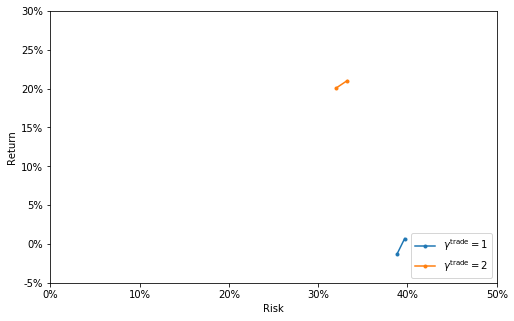

In [11]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,50])
plt.ylim([-5,30])

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier.png')

# SPO fine Search 

In [ ]:
policies={}
gamma_risks_fine=gamma_risks_coarse
gamma_tcosts_fine=[4,5,6,7,8]
for gamma_risk in gamma_risks_fine:
    for gamma_tcost in gamma_tcosts_fine : 
        policies[(gamma_risk, gamma_tcost)] = \
      cp.SinglePeriodOpt(return_estimate, [gamma_risk*risk_model,gamma_tcost*optimization_tcost,optimization_hcost], 
                                [cp.LeverageLimit(3)])

import warnings
warnings.filterwarnings('ignore')
results.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,end_time=end_t,
                                              policies=policies.values(), parallel=True))))

In [ ]:
result_df_fine=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_fine and k[1] in list(gamma_tcosts_fine):
        result_df_fine.loc[k[0], k[1]] = results[k]
        
result_df_fine=result_df_fine.loc[sorted(result_df_fine.index),sorted(result_df_fine.columns)]

In [ ]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df_fine.columns[:]:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df_fine[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df_fine[gamma_tcost]]
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier_fine.png')

# SPO Pareto search 

In [ ]:
results_pareto={}

In [ ]:
policies={}
#gamma_risks_pareto=[int(round(el)) if el>1 else el for el in np.logspace(-1,3,17)]
gamma_risks_pareto=[0.1, 0.17782, 0.31624, 0.562, 1.0, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000]
gamma_tcosts_pareto=[5.5,6,6.5,7,7.5,8]
gamma_holdings=[.1,1.,10.,100.,1000.]
for gamma_risk in gamma_risks_pareto:
    for gamma_tcost in gamma_tcosts_pareto : 
        for gamma_holding in gamma_holdings:
            policies[(gamma_risk, gamma_tcost, gamma_holding)] = \
          cp.SinglePeriodOpt(return_estimate, [gamma_risk*risk_model,gamma_tcost*optimization_tcost,\
                                       gamma_holding*optimization_hcost], 
                                [cp.LeverageLimit(3)])

import warnings
warnings.filterwarnings('ignore')
results_pareto.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,end_time=end_t,
                                              policies=policies.values(), parallel=True))))

In [ ]:
table=pd.DataFrame()
table[r'$\gamma^\mathrm{risk}$']=[el[0] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{trade}$']=[el[1] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{hold}$']=['%g'%el[2] for el in results_pareto.keys()]
table['Return']=[(results_pareto[k].excess_returns.mean()*100*250) for k in results_pareto.keys()]
table['Risk']=[(results_pareto[k].excess_returns.std()*100*np.sqrt(250)) for k in results_pareto.keys()]
table = table.sort_values('Risk', ascending=False).reset_index()
del table['index']
is_pareto = lambda i: table.loc[i,'Return']>=max(table.ix[i:].Return)
table['is_pareto'] = [is_pareto(i) for i in range(len(table))]
table.to_csv(datadir+'spo_pareto_results.csv', float_format='%g')

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(table.Risk.values,table.Return.values)
plt.plot(table[table.is_pareto].Risk,table[table.is_pareto].Return, 'C1.-', label='Pareto optimal frontier')
plt.legend( loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_pareto.png')

In [ ]:
xlim=20
ylim=30
table=table[table.is_pareto]
table=table[table.Risk <= xlim]
table=table[table.Return <= ylim]
del table['is_pareto']
table.Risk=table.Risk.apply(lambda x: '%.2f%%'%x)
table.Return=table.Return.apply(lambda x: '%.2f%%'%x)
print(table.iloc[::-1].to_latex(float_format='%.2f', escape=False, index=False).replace('%',r'\%'))

In [ ]:
1